In [1]:
import numpy as np
import scipy.io
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import statistics as st
import seaborn as sb
import scipy.stats as stats
from sklearn.metrics import roc_auc_score as auROC
from sklearn.metrics import f1_score
import sklearn.metrics as ms
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE 

# Models
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.impute import SimpleImputer


# Model auxiliary
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Others
from statistics import mean
import matplotlib.pyplot as plt
import itertools
from multiprocessing import Pool, cpu_count

In [2]:
import matplotlib as mpl
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'

In [3]:
base_dir = './extracted_data/Calcium/'
# crossreg_dir = os.path.abspath(r'./crossreg')
# session = ['Hungry','Satiated']

# hungry_dir = os.path.abspath(os.path.join(base_dir, session[0]))
# satiated_dir =  os.path.abspath(os.path.join(base_dir, session[1]))

# os.listdir(hungry_dir)


FR = 20
CueN = 12
BinSize = 6
TimeRange_before = 10
TimeRange_after = 10
Baseline_range = 10
Cueduration = 30
CompareRange_base = 0.5
CompareRange_after = 1.5

FrameRange_before = int(FR*TimeRange_before)
FrameRange_after = int(FR*TimeRange_after)
FrameRange_baseline = int(FR*Baseline_range)
TotalFrame = int(FrameRange_before+FrameRange_after)
Bins = int(TotalFrame/BinSize)
Bins_before = int(FrameRange_before/BinSize)
Baseline_bins = Bins_before - int(FrameRange_baseline/BinSize)
Bins_cueend = Bins_before+int(FR*Cueduration/BinSize)

In [4]:
Bins/2

33.0

In [5]:
os.listdir(base_dir)

['6S5.pkl',
 '2Z4.pkl',
 '2N6.pkl',
 '4B6.pkl',
 '7H6.pkl',
 '1I5.pkl',
 '1H6.pkl',
 '7B6.pkl',
 '5B6.pkl',
 '4N6.pkl',
 '6M6.pkl',
 '2I5.pkl',
 '1S5.pkl',
 '9M6.pkl',
 '1B6.pkl',
 '2S5.pkl',
 '7M6.pkl',
 '6H6.pkl',
 '8H6.pkl']

In [6]:
def read_pkl_files(base_dir):
    dataframes = []
    pkl_files = [file for file in os.listdir(base_dir) if file.endswith('.pkl')]

    for pkl_file in pkl_files:
        file_path = os.path.join(base_dir, pkl_file)
        df = pd.read_pickle(file_path)

        # Reset index and use the original index as 'cell_id'
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'cell_id'}, inplace=True)
        
        # Extract animal ID from filename (assuming format 'AnimalID.pkl')
        animal_id = pkl_file.split('.')[0]
        
        # Add animal ID as a new column
        df['Animal_ID'] = animal_id

        # Reorder columns to make 'Animal_ID' front
        columns = ['Animal_ID', 'cell_id'] + [col for col in df.columns if col not in ['Animal_ID', 'cell_id']]
        df = df[columns]

        dataframes.append(df)

    return dataframes

all_dataframes = read_pkl_files(base_dir)


## General functions

In [7]:
# Function to generate symmetric points
def generate_symmetric_points(center, spread, n_points):
    if n_points == 1:
        return np.array([center])
    else:
        offsets = np.linspace(-spread, spread, n_points)
        return center + offsets

# Function to group values that are close together
def group_values(values, threshold):
    sorted_values = np.sort(values)
    groups = [[sorted_values[0]]]
    for value in sorted_values[1:]:
        if abs(value - groups[-1][-1]) <= threshold:
            groups[-1].append(value)
        else:
            groups.append([value])
    return groups


# This section analyze all cells recorded in hungry or satiated session

In [8]:
def calculate_traces_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
    
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
#     trace = trace.sub(trace.mean(axis = 1), axis = 0).divide(trace.std(axis = 1), axis = 0)

    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(TotalFrame))

    # Aligning traces based on cue onset
    for i in range(TotalFrame):
        start = cueonset - FrameRange_before + i
        valid_starts = start[start >= 0]  # Ensure start is not negative
        tracenew.iloc[:, i] = trace.iloc[:, valid_starts].mean(axis=1)

    # Bin the traces
    tracebin = tracenew.groupby(pd.cut(tracenew.columns, Bins), axis=1).mean()
    tracebin.columns = np.arange(0, Bins)
    
    # Calculate the mean and std, handle the situation of 0 std
    mean_vals = tracebin.iloc[:, Baseline_bins:Bins_before].mean(axis=1)
    std_vals = tracebin.iloc[:, Baseline_bins:Bins_before].std(axis=1)
    
    # Create a mask where the mean is < 0.001 or std is < 0.001
    low_variance_mask = (std_vals < 0.001) #(mean_vals < 0.001) | (std_vals < 0.001)
    
    # Replace std values that are 0 with NaN, as well as where the mean is < 0.001
    std_vals_replaced = std_vals.mask(low_variance_mask, np.nan)
    
    # Calculate z-scores, NaN will result in the z-scores where std is zero
    tracezscore = tracebin.sub(mean_vals, axis=0).divide(std_vals_replaced, axis=0)
    
    # Replace NaN z-scores with 0, as these are the ones with std of 0
    tracezscore = tracezscore.fillna(0)

    return tracebin, tracezscore


In [9]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_list = []
trace_hungry_list_c = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin, tracesub = calculate_traces_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracesub['Animal_ID'] = animal_id  # Add animal ID
    tracesub['cell_id'] = cell_ids  # Add cell IDs
    tracebin['Animal_ID'] = animal_id  # Add animal ID
    tracebin['cell_id'] = cell_ids  # Add cell IDs
    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracesub.columns if col not in ['Animal_ID', 'cell_id']]
    tracesub = tracesub[columns]
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracebin.columns if col not in ['Animal_ID', 'cell_id']]
    tracebin = tracebin[columns]
    
    trace_hungry_list.append(tracesub)
    trace_hungry_list_c.append(tracebin)

# Concatenate all dataframes in the list
trace_hungry = pd.concat(trace_hungry_list, ignore_index=True)
trace_hungry_c = pd.concat(trace_hungry_list_c, ignore_index=True)




In [10]:
satiatedcue = -12

# Create a list to hold the dataframes
trace_satiated_list = []
trace_satiated_list_c = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin, tracesub = calculate_traces_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracesub['Animal_ID'] = animal_id  # Add animal ID
    tracesub['cell_id'] = cell_ids  # Add cell IDs
    tracebin['Animal_ID'] = animal_id  # Add animal ID
    tracebin['cell_id'] = cell_ids  # Add cell IDs
    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracesub.columns if col not in ['Animal_ID', 'cell_id']]
    tracesub = tracesub[columns]
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracebin.columns if col not in ['Animal_ID', 'cell_id']]
    tracebin = tracebin[columns]
    
    trace_satiated_list.append(tracesub)
    trace_satiated_list_c.append(tracebin)

# Concatenate all dataframes in the list
trace_satiated = pd.concat(trace_satiated_list, ignore_index=True)
trace_satiated_c = pd.concat(trace_satiated_list_c, ignore_index=True)



1111 neurons in Hungry


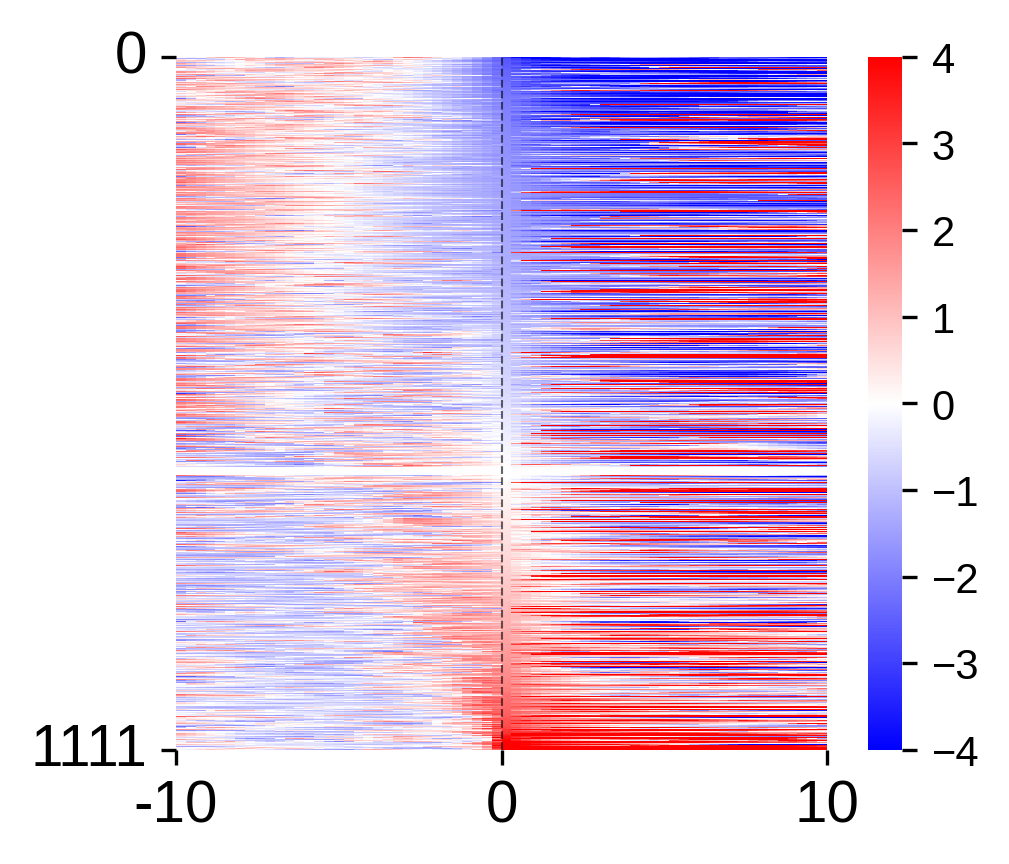

In [11]:
# Sorting and creating the heatmap
tracesorted = trace_hungry.sort_values(by=Bins_before, axis=0)
plt.figure(figsize=(3.5,3), dpi=300)
ax = sb.heatmap(tracesorted.iloc[:, 2:], vmin=-4, vmax=4, cmap="bwr")  # Exclude the last two columns (Animal_ID and cell_id)
ax.set_xticks([0, Bins_before, Bins])
ax.set_xticklabels([-TimeRange_before, 0, TimeRange_after])
ax.set_yticks([0, len(tracesorted)])
ax.set_yticklabels([0, len(tracesorted)])
ax.tick_params(labelsize = 14)
ax.axvline(Bins_before, ls = '--', lw = 0.5, c = 'black', alpha = 0.6)
print(f"{len(trace_hungry)} neurons in Hungry")

plt.show()

1111 neurons in Satiated


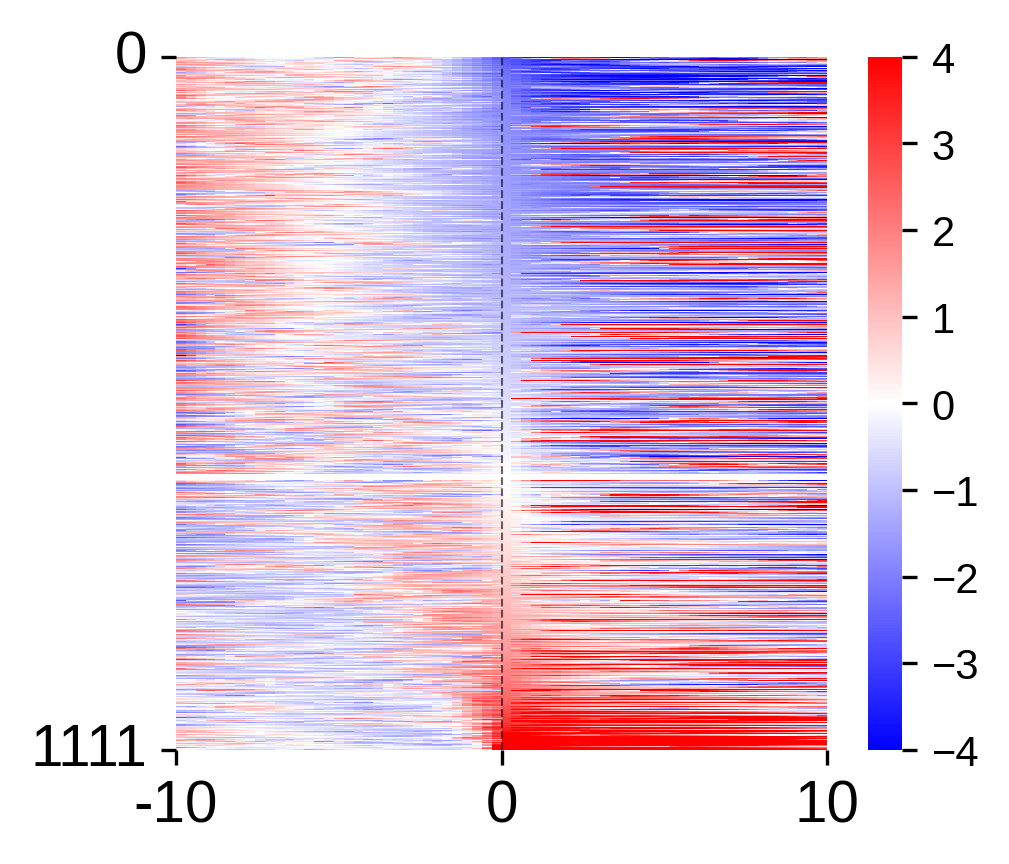

In [12]:
# Sorting and creating the heatmap
tracesorted = trace_satiated.sort_values(by=Bins_before, axis=0)
plt.figure(figsize=(3.5,3), dpi=300)
ax = sb.heatmap(tracesorted.iloc[:, 2:], vmin=-4, vmax=4, cmap="bwr")  # Exclude the last two columns (Animal_ID and cell_id)
ax.set_xticks([0, Bins_before, Bins])
ax.set_xticklabels([-TimeRange_before, 0, TimeRange_after])
ax.set_yticks([0, len(tracesorted)])
ax.set_yticklabels([0, len(tracesorted)])
ax.tick_params(labelsize = 14)
ax.axvline(Bins_before, ls = '--', lw = 0.5, c = 'black', alpha = 0.6)
print(f"{len(trace_hungry)} neurons in Satiated")

plt.show()

In [13]:
tracesatiated_mean = trace_satiated.iloc[:,2:].mean(axis=0)#.dropna(axis=0))
tracesatiated_sem = trace_satiated.iloc[:,2:].sem(axis=0)#.dropna(axis=0))
tracehungry_mean = trace_hungry.iloc[:,2:].mean(axis=0)#.dropna(axis=0)
tracehungry_sem = trace_hungry.iloc[:,2:].sem(axis=0)#.dropna(axis=0)

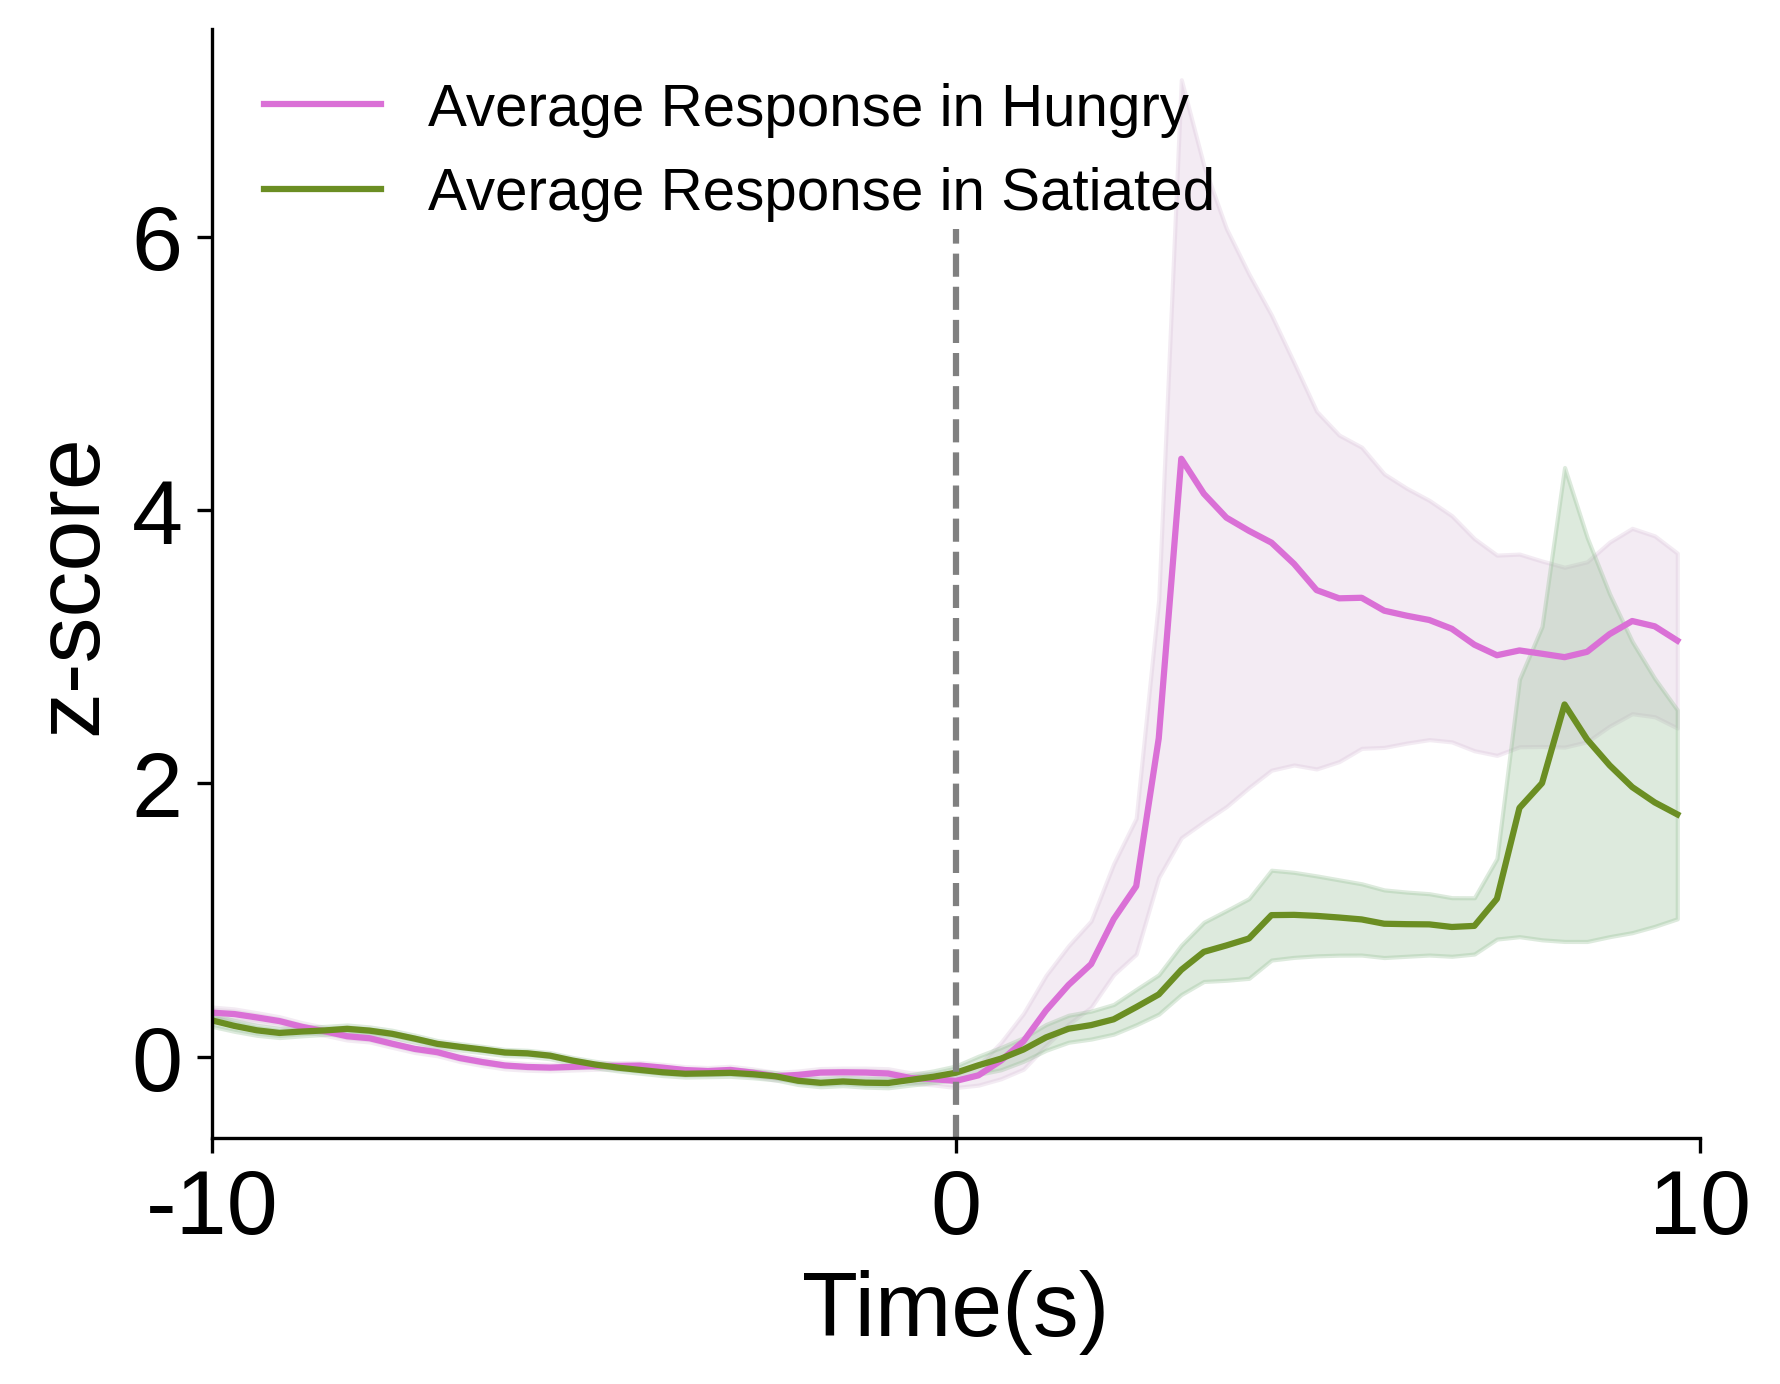

In [14]:
x=np.arange(Bins)
z=tracesatiated_mean
y=tracehungry_mean
errz = tracesatiated_sem
erry = tracehungry_sem
fig, ax = plt.subplots(dpi=300)
ax.plot(x, y, label = 'Average Response in Hungry', color = 'orchid')
ax.plot(x, z, label = 'Average Response in Satiated', color = 'olivedrab')
ax.fill_between(x, y-erry, y+erry, color='thistle', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='darkseagreen', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=22)
ax.set_ylabel('z-score', fontsize=22)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-1,3)
ax.tick_params(labelsize = 22)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--', ymax = 0.82)
ax.legend(loc = 2, framealpha = 0, fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize = 22)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
#len(excited_hungry)

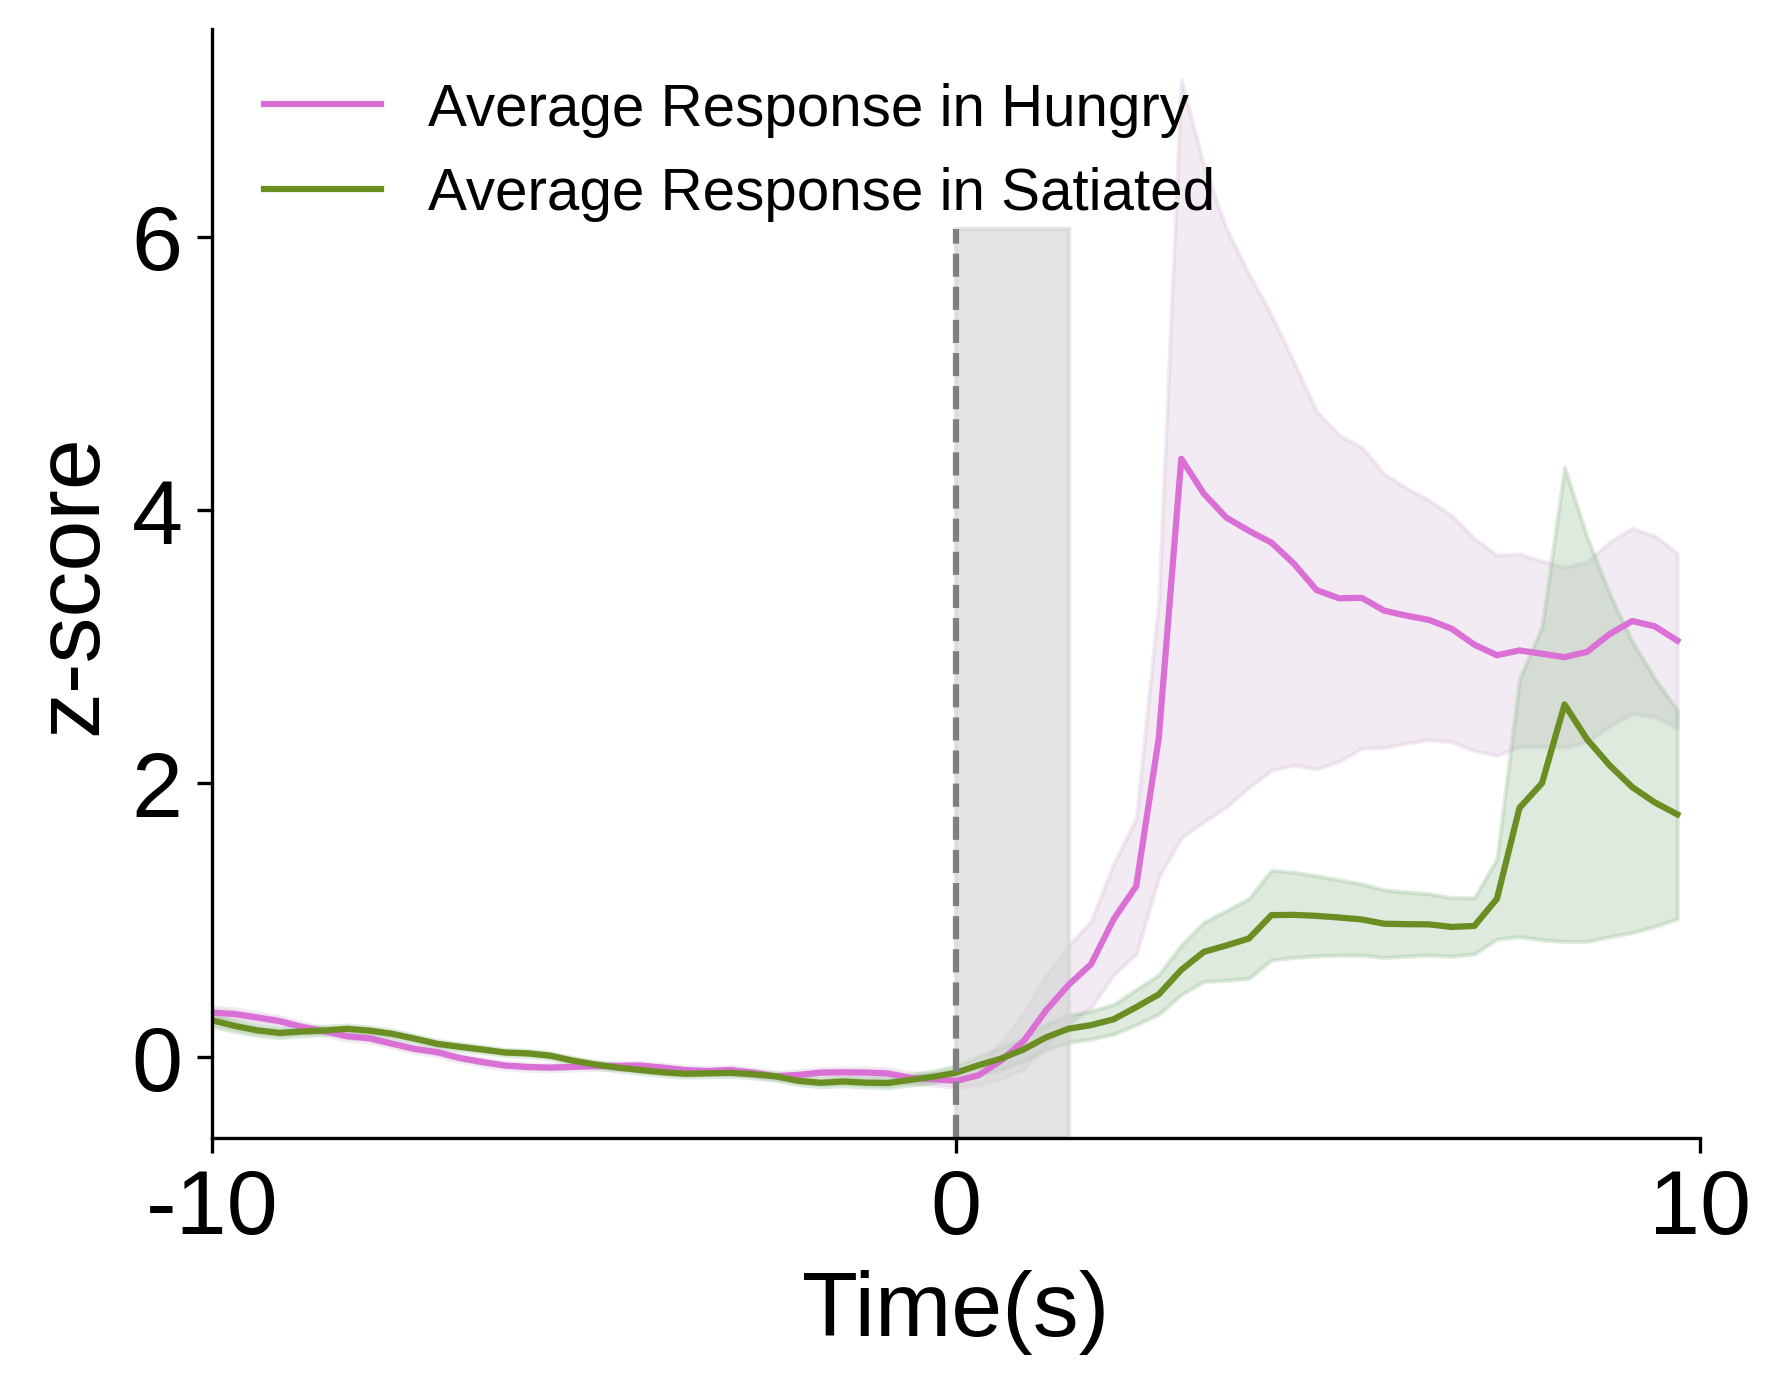

In [15]:
x=np.arange(Bins)
z=tracesatiated_mean
y=tracehungry_mean
errz = tracesatiated_sem
erry = tracehungry_sem
fig, ax = plt.subplots(dpi=300)
ax.plot(x, y, label = 'Average Response in Hungry', color = 'orchid')
ax.plot(x, z, label = 'Average Response in Satiated', color = 'olivedrab')
ax.fill_between(x, y-erry, y+erry, color='thistle', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='darkseagreen', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=22)
ax.set_ylabel('z-score', fontsize=22)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-1,3)
ax.tick_params(labelsize = 22)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--', ymax = 0.82)
ax.legend(loc = 2, framealpha = 0, fontsize = 14)
ax.axvspan(int((Bins/2)),int((Bins/2)+FR*1.5/BinSize), color = "lightgrey", alpha=0.6, ymax = 0.82)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
#len(excited_hungry)

In [336]:
def calculate_3s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]

    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)


    return tracenew

In [337]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_3s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_hungry_list.append(tracenew)

# Concatenate all dataframes in the list
tracehungry = pd.concat(trace_hungry_list, ignore_index=True)
tracehungry

Animal_ID cell_id         0         1             2         3         4  \
0          6S5       1  0.010356  0.010744  6.063247e-02  0.001018  0.238849   
1          6S5       2  0.115504  0.132161  1.026880e-01  0.047843  0.069907   
2          6S5       3  0.095521  0.080449  8.116628e-02  0.034726  0.042994   
3          6S5       4  0.077527  0.012223  1.148508e-04  0.000000  0.000000   
4          6S5       5  0.134319  0.114155  1.597182e-01  0.039449  0.045383   
...        ...     ...       ...       ...           ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
1107       8H6      71  0.013400  0.156774  8.302430e-02  0.000270  0.061699   
1108       8H6      73  0.000000  0.000000  1.035059e-10  0.000000  0.000000   
1109       8H6      75  0.001270  0.000000  0.000000e+00  0.000000  0.000000   
1110       8H6      97  0.000000  0.000000  0.000000e+00  0.000000  0.000000   

             5         6         7         8         9        10            11  
0     0.135095  0.004221  0.006827  0.063876  0.037678  0.001550  4.790882e-03  
1     0.050148  0.093552  0.154609  0.034610  0.104125  0.069173  9.326938e-02  
2     0.034494  0.039977  0.049072  0.414662  0.123671  0.036672  3.041127e-02  
3     0.000000  0.000000  0.000000  0.068089  0.000020  0.000276  1.380412e-09  
4     0.065377  0.057710  0.049993  0.120820  0.068774  0.067840  7.080929e-02  
...        ...       ...       ...       ...       ...       ...           ...  
1106  0.000798  0.101786  0.000066  0.000000  0.000000  0.000000  1.027791e-03  
1107  0.008257  0.000104  0.000466  0.001822  0.148679  0.000010  1.104972e-08  
1108  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  
1109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  4.101608e-01  
1110  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  

[1111 rows x 14 columns]

In [338]:
hungry_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([True])
    dff["dff"]= [np.array(tracehungry[i].values)]
    
    hungry_trace =  pd.concat([hungry_trace,dff],axis=0) 

In [339]:
hungry_trace

is_hungry                                                dff
0       True  [0.010356111688014338, 0.1155039647741313, 0.0...
0       True  [0.010743636135075443, 0.13216100825209035, 0....
0       True  [0.06063246698498891, 0.10268801286786015, 0.0...
0       True  [0.0010180390124466575, 0.047842892620516504, ...
0       True  [0.23884895359444208, 0.06990653768160023, 0.0...
0       True  [0.1350951333869916, 0.05014814549890838, 0.03...
0       True  [0.0042208958893365095, 0.09355225463208752, 0...
0       True  [0.006826521854545962, 0.1546092684114649, 0.0...
0       True  [0.06387617163765712, 0.034609603164984765, 0....
0       True  [0.037677831612626146, 0.10412498258954377, 0....
0       True  [0.001549535427495982, 0.06917256603147452, 0....
0       True  [0.00479088152729038, 0.09326938254330731, 0.0...

In [340]:
satiatedcue = -12
# Create a list to hold the dataframes
trace_satiated_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_3s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_satiated_list.append(tracenew)

# Concatenate all dataframes in the list
tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
tracesatiated

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1  0.146232  0.205013  0.263706  0.274682  0.285223   
1          6S5       2  0.034011  0.006178  0.027943  0.065979  0.055017   
2          6S5       3  0.035802  0.035843  0.050996  0.071597  0.039655   
3          6S5       4  0.001954  0.002620  0.021480  0.128111  0.007275   
4          6S5       5  0.594578  0.043236  0.003566  0.017426  0.090097   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.004074  0.000249   
1107       8H6      71  0.000000  0.000000  0.000000  0.002693  0.000000   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000   
1109       8H6      75  0.000000  0.000000  0.000000  0.000004  0.000000   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000   

             5         6         7             8         9        10        11  
0     0.240384  0.151778  0.236307  3.224678e-01  0.302268  0.265898  0.194531  
1     0.022971  0.031282  0.145478  1.492243e-02  0.174643  0.043663  0.190427  
2     0.028355  0.089667  0.035684  4.713127e-02  0.031046  0.115507  0.030194  
3     0.000523  0.565092  0.005085  7.415357e-03  0.001003  0.291784  0.028552  
4     0.047792  0.000084  0.111599  2.454440e-02  0.013092  0.000744  0.221435  
...        ...       ...       ...           ...       ...       ...       ...  
1106  0.006287  0.000000  0.138166  2.540561e-08  0.000000  0.000000  0.000000  
1107  0.000000  0.000000  0.000000  6.422562e-08  0.000000  0.000000  0.000000  
1108  0.000000  0.000000  0.000000  0.000000e+00  0.000148  0.000002  0.000000  
1109  0.000000  0.000000  0.000054  1.055643e-03  0.000000  0.000000  0.000000  
1110  0.000544  0.000000  0.000000  0.000000e+00  0.000001  0.000000  0.142638  

[1111 rows x 14 columns]

In [341]:
satiated_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([False])
    dff["dff"]= [np.array(tracesatiated[i].values)]
    
    satiated_trace = pd.concat([satiated_trace,dff],axis=0) 

### LDA

In [342]:
trace_combined = pd.concat([hungry_trace,satiated_trace],axis=0, ignore_index=True) 

In [343]:
Data = pd.concat([tracehungry.iloc[:,2:].T,tracesatiated.iloc[:,2:].T], axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [344]:
Data

0         1         2             3         4         5         6     \
0   0.010356  0.115504  0.095521  7.752727e-02  0.134319  0.354493  0.482609   
1   0.010744  0.132161  0.080449  1.222333e-02  0.114155  0.137847  0.509513   
2   0.060632  0.102688  0.081166  1.148508e-04  0.159718  0.206272  0.352623   
3   0.001018  0.047843  0.034726  0.000000e+00  0.039449  0.198979  0.274358   
4   0.238849  0.069907  0.042994  0.000000e+00  0.045383  0.101130  0.272196   
5   0.135095  0.050148  0.034494  0.000000e+00  0.065377  0.097821  0.329047   
6   0.004221  0.093552  0.039977  0.000000e+00  0.057710  0.119606  0.295583   
7   0.006827  0.154609  0.049072  0.000000e+00  0.049993  0.126884  0.296468   
8   0.063876  0.034610  0.414662  6.808938e-02  0.120820  0.067251  0.247382   
9   0.037678  0.104125  0.123671  1.959123e-05  0.068774  0.121388  0.278796   
10  0.001550  0.069173  0.036672  2.757949e-04  0.067840  0.098583  0.325231   
11  0.004791  0.093269  0.030411  1.380412e-09  0.070809  0.133628  0.281925   
12  0.146232  0.034011  0.035802  1.953688e-03  0.594578  0.164243  0.125243   
13  0.205013  0.006178  0.035843  2.620148e-03  0.043236  0.125085  0.079479   
14  0.263706  0.027943  0.050996  2.147969e-02  0.003566  0.041990  0.208948   
15  0.274682  0.065979  0.071597  1.281110e-01  0.017426  0.123349  0.137846   
16  0.285223  0.055017  0.039655  7.274726e-03  0.090097  0.137648  0.095731   
17  0.240384  0.022971  0.028355  5.227212e-04  0.047792  0.418613  0.002149   
18  0.151778  0.031282  0.089667  5.650922e-01  0.000084  0.057828  0.031210   
19  0.236307  0.145478  0.035684  5.085460e-03  0.111599  0.050231  0.045755   
20  0.322468  0.014922  0.047131  7.415357e-03  0.024544  0.104768  0.043192   
21  0.302268  0.174643  0.031046  1.002593e-03  0.013092  0.151755  0.062013   
22  0.265898  0.043663  0.115507  2.917842e-01  0.000744  0.004542  0.132960   
23  0.194531  0.190427  0.030194  2.855180e-02  0.221435  0.193479  0.117157   

        7         8         9     ...          1101          1102  \
0   0.260996  0.009614  0.389259  ...  0.000000e+00  0.000000e+00   
1   0.089815  0.001486  0.205445  ...  0.000000e+00  0.000000e+00   
2   0.271319  0.026493  0.241479  ...  0.000000e+00  0.000000e+00   
3   0.036849  0.003463  0.201833  ...  0.000000e+00  0.000000e+00   
4   0.005936  0.024846  0.086583  ...  0.000000e+00  0.000000e+00   
5   0.112628  0.000013  0.219619  ...  0.000000e+00  0.000000e+00   
6   0.090735  0.014843  0.232824  ...  0.000000e+00  9.134343e-02   
7   0.028274  0.006990  0.175992  ...  0.000000e+00  0.000000e+00   
8   0.004470  0.012793  0.066387  ...  0.000000e+00  1.144766e-08   
9   0.020009  0.002692  0.104589  ...  0.000000e+00  0.000000e+00   
10  0.042024  0.002840  0.159891  ...  0.000000e+00  0.000000e+00   
11  0.030431  0.003579  0.262126  ...  0.000000e+00  0.000000e+00   
12  0.023911  0.002618  0.031640  ...  0.000000e+00  0.000000e+00   
13  0.065392  0.042250  0.023343  ...  0.000000e+00  0.000000e+00   
14  0.048073  0.015558  0.120497  ...  4.082983e-05  0.000000e+00   
15  0.090074  0.276875  0.075165  ...  1.397745e-02  0.000000e+00   
16  0.050321  0.498874  0.132596  ...  1.684154e-10  0.000000e+00   
17  0.036290  0.617650  0.001411  ...  4.295081e-03  0.000000e+00   
18  0.033001  0.023699  0.009908  ...  4.751900e-03  0.000000e+00   
19  0.046298  0.002621  0.001878  ...  1.952160e-02  0.000000e+00   
20  0.303856  0.001892  0.004811  ...  4.334847e-06  0.000000e+00   
21  0.057807  0.394807  0.198211  ...  3.042568e-05  0.000000e+00   
22  0.025635  0.011262  0.029896  ...  1.646533e-02  0.000000e+00   
23  0.064896  0.045897  0.060098  ...  2.954746e-04  0.000000e+00   

            1103          1104          1105          1106          1107  \
0   0.000000e+00  0.000000e+00  1.662157e-01  0.000000e+00  1.339982e-02   
1   8.259884e-06  0.000000e+00  8.637142e-02  0.000000e+00  1.567741e-01   
2   1.076646e-02  8.394630e-04  0.000000e+00  0.00000

In [345]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6     \
0  -1.169315  0.726231  0.333845  0.214938  0.375481  2.415826  1.984060   
1  -1.165933  1.051710  0.138189 -0.310183  0.204241 -0.013588  2.179492   
2  -0.730535  0.475807  0.147498 -0.407550  0.591188  0.753716  1.039834   
3  -1.250812 -0.595867 -0.455359 -0.408473 -0.430205  0.671927  0.471311   
4   0.824827 -0.164743 -0.348024 -0.408473 -0.379811 -0.425326  0.455607   
5  -0.080671 -0.550823 -0.458366 -0.408473 -0.210010 -0.462436  0.868573   
6  -1.222859  0.297294 -0.387190 -0.408473 -0.275129 -0.218143  0.625489   
7  -1.200119  1.490349 -0.269127 -0.408473 -0.340664 -0.136529  0.631922   
8  -0.702226 -0.854446  4.476668  0.139046  0.260844 -0.805238  0.275352   
9  -0.930868  0.503885  0.699262 -0.408316 -0.181160 -0.198156  0.503546   
10 -1.246173 -0.179085 -0.430097 -0.406256 -0.189092 -0.453890  0.840857   
11 -1.217885  0.291767 -0.511363 -0.408473 -0.163878 -0.060899  0.526279   
12  0.016527 -0.866151 -0.441381 -0.392763  4.284266  0.282414 -0.611870   
13  0.529528 -1.410006 -0.440847 -0.387404 -0.398047 -0.156704 -0.944305   
14  1.041765 -0.984713 -0.244145 -0.235751 -0.734950 -1.088512 -0.003833   
15  1.137557 -0.241480  0.023276  0.621691 -0.617239 -0.176162 -0.520325   
16  1.229549 -0.455686 -0.391368 -0.349976 -0.000072 -0.015815 -0.826249   
17  0.838224 -1.081867 -0.538062 -0.404270 -0.359358  3.134855 -1.506035   
18  0.064927 -0.919473  0.257847  4.135538 -0.764517 -0.910906 -1.294931   
19  0.802640  1.311923 -0.442911 -0.367580  0.182533 -0.996094 -1.189280   
20  1.554601 -1.239133 -0.294318 -0.348845 -0.556787 -0.384531 -1.207896   
21  1.378308  1.881809 -0.503124 -0.400411 -0.654043  0.142377 -1.071180   
22  1.060898 -0.677533  0.593284  1.937817 -0.758916 -1.508437 -0.555811   
23  0.438044  2.190233 -0.514187 -0.178883  1.115325  0.610252 -0.670605   

        7         8         9     ...      1101      1102      1103      1104  \
0   2.272329 -0.443701  2.613671  ... -0.445062 -0.208514 -0.271130 -0.213081   
1   0.162543 -0.491448  0.785418  ... -0.445062 -0.208514 -0.271070 -0.213081   
2   2.399561 -0.344556  1.143816  ... -0.445062 -0.208514 -0.193899 -0.137851   
3  -0.490261 -0.479832  0.749491  ... -0.445062 -0.208514 -0.271130 -0.213081   
4  -0.871253 -0.354230 -0.396808  ... -0.445062 -0.208514 -0.257980 -0.213081   
5   0.443717 -0.500096  0.926390  ... -0.445062 -0.208514 -0.271130 -0.213081   
6   0.173881 -0.412990  1.057731  ... -0.445062  4.795832  4.568623 -0.213081   
7  -0.595946 -0.459119  0.492476  ... -0.445062 -0.208514 -0.271124 -0.213081   
8  -0.889328 -0.425027 -0.597680  ... -0.445062 -0.208514 -0.270221 -0.213081   
9  -0.697802 -0.484361 -0.217716  ... -0.445062 -0.208514 -0.271130 -0.213081   
10 -0.426473 -0.483491  0.332332  ... -0.445062 -0.208514 -0.271087 -0.213081   
11 -0.569352 -0.479153  1.349174  ... -0.445062 -0.208514 -0.271130 -0.213081   
12 -0.649714 -0.484798 -0.943283  ... -0.445062 -0.208514 -0.271130 -0.213081   
13 -0.138467 -0.252002 -1.025808  ... -0.445062 -0.208514 -0.271130 -0.213081   
14 -0.351920 -0.408788 -0.059489  ... -0.437718 -0.208514 -0.271130 -0.213081   
15  0.165742  1.126153 -0.510378  ...  2.069151 -0.208514  1.256142  4.795222   
16 -0.324210  2.430150  0.060848  ... -0.445062 -0.208514 -0.271129 -0.213081   
17 -0.497150  3.127826 -1.243944  ...  0.327521 -0.208514 -0.271130 -0.213081   
18 -0.537686 -0.360970 -1.159428  ...  0.409692 -0.208514 -0.271130 -0.213081   
19 -0.373794 -0.484777 -1.239296  ...  3.066412 -0.208514 -0.271130 -0.213081   
20  2.800576 -0.489058 -1.210127  ... -0.444283 -0.208514 -0.222454 -0.182669   
21 -0.231945  1.818875  0.713468  ... -0.439589 -0.208514 -0.271130 -0.213081   
22 -0.628472 -0.434022 -0.960625  ...  2.516661 -0.208514 -0.271116 -0.213081   
23 -0.144577 -0.230584 -0.660234  ... -0.391913 -0.208514 -0.271130 -0.213081   

        1105      1106      1107      1108      1109      1110  
0   1.158420 -0.

In [346]:
np.concatenate([np.repeat(1,12),np.repeat(0,12)])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [347]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [348]:
Data

0         1         2         3         4         5         6  \
0  -1.169315  0.726231  0.333845  0.214938  0.375481  2.415826  1.984060   
1  -1.165933  1.051710  0.138189 -0.310183  0.204241 -0.013588  2.179492   
2  -0.730535  0.475807  0.147498 -0.407550  0.591188  0.753716  1.039834   
3  -1.250812 -0.595867 -0.455359 -0.408473 -0.430205  0.671927  0.471311   
4   0.824827 -0.164743 -0.348024 -0.408473 -0.379811 -0.425326  0.455607   
5  -0.080671 -0.550823 -0.458366 -0.408473 -0.210010 -0.462436  0.868573   
6  -1.222859  0.297294 -0.387190 -0.408473 -0.275129 -0.218143  0.625489   
7  -1.200119  1.490349 -0.269127 -0.408473 -0.340664 -0.136529  0.631922   
8  -0.702226 -0.854446  4.476668  0.139046  0.260844 -0.805238  0.275352   
9  -0.930868  0.503885  0.699262 -0.408316 -0.181160 -0.198156  0.503546   
10 -1.246173 -0.179085 -0.430097 -0.406256 -0.189092 -0.453890  0.840857   
11 -1.217885  0.291767 -0.511363 -0.408473 -0.163878 -0.060899  0.526279   
12  0.016527 -0.866151 -0.441381 -0.392763  4.284266  0.282414 -0.611870   
13  0.529528 -1.410006 -0.440847 -0.387404 -0.398047 -0.156704 -0.944305   
14  1.041765 -0.984713 -0.244145 -0.235751 -0.734950 -1.088512 -0.003833   
15  1.137557 -0.241480  0.023276  0.621691 -0.617239 -0.176162 -0.520325   
16  1.229549 -0.455686 -0.391368 -0.349976 -0.000072 -0.015815 -0.826249   
17  0.838224 -1.081867 -0.538062 -0.404270 -0.359358  3.134855 -1.506035   
18  0.064927 -0.919473  0.257847  4.135538 -0.764517 -0.910906 -1.294931   
19  0.802640  1.311923 -0.442911 -0.367580  0.182533 -0.996094 -1.189280   
20  1.554601 -1.239133 -0.294318 -0.348845 -0.556787 -0.384531 -1.207896   
21  1.378308  1.881809 -0.503124 -0.400411 -0.654043  0.142377 -1.071180   
22  1.060898 -0.677533  0.593284  1.937817 -0.758916 -1.508437 -0.555811   
23  0.438044  2.190233 -0.514187 -0.178883  1.115325  0.610252 -0.670605   

           7         8         9  ...      1102      1103      1104      1105  \
0   2.272329 -0.443701  2.613671  ... -0.208514 -0.271130 -0.213081  1.158420   
1   0.162543 -0.491448  0.785418  ... -0.208514 -0.271070 -0.213081  0.411430   
2   2.399561 -0.344556  1.143816  ... -0.208514 -0.193899 -0.137851 -0.396625   
3  -0.490261 -0.479832  0.749491  ... -0.208514 -0.271130 -0.213081  3.240110   
4  -0.871253 -0.354230 -0.396808  ... -0.208514 -0.257980 -0.213081 -0.262819   
5   0.443717 -0.500096  0.926390  ... -0.208514 -0.271130 -0.213081 -0.396625   
6   0.173881 -0.412990  1.057731  ...  4.795832  4.568623 -0.213081  2.988728   
7  -0.595946 -0.459119  0.492476  ... -0.208514 -0.271124 -0.213081 -0.396625   
8  -0.889328 -0.425027 -0.597680  ... -0.208514 -0.270221 -0.213081 -0.396625   
9  -0.697802 -0.484361 -0.217716  ... -0.208514 -0.271130 -0.213081 -0.396625   
10 -0.426473 -0.483491  0.332332  ... -0.208514 -0.271087 -0.213081 -0.396625   
11 -0.569352 -0.479153  1.349174  ... -0.208514 -0.271130 -0.213081 -0.396625   
12 -0.649714 -0.484798 -0.943283  ... -0.208514 -0.271130 -0.213081 -0.396625   
13 -0.138467 -0.252002 -1.025808  ... -0.208514 -0.271130 -0.213081 -0.396625   
14 -0.351920 -0.408788 -0.059489  ... -0.208514 -0.271130 -0.213081 -0.396625   
15  0.165742  1.126153 -0.510378  ... -0.208514  1.256142  4.795222 -0.396625   
16 -0.324210  2.430150  0.060848  ... -0.208514 -0.271129 -0.213081 -0.396624   
17 -0.497150  3.127826 -1.243944  ... -0.208514 -0.271130 -0.213081 -0.396625   
18 -0.537686 -0.360970 -1.159428  ... -0.208514 -0.271130 -0.213081 -0.396625   
19 -0.373794 -0.484777 -1.239296  ... -0.208514 -0.271130 -0.213081 -0.396625   
20  2.800576 -0.489058 -1.210127  ... -0.208514 -0.222454 -0.182669 -0.396625   
21 -0.231945  1.818875  0.713468  ... -0.208514 -0.271130 -0.213081 -0.396625   
22 -0.628472 -0.434022 -0.960625  ... -0.208514 -0.271116 -0.213081 -0.396625   
23 -0.144577 -0.230584 -0.660234  ... -0.208514 -0.271130 -0.213081 -0.396625   

        1106      1107      1108      1109      1110  Label  
0  -0.314473 -0.144742

In [349]:
#Data.to_csv("Calcium Dataset reorganized.csv")

In [350]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Stratified train-test-split
sss = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
for train_index, test_index in sss.split(X, Y):
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

# Training set
Xtrain = Train.iloc[:, 0:Dt.shape[1]-1] 
Ytrain = Train.iloc[:,Dt.shape[1]-1]

# Testing set
Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
Ytest = Test.iloc[:, Dt.shape[1]-1]

print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


In [351]:
X

0         1         2         3         4         5         6     \
0  -1.169315  0.726231  0.333845  0.214938  0.375481  2.415826  1.984060   
1  -1.165933  1.051710  0.138189 -0.310183  0.204241 -0.013588  2.179492   
2  -0.730535  0.475807  0.147498 -0.407550  0.591188  0.753716  1.039834   
3  -1.250812 -0.595867 -0.455359 -0.408473 -0.430205  0.671927  0.471311   
4   0.824827 -0.164743 -0.348024 -0.408473 -0.379811 -0.425326  0.455607   
5  -0.080671 -0.550823 -0.458366 -0.408473 -0.210010 -0.462436  0.868573   
6  -1.222859  0.297294 -0.387190 -0.408473 -0.275129 -0.218143  0.625489   
7  -1.200119  1.490349 -0.269127 -0.408473 -0.340664 -0.136529  0.631922   
8  -0.702226 -0.854446  4.476668  0.139046  0.260844 -0.805238  0.275352   
9  -0.930868  0.503885  0.699262 -0.408316 -0.181160 -0.198156  0.503546   
10 -1.246173 -0.179085 -0.430097 -0.406256 -0.189092 -0.453890  0.840857   
11 -1.217885  0.291767 -0.511363 -0.408473 -0.163878 -0.060899  0.526279   
12  0.016527 -0.866151 -0.441381 -0.392763  4.284266  0.282414 -0.611870   
13  0.529528 -1.410006 -0.440847 -0.387404 -0.398047 -0.156704 -0.944305   
14  1.041765 -0.984713 -0.244145 -0.235751 -0.734950 -1.088512 -0.003833   
15  1.137557 -0.241480  0.023276  0.621691 -0.617239 -0.176162 -0.520325   
16  1.229549 -0.455686 -0.391368 -0.349976 -0.000072 -0.015815 -0.826249   
17  0.838224 -1.081867 -0.538062 -0.404270 -0.359358  3.134855 -1.506035   
18  0.064927 -0.919473  0.257847  4.135538 -0.764517 -0.910906 -1.294931   
19  0.802640  1.311923 -0.442911 -0.367580  0.182533 -0.996094 -1.189280   
20  1.554601 -1.239133 -0.294318 -0.348845 -0.556787 -0.384531 -1.207896   
21  1.378308  1.881809 -0.503124 -0.400411 -0.654043  0.142377 -1.071180   
22  1.060898 -0.677533  0.593284  1.937817 -0.758916 -1.508437 -0.555811   
23  0.438044  2.190233 -0.514187 -0.178883  1.115325  0.610252 -0.670605   

        7         8         9     ...      1101      1102      1103      1104  \
0   2.272329 -0.443701  2.613671  ... -0.445062 -0.208514 -0.271130 -0.213081   
1   0.162543 -0.491448  0.785418  ... -0.445062 -0.208514 -0.271070 -0.213081   
2   2.399561 -0.344556  1.143816  ... -0.445062 -0.208514 -0.193899 -0.137851   
3  -0.490261 -0.479832  0.749491  ... -0.445062 -0.208514 -0.271130 -0.213081   
4  -0.871253 -0.354230 -0.396808  ... -0.445062 -0.208514 -0.257980 -0.213081   
5   0.443717 -0.500096  0.926390  ... -0.445062 -0.208514 -0.271130 -0.213081   
6   0.173881 -0.412990  1.057731  ... -0.445062  4.795832  4.568623 -0.213081   
7  -0.595946 -0.459119  0.492476  ... -0.445062 -0.208514 -0.271124 -0.213081   
8  -0.889328 -0.425027 -0.597680  ... -0.445062 -0.208514 -0.270221 -0.213081   
9  -0.697802 -0.484361 -0.217716  ... -0.445062 -0.208514 -0.271130 -0.213081   
10 -0.426473 -0.483491  0.332332  ... -0.445062 -0.208514 -0.271087 -0.213081   
11 -0.569352 -0.479153  1.349174  ... -0.445062 -0.208514 -0.271130 -0.213081   
12 -0.649714 -0.484798 -0.943283  ... -0.445062 -0.208514 -0.271130 -0.213081   
13 -0.138467 -0.252002 -1.025808  ... -0.445062 -0.208514 -0.271130 -0.213081   
14 -0.351920 -0.408788 -0.059489  ... -0.437718 -0.208514 -0.271130 -0.213081   
15  0.165742  1.126153 -0.510378  ...  2.069151 -0.208514  1.256142  4.795222   
16 -0.324210  2.430150  0.060848  ... -0.445062 -0.208514 -0.271129 -0.213081   
17 -0.497150  3.127826 -1.243944  ...  0.327521 -0.208514 -0.271130 -0.213081   
18 -0.537686 -0.360970 -1.159428  ...  0.409692 -0.208514 -0.271130 -0.213081   
19 -0.373794 -0.484777 -1.239296  ...  3.066412 -0.208514 -0.271130 -0.213081   
20  2.800576 -0.489058 -1.210127  ... -0.444283 -0.208514 -0.222454 -0.182669   
21 -0.231945  1.818875  0.713468  ... -0.439589 -0.208514 -0.271130 -0.213081   
22 -0.628472 -0.434022 -0.960625  ...  2.516661 -0.208514 -0.271116 -0.213081   
23 -0.144577 -0.230584 -0.660234  ... -0.391913 -0.208514 -0.271130 -0.213081   

        1105      1106      1107      1108      1109      1110  
0   1.158420 -0.

In [352]:


# Hyperparameter
solver = ['lsqr', 'eigen']
# shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

# Training process
LDA_ACC_train = []
LDA_AUC_train = []
LDA_ACC_test = []
LDA_AUC_test = []

n = len(Hyperparameter_Space2)

for i in range(0, n):
    # Extract hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[i, :]
    Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
    # Model with hyperparameter
    LDA = LinearDiscriminantAnalysis(**Hyperpara)
    LDA.fit(Xtrain, Ytrain)
    
    # Obtain training metrics
    y_train_pred = LDA.predict(Xtrain)
    y_train_score = LDA.predict_proba(Xtrain)[:, 1]
    
    train_acc = accuracy_score(Ytrain, y_train_pred)
    train_auc = roc_auc_score(Ytrain, y_train_score)
    
    LDA_ACC_train.append(train_acc)
    LDA_AUC_train.append(train_auc)
    
    # Obtain testing metrics
    y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]
    
    test_acc = accuracy_score(Ytest, y_test_pred)
    test_auc = roc_auc_score(Ytest, y_test_score)
    
    LDA_ACC_test.append(test_acc)
    LDA_AUC_test.append(test_auc)
    
# Show training result
Result_LDA = {'Train_Accuracy': LDA_ACC_train,
          'Train_AUC': LDA_AUC_train,
          'Test_Accuracy': LDA_ACC_test,
          'Test_AUC': LDA_AUC_test}
Result_LDA = pd.DataFrame(Result_LDA)
Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)
Result_LDA

solver shrinkage  Train_Accuracy  Train_AUC  Test_Accuracy  Test_AUC
0   lsqr      auto             1.0        1.0            1.0       1.0
1  eigen      auto             1.0        1.0            1.0       1.0

In [353]:
random.seed = 999
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}

def process(i):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    
    # Model with hyperparameter
    LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
    clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
    
    y_pred = clf_shuffle.predict(Xtest)
    
    accuracy = accuracy_score(Ytest, y_pred)
    auc = roc_auc_score(Ytest, y_pred)
    
    return accuracy, auc

if __name__ == "__main__":
    with Pool(cpu_count()) as p:
        results = p.map(process, range(nump))

    for i, result in enumerate(results):
        accuracy_multisplit_shuffle[i], auc_multisplit_shuffle[i] = result


In [354]:
AUC_True = Result_LDA["Test_AUC"].max()
AUC_True

1.0

In [355]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

0.006

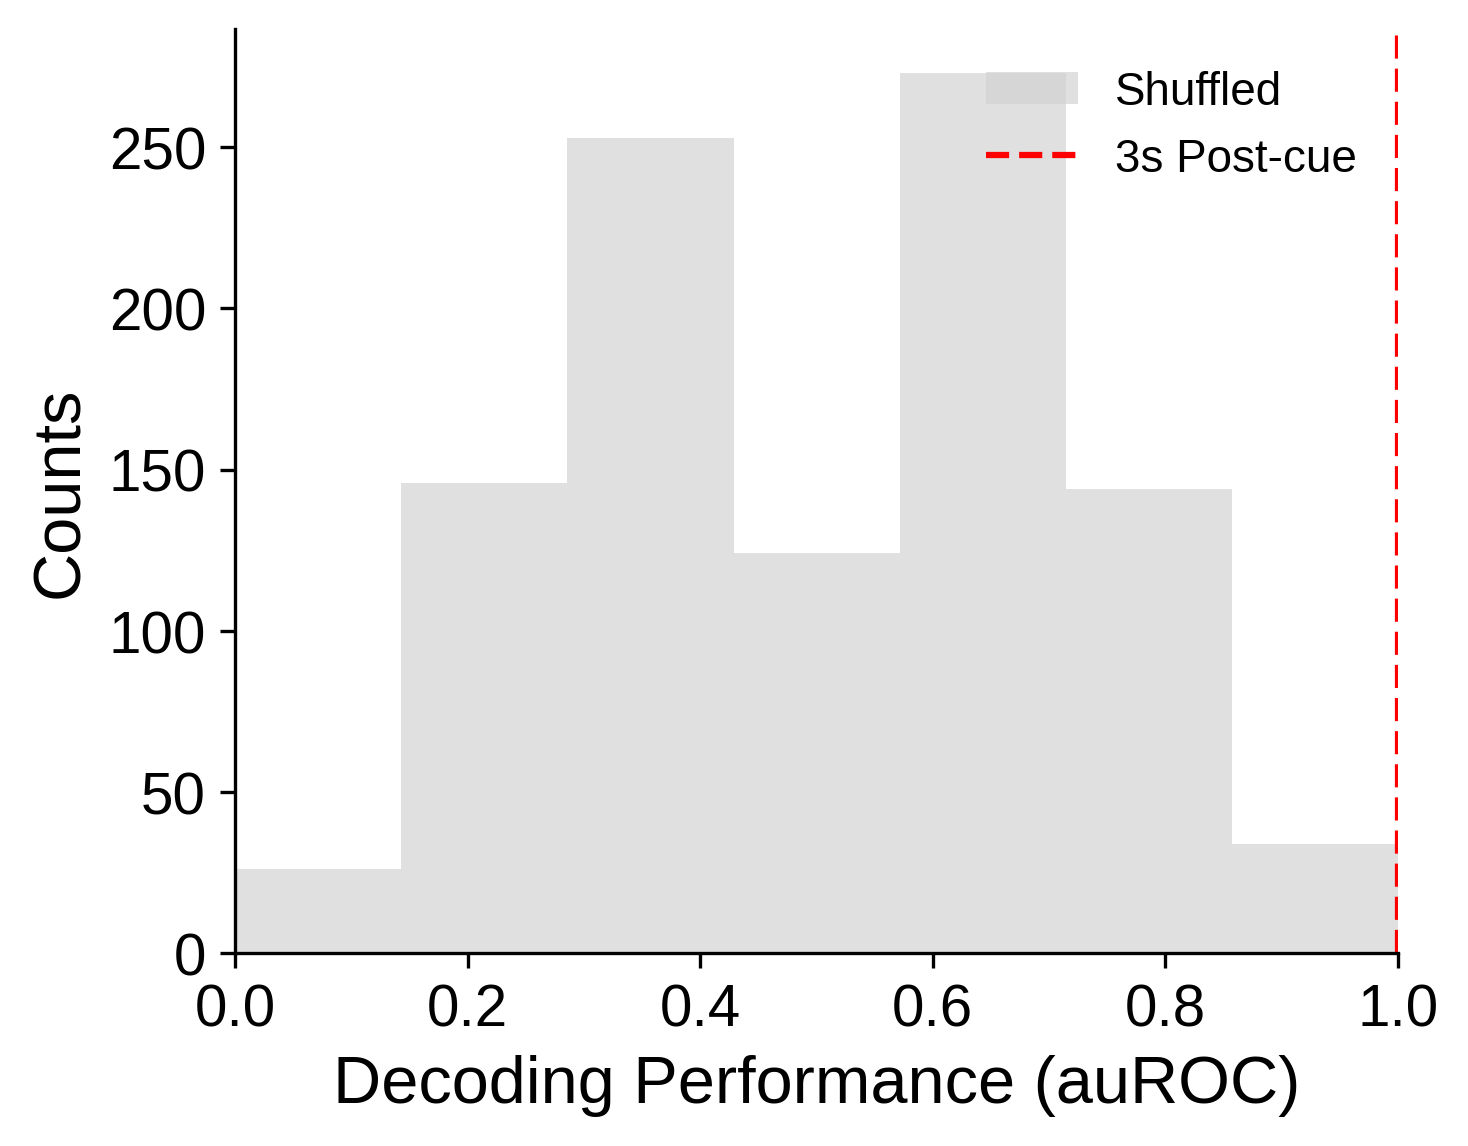

In [356]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=7)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.set_xlim(0,1)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--', label = "3s Post-cue" )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon= False,fontsize =11)

## 1 second 

In [431]:
def calculate_1s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]

    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(1*FR)].mean(axis=1)


    return tracenew

In [432]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_1s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_hungry_list.append(tracenew)

# Concatenate all dataframes in the list
tracehungry = pd.concat(trace_hungry_list, ignore_index=True)
tracehungry

Animal_ID cell_id         0         1             2         3         4  \
0          6S5       1  0.011843  0.000260  6.933550e-02  0.001164  0.273133   
1          6S5       2  0.136904  0.129403  5.946418e-02  0.037852  0.047004   
2          6S5       3  0.099004  0.077142  8.412555e-02  0.035716  0.044562   
3          6S5       4  0.093807  0.009348  1.389685e-04  0.000000  0.000000   
4          6S5       5  0.144391  0.128904  1.995083e-01  0.043510  0.044636   
...        ...     ...       ...       ...           ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
1107       8H6      71  0.017128  0.200398  1.061266e-01  0.000345  0.078868   
1108       8H6      73  0.000000  0.000000  3.105177e-10  0.000000  0.000000   
1109       8H6      75  0.001940  0.000000  0.000000e+00  0.000000  0.000000   
1110       8H6      97  0.000000  0.000000  0.000000e+00  0.000000  0.000000   

             5         6         7         8         9        10            11  
0     0.154486  0.003385  0.007806  0.073045  0.043086  0.001628  4.857912e-03  
1     0.023952  0.062005  0.119775  0.041022  0.119890  0.052980  8.329492e-02  
2     0.035404  0.038286  0.046613  0.039838  0.128180  0.037184  2.989955e-02  
3     0.000000  0.000000  0.000000  0.000013  0.000024  0.000334  1.777878e-09  
4     0.047832  0.048978  0.030519  0.119879  0.085908  0.052210  8.308256e-02  
...        ...       ...       ...       ...       ...       ...           ...  
1106  0.001042  0.132948  0.000087  0.000000  0.000000  0.000000  1.342449e-03  
1107  0.010555  0.000133  0.000595  0.002329  0.190050  0.000013  1.412193e-08  
1108  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  
1109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  
1110  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  

[1111 rows x 14 columns]

In [433]:
trace_hungry_trial_mean

1    2    3         4         5         6         7         8  \
0     0.0  0.0  0.0  0.000336  0.121736  0.110322  0.003819  0.014012   
1     0.0  0.0  0.0  0.086355  0.050705  0.066181  0.040792  0.048071   
2     0.0  0.0  0.0  0.026224  0.036156  0.033223  0.037047  0.037546   
3     0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.0  0.0  0.0  0.047766  0.035803  0.069082  0.043354  0.063842   
...   ...  ...  ...       ...       ...       ...       ...       ...   
1106  0.0  0.0  0.0  0.000000  0.000000  0.000526  0.178366  0.000294   
1107  0.0  0.0  0.0  0.022463  0.017551  0.005657  0.000173  0.001810   
1108  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1109  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1110  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

             9        10   11   12  
0     0.067880  0.119009  0.0  0.0  
1     0.015860  0.039367  0.0  0.0  
2     0.039885  0.123235  0.0  0.0  
3     0.000059  0.000125  0.0  0.0  
4     0.345263  0.400309  0.0  0.0  
...        ...       ...  ...  ...  
1106  0.000000  0.000000  0.0  0.0  
1107  0.017289  0.000029  0.0  0.0  
1108  0.000000  0.000000  0.0  0.0  
1109  0.000000  0.000000  0.0  0.0  
1110  0.000000  0.000000  0.0  0.0  

[1111 rows x 12 columns]

In [434]:
hungry_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([True])
    dff["dff"]= [np.array(tracehungry[i].values)]
    
    hungry_trace =  pd.concat([hungry_trace,dff],axis=0) 

In [435]:
hungry_trace

is_hungry                                                dff
0       True  [0.011842601911700152, 0.1369035543266238, 0.0...
0       True  [0.0002598817083008239, 0.12940293235031977, 0...
0       True  [0.06933549879158503, 0.059464177483629935, 0....
0       True  [0.0011641657717030066, 0.03785213681107659, 0...
0       True  [0.27313273163393104, 0.04700421318024126, 0.0...
0       True  [0.15448634903832018, 0.023952404438146807, 0....
0       True  [0.0033846208562577015, 0.062005290548863945, ...
0       True  [0.007806383630659566, 0.11977500093046042, 0....
0       True  [0.07304479665150906, 0.04102177528228, 0.0398...
0       True  [0.04308601279323191, 0.11989028027065993, 0.1...
0       True  [0.0016279647088865187, 0.05298013590403229, 0...
0       True  [0.004857912482004541, 0.0832949209834469, 0.0...

In [436]:

# Create a list to hold the dataframes
trace_satiated_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_1s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_satiated_list.append(tracenew)

# Concatenate all dataframes in the list
tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
tracesatiated

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1  0.160899  0.166243  0.280050  0.314109  0.256992   
1          6S5       2  0.034080  0.007322  0.029854  0.058255  0.045576   
2          6S5       3  0.037108  0.031864  0.052856  0.046267  0.041101   
3          6S5       4  0.002364  0.002869  0.025990  0.033869  0.008802   
4          6S5       5  0.742372  0.054007  0.004454  0.021767  0.004624   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.005321  0.000326   
1107       8H6      71  0.000000  0.000000  0.000000  0.003442  0.000000   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000   
1109       8H6      75  0.000000  0.000000  0.000000  0.000006  0.000000   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000   

             5         6         7             8         9        10        11  
0     0.241945  0.130312  0.234586  3.687541e-01  0.307081  0.257864  0.143143  
1     0.023445  0.030510  0.145528  1.528317e-02  0.036529  0.051753  0.218419  
2     0.028382  0.092936  0.031948  4.884965e-02  0.032178  0.119719  0.029395  
3     0.000632  0.669038  0.006153  7.866799e-03  0.001213  0.353056  0.034547  
4     0.059698  0.000105  0.139401  3.065906e-02  0.016354  0.000929  0.276601  
...        ...       ...       ...           ...       ...       ...       ...  
1106  0.008212  0.000000  0.031983  3.318295e-08  0.000000  0.000000  0.000000  
1107  0.000000  0.000000  0.000000  8.209469e-08  0.000000  0.000000  0.000000  
1108  0.000000  0.000000  0.000000  0.000000e+00  0.000215  0.000004  0.000000  
1109  0.000000  0.000000  0.000082  1.612071e-03  0.000000  0.000000  0.000000  
1110  0.000756  0.000000  0.000000  0.000000e+00  0.000001  0.000000  0.000000  

[1111 rows x 14 columns]

In [437]:
satiated_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([False])
    dff["dff"]= [np.array(tracesatiated[i].values)]
    
    satiated_trace = pd.concat([satiated_trace,dff],axis=0) 

### LDA

In [438]:
trace_combined =  pd.concat([hungry_trace,satiated_trace],axis=0,ignore_index=True) 

In [439]:
Data = pd.concat([tracehungry.iloc[:,2:].T,tracesatiated.iloc[:,2:].T], axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [440]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6     \
0  -1.122889  1.380273  1.562240  0.283645  0.302154  2.658558  2.163128   
1  -1.219776  1.231985  0.808545 -0.290557  0.198647  0.139403  1.755147   
2  -0.641977 -0.150715  1.049292 -0.353168  0.670512  0.790420  1.165435   
3  -1.212212 -0.577988 -0.619646 -0.354112 -0.372055  0.852267  0.863012   
4   1.062731 -0.397050 -0.314703 -0.354112 -0.364533 -0.549454  0.277937   
5   0.070286 -0.852788 -0.630412 -0.354112 -0.343169 -0.352833  0.788497   
6  -1.193638 -0.100477 -0.531067 -0.354112 -0.335514 -0.077589  0.535378   
7  -1.156651  1.041639 -0.243969 -0.354112 -0.458875 -0.249919  0.439655   
8  -0.610950 -0.515324 -0.477556 -0.354024  0.138335 -0.699826  0.321656   
9  -0.861547  1.043918  2.568103 -0.353951 -0.088703 -0.056257  0.641875   
10 -1.208332 -0.278905 -0.569064 -0.351844 -0.313912 -0.371784  0.831210   
11 -1.181314  0.320423 -0.820187 -0.354112 -0.107585  0.088504  0.611998   
12  0.123928 -0.652573 -0.571682 -0.338041  4.298580  0.453196 -0.799922   
13  0.168632 -1.181569 -0.752466 -0.334609 -0.301902 -0.180183 -0.899973   
14  1.120588 -0.736114 -0.028760 -0.177415 -0.633076 -1.244644 -0.077734   
15  1.405488 -0.174621 -0.255905 -0.123849 -0.517367 -0.032941 -0.283606   
16  0.927721 -0.425282 -0.434016 -0.294269 -0.631943 -1.250737 -0.701742   
17  0.801855 -0.862828 -0.872512 -0.349812 -0.263871  2.545408 -1.630872   
18 -0.131928 -0.723140  1.353046  4.194406 -0.662141 -0.982664 -1.384207   
19  0.740296  1.550786 -0.749576 -0.312278  0.268806 -0.902153 -1.197932   
20  1.862577 -1.024180 -0.166869 -0.300629 -0.457943 -0.183224 -1.287248   
21  1.346700 -0.604148 -0.741640 -0.345865 -0.553545  0.248056 -1.036512   
22  0.935008 -0.303164  2.276384  2.046173 -0.656635 -1.442342 -0.606172   
23 -0.024596  2.991842 -0.837581 -0.119239  1.185737  0.800738 -0.489008   

        7         8         9     ...      1101      1102      1103      1104  \
0   2.198916 -0.436713  2.170840  ... -0.445062 -0.208514 -0.274061 -0.213081   
1   0.252514 -0.475316  0.471668  ... -0.445062 -0.208514 -0.274001 -0.213081   
2   2.003786 -0.327678  1.270287  ... -0.445062 -0.208514 -0.195768 -0.137851   
3  -0.351502 -0.463641  0.608750  ... -0.445062 -0.208514 -0.274061 -0.213081   
4  -0.756716 -0.337401 -0.598360  ... -0.445062 -0.208514 -0.260730 -0.213081   
5   0.614576 -0.484008  0.900534  ... -0.445062 -0.208514 -0.274061 -0.213081   
6   0.319607 -0.396459  1.362994  ... -0.445062  4.795832  4.538402 -0.213081   
7  -0.800665 -0.442822  0.302665  ... -0.445062 -0.208514 -0.274055 -0.213081   
8  -0.775565 -0.484084 -0.513914  ... -0.445062 -0.208513 -0.273139 -0.213081   
9  -0.575836 -0.468193 -0.359670  ... -0.445062 -0.208514 -0.274061 -0.213081   
10 -0.495683 -0.467318  0.393223  ... -0.445062 -0.208514 -0.274017 -0.213081   
11 -0.441885 -0.462958  1.694740  ... -0.445062 -0.208514 -0.274061 -0.213081   
12 -0.525688 -0.476220 -0.906098  ... -0.445062 -0.208514 -0.274061 -0.213081   
13 -0.520175 -0.234653 -1.095684  ... -0.445062 -0.208514 -0.274061 -0.213081   
14 -0.504039 -0.392236 -0.003409  ... -0.437718 -0.208514 -0.274061 -0.213081   
15 -0.074648  1.150504 -0.414844  ...  2.069151 -0.208514  1.348926  4.795222   
16 -0.336242  2.461127  0.233374  ... -0.445062 -0.208514 -0.274060 -0.213081   
17 -0.381218  3.162348 -1.247283  ...  0.327521 -0.208514 -0.274061 -0.213081   
18 -0.461159 -0.344175 -1.151376  ...  0.409692 -0.208514 -0.274061 -0.213081   
19 -0.254730 -0.468611 -1.242009  ...  3.066412 -0.208514 -0.274061 -0.213081   
20  3.137552 -0.472914 -1.213974  ... -0.444283 -0.208514 -0.224716 -0.182669   
21 -0.115904  1.712451  0.973957  ... -0.439589 -0.208514 -0.274061 -0.213081   
22 -0.694239 -0.417599 -1.051511  ...  2.516661 -0.208514 -0.274047 -0.213081   
23 -0.461055 -0.433428 -0.584899  ... -0.391913 -0.208514 -0.274061 -0.213081   

        1105      1106      1107      1108      1109      1110  
0  -0.209765 -0.

In [441]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [442]:
Data

0         1         2         3         4         5         6  \
0  -1.122889  1.380273  1.562240  0.283645  0.302154  2.658558  2.163128   
1  -1.219776  1.231985  0.808545 -0.290557  0.198647  0.139403  1.755147   
2  -0.641977 -0.150715  1.049292 -0.353168  0.670512  0.790420  1.165435   
3  -1.212212 -0.577988 -0.619646 -0.354112 -0.372055  0.852267  0.863012   
4   1.062731 -0.397050 -0.314703 -0.354112 -0.364533 -0.549454  0.277937   
5   0.070286 -0.852788 -0.630412 -0.354112 -0.343169 -0.352833  0.788497   
6  -1.193638 -0.100477 -0.531067 -0.354112 -0.335514 -0.077589  0.535378   
7  -1.156651  1.041639 -0.243969 -0.354112 -0.458875 -0.249919  0.439655   
8  -0.610950 -0.515324 -0.477556 -0.354024  0.138335 -0.699826  0.321656   
9  -0.861547  1.043918  2.568103 -0.353951 -0.088703 -0.056257  0.641875   
10 -1.208332 -0.278905 -0.569064 -0.351844 -0.313912 -0.371784  0.831210   
11 -1.181314  0.320423 -0.820187 -0.354112 -0.107585  0.088504  0.611998   
12  0.123928 -0.652573 -0.571682 -0.338041  4.298580  0.453196 -0.799922   
13  0.168632 -1.181569 -0.752466 -0.334609 -0.301902 -0.180183 -0.899973   
14  1.120588 -0.736114 -0.028760 -0.177415 -0.633076 -1.244644 -0.077734   
15  1.405488 -0.174621 -0.255905 -0.123849 -0.517367 -0.032941 -0.283606   
16  0.927721 -0.425282 -0.434016 -0.294269 -0.631943 -1.250737 -0.701742   
17  0.801855 -0.862828 -0.872512 -0.349812 -0.263871  2.545408 -1.630872   
18 -0.131928 -0.723140  1.353046  4.194406 -0.662141 -0.982664 -1.384207   
19  0.740296  1.550786 -0.749576 -0.312278  0.268806 -0.902153 -1.197932   
20  1.862577 -1.024180 -0.166869 -0.300629 -0.457943 -0.183224 -1.287248   
21  1.346700 -0.604148 -0.741640 -0.345865 -0.553545  0.248056 -1.036512   
22  0.935008 -0.303164  2.276384  2.046173 -0.656635 -1.442342 -0.606172   
23 -0.024596  2.991842 -0.837581 -0.119239  1.185737  0.800738 -0.489008   

           7         8         9  ...      1102      1103      1104      1105  \
0   2.198916 -0.436713  2.170840  ... -0.208514 -0.274061 -0.213081 -0.209765   
1   0.252514 -0.475316  0.471668  ... -0.208514 -0.274001 -0.213081 -0.214956   
2   2.003786 -0.327678  1.270287  ... -0.208514 -0.195768 -0.137851 -0.214956   
3  -0.351502 -0.463641  0.608750  ... -0.208514 -0.274061 -0.213081  4.793827   
4  -0.756716 -0.337401 -0.598360  ... -0.208514 -0.260730 -0.213081 -0.069989   
5   0.614576 -0.484008  0.900534  ... -0.208514 -0.274061 -0.213081 -0.214956   
6   0.319607 -0.396459  1.362994  ...  4.795832  4.538402 -0.213081 -0.214956   
7  -0.800665 -0.442822  0.302665  ... -0.208514 -0.274055 -0.213081 -0.214956   
8  -0.775565 -0.484084 -0.513914  ... -0.208513 -0.273139 -0.213081 -0.214956   
9  -0.575836 -0.468193 -0.359670  ... -0.208514 -0.274061 -0.213081 -0.214956   
10 -0.495683 -0.467318  0.393223  ... -0.208514 -0.274017 -0.213081 -0.214956   
11 -0.441885 -0.462958  1.694740  ... -0.208514 -0.274061 -0.213081 -0.214956   
12 -0.525688 -0.476220 -0.906098  ... -0.208514 -0.274061 -0.213081 -0.214956   
13 -0.520175 -0.234653 -1.095684  ... -0.208514 -0.274061 -0.213081 -0.214956   
14 -0.504039 -0.392236 -0.003409  ... -0.208514 -0.274061 -0.213081 -0.214956   
15 -0.074648  1.150504 -0.414844  ... -0.208514  1.348926  4.795222 -0.214956   
16 -0.336242  2.461127  0.233374  ... -0.208514 -0.274060 -0.213081 -0.214954   
17 -0.381218  3.162348 -1.247283  ... -0.208514 -0.274061 -0.213081 -0.214956   
18 -0.461159 -0.344175 -1.151376  ... -0.208514 -0.274061 -0.213081 -0.214956   
19 -0.254730 -0.468611 -1.242009  ... -0.208514 -0.274061 -0.213081 -0.214956   
20  3.137552 -0.472914 -1.213974  ... -0.208514 -0.224716 -0.182669 -0.214956   
21 -0.115904  1.712451  0.973957  ... -0.208514 -0.274061 -0.213081 -0.214956   
22 -0.694239 -0.417599 -1.051511  ... -0.208514 -0.274047 -0.213081 -0.214956   
23 -0.461055 -0.433428 -0.584899  ... -0.208514 -0.274061 -0.213081 -0.214956   

        1106      1107      1108      1109      1110  Label  
0  -0.280269 -0.144742

In [443]:
#Data.to_csv("Calcium Dataset reorganized.csv")

In [444]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Stratified train-test-split
sss = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
for train_index, test_index in sss.split(X, Y):
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

# Training set
Xtrain = Train.iloc[:, 0:Dt.shape[1]-1] 
Ytrain = Train.iloc[:,Dt.shape[1]-1]

# Testing set
Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
Ytest = Test.iloc[:, Dt.shape[1]-1]

print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


In [448]:
# Hyperparameter
solver = ['lsqr', 'eigen']
# shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

# Training process
LDA_ACC_train = []
LDA_AUC_train = []
LDA_ACC_test = []
LDA_AUC_test = []

n = len(Hyperparameter_Space2)

for i in range(0, n):
    # Extract hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[i, :]
    Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
    # Model with hyperparameter
    LDA = LinearDiscriminantAnalysis(**Hyperpara)
    LDA.fit(Xtrain, Ytrain)
    
    # Obtain training metrics
    y_train_pred = LDA.predict(Xtrain)
    y_train_score = LDA.predict_proba(Xtrain)[:, 1]
    
    train_acc = accuracy_score(Ytrain, y_train_pred)
    train_auc = roc_auc_score(Ytrain, y_train_score)
    
    LDA_ACC_train.append(train_acc)
    LDA_AUC_train.append(train_auc)
    
    # Obtain testing metrics
    y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]
    
    test_acc = accuracy_score(Ytest, y_test_pred)
    test_auc = roc_auc_score(Ytest, y_test_score)
    
    LDA_ACC_test.append(test_acc)
    LDA_AUC_test.append(test_auc)
    
# Show training result
Result_LDA = {'Train_Accuracy': LDA_ACC_train,
          'Train_AUC': LDA_AUC_train,
          'Test_Accuracy': LDA_ACC_test,
          'Test_AUC': LDA_AUC_test}
Result_LDA = pd.DataFrame(Result_LDA)
Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)
Result_LDA

solver shrinkage  Train_Accuracy  Train_AUC  Test_Accuracy  Test_AUC
0   lsqr      auto             1.0        1.0            1.0       1.0
1  eigen      auto             1.0        1.0            1.0       1.0

In [450]:
random.seed = 999
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}

Hyperpara_1s = Hyperpara.copy()
def process(i):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    
    # Model with hyperparameter
    LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
    clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
    
    y_pred = clf_shuffle.predict(Xtest)
    
    accuracy = accuracy_score(Ytest, y_pred)
    auc = roc_auc_score(Ytest, y_pred)
    
    return accuracy, auc

if __name__ == "__main__":
    with Pool(cpu_count()) as p:
        results = p.map(process, range(nump))

    for i, result in enumerate(results):
        accuracy_multisplit_shuffle[i], auc_multisplit_shuffle[i] = result


In [373]:
AUC_True = Result_LDA["Test_AUC"].max()
AUC_True

1.0

In [374]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

0.044

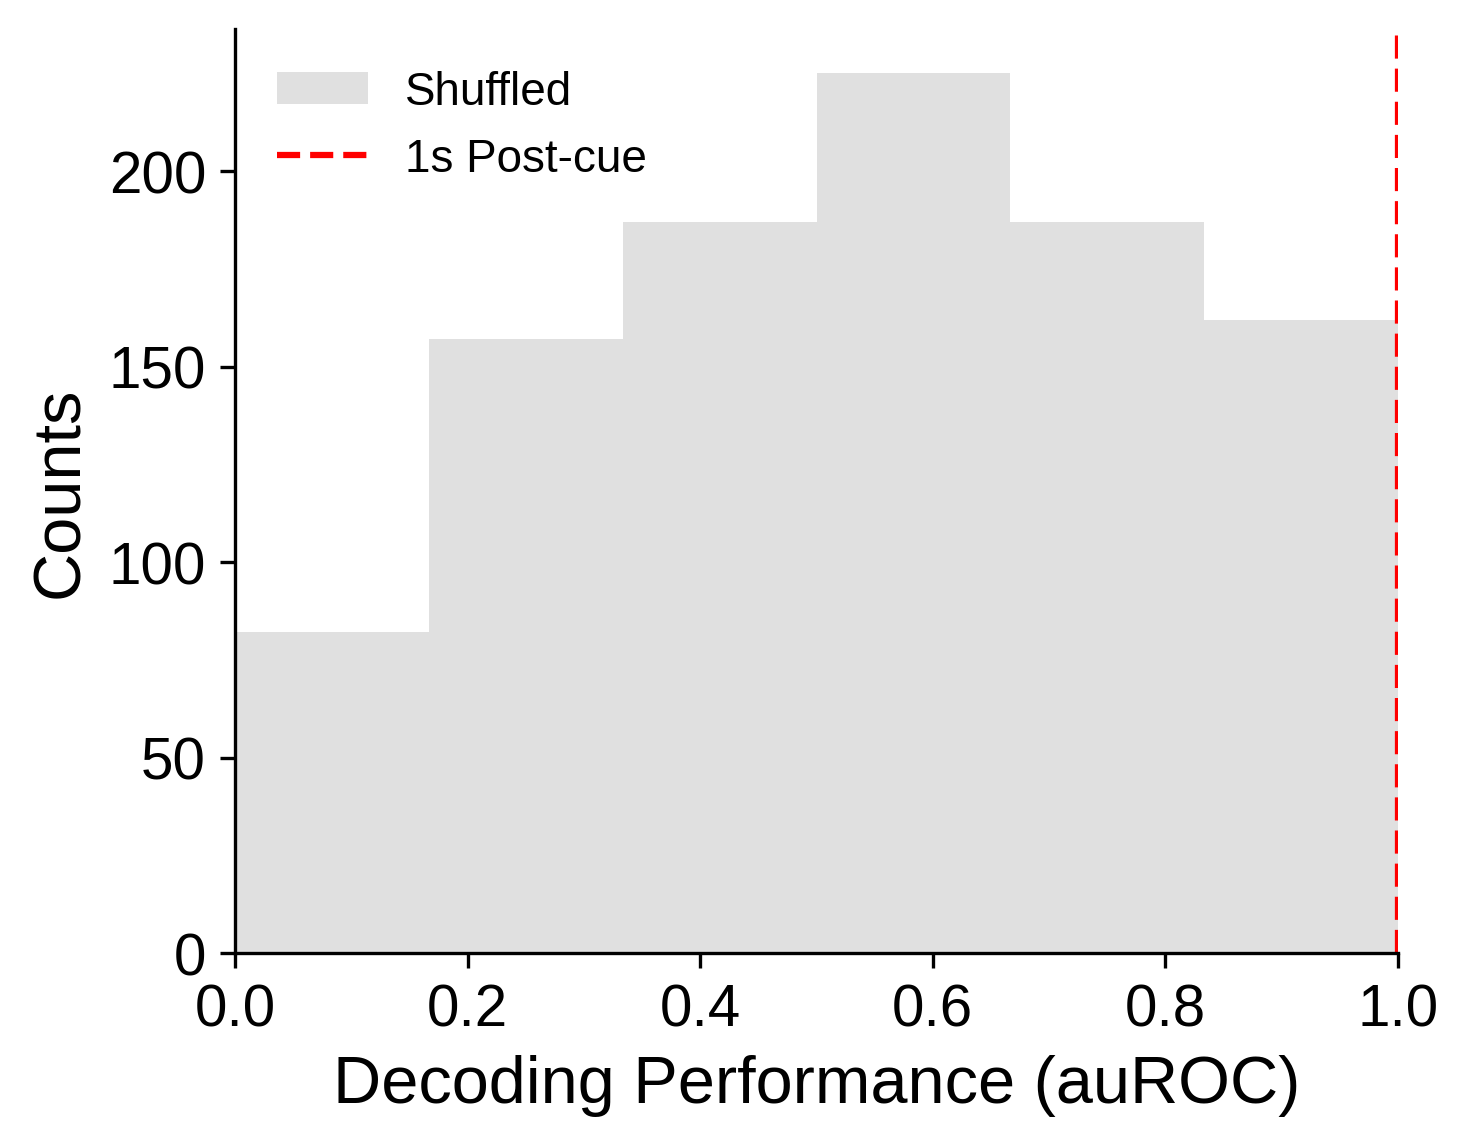

In [375]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=6)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.set_xlim(0,1)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--', label = "1s Post-cue" )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon= False,fontsize =11)

### Multisplit for Cross-Validation

In [376]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Hyperparameter
solver = ['lsqr', 'eigen']
# shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

n_cv = 8
splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results = []
shuffled_auc_results = []

for i in range(n_cv):

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

    # Training process
    LDA_ACC_train = []
    LDA_AUC_train = []
    LDA_ACC_test = []
    LDA_AUC_test = []

    n = len(Hyperparameter_Space2)

    for i in range(0, n):
        # Extract hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[i, :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

        # Model with hyperparameter
        LDA = LinearDiscriminantAnalysis(**Hyperpara)
        LDA.fit(Xtrain, Ytrain)

        # Obtain testing metrics
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)

    # Show training result
    Result_LDA = {'Test_AUC': LDA_AUC_test}
    Result_LDA = pd.DataFrame(Result_LDA)
    Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

    AUC_True = Result_LDA['Test_AUC'].max()
    auc_results.append(AUC_True)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

    # Extract best hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
    Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

        y_pred = clf_shuffle.predict(Xtest)

        accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_pred)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results.append(np.mean(auc_multisplit_shuffle))

auc_results = np.array(auc_results)
shuffled_auc_results = np.array(shuffled_auc_results)
print("AUC Results:", auc_results)
print("Shuffled AUC Results:", shuffled_auc_results)


AUC Results: [0.83333333 1.         1.         0.81944444 0.83333333 1.
 0.75       1.        ]
Shuffled AUC Results: [0.4945     0.4905     0.50866667 0.49916667 0.48716667 0.5035
 0.495      0.5015    ]


In [377]:
from scipy import stats

# Convert lists to numpy arrays
auc_results = np.array(auc_results)
shuffled_auc_results = np.array(shuffled_auc_results)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results, shuffled_auc_results)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results, shuffled_auc_results)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)


not normal
Test statistic: 0.0
p-value: 0.0078125


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


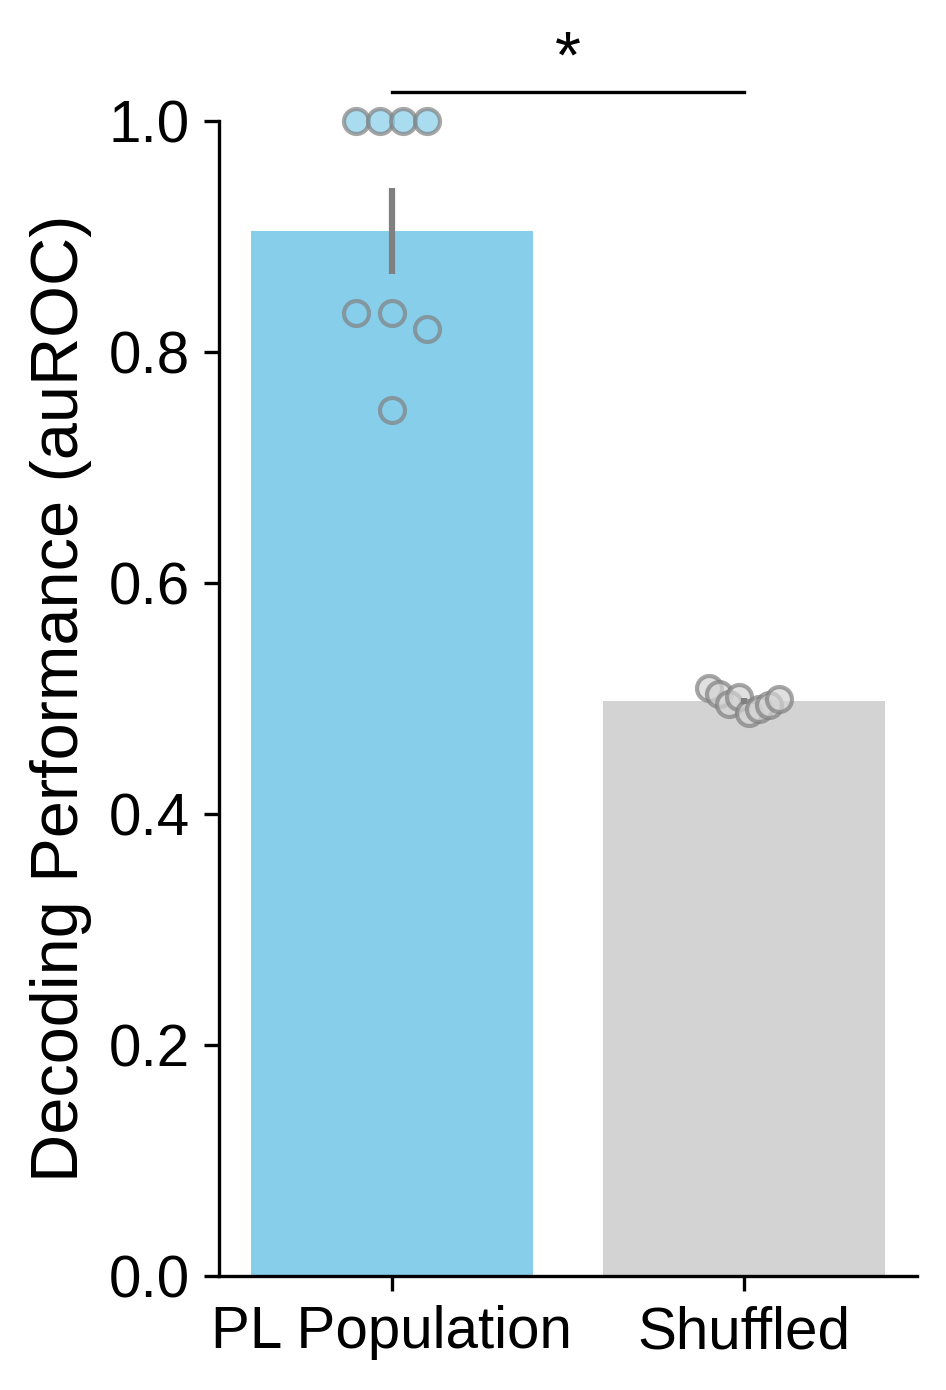

In [378]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results.mean(), yerr=stats.sem(auc_results), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results.mean(), yerr=stats.sem(shuffled_auc_results), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)


## Across animals

In [379]:
animal_ids = np.unique(tracehungry.Animal_ID)

# Hyperparameter
solver = ['lsqr', 'eigen']
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_by_animal = []
shuffled_auc_results_by_animal = []

for i in range(len(animal_ids)):
    
    Data = pd.concat([tracehungry[tracehungry.Animal_ID==animal_ids[i]].iloc[:,2:].T,tracesatiated[tracesatiated.Animal_ID==animal_ids[i]].iloc[:,2:].T], axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:Dt.shape[1]-1]
    Y = Dt.iloc[:, Dt.shape[1]-1]

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=999)
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

    # Training process
    LDA_ACC_train = []
    LDA_AUC_train = []
    LDA_ACC_test = []
    LDA_AUC_test = []

    n = len(Hyperparameter_Space2)

    for i in range(0, n):
        # Extract hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[i, :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

        # Model with hyperparameter
        LDA = LinearDiscriminantAnalysis(**Hyperpara)
        LDA.fit(Xtrain, Ytrain)

        # Obtain testing metrics
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)

    # Show training result
    Result_LDA = {'Test_AUC': LDA_AUC_test}
    Result_LDA = pd.DataFrame(Result_LDA)
    Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

    AUC_True = Result_LDA['Test_AUC'].max()
    auc_results_by_animal.append(AUC_True)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

    # Extract best hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
    Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

        y_pred = clf_shuffle.predict(Xtest)

        accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_pred)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results_by_animal.append(np.mean(auc_multisplit_shuffle))

auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)
print("AUC Results:", auc_results_by_animal)
print("Shuffled AUC Results:", shuffled_auc_results_by_animal)


AUC Results: [0.83333333 0.51388889 0.86111111 1.         0.91666667 1.
 1.         0.90277778 1.         1.         1.         0.83333333
 0.91666667 1.         1.         0.69444444 0.69444444 0.86111111
 1.        ]
Shuffled AUC Results: [0.50025    0.48933333 0.50133333 0.50725    0.49675    0.50158333
 0.5015     0.4995     0.50158333 0.50658333 0.49683333 0.50133333
 0.4925     0.49658333 0.51766667 0.4995     0.4875     0.49075
 0.50441667]


In [380]:
from scipy import stats

# Convert lists to numpy arrays
auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_by_animal)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results_by_animal)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

not normal
Test statistic: 0.0
p-value: 3.814697265625e-06


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


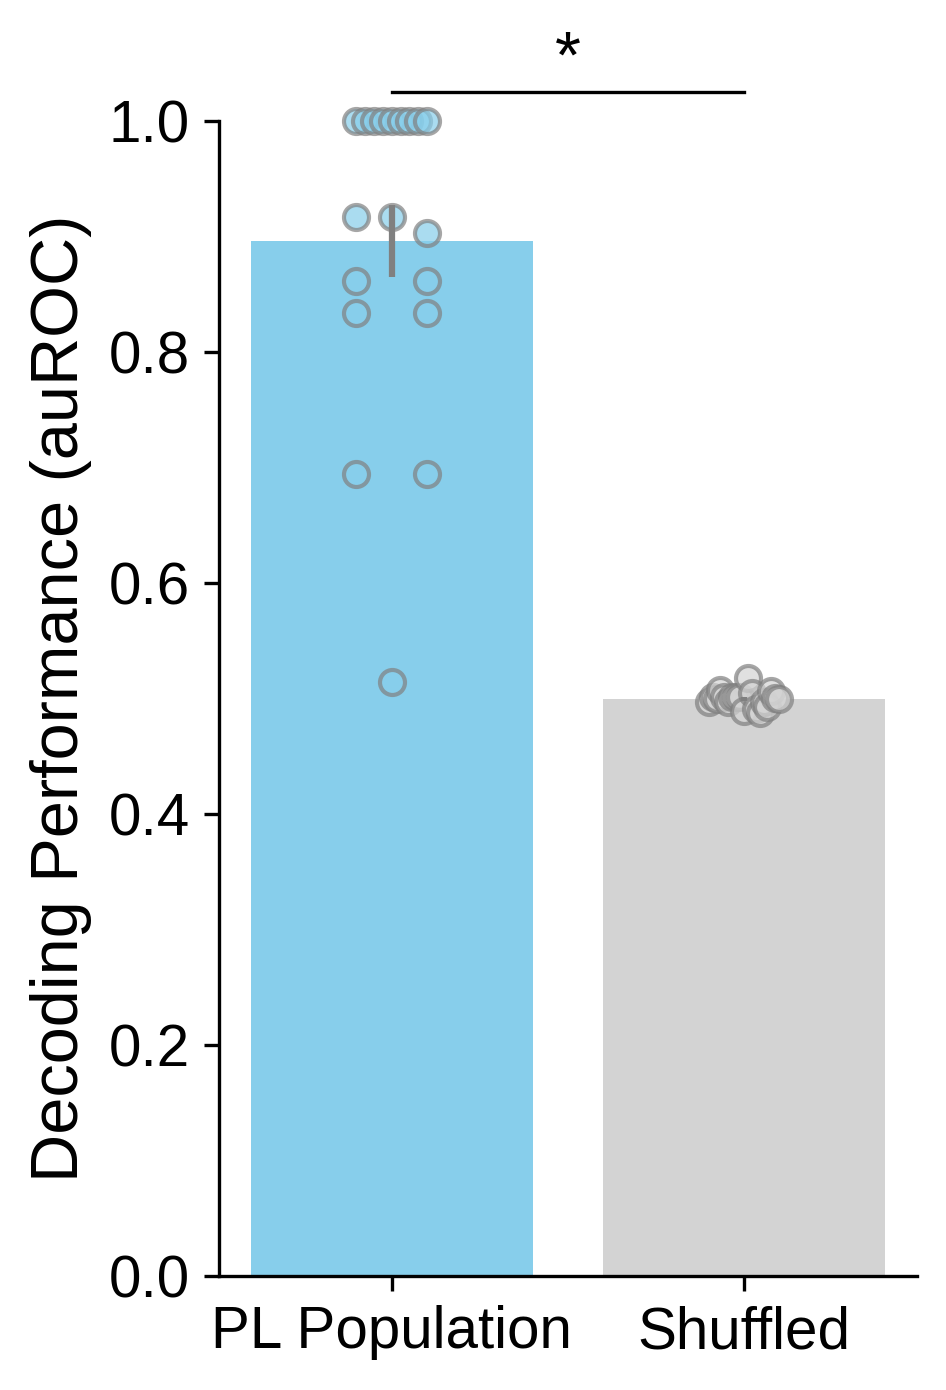

In [381]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal.mean(), yerr=stats.sem(auc_results_by_animal), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results_by_animal.mean(), yerr=stats.sem(shuffled_auc_results_by_animal), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

In [382]:
cluster = pd.read_csv("/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Behavior/satiated_behavior_cluster.csv", index_col = 0)
cluster.rename(columns={"animal_id": "Animal_ID"}, inplace=True)
cluster

Animal_ID Sex  Cluster_Kmeans
0        9M6   F               0
1        7H6   F               1
2        2N6   M               1
3        6H6   F               0
4        2I5   M               0
5        8H6   F               1
6        1H6   F               0
7        6S5   M               1
8        8S5   M               0
9        7M6   F               1
10       6M6   F               1
11       5B6   F               1
12       1S5   M               1
13       2S5   M               0
14       2Z4   M               0
15       4N6   M               0
16       7B6   F               0
17       4B6   F               0
18       1I5   M               0
19       1B6   F               0

In [394]:
# Create DataFrame
cluster_data = pd.DataFrame(cluster).copy()

# Ensure the Animal_ID column is of type string for proper sorting and matching
cluster_data['Animal_ID'] = cluster_data['Animal_ID'].astype(str)

# Sort cluster data by the order of animal_ids
sorted_df = cluster_data.set_index('Animal_ID').loc[animal_ids].reset_index()

sorted_df

Animal_ID Sex  Cluster_Kmeans
0        1B6   F               0
1        1H6   F               0
2        1I5   M               0
3        1S5   M               1
4        2I5   M               0
5        2N6   M               1
6        2S5   M               0
7        2Z4   M               0
8        4B6   F               0
9        4N6   M               0
10       5B6   F               1
11       6H6   F               0
12       6M6   F               1
13       6S5   M               1
14       7B6   F               0
15       7H6   F               1
16       7M6   F               1
17       8H6   F               1
18       9M6   F               0

In [383]:
animal_ids = np.unique(tracehungry.Animal_ID)

# Hyperparameter
solver = ['lsqr', 'eigen']
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_cluster0 = []
shuffled_auc_results_cluster0 = []
auc_results_cluster1 = []
shuffled_auc_results_cluster1 = []

for i in range(len(animal_ids)):
    
    Data = pd.concat([tracehungry[tracehungry.Animal_ID==animal_ids[i]].iloc[:,2:].T,tracesatiated[tracesatiated.Animal_ID==animal_ids[i]].iloc[:,2:].T], axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:Dt.shape[1]-1]
    Y = Dt.iloc[:, Dt.shape[1]-1]

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=999)
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

    # Training process
    LDA_ACC_train = []
    LDA_AUC_train = []
    LDA_ACC_test = []
    LDA_AUC_test = []

    n = len(Hyperparameter_Space2)

    for j in range(0, n):
        # Extract hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[j, :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

        # Model with hyperparameter
        LDA = LinearDiscriminantAnalysis(**Hyperpara)
        LDA.fit(Xtrain, Ytrain)

        # Obtain testing metrics
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)

    # Show training result
    Result_LDA = {'Test_AUC': LDA_AUC_test}
    Result_LDA = pd.DataFrame(Result_LDA)
    Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

    AUC_True = Result_LDA['Test_AUC'].max()
    if cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 0:
        auc_results_cluster0.append(AUC_True)
    elif cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 1:
        auc_results_cluster1.append(AUC_True)
        
    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

    # Extract best hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
    Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(k):
        np.random.seed(k)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

        y_pred = clf_shuffle.predict(Xtest)

        accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_pred)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for j, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[j] = accuracy
            auc_multisplit_shuffle[j] = auc
        if cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 0:
            shuffled_auc_results_cluster0.append(np.mean(auc_multisplit_shuffle))
        elif cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 1:
            shuffled_auc_results_cluster1.append(np.mean(auc_multisplit_shuffle)) 

auc_results_cluster0 = np.array(auc_results_cluster0)
shuffled_auc_results_cluster0 = np.array(shuffled_auc_results_cluster0)
auc_results_cluster1 = np.array(auc_results_cluster1)
shuffled_auc_results_cluster1 = np.array(shuffled_auc_results_cluster1)


print("AUC Results cluster 0:", auc_results_cluster0)
print("Shuffled AUC Results cluster 0:", shuffled_auc_results_cluster0)
print("AUC Results cluster 1:", auc_results_cluster1)
print("Shuffled AUC Results cluster 1:", shuffled_auc_results_cluster1)

AUC Results cluster 0: [0.83333333 0.51388889 0.86111111 0.91666667 1.         0.90277778
 1.         1.         0.83333333 1.         1.        ]
Shuffled AUC Results cluster 0: [0.50025    0.48933333 0.50133333 0.49675    0.5015     0.4995
 0.50158333 0.50658333 0.50133333 0.51766667 0.50441667]
AUC Results cluster 1: [1.         1.         1.         0.91666667 1.         0.69444444
 0.69444444 0.86111111]
Shuffled AUC Results cluster 1: [0.50725    0.50158333 0.49683333 0.4925     0.49658333 0.4995
 0.4875     0.49075   ]


In [384]:
# Hyperparameters
solver = ['lsqr', 'eigen']
shrinkage = ['auto']
splits = 8
nump = 1000
n_cv = 8

# Generate Hyperparameter Matrix
Hyperparameter_Space = [(s, sh) for s in solver for sh in shrinkage]
Hyperparameter_Mat = pd.DataFrame(Hyperparameter_Space, columns=['solver', 'shrinkage'])


def perform_lda(Xtrain, Ytrain, Xtest, Ytest, hyperparameters):
    LDA_AUC_test = []
    for solver, shrinkage in hyperparameters:
        params = {'solver': solver, 'shrinkage': shrinkage}
        LDA = LinearDiscriminantAnalysis(**params)
        LDA.fit(Xtrain, Ytrain)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]
        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)
    return max(LDA_AUC_test)


def shuffle_and_compute_single_run(i, Xtrain, Ytrain, Xtest, Ytest, best_params):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    LDA = LinearDiscriminantAnalysis(**best_params)
    LDA.fit(Xtrain, Ytrain_shuffle)
    y_pred = LDA.predict(Xtest)
    auc = roc_auc_score(Ytest, y_pred)
    return auc

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params, nump):
    with Pool() as pool:
        auc_shuffled = pool.starmap(shuffle_and_compute_single_run, 
                                    [(i, Xtrain, Ytrain, Xtest, Ytest, best_params) for i in range(nump)])
    return np.mean(auc_shuffled)
# Main processing loop
animal_ids = np.unique(tracehungry.Animal_ID)
auc_results_by_animal = []
shuffled_auc_results_by_animal = []

for animal_id in animal_ids:
    # Filter data for the current animal
    Data =  pd.concat([tracehungry[tracehungry.Animal_ID==animal_id].iloc[:,2:].T,
                       tracesatiated[tracesatiated.Animal_ID==animal_id].iloc[:,2:].T], 
                      axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into features and target
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]

    auc_results = []
    shuffled_auc_results = []

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Perform LDA and get the best AUC
        best_auc = perform_lda(Xtrain, Ytrain, Xtest, Ytest, Hyperparameter_Space)
        auc_results.append(best_auc)

        # Find best hyperparameters
        best_params_index = np.argmax(best_auc)
        best_params = Hyperparameter_Space[best_params_index]
        best_params_dict = {'solver': best_params[0], 'shrinkage': best_params[1]}

        # Shuffle and compute AUC
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params_dict, nump)
        shuffled_auc_results.append(shuffled_auc)

    for train_index, test_index in skf.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Perform LDA and get the best AUC
        best_auc = perform_lda(Xtrain, Ytrain, Xtest, Ytest, Hyperparameter_Space)
        auc_results.append(best_auc)

        # Find best hyperparameters
        best_params_index = np.argmax(best_auc)
        best_params = Hyperparameter_Space[best_params_index]
        best_params_dict = {'solver': best_params[0], 'shrinkage': best_params[1]}

        # Shuffle and compute AUC
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params_dict, nump)
        shuffled_auc_results.append(shuffled_auc)

    # Calculate average AUCs
    auc_results_by_animal.append(np.mean(auc_results))
    shuffled_auc_results_by_animal.append(np.mean(shuffled_auc_results))

# Output the results
print("AUC Results by Animal:", auc_results_by_animal)
print("Shuffled AUC Results by Animal:", shuffled_auc_results_by_animal)


AUC Results by Animal: [1.0, 0.84375, 0.8125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.875, 0.8125, 0.75, 1.0]
Shuffled AUC Results by Animal: [0.49234375, 0.50034375, 0.4895625, 0.49396874999999996, 0.50271875, 0.49075, 0.48784375, 0.48350000000000004, 0.49615624999999997, 0.49206249999999996, 0.48634374999999996, 0.49606249999999996, 0.48903125000000003, 0.48665625, 0.485875, 0.49265625, 0.501, 0.50853125, 0.48878125]


In [385]:
from scipy import stats

# Convert lists to numpy arrays
auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_by_animal)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results_by_animal)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

not normal
Test statistic: 0.0
p-value: 3.814697265625e-06


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


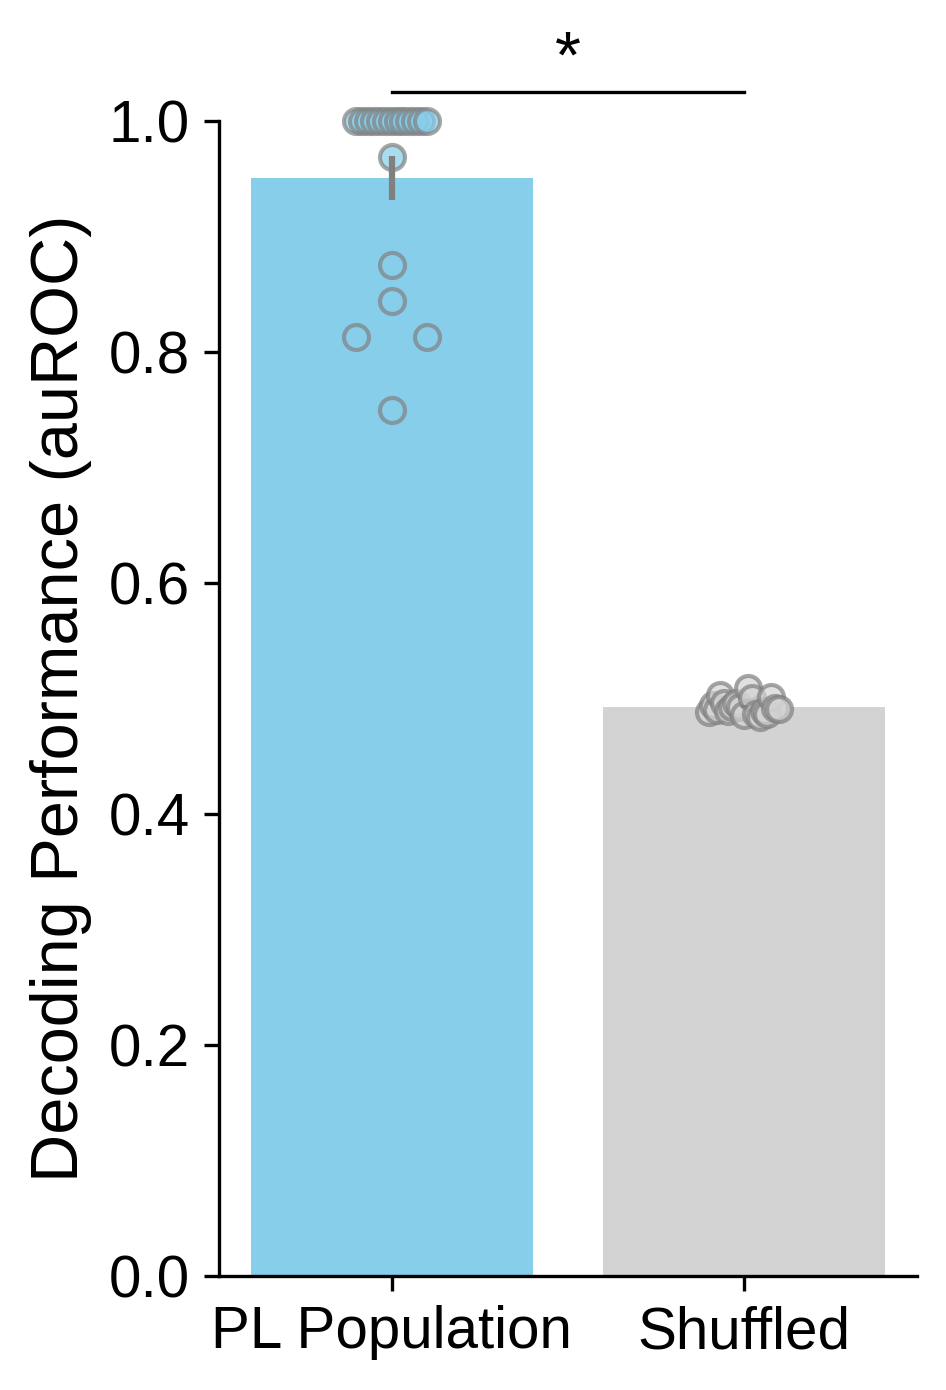

In [386]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal.mean(), yerr=stats.sem(auc_results_by_animal), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results_by_animal.mean(), yerr=stats.sem(shuffled_auc_results_by_animal), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

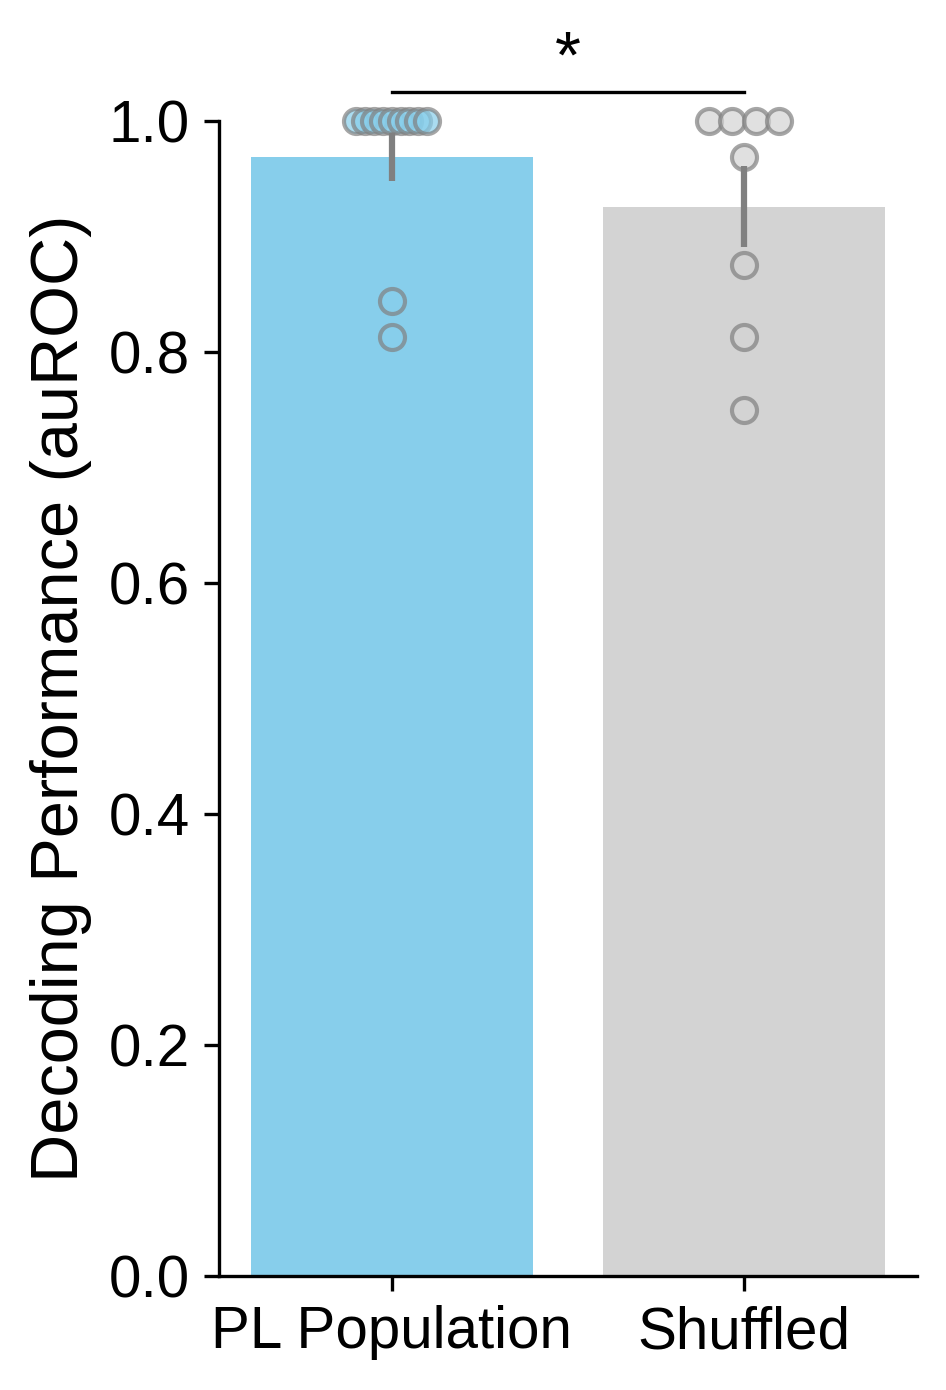

In [402]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal[sorted_df.Cluster_Kmeans ==0].mean(), yerr=stats.sem(auc_results_by_animal[sorted_df.Cluster_Kmeans ==0]), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,auc_results_by_animal[sorted_df.Cluster_Kmeans ==1].mean(), yerr=stats.sem(auc_results_by_animal[sorted_df.Cluster_Kmeans ==1]), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal[sorted_df.Cluster_Kmeans ==0], 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(auc_results_by_animal[sorted_df.Cluster_Kmeans ==1], 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

In [399]:
auc_results_by_animal[sorted_df.Cluster_Kmeans ==0]

array([1.     , 0.84375, 0.8125 , 1.     , 1.     , 1.     , 1.     ,
       1.     , 1.     , 1.     , 1.     ])

In [398]:
auc_results_by_animal[sorted_df.Cluster_Kmeans ==1]

array([1.     , 1.     , 1.     , 0.96875, 1.     , 0.875  , 0.8125 ,
       0.75   ])

In [400]:
stats.ttest_ind(auc_results_by_animal[sorted_df.Cluster_Kmeans ==0], auc_results_by_animal[sorted_df.Cluster_Kmeans ==1])

Ttest_indResult(statistic=1.10518346862647, pvalue=0.28447669738764536)

In [403]:
def calculate_10s_before_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]

    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]-int(10*FR):cueonset[i]-int(9*FR)].mean(axis=1)


    return tracenew

In [404]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_10s_before_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_hungry_list.append(tracenew)

# Concatenate all dataframes in the list
tracehungry = pd.concat(trace_hungry_list, ignore_index=True)
tracehungry

Animal_ID cell_id         0         1             2             3  \
0          6S5       1  0.048369  0.001061  6.293706e-04  4.754847e-03   
1          6S5       2  0.120557  0.044883  1.922976e-02  4.761108e-02   
2          6S5       3  0.084786  0.095479  1.183699e-01  4.081155e-02   
3          6S5       4  0.082728  0.024669  1.074167e-03  5.815137e-09   
4          6S5       5  0.168868  0.106921  9.683688e-02  1.056127e-01   
...        ...     ...       ...       ...           ...           ...   
1106       8H6      63  0.000000  0.000000  0.000000e+00  0.000000e+00   
1107       8H6      71  0.005838  0.024493  3.388954e-07  5.108056e-03   
1108       8H6      73  0.000000  0.000000  9.293211e-08  0.000000e+00   
1109       8H6      75  0.092593  0.000000  0.000000e+00  0.000000e+00   
1110       8H6      97  0.000000  0.000000  0.000000e+00  0.000000e+00   

             4         5         6             7         8         9  \
0     0.103309  0.000263  0.013824  7.612485e-03  0.000421  0.175978   
1     0.034988  0.054711  0.054270  5.247681e-02  0.025143  0.058178   
2     0.056383  0.034321  0.025731  3.972389e-02  0.043854  0.184181   
3     0.000000  0.000000  0.000000  0.000000e+00  0.000100  0.000183   
4     0.086763  0.047563  0.065912  2.608401e-01  0.064510  0.585718   
...        ...       ...       ...           ...       ...       ...   
1106  0.000000  0.020129  0.097894  1.671271e-03  0.000000  0.000000   
1107  0.014811  0.156396  0.001965  8.817055e-03  0.034506  0.000042   
1108  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
1109  0.000000  0.000000  0.000000  3.252217e-09  0.000000  0.000000   
1110  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000   

            10            11  
0     0.006649  1.984136e-02  
1     0.026894  4.644408e-02  
2     0.025663  3.829917e-02  
3     0.002579  1.367758e-08  
4     0.022322  4.802882e-02  
...        ...           ...  
1106  0.000000  2.593177e-02  
1107  0.000190  2.091156e-07  
1108  0.000000  0.000000e+00  
1109  0.000000  0.000000e+00  
1110  0.000000  0.000000e+00  

[1111 rows x 14 columns]

In [405]:
trace_hungry_trial_mean

1    2    3         4         5         6         7         8  \
0     0.0  0.0  0.0  0.000336  0.121736  0.110322  0.003819  0.014012   
1     0.0  0.0  0.0  0.086355  0.050705  0.066181  0.040792  0.048071   
2     0.0  0.0  0.0  0.026224  0.036156  0.033223  0.037047  0.037546   
3     0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.0  0.0  0.0  0.047766  0.035803  0.069082  0.043354  0.063842   
...   ...  ...  ...       ...       ...       ...       ...       ...   
1106  0.0  0.0  0.0  0.000000  0.000000  0.000526  0.178366  0.000294   
1107  0.0  0.0  0.0  0.022463  0.017551  0.005657  0.000173  0.001810   
1108  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1109  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1110  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

             9        10   11   12  
0     0.067880  0.119009  0.0  0.0  
1     0.015860  0.039367  0.0  0.0  
2     0.039885  0.123235  0.0  0.0  
3     0.000059  0.000125  0.0  0.0  
4     0.345263  0.400309  0.0  0.0  
...        ...       ...  ...  ...  
1106  0.000000  0.000000  0.0  0.0  
1107  0.017289  0.000029  0.0  0.0  
1108  0.000000  0.000000  0.0  0.0  
1109  0.000000  0.000000  0.0  0.0  
1110  0.000000  0.000000  0.0  0.0  

[1111 rows x 12 columns]

In [406]:
hungry_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([True])
    dff["dff"]= [np.array(tracehungry[i].values)]
    
    hungry_trace =  pd.concat([hungry_trace,dff],axis=0) 

In [407]:
hungry_trace

is_hungry                                                dff
0       True  [0.04836919777724258, 0.12055745919901151, 0.0...
0       True  [0.0010614449131696117, 0.04488324888337381, 0...
0       True  [0.0006293705566143285, 0.019229762952048576, ...
0       True  [0.00475484736034052, 0.04761108305172194, 0.0...
0       True  [0.10330940656559781, 0.034987923881283536, 0....
0       True  [0.0002633224544661741, 0.054711158346264124, ...
0       True  [0.013823938075309267, 0.054270248594222824, 0...
0       True  [0.007612484860309307, 0.05247680813086647, 0....
0       True  [0.0004211868794840614, 0.025143294162813506, ...
0       True  [0.17597787123704778, 0.058178226778389776, 0....
0       True  [0.006649159321108838, 0.02689398948033648, 0....
0       True  [0.019841360139294613, 0.04644407622123938, 0....

In [408]:

# Create a list to hold the dataframes
trace_satiated_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_10s_before_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_satiated_list.append(tracenew)

# Concatenate all dataframes in the list
tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
tracesatiated

Animal_ID cell_id         0         1         2         3             4  \
0          6S5       1  0.303257  0.501423  0.254067  0.180384  2.543539e-01   
1          6S5       2  0.008873  0.044171  0.043809  0.055729  4.445308e-03   
2          6S5       3  0.043554  0.045785  0.075948  0.050295  5.884284e-02   
3          6S5       4  0.000000  0.022174  0.200893  0.020836  2.449700e-02   
4          6S5       5  0.018607  0.053367  0.050013  0.035196  2.278694e-03   
...        ...     ...       ...       ...       ...       ...           ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.102780  6.293812e-03   
1107       8H6      71  0.000000  0.000000  0.000000  0.050997  5.750741e-09   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000e+00   
1109       8H6      75  0.000000  0.000000  0.000000  0.001030  0.000000e+00   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000e+00   

             5             6         7             8         9        10  \
0     0.291572  2.650622e-01  0.279096  7.462823e-01  0.334861  0.190832   
1     0.004967  1.993337e-02  0.024013  1.394270e-02  0.058447  0.035706   
2     0.040782  8.406165e-02  0.025936  7.019172e-02  0.022337  0.064834   
3     0.004889  4.265301e-01  0.047563  4.281136e-02  0.009377  0.032870   
4     0.009363  1.180143e-03  0.134886  2.170119e-03  0.183636  0.010430   
...        ...           ...       ...           ...       ...       ...   
1106  0.158620  3.871100e-09  0.187920  6.409525e-07  0.000000  0.000000   
1107  0.000000  0.000000e+00  0.000000  1.216288e-06  0.000000  0.000000   
1108  0.000000  0.000000e+00  0.000000  0.000000e+00  0.016609  0.000275   
1109  0.000000  8.735914e-09  0.013118  0.000000e+00  0.000000  0.000000   
1110  0.032423  0.000000e+00  0.000000  1.034810e-08  0.000062  0.000000   

            11  
0     0.365645  
1     0.020934  
2     0.039463  
3     0.107241  
4     0.038192  
...        ...  
1106  0.000000  
1107  0.000000  
1108  0.000000  
1109  0.000000  
1110  0.000000  

[1111 rows x 14 columns]

In [409]:
satiated_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([False])
    dff["dff"]= [np.array(tracesatiated[i].values)]
    
    satiated_trace = pd.concat([satiated_trace,dff],axis=0) 

### LDA

In [410]:
trace_combined =  pd.concat([hungry_trace,satiated_trace],axis=0,ignore_index=True) 

In [411]:
Data = pd.concat([tracehungry.iloc[:,2:].T,tracesatiated.iloc[:,2:].T], axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [412]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6     \
0  -0.712753  3.391505  0.735635  0.424369  0.638034  0.157854  2.327542   
1  -0.966540  0.269601  1.037603 -0.208424  0.126289  0.097854  1.512022   
2  -0.968858 -0.788722  1.683990 -0.465593  0.042982  0.010753  1.272273   
3  -0.946726  0.382136 -0.506114 -0.477300  0.115478 -0.275675  0.960538   
4  -0.418020 -0.138626 -0.066415 -0.477301 -0.040239 -0.639400 -0.012292   
5  -0.970822  0.675047 -0.689406 -0.477301 -0.364068 -0.067675  0.419399   
6  -0.898074  0.656857 -0.931960 -0.477301 -0.212485  0.545094  0.309087   
7  -0.931396  0.582870 -0.536828 -0.477301  1.397811 -0.067714  0.921094   
8  -0.969975 -0.544762 -0.420213 -0.476206 -0.224071 -0.071933 -0.367926   
9  -0.028182  0.818079  3.542376 -0.475303  4.081629  0.654233  0.259838   
10 -0.936564 -0.472538 -0.933876 -0.449187 -0.572583 -0.329129  0.094197   
11 -0.865793  0.333992 -0.577059 -0.477300 -0.360222 -0.081257  0.201192   
12  0.654620 -1.215982 -0.428662 -0.477301 -0.603279 -0.693246  0.331100   
13  1.717701  0.240210 -0.365674 -0.235621 -0.316124  0.119875  0.328599   
14  0.390735  0.225266  0.486070  1.712271 -0.343834 -0.160686 -0.752338   
15 -0.004544  0.717025 -0.238333 -0.250206 -0.466237  0.559079  0.973451   
16  0.392275 -1.398647  0.003056 -0.210304 -0.738163 -1.058007 -1.049914   
17  0.591936 -1.377112 -0.506960 -0.424016 -0.679644 -0.740070 -1.477131   
18  0.449721 -0.759695  0.715188  4.171524 -0.747238 -1.154377 -1.449923   
19  0.525006 -0.591401 -0.926171  0.041095  0.357306  0.000510 -1.221309   
20  3.031278 -1.006837  0.323527 -0.010692 -0.739060 -0.949560 -1.306158   
21  0.824165  0.829150 -1.027795 -0.375099  0.760027  3.958945 -0.295834   
22  0.051506 -0.109000  0.172228 -0.119045 -0.670822 -0.956827 -0.877779   
23  0.989307 -0.718415 -0.544205  0.691540 -0.441486  1.141361 -1.099728   

        7         8         9     ...      1101      1102      1103      1104  \
0   3.601751  0.162033  1.312344  ... -0.398062 -0.208514 -0.326087 -0.275662   
1   1.455916 -0.322484  0.844179  ... -0.398062 -0.208514 -0.322777 -0.275662   
2   1.711108  0.133899  0.731647  ... -0.398062 -0.208514  3.988447  4.435634   
3  -0.887039 -0.256185 -0.100222  ... -0.398062 -0.208514 -0.326083 -0.275662   
4  -0.515087 -0.432277 -0.517209  ... -0.398062 -0.208514  0.408531 -0.275662   
5  -0.532308 -0.431823  0.278299  ... -0.398062 -0.208514 -0.326087 -0.275662   
6  -0.792927 -0.430889  0.373011  ... -0.398062 -0.208514 -0.326087 -0.275662   
7  -0.898958 -0.421857 -0.429869  ... -0.398062 -0.208514 -0.325774 -0.275662   
8  -0.531115 -0.432788  0.585092  ... -0.398062  4.795832 -0.275301 -0.275662   
9  -0.573733 -0.232878 -0.881465  ... -0.398062 -0.208514 -0.326087 -0.275662   
10 -0.826357 -0.401807  0.622904  ... -0.398062 -0.208514 -0.323677 -0.275662   
11  0.675517 -0.399958  0.156470  ... -0.398062 -0.208514 -0.326087 -0.275662   
12 -0.606933 -0.422717 -0.550012  ... -0.398062 -0.208514 -0.326087 -0.275662   
13 -0.625845 -0.426349 -0.844638  ... -0.398062 -0.208514 -0.326087 -0.275662   
14  0.546313  0.286718 -0.984934  ... -0.384207 -0.208514 -0.326087 -0.275662   
15 -0.075309  0.852302  2.046396  ... -0.398062 -0.208514 -0.326087 -0.275662   
16  0.061628 -0.400368 -0.870756  ... -0.398062 -0.208514 -0.326043 -0.275662   
17  0.064022  4.511045 -1.011053  ...  1.059498 -0.208514 -0.326087 -0.275662   
18 -0.298595 -0.314470 -0.086421  ...  1.083512 -0.208514 -0.326087 -0.275662   
19 -0.247645 -0.238139 -0.960203  ...  1.745462 -0.208514 -0.326087 -0.275662   
20  0.064110 -0.292270 -0.689923  ... -0.396591 -0.208514  2.393201  1.628922   
21 -0.268368  0.573367  2.792271  ... -0.387737 -0.208514 -0.326085 -0.275662   
22 -0.121173 -0.235126 -0.824651  ...  3.946853 -0.208514 -0.325302 -0.275650   
23 -0.378972 -0.426978 -0.991259  ... -0.297791 -0.208514 -0.326087 -0.275662   

        1105      1106      1107      1108      1109      1110  
0   4.795831 -0.

In [413]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [414]:
Data

0         1         2         3         4         5         6  \
0  -0.712753  3.391505  0.735635  0.424369  0.638034  0.157854  2.327542   
1  -0.966540  0.269601  1.037603 -0.208424  0.126289  0.097854  1.512022   
2  -0.968858 -0.788722  1.683990 -0.465593  0.042982  0.010753  1.272273   
3  -0.946726  0.382136 -0.506114 -0.477300  0.115478 -0.275675  0.960538   
4  -0.418020 -0.138626 -0.066415 -0.477301 -0.040239 -0.639400 -0.012292   
5  -0.970822  0.675047 -0.689406 -0.477301 -0.364068 -0.067675  0.419399   
6  -0.898074  0.656857 -0.931960 -0.477301 -0.212485  0.545094  0.309087   
7  -0.931396  0.582870 -0.536828 -0.477301  1.397811 -0.067714  0.921094   
8  -0.969975 -0.544762 -0.420213 -0.476206 -0.224071 -0.071933 -0.367926   
9  -0.028182  0.818079  3.542376 -0.475303  4.081629  0.654233  0.259838   
10 -0.936564 -0.472538 -0.933876 -0.449187 -0.572583 -0.329129  0.094197   
11 -0.865793  0.333992 -0.577059 -0.477300 -0.360222 -0.081257  0.201192   
12  0.654620 -1.215982 -0.428662 -0.477301 -0.603279 -0.693246  0.331100   
13  1.717701  0.240210 -0.365674 -0.235621 -0.316124  0.119875  0.328599   
14  0.390735  0.225266  0.486070  1.712271 -0.343834 -0.160686 -0.752338   
15 -0.004544  0.717025 -0.238333 -0.250206 -0.466237  0.559079  0.973451   
16  0.392275 -1.398647  0.003056 -0.210304 -0.738163 -1.058007 -1.049914   
17  0.591936 -1.377112 -0.506960 -0.424016 -0.679644 -0.740070 -1.477131   
18  0.449721 -0.759695  0.715188  4.171524 -0.747238 -1.154377 -1.449923   
19  0.525006 -0.591401 -0.926171  0.041095  0.357306  0.000510 -1.221309   
20  3.031278 -1.006837  0.323527 -0.010692 -0.739060 -0.949560 -1.306158   
21  0.824165  0.829150 -1.027795 -0.375099  0.760027  3.958945 -0.295834   
22  0.051506 -0.109000  0.172228 -0.119045 -0.670822 -0.956827 -0.877779   
23  0.989307 -0.718415 -0.544205  0.691540 -0.441486  1.141361 -1.099728   

           7         8         9  ...      1102      1103      1104      1105  \
0   3.601751  0.162033  1.312344  ... -0.208514 -0.326087 -0.275662  4.795831   
1   1.455916 -0.322484  0.844179  ... -0.208514 -0.322777 -0.275662 -0.208589   
2   1.711108  0.133899  0.731647  ... -0.208514  3.988447  4.435634 -0.208614   
3  -0.887039 -0.256185 -0.100222  ... -0.208514 -0.326083 -0.275662 -0.208616   
4  -0.515087 -0.432277 -0.517209  ... -0.208514  0.408531 -0.275662 -0.208608   
5  -0.532308 -0.431823  0.278299  ... -0.208514 -0.326087 -0.275662 -0.208616   
6  -0.792927 -0.430889  0.373011  ... -0.208514 -0.326087 -0.275662 -0.208616   
7  -0.898958 -0.421857 -0.429869  ... -0.208514 -0.325774 -0.275662 -0.208602   
8  -0.531115 -0.432788  0.585092  ...  4.795832 -0.275301 -0.275662 -0.208607   
9  -0.573733 -0.232878 -0.881465  ... -0.208514 -0.326087 -0.275662 -0.208616   
10 -0.826357 -0.401807  0.622904  ... -0.208514 -0.323677 -0.275662 -0.208610   
11  0.675517 -0.399958  0.156470  ... -0.208514 -0.326087 -0.275662 -0.208616   
12 -0.606933 -0.422717 -0.550012  ... -0.208514 -0.326087 -0.275662 -0.208616   
13 -0.625845 -0.426349 -0.844638  ... -0.208514 -0.326087 -0.275662 -0.208616   
14  0.546313  0.286718 -0.984934  ... -0.208514 -0.326087 -0.275662 -0.208616   
15 -0.075309  0.852302  2.046396  ... -0.208514 -0.326087 -0.275662 -0.208616   
16  0.061628 -0.400368 -0.870756  ... -0.208514 -0.326043 -0.275662 -0.206342   
17  0.064022  4.511045 -1.011053  ... -0.208514 -0.326087 -0.275662 -0.208616   
18 -0.298595 -0.314470 -0.086421  ... -0.208514 -0.326087 -0.275662 -0.208616   
19 -0.247645 -0.238139 -0.960203  ... -0.208514 -0.326087 -0.275662 -0.208616   
20  0.064110 -0.292270 -0.689923  ... -0.208514  2.393201  1.628922 -0.208616   
21 -0.268368  0.573367  2.792271  ... -0.208514 -0.326085 -0.275662 -0.208616   
22 -0.121173 -0.235126 -0.824651  ... -0.208514 -0.325302 -0.275650 -0.208616   
23 -0.378972 -0.426978 -0.991259  ... -0.208514 -0.326087 -0.275662 -0.208616   

        1106      1107      1108      1109      1110  Label  
0  -0.475278 -0.208909

In [415]:
#Data.to_csv("Calcium Dataset reorganized.csv")

In [416]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Stratified train-test-split
sss = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
for train_index, test_index in sss.split(X, Y):
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

# Training set
Xtrain = Train.iloc[:, 0:Dt.shape[1]-1] 
Ytrain = Train.iloc[:,Dt.shape[1]-1]

# Testing set
Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
Ytest = Test.iloc[:, Dt.shape[1]-1]

print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


In [426]:
# Hyperparameter
solver = ['lsqr', 'eigen']
# shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

# Training process
LDA_ACC_train = []
LDA_AUC_train = []
LDA_ACC_test = []
LDA_AUC_test = []

n = len(Hyperparameter_Space2)

for i in range(0, n):
    # Extract hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[i, :]
    Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
    # Model with hyperparameter
    LDA = LinearDiscriminantAnalysis(**Hyperpara)
    LDA.fit(Xtrain, Ytrain)
    
    # Obtain training metrics
    y_train_pred = LDA.predict(Xtrain)
    y_train_score = LDA.predict_proba(Xtrain)[:, 1]
    
    train_acc = accuracy_score(Ytrain, y_train_pred)
    train_auc = roc_auc_score(Ytrain, y_train_score)
    
    LDA_ACC_train.append(train_acc)
    LDA_AUC_train.append(train_auc)
    
    # Obtain testing metrics
    y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]
    
    test_acc = accuracy_score(Ytest, y_test_pred)
    test_auc = roc_auc_score(Ytest, y_test_score)
    
    LDA_ACC_test.append(test_acc)
    LDA_AUC_test.append(test_auc)
    
# Show training result
Result_LDA = {'Train_Accuracy': LDA_ACC_train,
          'Train_AUC': LDA_AUC_train,
          'Test_Accuracy': LDA_ACC_test,
          'Test_AUC': LDA_AUC_test}
Result_LDA = pd.DataFrame(Result_LDA)
Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)
Result_LDA

solver shrinkage  Train_Accuracy  Train_AUC  Test_Accuracy  Test_AUC
0   lsqr      auto             1.0        1.0           0.75  0.833333
1  eigen      auto             1.0        1.0           0.75  0.833333

In [427]:
random.seed = 999
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}

def process(i):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    
    # Model with hyperparameter
    LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
    clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
    
    y_pred = clf_shuffle.predict(Xtest)
    
    accuracy = accuracy_score(Ytest, y_pred)
    auc = roc_auc_score(Ytest, y_pred)
    
    return accuracy, auc

if __name__ == "__main__":
    with Pool(cpu_count()) as p:
        results = p.map(process, range(nump))

    for i, result in enumerate(results):
        accuracy_multisplit_shuffle[i], auc_multisplit_shuffle[i] = result


In [428]:
AUC_True = Result_LDA["Test_AUC"].max()
AUC_True

0.8333333333333333

In [429]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

0.031

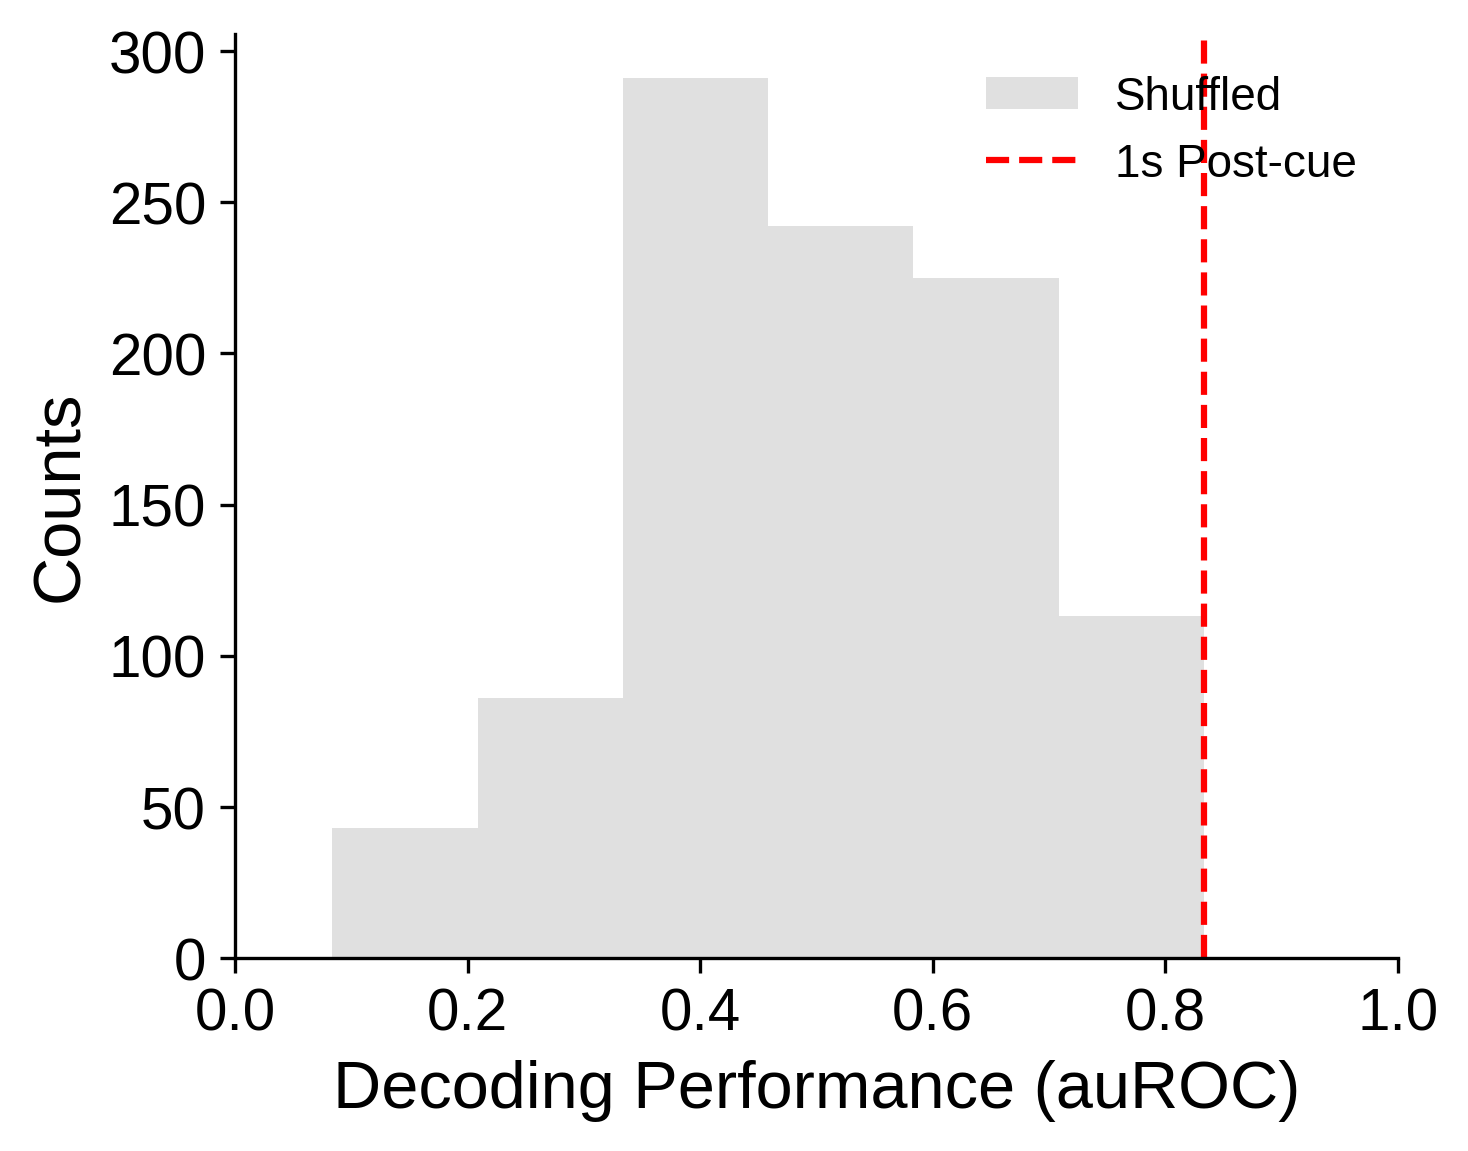

In [430]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=6)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.set_xlim(0,1)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--', label = "1s Post-cue" )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon= False,fontsize =11)

## Across time

In [451]:
%%time

n_cv = 3
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 10

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

# Initialize arrays to store the results
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}


def calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
            
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        start_frame = cueonset[i] + int(time_bin * FR)
        end_frame = start_frame + int(BinSizeAC* FR)  # bin
        tracenew.iloc[:,i] = trace.iloc[:, start_frame:end_frame].mean(axis=1)
        
    return tracenew

# Define the main processing function for each time bin
def process_time_bin(time_bin):

    # Create a list to hold the dataframes
    trace_hungry_list = []
    trace_satiated_list = []
    
    # Loop through each animal's DataFrame
    for df in all_dataframes:
        tracenew_hungry = calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
        tracenew_satiated = calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before,  cue_range=satiatedcue)

        trace_hungry_list.append(tracenew_hungry)
        trace_satiated_list.append(tracenew_satiated)
    # Concatenate all dataframes in the list
    tracehungry = pd.concat(trace_hungry_list, ignore_index=True)

    # Concatenate all dataframes in the list
    tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
    

    # Combine the data from the two conditions
    Data = pd.concat([tracehungry.T,tracesatiated.T], axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:(Data.shape[1]-1)]
    Y = Dt.iloc[:, (Data.shape[1]-1)]

    # Set the seed for the random number generator
    np.random.seed(42)

    # Generate random states for each fold
    random_states = np.random.randint(0, 10000, size=n_cv)

    auc_results = []
    shuffled_auc_results = []

    for i in range(n_cv):
        sss = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_states[i])
        for train_index, test_index in sss.split(X, Y):
            Train = Dt.iloc[train_index,:]
            Test = Dt.iloc[test_index,:]

        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

        # Training set
        Xtrain = Train.iloc[:, 0:(Data.shape[1]-1)]
        Ytrain = Train.iloc[:,(Data.shape[1]-1)]

        # Testing set
        Xtest = Test.iloc[:, 0:(Data.shape[1]-1)]
        Ytest = Test.iloc[:, (Data.shape[1]-1)]
        
        # Check for NaN values before fitting the model
        if np.isnan(Xtrain).any().any() or np.isnan(Xtest).any().any():
            print(f'NaN values found in Xtrain or Xtest for time_bin: {time_bin}')
    
            # Create an imputer object that will replace NaN values with the mean value of the column
            imputerTrian = SimpleImputer(strategy='mean')
            imputerTtest = SimpleImputer(strategy='mean')
    
            # Fit on the training data
            imputerTrian.fit(Xtrain)
            imputerTtest.fit(Xtest)
            
            # Transform and replace the training and test data
            Xtrain = imputerTrian.transform(Xtrain) 
            Xtest = imputerTtest.transform(Xtest)
    
            
            # Transform and replace the training and test data
            Xtrain = imputerTrian.transform(Xtrain)
            Xtest = imputerTtest.transform(Xtest)

#         # Training process
#         LDA_ACC_train = []
#         LDA_AUC_train = []
#         LDA_ACC_test = []
#         LDA_AUC_test = []

#         n = len(Hyperparameter_Space2)

#         for i in range(0, n):
#             # Extract hyperparameter
#             Hyper_i = Hyperparameter_Mat2.iloc[i, :]
#             Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

#             # Model with hyperparameter
#             LDA = LinearDiscriminantAnalysis(**Hyperpara)
            
            
#             LDA.fit(Xtrain, Ytrain)

#             # Obtain testing metrics
#             y_test_pred = LDA.predict(Xtest)
#             y_test_score = LDA.predict_proba(Xtest)[:, 1]

#             test_auc = roc_auc_score(Ytest, y_test_score)
#             LDA_AUC_test.append(test_auc)

#         # Show training result
#         Result_LDA = {'Test_AUC': LDA_AUC_test}
#         Result_LDA = pd.DataFrame(Result_LDA)
#         Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis=1)

        LDA_best = LinearDiscriminantAnalysis(**Hyperpara_1s)
        LDA.fit(Xtrain, Ytrain)
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        
        auc_results.append(test_auc)

        accuracy_multisplit_shuffle = np.zeros(nump)
        auc_multisplit_shuffle= np.zeros(nump)

        for i in range(nump):
            np.random.seed(i)
            Ytrain_shuffle = np.random.permutation(Ytrain)

            # Model with hyperparameter
            LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
            clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
            y_test_proba = clf_shuffle.predict_proba(Xtest)[:, 1]  # Use predict_proba


            auc = roc_auc_score(Ytest, y_test_proba)

#             accuracy = accuracy_score(Ytest, y_pred)

#             accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results.append(np.mean(auc_multisplit_shuffle))

       

    return np.array(auc_results), np.array(shuffled_auc_results)

# Using concurrent.futures to parallelize processing for each time_bin
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Map the function across time_bins
    results = list(executor.map(process_time_bin, time_bins))

# Extract results from futures and store them in auc_results_all and shuffled_auc_results_all
for i, (auc_results, shuffled_auc_results) in enumerate(results):
    auc_results_all[i] = np.array(auc_results)
    shuffled_auc_results_all[i] = np.array(shuffled_auc_results)

CPU times: user 72.1 ms, sys: 442 ms, total: 514 ms
Wall time: 19min 34s


In [452]:
np.isnan(Ytest).any().any()

False

In [453]:
Ytrain.isna().any().any()

False

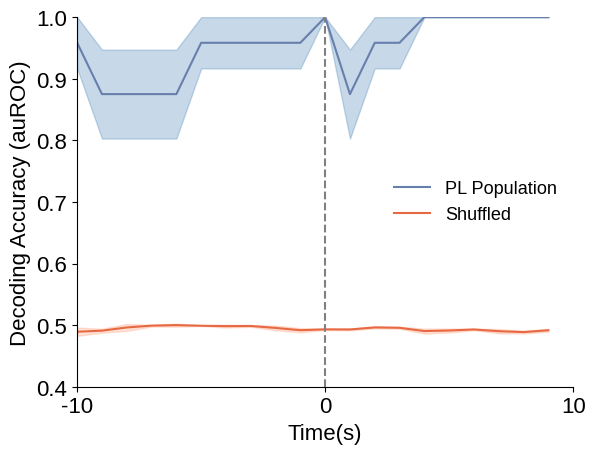

In [454]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots()
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

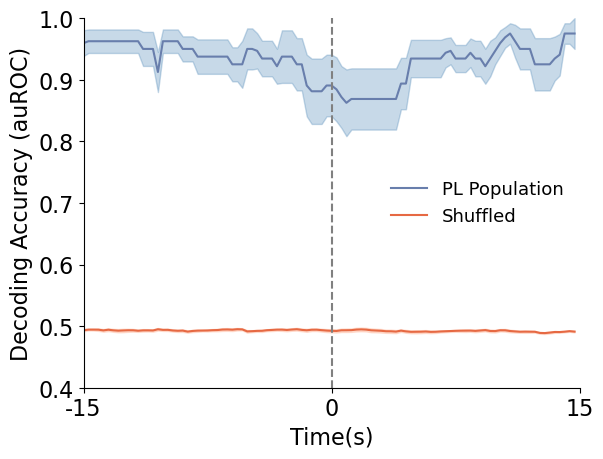

In [124]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots()
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

## Trial concatenate zscore by trial

In [455]:
def process_trial(args):
    trace_trial, Bins, Baseline_bins, Bins_before = args
    traceb_trial_binned = trace_trial.groupby(pd.cut(trace_trial.columns, Bins), axis=1).mean()
    mean_vals = traceb_trial_binned.iloc[:, Baseline_bins:Bins_before].mean(axis=1)
    std_vals = traceb_trial_binned.iloc[:, Baseline_bins:Bins_before].std(axis=1)
    low_variance_mask = (std_vals < 0.001)
    std_vals_replaced = std_vals.mask(low_variance_mask, np.nan)

    traceb_trial_zscore = traceb_trial_binned.sub(mean_vals, axis=0).divide(std_vals_replaced, axis=0)
    traceb_trial_zscore.fillna(0, inplace=True)

    return traceb_trial_zscore

def calculate_zscore_by_trial(tracenew_bycue, cueonset):
    trials = [(tracenew_bycue.iloc[:, i*TotalFrame: (i+1)*TotalFrame], Bins, Baseline_bins, Bins_before) for i in range(len(cueonset))]
    num_processes = os.cpu_count()
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = executor.map(process_trial, trials)

    tracezscore = pd.concat(list(results), axis=1)
    return tracezscore


def calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]

    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]

    # Collect trace data slices in a list
    trace_slices = []
    for i, onset in enumerate(cueonset):
        valid_starts = np.arange(onset - FrameRange_before, onset + FrameRange_after)
        valid_starts = valid_starts[(valid_starts >= 0) & (valid_starts < len(trace.columns))]
        trace_slices.append(trace.iloc[:, valid_starts])

    # Concatenate all slices
    tracenew_bycue = pd.concat(trace_slices, axis=1)

    tracezscore_bycue = calculate_zscore_by_trial(tracenew_bycue, cueonset)
    tracezscore_bycue.columns = np.arange(0, Bins*len(cueonset))
    
    return tracezscore_bycue
# Usage example:
# result = calculate_traces_concatenated(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range)


In [456]:
%%time
hungrycue = 12
trial_size = TotalFrame

# Create a list to hold the dataframes
trace_hungry_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)

    # Add animal ID and cell IDs
    tracebin = pd.concat([tracebin, 
                      pd.Series(animal_id, index=tracebin.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracebin.index, name='cell_id')], axis=1)

    # Store the updated DataFrame in the list
    trace_hungry_trial_list.append(tracebin)
    
# Concatenate all dataframes in the list with appropriate column order
trace_hungry_trial_zscored = pd.concat(trace_hungry_trial_list, ignore_index=True)
columns = ['Animal_ID', 'cell_id'] + [col for col in trace_hungry_trial_zscored.columns if col not in ['Animal_ID', 'cell_id']]
trace_hungry_trial_zscored = trace_hungry_trial_zscored[columns]

CPU times: user 1.06 s, sys: 6.72 s, total: 7.78 s
Wall time: 8.84 s


In [457]:
trace_hungry_trial_zscored

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1  2.037222  1.835438  1.657299  1.486523  1.322807   
1          6S5       2  1.189321  0.991200  0.818506  0.654932  0.499995   
2          6S5       3 -1.751388 -1.819759 -1.882150 -1.943866 -1.907157   
3          6S5       4  0.004340 -0.216623 -0.407909 -0.587813 -0.757010   
4          6S5       5  2.939370  2.151601  1.478092  0.851720  0.269183   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.000000  0.000000   
1107       8H6      71 -1.001932 -1.017023 -1.029812 -1.041608 -1.052487   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000   
1109       8H6      75  2.538170  1.966359  1.517038  1.131162  0.799775   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000   

             5         6         7  ...       782       783       784  \
0     1.165858  1.015396  0.871154  ...  6.369206  7.183224  8.355363   
1     0.353241  0.214236  0.082571  ...  0.035822 -0.281370 -0.581813   
2    -0.356096  0.682537  1.429539  ...  1.316697  1.142009  0.969210   
3    -0.513219 -0.686856 -0.605167  ...  0.000000  0.000000  0.000000   
4    -0.272585 -0.776437 -1.190573  ... -1.693211 -1.873532 -1.217690   
...        ...       ...       ...  ...       ...       ...       ...   
1106  0.000000  0.000000  0.000000  ... -1.210738 -1.212827 -1.214739   
1107 -1.062521 -1.071775 -1.080310  ...  0.000000  0.000000  0.000000   
1108  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1109  0.515181  0.270773  0.133675  ...  0.000000  0.000000  0.000000   
1110  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

           785       786       787       788       789       790       791  
0     7.907715  8.092549  8.461673  8.009631  7.576274  7.160831  6.730370  
1    -0.354053  2.017508  1.643636  1.256062  2.394435  2.332229  1.858640  
2     0.798281  1.449558  4.229741  4.023547  3.847224  3.700149  3.483108  
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    -0.821736 -1.063046 -1.287468 -0.614924  0.913735  0.706942  0.331112  
...        ...       ...       ...       ...       ...       ...       ...  
1106 -1.216488 -1.218089 -1.219554 -1.220894 -1.222120 -1.223242 -1.224349  
1107  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1108  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1110  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[1111 rows x 794 columns]

In [458]:
%%time
satiatedcue = -12
trial_size = TotalFrame

# Create a list to hold the dataframes
trace_satiated_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)

    # Add animal ID and cell IDs
    tracebin = pd.concat([tracebin, 
                      pd.Series(animal_id, index=tracebin.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracebin.index, name='cell_id')], axis=1)

    # Store the updated DataFrame in the list
    trace_satiated_trial_list.append(tracebin)
    
# Concatenate all dataframes in the list with appropriate column order
trace_satiated_trial_zscored = pd.concat(trace_satiated_trial_list, ignore_index=True)
columns = ['Animal_ID', 'cell_id'] + [col for col in trace_satiated_trial_zscored.columns if col not in ['Animal_ID', 'cell_id']]
trace_satiated_trial_zscored = trace_satiated_trial_zscored[columns]

CPU times: user 1.03 s, sys: 6.54 s, total: 7.56 s
Wall time: 8.6 s


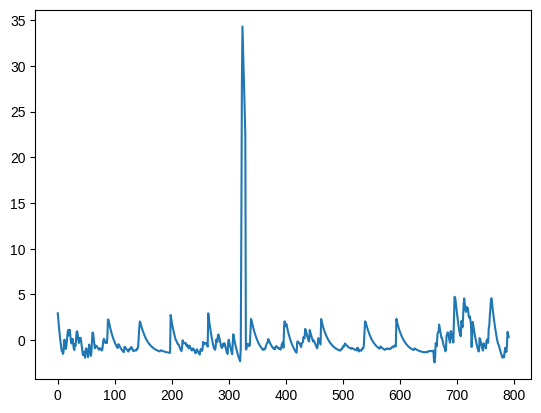

In [459]:
plt.plot(trace_hungry_trial_zscored.iloc[4,2:])

### LDA

In [468]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_zscored_mean = pd.DataFrame(index=trace_hungry_trial_zscored.index)
trace_satiated_trial_zscored_mean = pd.DataFrame(index=trace_satiated_trial_zscored.index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before + Bins * i
    end_col = 2 + Bins_before + int(2 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_zscored_mean[f'{i}'] = trace_hungry_trial_zscored.iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_zscored_mean[f'{i}'] = trace_satiated_trial_zscored.iloc[:, start_col:end_col].mean(axis=1)


In [487]:
Data = pd.concat([trace_hungry_trial_zscored_mean.T, trace_satiated_trial_zscored_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [488]:
# ss = StandardScaler(with_mean=True, with_std=True)
# Data = pd.DataFrame(ss.fit_transform(Data))
# Data

In [489]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [490]:
Data

0          1          2           3          4          5  \
0  -1.474110   1.190302  -0.948190   -0.054021   0.368688   1.775945   
1  -1.474110   2.386268  -0.894271   -0.636744  -0.454278  -1.181914   
2  -0.101093   3.821585  -1.725326   -1.289598  -0.853736  -0.674270   
3  -1.474110   1.065712  -1.518624    0.000000  -0.899342   3.238973   
4  -0.397849   7.058922  -2.043294    0.000000  -0.648646   2.148252   
5   3.990221  -0.830641   1.841557    0.000000  -0.614820  -1.639386   
6  -1.474110   4.002464   2.746799    0.000000   0.248202  -0.312693   
7  -1.318724  11.313193   6.384002    0.000000  -0.980624   1.640987   
8  -0.241006  -0.103980  33.937679  353.139335  -0.826797  -1.827296   
9  -1.474110   4.802345  -1.855771   -1.289598  -1.034137   0.252009   
10 -1.474110   2.035023   4.614724   -1.289598   2.622603  -0.427633   
11 -1.474110   7.238767  -1.743541    0.000000   3.807780   1.309797   
12 -2.008418   1.964098  -1.670645   -0.669570   0.965207   0.436172   
13 -1.052360  -1.364366  -1.845679   -1.289598  -1.180713   0.169643   
14 -1.139476   0.399610  -1.855771   -1.289598  -1.196702  -1.193798   
15  0.890705  -1.132279  -0.197319    1.108281  -2.028535  -1.257775   
16  0.357550   3.539377  -1.866279   -1.973521  13.730413  16.722882   
17  0.213524   1.314322  -1.855771   -1.289598   0.357223   1.334498   
18 -2.174922   1.004450  -0.449422    2.850919  -1.196702   7.425523   
19 -0.280887   0.792770   4.186413   -1.289598  -0.787711  -1.961248   
20 -1.743156   0.998854  -1.855771   -1.438012  -0.508817   3.654125   
21 -2.274380  -0.752932   0.828044   -1.289598  -1.196702  -1.604952   
22  0.538224   2.193296   1.645069    1.482851  -1.196702  -1.705278   
23 -1.008379   0.708538  -1.169953   -1.698932   0.277417  -2.350104   

           6          7           8         9  ...  1102      1103      1104  \
0   0.638011  -1.379675   -1.408395  1.660080  ...   0.0  0.000000  0.000000   
1   2.125578  -1.799958   -1.407082 -1.969726  ...   0.0  0.000000  0.000000   
2   0.191425   1.610834   -1.437435  0.780569  ...   0.0 -1.221445 -0.944115   
3  -0.040515   2.355845   -1.502924  0.886118  ...   0.0  0.000000  0.000000   
4   0.774031  -1.398804   -0.315233  1.309236  ...   0.0 -1.221445  0.000000   
5   1.720231   1.768910   -1.407079  3.303730  ...   0.0  0.000000  0.000000   
6   0.698025   0.963255    1.049120  0.749820  ...   0.0  2.347851  0.000000   
7   1.589057  16.108720   -0.514958  0.427462  ...   0.0  0.000000  0.000000   
8   1.301896  -1.345021    0.000000 -1.757111  ...   0.0 -1.221445  0.000000   
9   1.590726   0.415666   -1.407082  0.238279  ...   0.0  0.000000  0.000000   
10  2.301047   1.291310   -1.175760 -1.709636  ...   0.0  0.000000  0.000000   
11  1.119274  -1.422541    1.538898  2.919401  ...   0.0  0.000000  0.000000   
12 -0.054105  -1.209019    5.387415 -0.129599  ...   0.0  0.000000  0.000000   
13 -0.889722  -0.250931    4.034992  0.693054  ...   0.0  0.000000  0.000000   
14  4.608542  -1.766188   -1.490064  0.953351  ...   0.0  0.000000  0.000000   
15 -1.897996  -0.360577    0.240358 -1.944946  ...   0.0  0.657053  0.427782   
16 -0.147350  -0.922162    0.544435 -0.550164  ...   0.0  0.000000  0.000000   
17  0.909554  -2.095806    0.213211 -1.219922  ...   0.0  0.000000  0.000000   
18  4.569044  -1.438963    0.566947 -1.219922  ...   0.0  0.000000  0.000000   
19  0.454717   0.442873   -1.407082 -1.219922  ...   0.0  0.000000  0.000000   
20  3.549345   1.997267   -1.407082 -1.219922  ...   0.0 -1.221445 -0.944115   
21 -2.011560  -0.698600    1.213522 -0.152455  ...   0.0  0.000000  0.000000   
22  1.967599  -1.370290   -0.240889 -0.886523  ...   0.0  0.000000  0.000000   
23  2.765950   0.105636  310.089681  1.736748  ...   0.0  0.000000  0.000000   

         1105      1106      1107     1108      1109      1110  Label  
0   22.207498  0.000000 -0.743878  0.00000 -1.159424  0.000000      1  
1    0.000000  0.000000  1.709361  0.00000  0.000000  0.000000   

<Axes: >

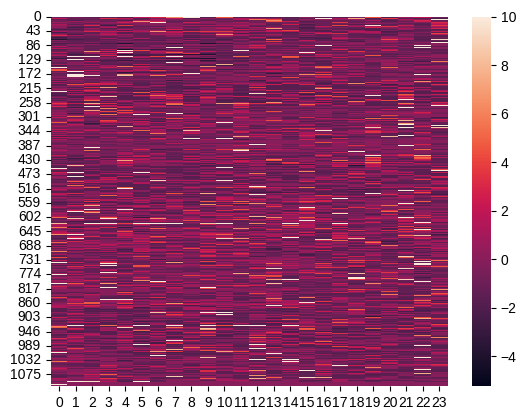

In [492]:
sb.heatmap(Data.iloc[:,:-1].T, vmax = 10)

In [493]:
#Data.to_csv("Calcium Dataset reorganized.csv")

In [494]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Stratified train-test-split
sss = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
for train_index, test_index in sss.split(X, Y):
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

# Training set
Xtrain = Train.iloc[:, 0:Dt.shape[1]-1] 
Ytrain = Train.iloc[:,Dt.shape[1]-1]

# Testing set
Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
Ytest = Test.iloc[:, Dt.shape[1]-1]

print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


In [495]:
# Hyperparameter
solver = ['lsqr', 'eigen']
# shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

# Training process
LDA_ACC_train = []
LDA_AUC_train = []
LDA_ACC_test = []
LDA_AUC_test = []

n = len(Hyperparameter_Space2)

for i in range(0, n):
    # Extract hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[i, :]
    Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
    # Model with hyperparameter
    LDA = LinearDiscriminantAnalysis(**Hyperpara)
    LDA.fit(Xtrain, Ytrain)
    
    # Obtain training metrics
    y_train_pred = LDA.predict(Xtrain)
    y_train_score = LDA.predict_proba(Xtrain)[:, 1]
    
    train_acc = accuracy_score(Ytrain, y_train_pred)
    train_auc = roc_auc_score(Ytrain, y_train_score)
    
    LDA_ACC_train.append(train_acc)
    LDA_AUC_train.append(train_auc)
    
    # Obtain testing metrics
    y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]
    
    test_acc = accuracy_score(Ytest, y_test_pred)
    test_auc = roc_auc_score(Ytest, y_test_score)
    
    LDA_ACC_test.append(test_acc)
    LDA_AUC_test.append(test_auc)
    
# Show training result
Result_LDA = {'Train_Accuracy': LDA_ACC_train,
          'Train_AUC': LDA_AUC_train,
          'Test_Accuracy': LDA_ACC_test,
          'Test_AUC': LDA_AUC_test}
Result_LDA = pd.DataFrame(Result_LDA)
Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)
Result_LDA

solver shrinkage  Train_Accuracy  Train_AUC  Test_Accuracy  Test_AUC
0   lsqr      auto             1.0        1.0           0.25  0.222222
1  eigen      auto             1.0        1.0           0.25  0.222222

In [274]:
random.seed = 999
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}

def process(i):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    
    # Model with hyperparameter
    LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
    clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
    
    y_pred = clf_shuffle.predict(Xtest)
    
    accuracy = accuracy_score(Ytest, y_pred)
    auc = roc_auc_score(Ytest, y_pred)
    
    return accuracy, auc

if __name__ == "__main__":
    with Pool(cpu_count()) as p:
        results = p.map(process, range(nump))

    for i, result in enumerate(results):
        accuracy_multisplit_shuffle[i], auc_multisplit_shuffle[i] = result


In [275]:
AUC_True = Result_LDA["Test_AUC"].max()
AUC_True

0.3194444444444445

In [252]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

1.0

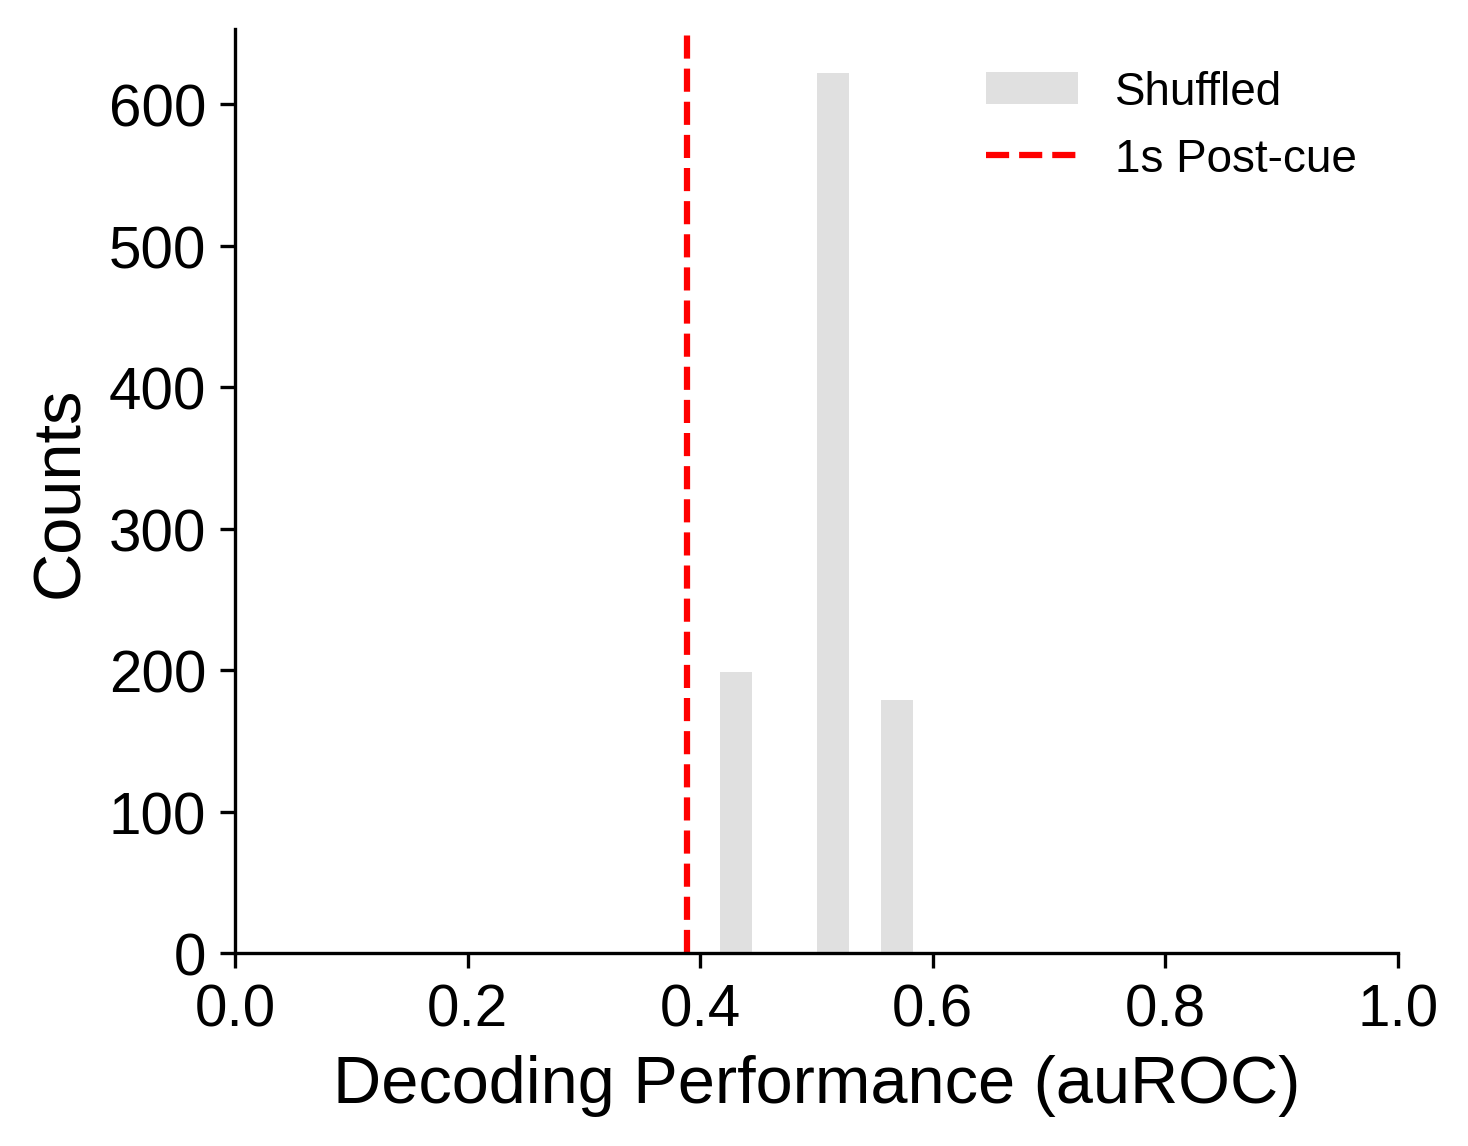

In [253]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=6)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.set_xlim(0,1)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--', label = "1s Post-cue" )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon= False,fontsize =11)

### Multisplit for Cross-Validation

In [163]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Hyperparameter
solver = ['lsqr', 'eigen']
# shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

n_cv = 8
splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results = []
shuffled_auc_results = []

for i in range(n_cv):

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

    # Training process
    LDA_ACC_train = []
    LDA_AUC_train = []
    LDA_ACC_test = []
    LDA_AUC_test = []

    n = len(Hyperparameter_Space2)

    for i in range(0, n):
        # Extract hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[i, :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

        # Model with hyperparameter
        LDA = LinearDiscriminantAnalysis(**Hyperpara)
        LDA.fit(Xtrain, Ytrain)

        # Obtain testing metrics
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)

    # Show training result
    Result_LDA = {'Test_AUC': LDA_AUC_test}
    Result_LDA = pd.DataFrame(Result_LDA)
    Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

    AUC_True = Result_LDA['Test_AUC'].max()
    auc_results.append(AUC_True)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

    # Extract best hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
    Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

        y_pred = clf_shuffle.predict(Xtest)

        accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_pred)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results.append(np.mean(auc_multisplit_shuffle))

auc_results = np.array(auc_results)
shuffled_auc_results = np.array(shuffled_auc_results)
print("AUC Results:", auc_results)
print("Shuffled AUC Results:", shuffled_auc_results)


AUC Results: [0.83333333 0.875      0.83333333 0.875      0.91666667 0.88888889
 0.83333333 0.875     ]
Shuffled AUC Results: [0.49858333 0.505      0.49683333 0.49275    0.49433333 0.50075
 0.49766667 0.50316667]


In [164]:
from scipy import stats

# Convert lists to numpy arrays
auc_results = np.array(auc_results)
shuffled_auc_results = np.array(shuffled_auc_results)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results, shuffled_auc_results)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results, shuffled_auc_results)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)


not normal
Test statistic: 0.0
p-value: 0.0078125


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


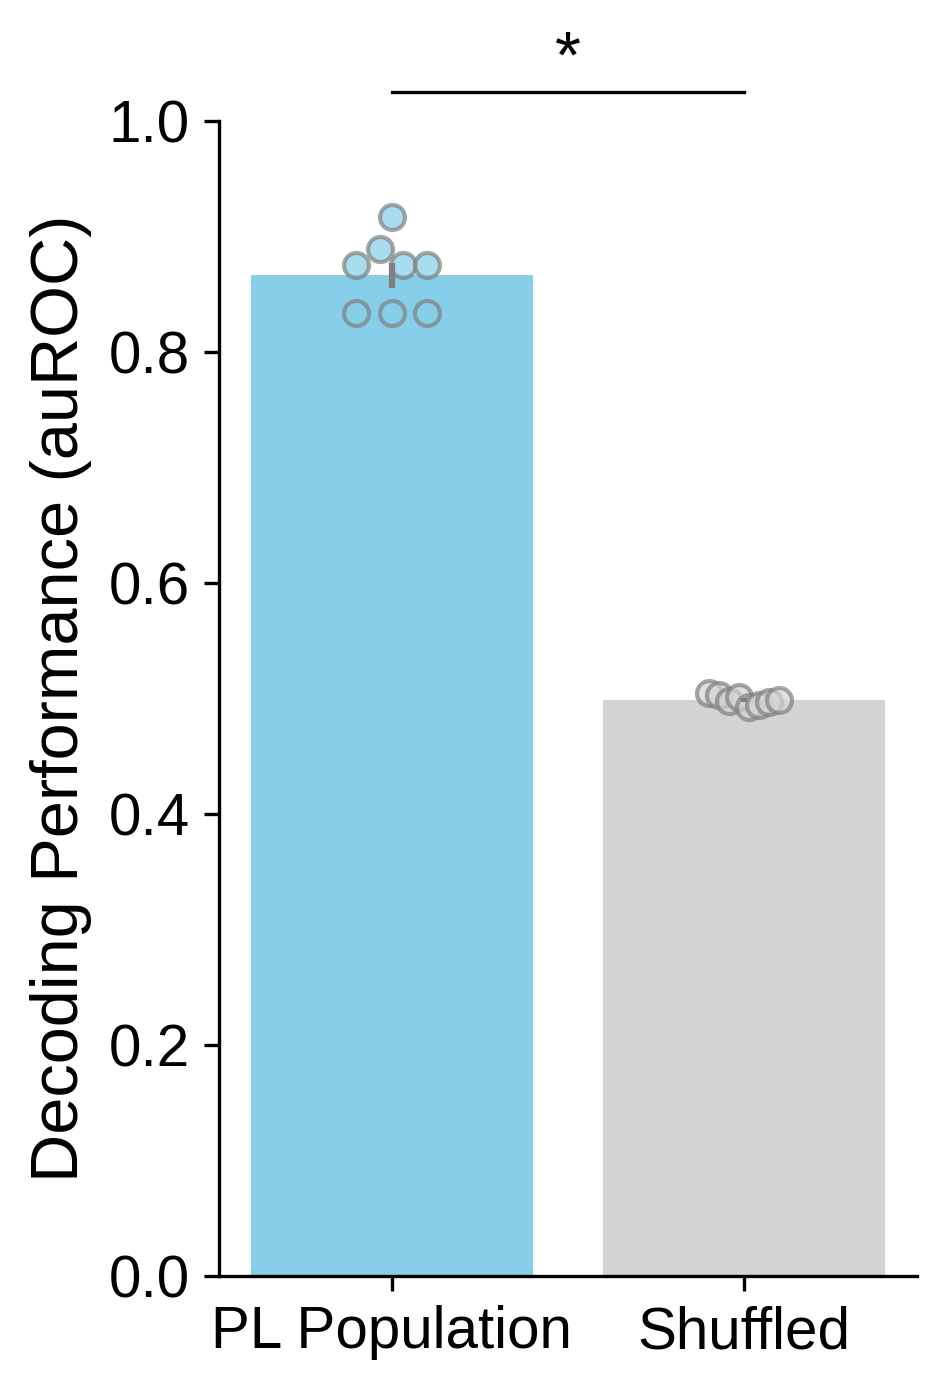

In [165]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results.mean(), yerr=stats.sem(auc_results), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results.mean(), yerr=stats.sem(shuffled_auc_results), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)


## Across animals

In [166]:
animal_ids = np.unique(tracehungry.Animal_ID)

# Hyperparameter
solver = ['lsqr', 'eigen']
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_by_animal = []
shuffled_auc_results_by_animal = []

for i in range(len(animal_ids)):
    
    Data = pd.concat([trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_ids[i]].iloc[:, [2+Bins_before + Bins * i for i in range(12)]].T, 
            trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_ids[i]].iloc[:, [2+Bins_before + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:Dt.shape[1]-1]
    Y = Dt.iloc[:, Dt.shape[1]-1]

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=999)
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

    # Training process
    LDA_ACC_train = []
    LDA_AUC_train = []
    LDA_ACC_test = []
    LDA_AUC_test = []

    n = len(Hyperparameter_Space2)

    for i in range(0, n):
        # Extract hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[i, :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

        # Model with hyperparameter
        LDA = LinearDiscriminantAnalysis(**Hyperpara)
        LDA.fit(Xtrain, Ytrain)

        # Obtain testing metrics
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)

    # Show training result
    Result_LDA = {'Test_AUC': LDA_AUC_test}
    Result_LDA = pd.DataFrame(Result_LDA)
    Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

    AUC_True = Result_LDA['Test_AUC'].max()
    auc_results_by_animal.append(AUC_True)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

    # Extract best hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
    Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

        y_pred = clf_shuffle.predict(Xtest)

        accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_pred)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results_by_animal.append(np.mean(auc_multisplit_shuffle))

auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)
print("AUC Results:", auc_results_by_animal)
print("Shuffled AUC Results:", shuffled_auc_results_by_animal)


AUC Results: [0.79166667 0.38888889 0.80555556 0.72222222 0.72222222 0.94444444
 0.80555556 0.94444444 0.94444444 0.69444444 0.94444444 0.94444444
 0.94444444 0.94444444 0.83333333 0.80555556 0.94444444 0.58333333
 0.72222222]
Shuffled AUC Results: [0.502      0.50241667 0.49883333 0.4965     0.50008333 0.49708333
 0.49791667 0.499      0.49508333 0.497      0.50058333 0.49883333
 0.49816667 0.49608333 0.49541667 0.49733333 0.49875    0.4985
 0.49908333]


In [167]:
from scipy import stats

# Convert lists to numpy arrays
auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_by_animal)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results_by_animal)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

not normal
Test statistic: 2.0
p-value: 1.1444091796875e-05


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


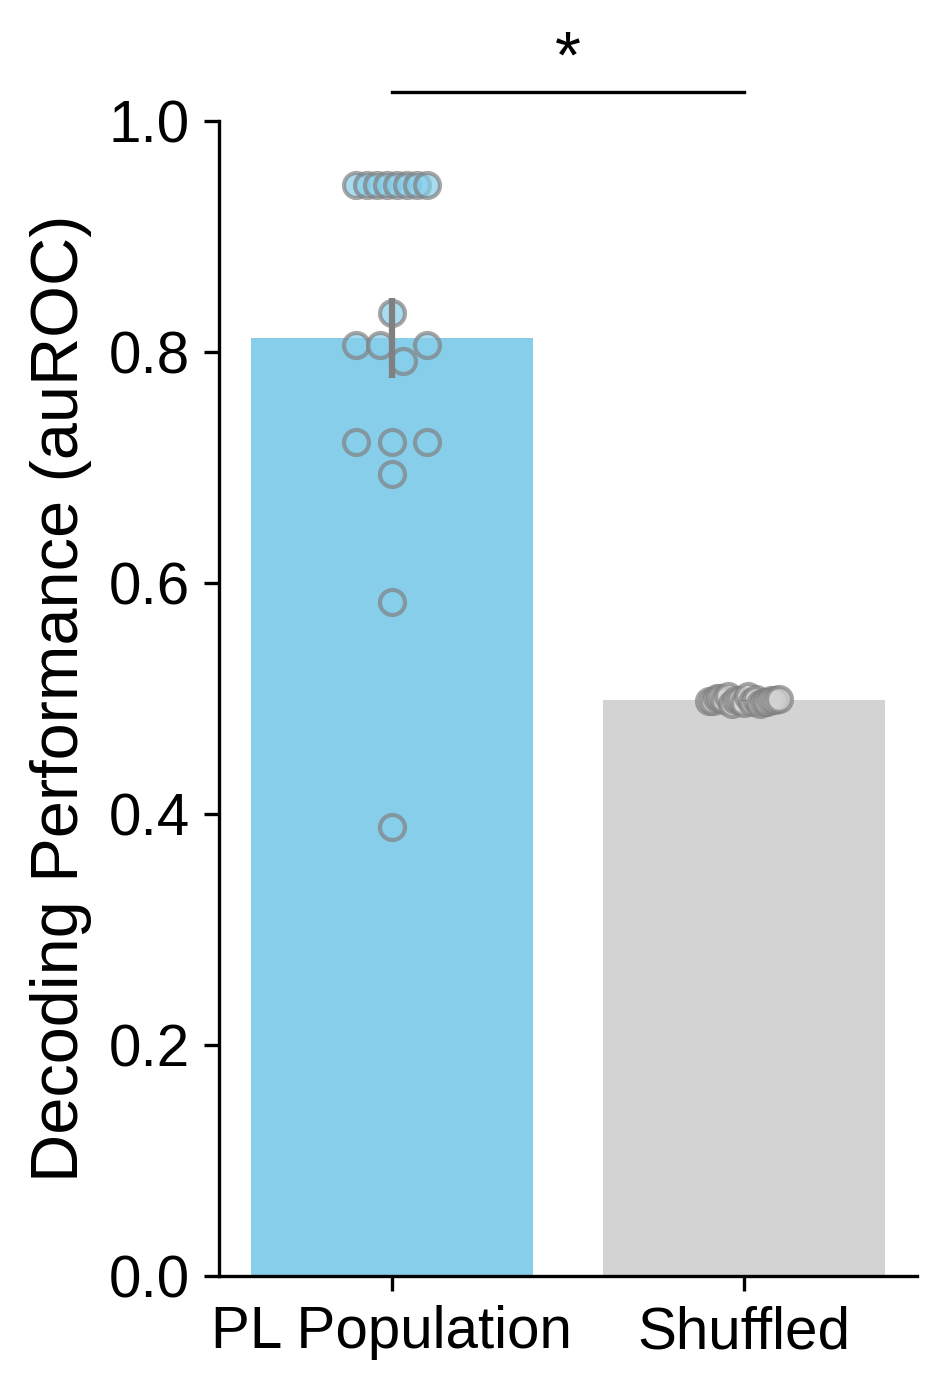

In [168]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal.mean(), yerr=stats.sem(auc_results_by_animal), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results_by_animal.mean(), yerr=stats.sem(shuffled_auc_results_by_animal), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

In [169]:
cluster = pd.read_csv("/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Behavior/satiated_behavior_cluster.csv", index_col = 0)
cluster.rename(columns={"animal_id": "Animal_ID"}, inplace=True)
cluster

Animal_ID Sex  Cluster_Kmeans
0        9M6   F               0
1        7H6   F               1
2        2N6   M               1
3        6H6   F               0
4        2I5   M               0
5        8H6   F               1
6        1H6   F               0
7        6S5   M               1
8        8S5   M               0
9        7M6   F               1
10       6M6   F               1
11       5B6   F               1
12       1S5   M               1
13       2S5   M               0
14       2Z4   M               0
15       4N6   M               0
16       7B6   F               0
17       4B6   F               0
18       1I5   M               0
19       1B6   F               0

In [170]:
# Create DataFrame
cluster_data = pd.DataFrame(cluster).copy()

# Ensure the Animal_ID column is of type string for proper sorting and matching
cluster_data['Animal_ID'] = cluster_data['Animal_ID'].astype(str)

# Sort cluster data by the order of animal_ids
sorted_df = cluster_data.set_index('Animal_ID').loc[animal_ids].reset_index()

sorted_df

Animal_ID Sex  Cluster_Kmeans
0        1B6   F               0
1        1H6   F               0
2        1I5   M               0
3        1S5   M               1
4        2I5   M               0
5        2N6   M               1
6        2S5   M               0
7        2Z4   M               0
8        4B6   F               0
9        4N6   M               0
10       5B6   F               1
11       6H6   F               0
12       6M6   F               1
13       6S5   M               1
14       7B6   F               0
15       7H6   F               1
16       7M6   F               1
17       8H6   F               1
18       9M6   F               0

In [171]:
sorted_df[auc_results_by_animal<0.75]

Animal_ID Sex  Cluster_Kmeans
1        1H6   F               0
3        1S5   M               1
4        2I5   M               0
9        4N6   M               0
17       8H6   F               1
18       9M6   F               0

In [172]:
animal_ids = np.unique(tracehungry.Animal_ID)

# Hyperparameter
solver = ['lsqr', 'eigen']
shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_cluster0 = []
shuffled_auc_results_cluster0 = []
auc_results_cluster1 = []
shuffled_auc_results_cluster1 = []

for i in range(len(animal_ids)):
    
    Data = pd.concat([trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_ids[i]].iloc[:, [2+Bins_before + Bins * i for i in range(12)]].T, 
            trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_ids[i]].iloc[:, [2+Bins_before + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:Dt.shape[1]-1]
    Y = Dt.iloc[:, Dt.shape[1]-1]

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=999)
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

    # Training process
    LDA_ACC_train = []
    LDA_AUC_train = []
    LDA_ACC_test = []
    LDA_AUC_test = []

    n = len(Hyperparameter_Space2)

    for j in range(0, n):
        # Extract hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[j, :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

        # Model with hyperparameter
        LDA = LinearDiscriminantAnalysis(**Hyperpara)
        LDA.fit(Xtrain, Ytrain)

        # Obtain testing metrics
        y_test_pred = LDA.predict(Xtest)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]

        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)

    # Show training result
    Result_LDA = {'Test_AUC': LDA_AUC_test}
    Result_LDA = pd.DataFrame(Result_LDA)
    Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

    AUC_True = Result_LDA['Test_AUC'].max()
    if cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 0:
        auc_results_cluster0.append(AUC_True)
    elif cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 1:
        auc_results_cluster1.append(AUC_True)
        
    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

    # Extract best hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
    Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(k):
        np.random.seed(k)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

        y_pred = clf_shuffle.predict(Xtest)

        accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_pred)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for j, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[j] = accuracy
            auc_multisplit_shuffle[j] = auc
        if cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 0:
            shuffled_auc_results_cluster0.append(np.mean(auc_multisplit_shuffle))
        elif cluster[cluster.Animal_ID == animal_ids[i]].Cluster_Kmeans.values[0] == 1:
            shuffled_auc_results_cluster1.append(np.mean(auc_multisplit_shuffle)) 

auc_results_cluster0 = np.array(auc_results_cluster0)
shuffled_auc_results_cluster0 = np.array(shuffled_auc_results_cluster0)
auc_results_cluster1 = np.array(auc_results_cluster1)
shuffled_auc_results_cluster1 = np.array(shuffled_auc_results_cluster1)


print("AUC Results cluster 0:", auc_results_cluster0)
print("Shuffled AUC Results cluster 0:", shuffled_auc_results_cluster0)
print("AUC Results cluster 1:", auc_results_cluster1)
print("Shuffled AUC Results cluster 1:", shuffled_auc_results_cluster1)

AUC Results cluster 0: [0.79166667 0.38888889 0.80555556 0.72222222 0.80555556 0.94444444
 0.94444444 0.69444444 0.94444444 0.83333333 0.72222222]
Shuffled AUC Results cluster 0: [0.502      0.50241667 0.49883333 0.50008333 0.49791667 0.499
 0.49508333 0.497      0.49883333 0.49541667 0.49908333]
AUC Results cluster 1: [0.72222222 0.94444444 0.94444444 0.94444444 0.94444444 0.80555556
 0.94444444 0.58333333]
Shuffled AUC Results cluster 1: [0.4965     0.49708333 0.50058333 0.49816667 0.49608333 0.49733333
 0.49875    0.4985    ]


In [173]:
# Hyperparameters
solver = ['lsqr', 'eigen']
shrinkage = ['auto']
splits = 8
nump = 1000
n_cv = 8

# Generate Hyperparameter Matrix
Hyperparameter_Space = [(s, sh) for s in solver for sh in shrinkage]
Hyperparameter_Mat = pd.DataFrame(Hyperparameter_Space, columns=['solver', 'shrinkage'])


def perform_lda(Xtrain, Ytrain, Xtest, Ytest, hyperparameters):
    LDA_AUC_test = []
    for solver, shrinkage in hyperparameters:
        params = {'solver': solver, 'shrinkage': shrinkage}
        LDA = LinearDiscriminantAnalysis(**params)
        LDA.fit(Xtrain, Ytrain)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]
        test_auc = roc_auc_score(Ytest, y_test_score)
        LDA_AUC_test.append(test_auc)
    return max(LDA_AUC_test)


def shuffle_and_compute_single_run(i, Xtrain, Ytrain, Xtest, Ytest, best_params):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    LDA = LinearDiscriminantAnalysis(**best_params)
    LDA.fit(Xtrain, Ytrain_shuffle)
    y_pred = LDA.predict(Xtest)
    auc = roc_auc_score(Ytest, y_pred)
    return auc

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params, nump):
    with Pool() as pool:
        auc_shuffled = pool.starmap(shuffle_and_compute_single_run, 
                                    [(i, Xtrain, Ytrain, Xtest, Ytest, best_params) for i in range(nump)])
    return np.mean(auc_shuffled)
# Main processing loop
animal_ids = np.unique(tracehungry.Animal_ID)
auc_results_by_animal = []
shuffled_auc_results_by_animal = []

for animal_id in animal_ids:
    # Filter data for the current animal
    Data =  pd.concat([trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_id].iloc[:, [2+Bins_before + Bins * i for i in range(12)]].T, 
            trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_id].iloc[:, [2+Bins_before + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into features and target
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]

    auc_results = []
    shuffled_auc_results = []

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Perform LDA and get the best AUC
        best_auc = perform_lda(Xtrain, Ytrain, Xtest, Ytest, Hyperparameter_Space)
        auc_results.append(best_auc)

        # Find best hyperparameters
        best_params_index = np.argmax(best_auc)
        best_params = Hyperparameter_Space[best_params_index]
        best_params_dict = {'solver': best_params[0], 'shrinkage': best_params[1]}

        # Shuffle and compute AUC
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params_dict, nump)
        shuffled_auc_results.append(shuffled_auc)

    for train_index, test_index in skf.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Perform LDA and get the best AUC
        best_auc = perform_lda(Xtrain, Ytrain, Xtest, Ytest, Hyperparameter_Space)
        auc_results.append(best_auc)

        # Find best hyperparameters
        best_params_index = np.argmax(best_auc)
        best_params = Hyperparameter_Space[best_params_index]
        best_params_dict = {'solver': best_params[0], 'shrinkage': best_params[1]}

        # Shuffle and compute AUC
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params_dict, nump)
        shuffled_auc_results.append(shuffled_auc)

    # Calculate average AUCs
    auc_results_by_animal.append(np.mean(auc_results))
    shuffled_auc_results_by_animal.append(np.mean(shuffled_auc_results))

# Output the results
print("AUC Results by Animal:", auc_results_by_animal)
print("Shuffled AUC Results by Animal:", shuffled_auc_results_by_animal)


AUC Results by Animal: [0.78125, 0.65625, 0.65625, 0.78125, 0.71875, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.8125, 0.78125, 0.84375, 0.53125, 0.71875]
Shuffled AUC Results by Animal: [0.49984375, 0.49746875, 0.48750000000000004, 0.4941875, 0.49146875, 0.494, 0.49196874999999995, 0.4903125, 0.49493750000000003, 0.4931875, 0.497375, 0.4906875, 0.49012500000000003, 0.49534375, 0.5082500000000001, 0.4889375, 0.49690625, 0.49746875, 0.4926875]


In [174]:
from scipy import stats

# Convert lists to numpy arrays
auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_by_animal)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results_by_animal)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

normal
Test statistic: 14.149443491041886
p-value: 3.4093811663527e-11


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


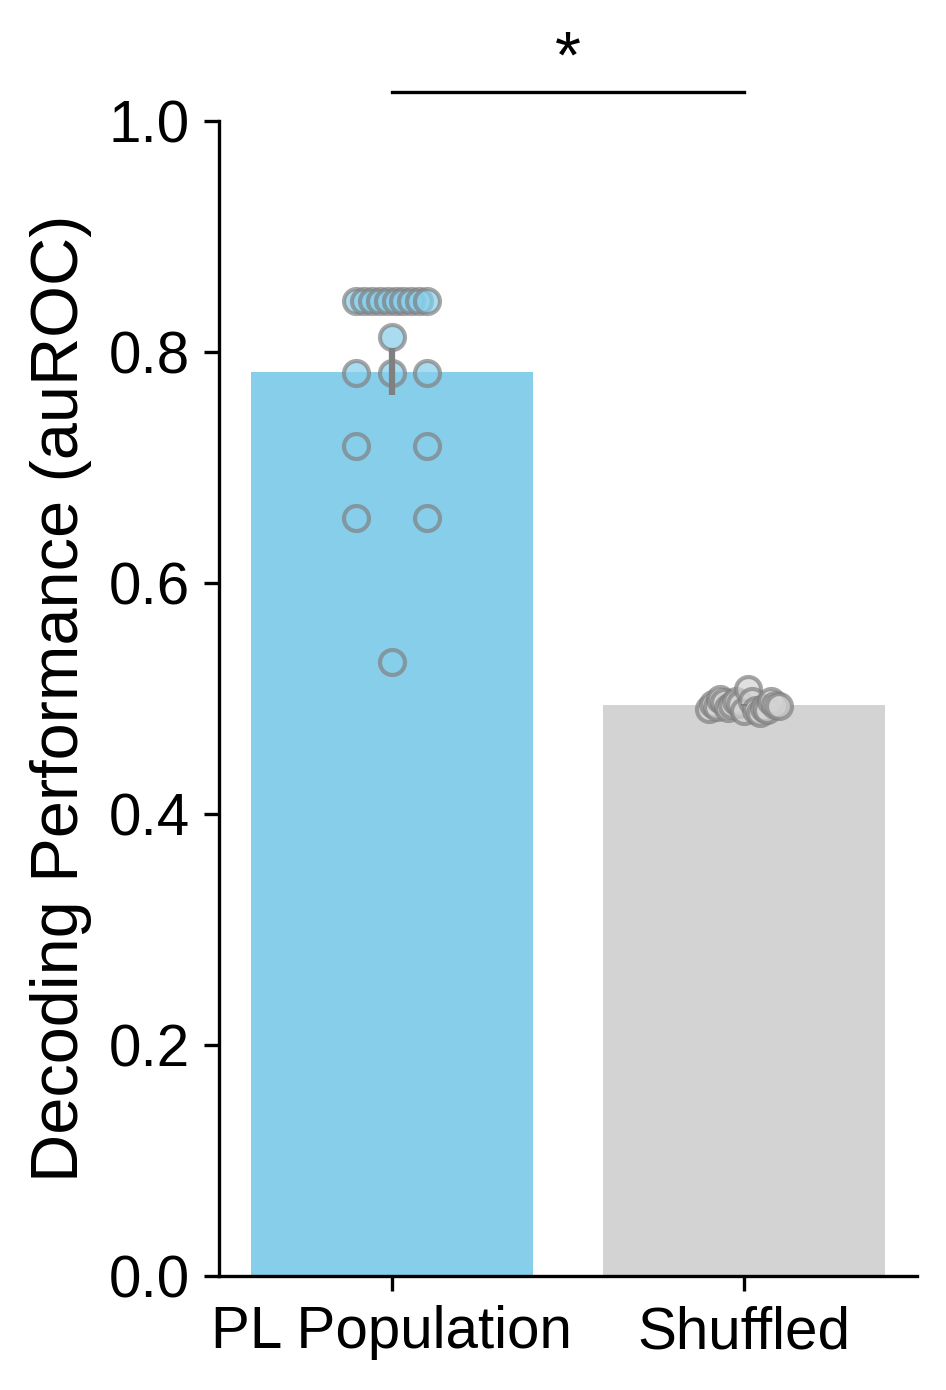

In [175]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal.mean(), yerr=stats.sem(auc_results_by_animal), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results_by_animal.mean(), yerr=stats.sem(shuffled_auc_results_by_animal), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

## Across time

In [180]:
%%time

n_cv = 8
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 15

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

# Initialize arrays to store the results
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))


def calculate_bins_zscore(df, time_bin, FrameRange_before,BinSizeAC, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        cueonset = cueonset[cue_range[0]:cue_range[1]]
    
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        start_frame = cueonset[i] + int(time_bin * FR)
        end_frame = start_frame + int(BinSizeAC* FR)  # bin
        tracenew.iloc[:,i] = trace.iloc[:, start_frame:end_frame].mean(axis=1)
        
    return tracenew

# Define the main processing function for each time bin
def process_time_bin(time_bin):
#     # Create a list to hold the dataframes
#     trace_safe_list = []
#     trace_threat_list = []
    
#     # Loop through each animal's DataFrame
#     for df in all_dataframes:  # Assuming all_dataframes is defined
#         tracenew_safe = calculate_bins_zscore(df, time_bin, FrameRange_before, BinSizeAC, TotalFrame, Bins, Bins_before, cue_range=safecue)
#         tracenew_threat = calculate_bins_zscore(df, time_bin, FrameRange_before, BinSizeAC, TotalFrame, Bins, Bins_before, cue_range=threatcue)

#         trace_safe_list.append(tracenew_safe)
#         trace_threat_list.append(tracenew_threat)

#     # Concatenate all dataframes
#     tracesafe = pd.concat(trace_safe_list, ignore_index=True)
#     tracethreat = pd.concat(trace_threat_list, ignore_index=True)
    
    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial.iloc[:, [2 + Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T, 
            trace_satiated_trial.iloc[:, [2+ Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into X and Y
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]

    # Hyperparameters
    solver = ['lsqr', 'eigen']
    shrinkage = ['auto']

    # Generate hyperparameter space
    Hyperparameter_Space2 = [(a, b) for a in solver for b in shrinkage]
    Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2, columns=['solver', 'shrinkage'])

    # Imputer for NaN values
    imputer = SimpleImputer(strategy='mean')

    # Results lists
    auc_results = []
    shuffled_auc_results = []

    # Generate random states for each fold
    random_states = np.random.randint(0, 10000, size=n_cv)

    for i in range(n_cv):
        sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
        for train_index, test_index in sss.split(X, Y):
            Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
            Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

            # Impute NaN values
            Xtrain = imputer.fit_transform(Xtrain)
            Xtest = imputer.transform(Xtest)

            # LDA training and testing
            for Hyper_i in Hyperparameter_Space2:
                LDA = LinearDiscriminantAnalysis(solver=Hyper_i[0], shrinkage=Hyper_i[1])
                LDA.fit(Xtrain, Ytrain)
                y_test_score = LDA.predict_proba(Xtest)[:, 1]
                test_auc = roc_auc_score(Ytest, y_test_score)
                LDA_AUC_test.append(test_auc)

            Result_LDA = pd.DataFrame({'Test_AUC': LDA_AUC_test})
            AUC_True = Result_LDA['Test_AUC'].max()
            auc_results.append(AUC_True)

            # Shuffled AUC calculation
            shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyper_i, nump)
            shuffled_auc_results.append(shuffled_auc)

    return np.mean(auc_results), np.mean(shuffled_auc_results)

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyper_i, nump):
    auc_shuffled = np.zeros(nump)
    for i in range(nump):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)
        LDA = LinearDiscriminantAnalysis(solver=Hyper_i[0], shrinkage=Hyper_i[1])
        LDA.fit(Xtrain, Ytrain_shuffle)
        y_pred = LDA.predict(Xtest)
        auc_shuffled[i] = roc_auc_score(Ytest, y_pred)
    return np.mean(auc_shuffled)

# Parallel processing for each time bin
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(process_time_bin, time_bins))

# Extract and store the results
for i, (auc, shuffled_auc) in enumerate(results):
    auc_results_all[i] = auc
    shuffled_auc_results_all[i] = shuffled_auc

# Output the results
print("AUC Results All:", auc_results_all)
print("Shuffled AUC Results All:", shuffled_auc_results_all)

LinAlgError: The leading minor of order 1 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [178]:
%%time

n_cv = 8
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 15

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

# Initialize arrays to store the results
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))


def calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        cueonset = cueonset[cue_range[0]:cue_range[1]]
    
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        start_frame = cueonset[i] + int(time_bin * FR)
        end_frame = start_frame + int(BinSize* FR)  # bin
        tracenew.iloc[:,i] = trace.iloc[:, start_frame:end_frame].mean(axis=1)
        
    return tracenew

# Define the main processing function for each time bin
def process_time_bin(time_bin):

    # Create a list to hold the dataframes
    trace_hungry_list = []
    trace_satiated_list = []
    
#     # Loop through each animal's DataFrame
#     for df in all_dataframes:
#         tracenew_hungry = calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
#         tracenew_satiated = calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before,  cue_range=satiatedcue)

#         trace_hungry_list.append(tracenew_hungry)
#         trace_satiated_list.append(tracenew_satiated)
#     # Concatenate all dataframes in the list
#     tracehungry = pd.concat(trace_hungry_list, ignore_index=True)

#     # Concatenate all dataframes in the list
#     tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
    

    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial.iloc[:, [2 + Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T, 
            trace_satiated_trial.iloc[:, [2+ Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    pd.concat([tracehungry.T,tracesatiated.T], axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:(Data.shape[1]-1)]
    Y = Dt.iloc[:, (Data.shape[1]-1)]

    # Hyperparameter
    solver = ['lsqr', 'eigen']
#     shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
    shrinkage = ['auto']

    # Put into a matrix
    Hyperparameter_Space2 = [(a,b) 
                            for a in solver 
                            for b in shrinkage]
    Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
    Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

    # Set the seed for the random number generator
    np.random.seed(42)

    # Generate random states for each fold
    random_states = np.random.randint(0, 10000, size=n_cv)

    auc_results = []
    shuffled_auc_results = []

    for i in range(n_cv):
        sss = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_states[i])
        for train_index, test_index in sss.split(X, Y):
            Train = Dt.iloc[train_index,:]
            Test = Dt.iloc[test_index,:]

        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

        # Training set
        Xtrain = Train.iloc[:, 0:(Data.shape[1]-1)]
        Ytrain = Train.iloc[:,(Data.shape[1]-1)]

        # Testing set
        Xtest = Test.iloc[:, 0:(Data.shape[1]-1)]
        Ytest = Test.iloc[:, (Data.shape[1]-1)]
        
        # Check for NaN values before fitting the model
        if np.isnan(Xtrain).any().any() or np.isnan(Xtest).any().any():
            print(f'NaN values found in Xtrain or Xtest for time_bin: {time_bin}')
    
            # Create an imputer object that will replace NaN values with the mean value of the column
            imputerTrian = SimpleImputer(strategy='mean')
            imputerTtest = SimpleImputer(strategy='mean')
    
            # Fit on the training data
            imputerTrian.fit(Xtrain)
            imputerTtest.fit(Xtest)
            
            # Transform and replace the training and test data
            Xtrain = imputerTrian.transform(Xtrain) 
            Xtest = imputerTtest.transform(Xtest)
    
            
            # Transform and replace the training and test data
            Xtrain = imputerTrian.transform(Xtrain)
            Xtest = imputerTtest.transform(Xtest)


        # Training process
        LDA_ACC_train = []
        LDA_AUC_train = []
        LDA_ACC_test = []
        LDA_AUC_test = []

        n = len(Hyperparameter_Space2)

        for i in range(0, n):
            # Extract hyperparameter
            Hyper_i = Hyperparameter_Mat2.iloc[i, :]
            Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

            # Model with hyperparameter
            LDA = LinearDiscriminantAnalysis(**Hyperpara)
            
            
            LDA.fit(Xtrain, Ytrain)

            # Obtain testing metrics
            y_test_pred = LDA.predict(Xtest)
            y_test_score = LDA.predict_proba(Xtest)[:, 1]

            test_auc = roc_auc_score(Ytest, y_test_score)
            LDA_AUC_test.append(test_auc)

        # Show training result
        Result_LDA = {'Test_AUC': LDA_AUC_test}
        Result_LDA = pd.DataFrame(Result_LDA)
        Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis=1)

        AUC_True = Result_LDA['Test_AUC'].max()
        auc_results.append(AUC_True)

        accuracy_multisplit_shuffle = np.zeros(nump)
        auc_multisplit_shuffle= np.zeros(nump)

        # Extract best hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}
        
        
        for i in range(nump):
            np.random.seed(i)
            Ytrain_shuffle = np.random.permutation(Ytrain)

            # Model with hyperparameter
            LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
            clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

            y_pred = clf_shuffle.predict(Xtest)

            accuracy = accuracy_score(Ytest, y_pred)
            auc = roc_auc_score(Ytest, y_pred)

            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results.append(np.mean(auc_multisplit_shuffle))

       

    return np.array(auc_results), np.array(shuffled_auc_results)

# Using concurrent.futures to parallelize processing for each time_bin
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Map the function across time_bins
    results = list(executor.map(process_time_bin, time_bins))

# Extract results from futures and store them in auc_results_all and shuffled_auc_results_all
for i, (auc_results, shuffled_auc_results) in enumerate(results):
    auc_results_all[i] = np.array(auc_results)
    shuffled_auc_results_all[i] = np.array(shuffled_auc_results)

Process ForkProcess-67099:
Process ForkProcess-67098:
Process ForkProcess-67100:
Process ForkProcess-67101:
Process ForkProcess-67076:
Process ForkProcess-67103:
Process ForkProcess-67102:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run(

KeyboardInterrupt: 

In [87]:
np.isnan(Ytest).any().any()

False

In [88]:
Ytrain.isna().any().any()

False

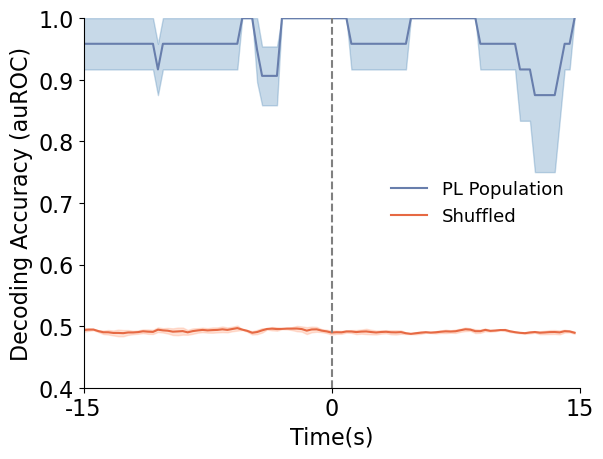

In [89]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots()
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

## Trial concatenate

In [12]:
def calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
           
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
#     trace = trace.sub(trace.mean(axis = 1), axis = 0).divide(trace.std(axis = 1), axis = 0)
#     trace = trace.fillna(0)
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)



    # Collect trace data slices in a list
    trace_slices = []
    for i, onset in enumerate(cueonset):
        valid_starts = np.arange(onset - FrameRange_before, onset + FrameRange_after)
        valid_starts = valid_starts[(valid_starts >= 0) & (valid_starts < len(trace.columns))]
        trace_slices.append(trace.iloc[:, valid_starts])
        
        # Concatenate all slices
    concatenated_trace_df = pd.concat(trace_slices, axis=1)

    # Bin the traces
    tracebin = concatenated_trace_df.groupby(pd.cut(concatenated_trace_df.columns, Bins*len(cueonset)), axis=1).mean()
    tracebin = tracebin.fillna(0)
    tracebin.columns = np.arange(0, Bins*len(cueonset))
    
    return tracebin

In [13]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracebin['Animal_ID'] = animal_id  # Add animal ID
    tracebin['cell_id'] = cell_ids  # Add cell IDs
    
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracebin.columns if col not in ['Animal_ID', 'cell_id']]
    tracebin = tracebin[columns]
    
    trace_hungry_trial_list.append(tracebin)

# Concatenate all dataframes in the list
trace_hungry_trial = pd.concat(trace_hungry_trial_list, ignore_index=True)


In [14]:
trace_hungry_trial

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1  0.048871  0.043362  0.038474  0.034136  0.030288   
1          6S5       2  0.122158  0.104752  0.089826  0.077027  0.066052   
2          6S5       3  0.085015  0.086207  0.125133  0.130049  0.126104   
3          6S5       4  0.083966  0.072425  0.077132  0.125345  0.110695   
4          6S5       5  0.171843  0.139912  0.115031  0.107707  0.128624   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.000000  0.000000   
1107       8H6      71  0.005952  0.004733  0.003764  0.055577  0.103475   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000   
1109       8H6      75  0.095900  0.062303  0.041679  0.057826  0.057196   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000   

             5         6         7  ...           782           783  \
0     0.026874  0.023844  0.021156  ...  3.974344e-03  6.030986e-03   
1     0.059230  0.051175  0.043921  ...  1.043822e-01  8.952634e-02   
2     0.122277  0.118567  0.114970  ...  3.151087e-02  3.066114e-02   
3     0.093033  0.078189  0.065713  ...  1.331473e-09  5.521133e-10   
4     0.120002  0.144117  0.145098  ...  6.533369e-02  5.319358e-02   
...        ...       ...       ...  ...           ...           ...   
1106  0.000000  0.000000  0.000000  ...  8.794528e-04  6.837670e-04   
1107  0.082285  0.065435  0.052035  ...  9.612224e-09  7.645669e-09   
1108  0.000000  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
1109  0.037158  0.024140  0.015683  ...  8.226251e-01  5.344273e-01   
1110  0.000000  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   

               784           785           786           787           788  \
0     1.014926e-02  2.515786e-02  2.915141e-02  3.508264e-02  4.170854e-02   
1     7.808811e-02  6.696168e-02  5.742062e-02  4.923901e-02  4.222317e-02   
2     2.975629e-02  3.148841e-02  3.659613e-02  3.823047e-02  3.707051e-02   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     4.330932e-02  3.669060e-02  3.083013e-02  2.510137e-02  2.403390e-02   
...            ...           ...           ...           ...           ...   
1106  5.316229e-04  4.133323e-04  3.213623e-04  2.498564e-04  1.942612e-04   
1107  6.081879e-09  4.838380e-09  3.849597e-09  3.063390e-09  2.438310e-09   
1108  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1109  3.471965e-01  2.255600e-01  1.465375e-01  9.519969e-02  6.184752e-02   
1110  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               789           790           791  
0     4.848508e-02  4.927904e-02  4.388409e-02  
1     4.130692e-02  5.240088e-02  5.668800e-02  
2     3.594574e-02  4.256875e-02  4.228785e-02  
3     0.000000e+00  0.000000e+00  0.000000e+00  
4     3.080924e-02  3.415428e-02  4.791318e-02  
...            ...           ...           ...  
1106  1.510364e-04  1.174295e-04  9.130043e-05  
1107  1.941306e-09  1.546140e-09  1.232012e-09  
1108  0.000000e+00  0.000000e+00  0.000000e+00  
1109  4.017991e-02  2.610332e-02  1.695830e-02  
1110  0.000000e+00  0.000000e+00  0.000000e+00  

[1111 rows x 794 columns]

In [15]:
satiatedcue = -12

# Create a list to hold the dataframes
trace_satiated_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracebin['Animal_ID'] = animal_id  # Add animal ID
    tracebin['cell_id'] = cell_ids  # Add cell IDs
    
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracebin.columns if col not in ['Animal_ID', 'cell_id']]
    tracebin = tracebin[columns]
    
    trace_satiated_trial_list.append(tracebin)

# Concatenate all dataframes in the list
trace_satiated_trial = pd.concat(trace_satiated_trial_list, ignore_index=True)

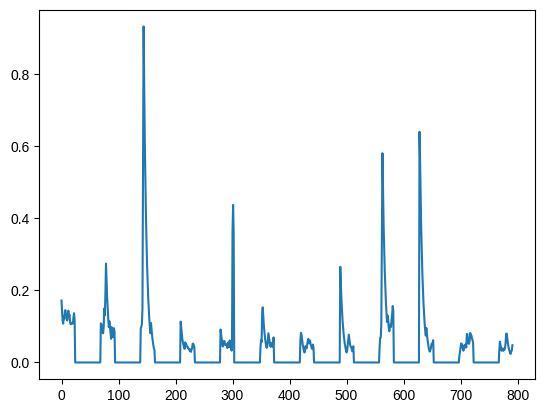

In [16]:
plt.plot(trace_hungry_trial.iloc[4,2:])

### LDA

In [17]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial.index)
trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial.index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before + Bins * i
    end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial.iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial.iloc[:, start_col:end_col].mean(axis=1)


In [18]:
Data = pd.concat([trace_hungry_trial_mean.T, trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [19]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6     \
0  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
1  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
2  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
3  -0.647094  0.265970 -0.079895 -0.272816 -0.200964  1.156085  1.907920   
4   0.154593 -0.033337  0.218026 -0.272816 -0.300209  0.091994  2.201736   
5   0.079217  0.096591  0.130054 -0.272816 -0.024138 -0.125508  2.250857   
6  -0.624096 -0.116571  0.244766 -0.272816 -0.237563  0.242707  1.611144   
7  -0.556780 -0.055457  0.259736 -0.272816 -0.067601  0.002149  0.715335   
8  -0.201054 -0.325891  0.329896 -0.272151  2.266955  1.240387  0.589083   
9   0.136585 -0.128531  2.830170 -0.271415  2.723593  0.498732  0.557405   
10 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
11 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
12 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
13 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
14 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
15  0.709811  0.399970  1.584564  0.717914 -0.396107 -0.342444 -0.238984   
16  0.745487  4.497929  0.573986 -0.241535  0.370955  0.195531 -0.350463   
17  0.962775 -0.265470  0.020735 -0.268447 -0.316678  2.585398 -0.719642   
18  0.321544 -0.229721  2.006775  4.694178 -0.596134 -0.496013 -0.534325   
19  0.643853  0.996499 -0.049727 -0.110565  2.580971  0.299362 -0.207399   
20  3.917723 -0.385683  1.048473  0.045367 -0.274883 -0.566967 -0.502927   
21  0.850557 -0.125813 -0.452052 -0.201099  0.443934  2.758758  0.066631   
22 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
23 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   

        7         8         9     ...      1101      1102      1103      1104  \
0  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
1  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
2  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
3  -0.481968 -0.369986  1.973897  ... -0.241501 -0.208520 -0.229505 -0.274115   
4  -0.018726 -0.270749  0.492540  ... -0.241501 -0.208520 -0.225073 -0.274115   
5   1.266253 -0.379026  1.159047  ... -0.241501 -0.208520 -0.229505 -0.274115   
6   2.161680 -0.189838  2.412600  ... -0.241501  4.795832  4.783632 -0.274115   
7  -0.712327 -0.226712  0.972773  ... -0.241501 -0.208520 -0.229487 -0.274115   
8  -0.263376 -0.379110  0.629097  ... -0.241501 -0.208396 -0.223279 -0.274115   
9  -0.271315 -0.276347 -0.451039  ... -0.241501 -0.208520 -0.229505 -0.274115   
10 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
11 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
12 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
13 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
14 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
15  2.553748  0.356671 -0.460361  ... -0.148519 -0.208520 -0.074705  1.572463   
16  1.951437  1.832584 -0.241910  ... -0.241501 -0.208520 -0.229505 -0.274115   
17  0.128420  4.265118 -0.653388  ... -0.063942 -0.208520 -0.229505 -0.274115   
18  0.192535 -0.078332 -0.520687  ...  0.241251 -0.208520 -0.229505 -0.274115   
19 -0.028171 -0.321966 -0.604914  ...  4.771060 -0.208520 -0.229505 -0.274115   
20  0.913928 -0.309136 -0.376525  ... -0.238766 -0.208520  0.100000  4.458061   
21  0.098919  0.138096  2.298018  ... -0.214062 -0.208520 -0.229504 -0.274115   
22 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
23 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   

        1105      1106      1107      1108      1109      1110  
0  -0.223926 -0.

In [20]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [21]:
Data

0         1         2         3         4         5         6  \
0  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
1  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
2  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
3  -0.647094  0.265970 -0.079895 -0.272816 -0.200964  1.156085  1.907920   
4   0.154593 -0.033337  0.218026 -0.272816 -0.300209  0.091994  2.201736   
5   0.079217  0.096591  0.130054 -0.272816 -0.024138 -0.125508  2.250857   
6  -0.624096 -0.116571  0.244766 -0.272816 -0.237563  0.242707  1.611144   
7  -0.556780 -0.055457  0.259736 -0.272816 -0.067601  0.002149  0.715335   
8  -0.201054 -0.325891  0.329896 -0.272151  2.266955  1.240387  0.589083   
9   0.136585 -0.128531  2.830170 -0.271415  2.723593  0.498732  0.557405   
10 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
11 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
12 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
13 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
14 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
15  0.709811  0.399970  1.584564  0.717914 -0.396107 -0.342444 -0.238984   
16  0.745487  4.497929  0.573986 -0.241535  0.370955  0.195531 -0.350463   
17  0.962775 -0.265470  0.020735 -0.268447 -0.316678  2.585398 -0.719642   
18  0.321544 -0.229721  2.006775  4.694178 -0.596134 -0.496013 -0.534325   
19  0.643853  0.996499 -0.049727 -0.110565  2.580971  0.299362 -0.207399   
20  3.917723 -0.385683  1.048473  0.045367 -0.274883 -0.566967 -0.502927   
21  0.850557 -0.125813 -0.452052 -0.201099  0.443934  2.758758  0.066631   
22 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
23 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   

           7         8         9  ...      1102      1103      1104      1105  \
0  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
1  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
2  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
3  -0.481968 -0.369986  1.973897  ... -0.208520 -0.229505 -0.274115  4.782916   
4  -0.018726 -0.270749  0.492540  ... -0.208520 -0.225073 -0.274115  0.143451   
5   1.266253 -0.379026  1.159047  ... -0.208520 -0.229505 -0.274115 -0.223926   
6   2.161680 -0.189838  2.412600  ...  4.795832  4.783632 -0.274115 -0.223926   
7  -0.712327 -0.226712  0.972773  ... -0.208520 -0.229487 -0.274115 -0.223926   
8  -0.263376 -0.379110  0.629097  ... -0.208396 -0.223279 -0.274115 -0.223925   
9  -0.271315 -0.276347 -0.451039  ... -0.208520 -0.229505 -0.274115 -0.223926   
10 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
11 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
12 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
13 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
14 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
15  2.553748  0.356671 -0.460361  ... -0.208520 -0.074705  1.572463 -0.223926   
16  1.951437  1.832584 -0.241910  ... -0.208520 -0.229505 -0.274115 -0.223925   
17  0.128420  4.265118 -0.653388  ... -0.208520 -0.229505 -0.274115 -0.223926   
18  0.192535 -0.078332 -0.520687  ... -0.208520 -0.229505 -0.274115 -0.223926   
19 -0.028171 -0.321966 -0.604914  ... -0.208520 -0.229505 -0.274115 -0.223926   
20  0.913928 -0.309136 -0.376525  ... -0.208520  0.100000  4.458061 -0.223926   
21  0.098919  0.138096  2.298018  ... -0.208520 -0.229504 -0.274115 -0.223926   
22 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
23 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   

        1106      1107      1108      1109      1110  Label  
0  -0.298790 -0.428081

In [22]:
#Data.to_csv("Calcium Dataset reorganized.csv")

In [23]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Stratified train-test-split
sss = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X, Y):
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

# Training set
Xtrain = Train.iloc[:, 0:Dt.shape[1]-1] 
Ytrain = Train.iloc[:,Dt.shape[1]-1]

# Testing set
Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
Ytest = Test.iloc[:, Dt.shape[1]-1]

print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


In [24]:
# Hyperparameter
solver = ['lsqr', 'eigen']
shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
# shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

# Training process
LDA_ACC_train = []
LDA_AUC_train = []
LDA_ACC_test = []
LDA_AUC_test = []

n = len(Hyperparameter_Space2)

for i in range(0, n):
    # Extract hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[i, :]
    Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
    # Model with hyperparameter
    LDA = LinearDiscriminantAnalysis(**Hyperpara)
    LDA.fit(Xtrain, Ytrain)
    
    # Obtain training metrics
    y_train_pred = LDA.predict(Xtrain)
    y_train_score = LDA.predict_proba(Xtrain)[:, 1]
    
    train_acc = accuracy_score(Ytrain, y_train_pred)
    train_auc = roc_auc_score(Ytrain, y_train_score)
    
    LDA_ACC_train.append(train_acc)
    LDA_AUC_train.append(train_auc)
    
    # Obtain testing metrics
    y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]
    
    test_acc = accuracy_score(Ytest, y_test_pred)
    test_auc = roc_auc_score(Ytest, y_test_score)
    
    LDA_ACC_test.append(test_acc)
    LDA_AUC_test.append(test_auc)
    
# Show training result
Result_LDA = {'Train_Accuracy': LDA_ACC_train,
          'Train_AUC': LDA_AUC_train,
          'Test_Accuracy': LDA_ACC_test,
          'Test_AUC': LDA_AUC_test}
Result_LDA = pd.DataFrame(Result_LDA)
Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)
Result_LDA

solver shrinkage  Train_Accuracy  Train_AUC  Test_Accuracy  Test_AUC
0    lsqr      auto        0.916667   0.972222       0.583333  0.472222
1    lsqr     0.001        0.916667   0.972222       0.666667  0.833333
2    lsqr      0.01        0.916667   0.972222       0.666667  0.833333
3    lsqr       0.1        0.916667   0.972222       0.666667  0.833333
4    lsqr       0.5        0.916667   0.972222       0.666667  0.833333
5    lsqr       0.9        0.916667   0.972222       0.666667  0.833333
6   eigen      auto        0.916667   0.972222       0.583333  0.472222
7   eigen     0.001        0.916667   0.972222       0.666667  0.833333
8   eigen      0.01        0.916667   0.972222       0.666667  0.833333
9   eigen       0.1        0.916667   0.972222       0.666667  0.833333
10  eigen       0.5        0.916667   0.972222       0.666667  0.833333
11  eigen       0.9        0.916667   0.972222       0.666667  0.833333

In [25]:
random.seed = 999
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
Hyperpara_1s = Hyperpara.copy()
def process(i):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    
    # Model with hyperparameter
    LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
    clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
    
    y_pred = clf_shuffle.predict(Xtest)
    y_test_proba = clf_shuffle.predict_proba(Xtest)[:, 1]  # Use predict_proba
    auc = roc_auc_score(Ytest, y_test_proba)  # Compute AUC using probabilities
    
    accuracy = accuracy_score(Ytest, y_pred)
    
    return accuracy, auc

if __name__ == "__main__":
    with Pool(cpu_count()) as p:
        results = p.map(process, range(nump))

    for i, result in enumerate(results):
        accuracy_multisplit_shuffle[i], auc_multisplit_shuffle[i] = result


In [26]:
Hyperpara_1s

{'solver': 'lsqr', 'shrinkage': 0.001}

In [27]:
AUC_True = Result_LDA["Test_AUC"].max()
AUC_True

0.8333333333333334

In [28]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

0.018

In [29]:
auc_multisplit_shuffle.std()

0.12931168382661357

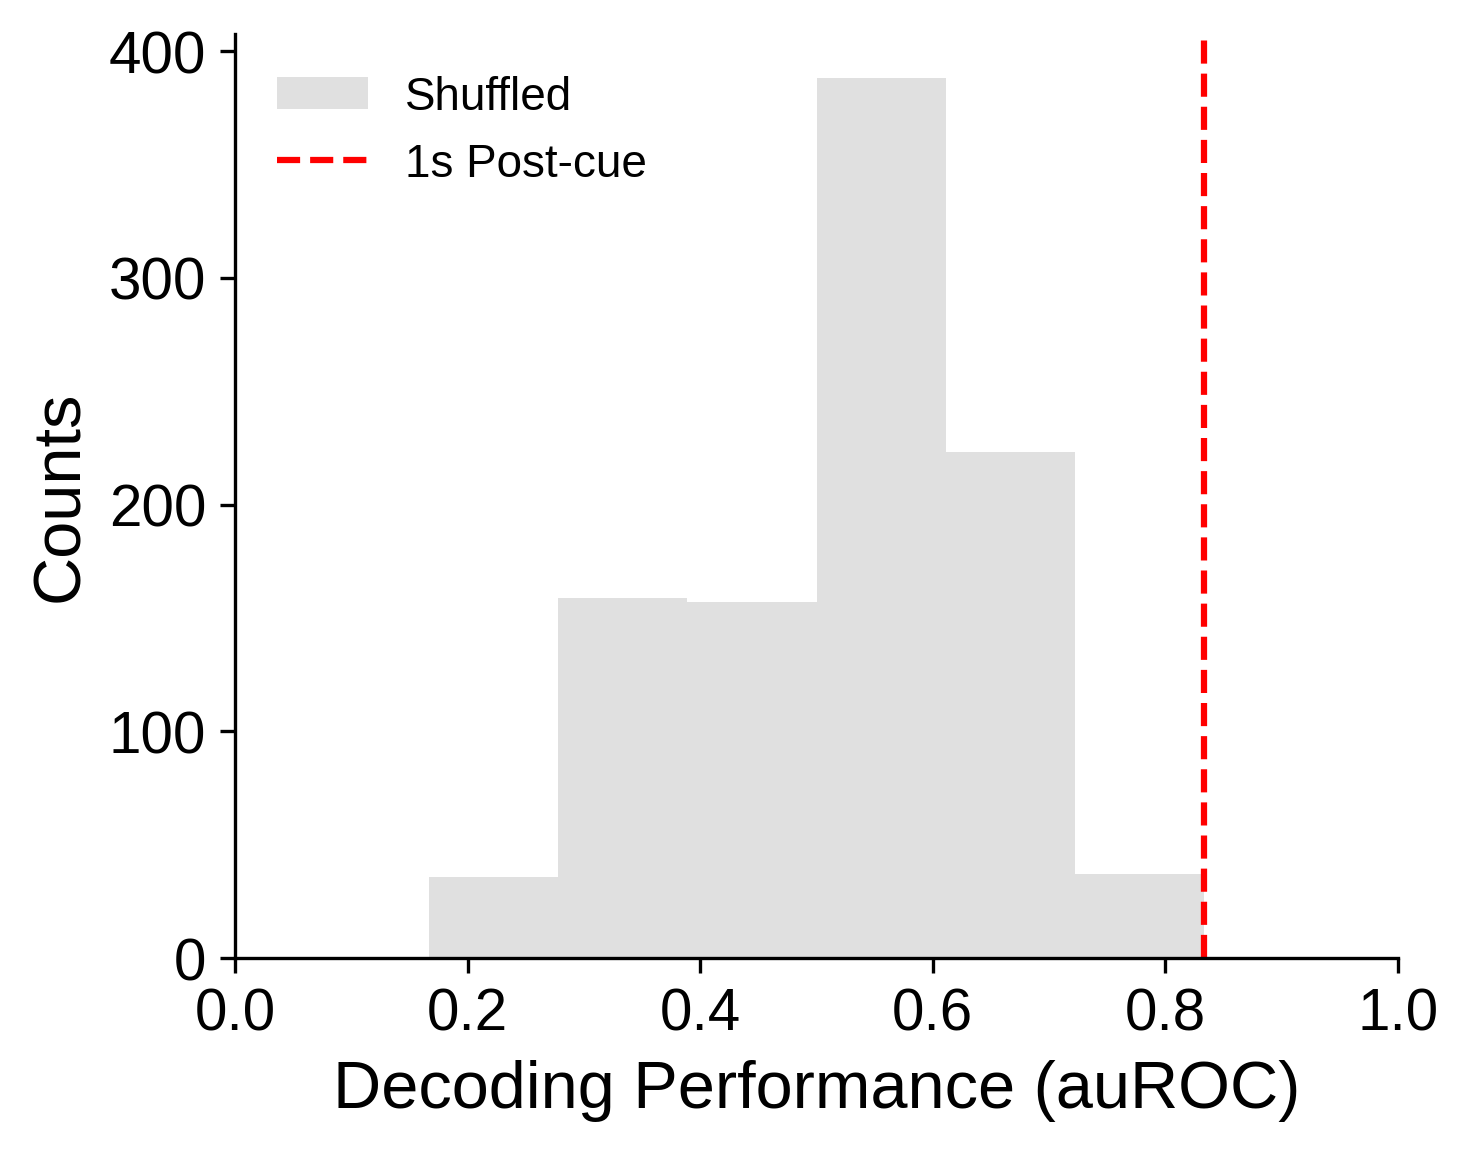

In [30]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=6)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.set_xlim(0,1)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--', label = "1s Post-cue" )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon= False,fontsize =11)

In [709]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial.index)
trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial.index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before +  int(-10 * FR / BinSize) + Bins * i
    end_col = 2 + Bins_before + int(-9 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial.iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial.iloc[:, start_col:end_col].mean(axis=1)


In [721]:
Data = pd.concat([trace_hungry_trial_mean.T, trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
Data

0         1         2         3         4         5         6     \
0   0.043569  0.105579  0.098785  0.077841  0.142262  0.142224  0.457428   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.336696  0.007771  0.042742  0.001303  0.326173  0.127100  0.198277   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        7         8         9     ...  1101  1102  1103  1104      1105  1106  \
0   0.381108  0.042141  0.244091  ...   0.0   0.0   0.0   0.0  0.005258   0.0   
1   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
2   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
3   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
4   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
5   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
6   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
7   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
8   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
9   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
10  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
11  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
12  0.031414  0.000715  0.062599  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
13  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
14  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
15  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
16  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
17  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
18  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
19  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
20  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
21  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
22  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   
23  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0  0.000000   0.0   

        1107  1108      1109  1110  
0   0.004816   0.0  0.066627   0.0  
1   0.0

In [722]:
# ss = StandardScaler(with_mean=True, with_std=True)
# Data = pd.DataFrame(ss.fit_transform(Data))
# Data

<Axes: >

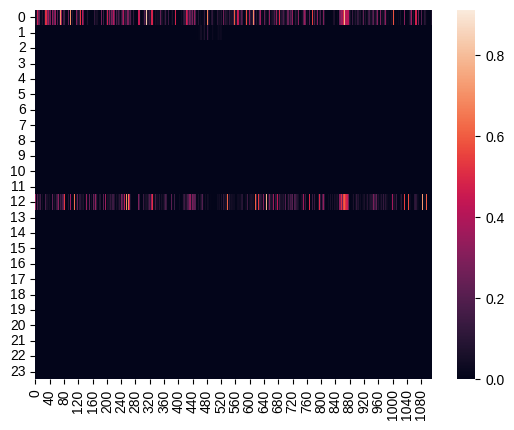

In [723]:
sb.heatmap(Data)

In [724]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [725]:
Data

0         1         2         3         4         5         6  \
0   0.043569  0.105579  0.098785  0.077841  0.142262  0.142224  0.457428   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.336696  0.007771  0.042742  0.001303  0.326173  0.127100  0.198277   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7         8         9  ...  1102  1103  1104      1105  1106  \
0   0.381108  0.042141  0.244091  ...   0.0   0.0   0.0  0.005258   0.0   
1   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
2   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
3   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
4   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
5   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
6   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
7   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
8   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
9   0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
10  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
11  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
12  0.031414  0.000715  0.062599  ...   0.0   0.0   0.0  0.000000   0.0   
13  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
14  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
15  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
16  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
17  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
18  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
19  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
20  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
21  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
22  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   
23  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0  0.000000   0.0   

        1107  1108      1109  1110  Label  
0   0.004816   0.0  0.066627   0.0      1  
1   0.000000   0.0  0.000000   0.0      1  
2   0.000000   0.0  0.000000   0.0      1  
3   0.000000   0.0  0.000000   0.0      1  
4   0.000000  

In [726]:
#Data.to_csv("Calcium Dataset reorganized.csv")

In [727]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Stratified train-test-split
sss = StratifiedKFold(n_splits = 2, random_state = 42, shuffle = True)
for train_index, test_index in sss.split(X, Y):
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

# Training set
Xtrain = Train.iloc[:, 0:Dt.shape[1]-1] 
Ytrain = Train.iloc[:,Dt.shape[1]-1]

# Testing set
Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
Ytest = Test.iloc[:, Dt.shape[1]-1]

print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


In [729]:
# Hyperparameter
solver = ['lsqr']
shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
# shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

# Training process
LDA_ACC_train = []
LDA_AUC_train = []
LDA_ACC_test = []
LDA_AUC_test = []

n = len(Hyperparameter_Space2)

for i in range(0, n):
    # Extract hyperparameter
    Hyper_i = Hyperparameter_Mat2.iloc[i, :]
    Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}
    # Model with hyperparameter
    LDA = LinearDiscriminantAnalysis(**Hyperpara)
    LDA.fit(Xtrain, Ytrain)
    
    # Obtain training metrics
    y_train_pred = LDA.predict(Xtrain)
    y_train_score = LDA.predict_proba(Xtrain)[:, 1]
    
    train_acc = accuracy_score(Ytrain, y_train_pred)
    train_auc = roc_auc_score(Ytrain, y_train_score)
    
    LDA_ACC_train.append(train_acc)
    LDA_AUC_train.append(train_auc)
    
    # Obtain testing metrics
    y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]
    
    test_acc = accuracy_score(Ytest, y_test_pred)
    test_auc = roc_auc_score(Ytest, y_test_score)
    
    LDA_ACC_test.append(test_acc)
    LDA_AUC_test.append(test_auc)
    
# Show training result
Result_LDA = {'Train_Accuracy': LDA_ACC_train,
          'Train_AUC': LDA_AUC_train,
          'Test_Accuracy': LDA_ACC_test,
          'Test_AUC': LDA_AUC_test}
Result_LDA = pd.DataFrame(Result_LDA)
Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)
Result_LDA

solver shrinkage  Train_Accuracy  Train_AUC  Test_Accuracy  Test_AUC
0   lsqr      auto             0.5        0.5            0.5       0.5
1   lsqr     0.001             0.5        0.5            0.5       0.5
2   lsqr      0.01             0.5        0.5            0.5       0.5
3   lsqr       0.1             0.5        0.5            0.5       0.5
4   lsqr       0.5             0.5        0.5            0.5       0.5
5   lsqr       0.9             0.5        0.5            0.5       0.5

In [730]:
random.seed = 999
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

# Extract best hyperparameter
Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA["Test_AUC"].idxmax(), :]
Hyperpara = {'solver': Hyper_i['solver'], 
                 'shrinkage': Hyper_i['shrinkage']}

def process(i):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    
    # Model with hyperparameter
    LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
    clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
    
    y_pred = clf_shuffle.predict(Xtest)
    y_test_proba = LDA.predict_proba(Xtest)[:, 1]  # Use predict_proba
    auc = roc_auc_score(Ytest, y_test_proba)  # Compute AUC using probabilities
    
    accuracy = accuracy_score(Ytest, y_pred)
    
    return accuracy, auc

if __name__ == "__main__":
    with Pool(cpu_count()) as p:
        results = p.map(process, range(nump))

    for i, result in enumerate(results):
        accuracy_multisplit_shuffle[i], auc_multisplit_shuffle[i] = result


In [731]:
AUC_True = Result_LDA["Test_AUC"].max()
AUC_True

0.5

In [732]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

1.0

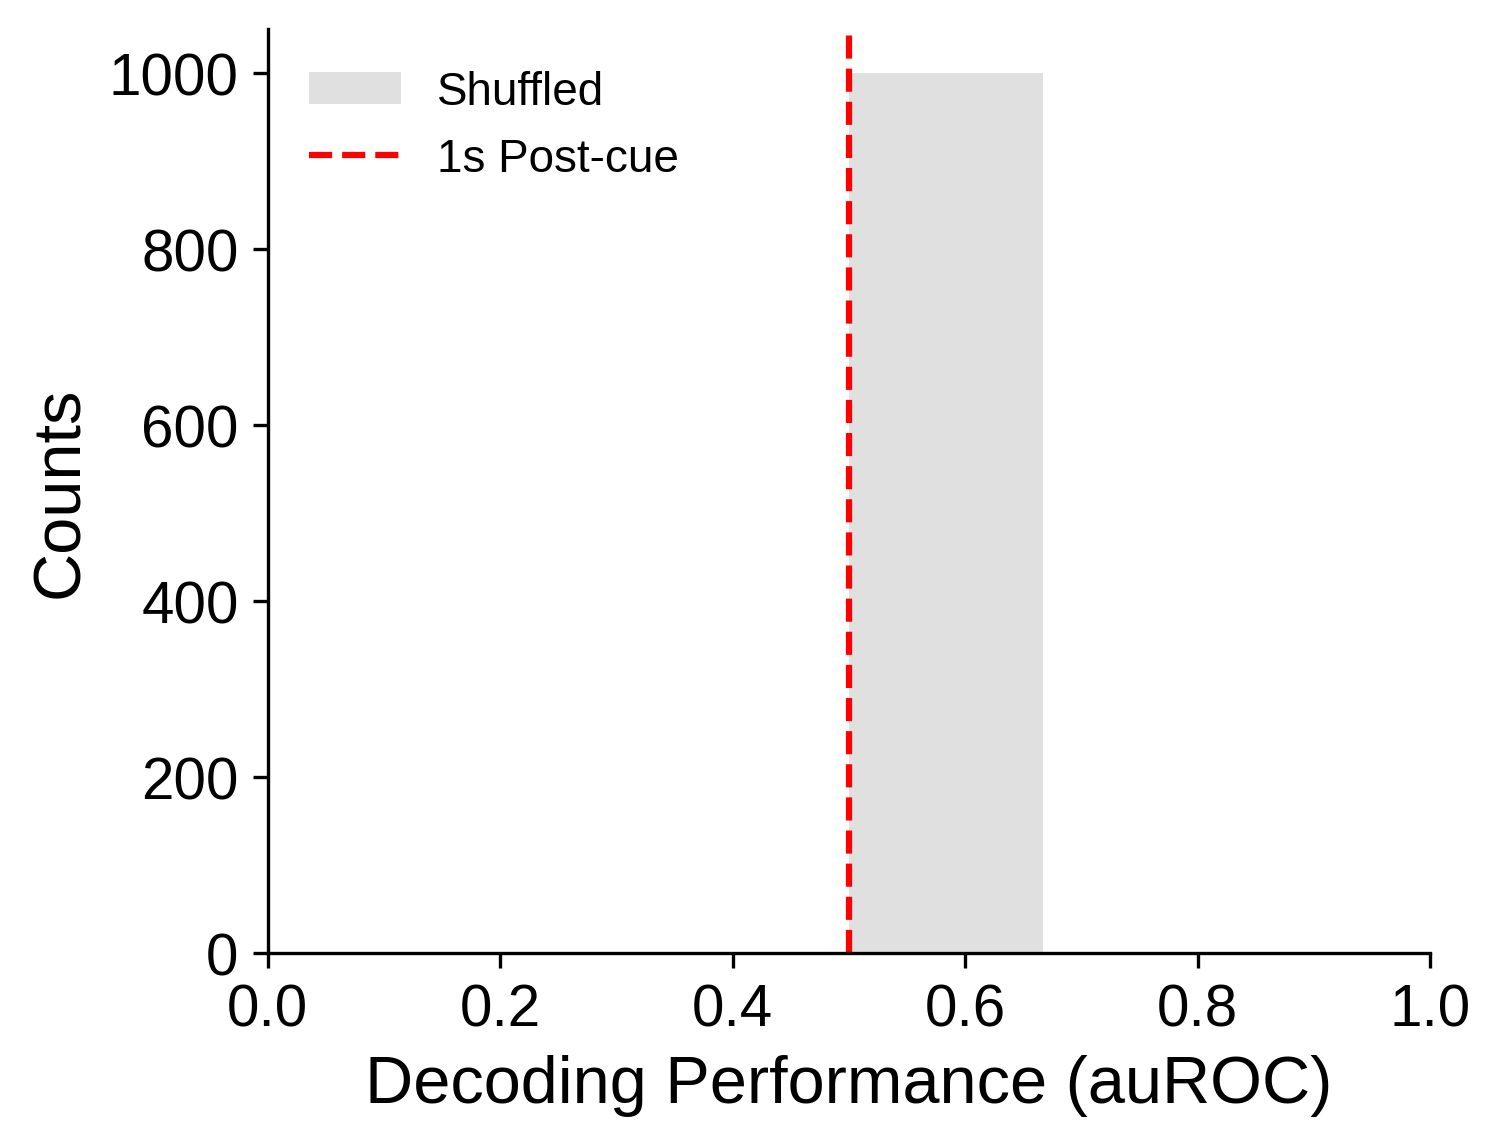

In [733]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=6)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.set_xlim(0,1)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--', label = "1s Post-cue" )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon= False,fontsize =11)

### Multisplit for Cross-Validation

In [916]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial.index)
trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial.index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before + Bins * i
    end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial.iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial.iloc[:, start_col:end_col].mean(axis=1)


In [917]:
Data = pd.concat([trace_hungry_trial_mean.T, trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [918]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6     \
0  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
1  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
2  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
3  -0.647094  0.265970 -0.079895 -0.272816 -0.200964  1.156085  1.907920   
4   0.154593 -0.033337  0.218026 -0.272816 -0.300209  0.091994  2.201736   
5   0.079217  0.096591  0.130054 -0.272816 -0.024138 -0.125508  2.250857   
6  -0.624096 -0.116571  0.244766 -0.272816 -0.237563  0.242707  1.611144   
7  -0.556780 -0.055457  0.259736 -0.272816 -0.067601  0.002149  0.715335   
8  -0.201054 -0.325891  0.329896 -0.272151  2.266955  1.240387  0.589083   
9   0.136585 -0.128531  2.830170 -0.271415  2.723593  0.498732  0.557405   
10 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
11 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
12 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
13 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
14 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
15  0.709811  0.399970  1.584564  0.717914 -0.396107 -0.342444 -0.238984   
16  0.745487  4.497929  0.573986 -0.241535  0.370955  0.195531 -0.350463   
17  0.962775 -0.265470  0.020735 -0.268447 -0.316678  2.585398 -0.719642   
18  0.321544 -0.229721  2.006775  4.694178 -0.596134 -0.496013 -0.534325   
19  0.643853  0.996499 -0.049727 -0.110565  2.580971  0.299362 -0.207399   
20  3.917723 -0.385683  1.048473  0.045367 -0.274883 -0.566967 -0.502927   
21  0.850557 -0.125813 -0.452052 -0.201099  0.443934  2.758758  0.066631   
22 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
23 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   

        7         8         9     ...      1101      1102      1103      1104  \
0  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
1  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
2  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
3  -0.481968 -0.369986  1.973897  ... -0.241501 -0.208520 -0.229505 -0.274115   
4  -0.018726 -0.270749  0.492540  ... -0.241501 -0.208520 -0.225073 -0.274115   
5   1.266253 -0.379026  1.159047  ... -0.241501 -0.208520 -0.229505 -0.274115   
6   2.161680 -0.189838  2.412600  ... -0.241501  4.795832  4.783632 -0.274115   
7  -0.712327 -0.226712  0.972773  ... -0.241501 -0.208520 -0.229487 -0.274115   
8  -0.263376 -0.379110  0.629097  ... -0.241501 -0.208396 -0.223279 -0.274115   
9  -0.271315 -0.276347 -0.451039  ... -0.241501 -0.208520 -0.229505 -0.274115   
10 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
11 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
12 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
13 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
14 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
15  2.553748  0.356671 -0.460361  ... -0.148519 -0.208520 -0.074705  1.572463   
16  1.951437  1.832584 -0.241910  ... -0.241501 -0.208520 -0.229505 -0.274115   
17  0.128420  4.265118 -0.653388  ... -0.063942 -0.208520 -0.229505 -0.274115   
18  0.192535 -0.078332 -0.520687  ...  0.241251 -0.208520 -0.229505 -0.274115   
19 -0.028171 -0.321966 -0.604914  ...  4.771060 -0.208520 -0.229505 -0.274115   
20  0.913928 -0.309136 -0.376525  ... -0.238766 -0.208520  0.100000  4.458061   
21  0.098919  0.138096  2.298018  ... -0.214062 -0.208520 -0.229504 -0.274115   
22 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
23 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   

        1105      1106      1107      1108      1109      1110  
0  -0.223926 -0.

In [919]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [920]:
Data

0         1         2         3         4         5         6  \
0  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
1  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
2  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
3  -0.647094  0.265970 -0.079895 -0.272816 -0.200964  1.156085  1.907920   
4   0.154593 -0.033337  0.218026 -0.272816 -0.300209  0.091994  2.201736   
5   0.079217  0.096591  0.130054 -0.272816 -0.024138 -0.125508  2.250857   
6  -0.624096 -0.116571  0.244766 -0.272816 -0.237563  0.242707  1.611144   
7  -0.556780 -0.055457  0.259736 -0.272816 -0.067601  0.002149  0.715335   
8  -0.201054 -0.325891  0.329896 -0.272151  2.266955  1.240387  0.589083   
9   0.136585 -0.128531  2.830170 -0.271415  2.723593  0.498732  0.557405   
10 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
11 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
12 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
13 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
14 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
15  0.709811  0.399970  1.584564  0.717914 -0.396107 -0.342444 -0.238984   
16  0.745487  4.497929  0.573986 -0.241535  0.370955  0.195531 -0.350463   
17  0.962775 -0.265470  0.020735 -0.268447 -0.316678  2.585398 -0.719642   
18  0.321544 -0.229721  2.006775  4.694178 -0.596134 -0.496013 -0.534325   
19  0.643853  0.996499 -0.049727 -0.110565  2.580971  0.299362 -0.207399   
20  3.917723 -0.385683  1.048473  0.045367 -0.274883 -0.566967 -0.502927   
21  0.850557 -0.125813 -0.452052 -0.201099  0.443934  2.758758  0.066631   
22 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
23 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   

           7         8         9  ...      1102      1103      1104      1105  \
0  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
1  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
2  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
3  -0.481968 -0.369986  1.973897  ... -0.208520 -0.229505 -0.274115  4.782916   
4  -0.018726 -0.270749  0.492540  ... -0.208520 -0.225073 -0.274115  0.143451   
5   1.266253 -0.379026  1.159047  ... -0.208520 -0.229505 -0.274115 -0.223926   
6   2.161680 -0.189838  2.412600  ...  4.795832  4.783632 -0.274115 -0.223926   
7  -0.712327 -0.226712  0.972773  ... -0.208520 -0.229487 -0.274115 -0.223926   
8  -0.263376 -0.379110  0.629097  ... -0.208396 -0.223279 -0.274115 -0.223925   
9  -0.271315 -0.276347 -0.451039  ... -0.208520 -0.229505 -0.274115 -0.223926   
10 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
11 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
12 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
13 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
14 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
15  2.553748  0.356671 -0.460361  ... -0.208520 -0.074705  1.572463 -0.223926   
16  1.951437  1.832584 -0.241910  ... -0.208520 -0.229505 -0.274115 -0.223925   
17  0.128420  4.265118 -0.653388  ... -0.208520 -0.229505 -0.274115 -0.223926   
18  0.192535 -0.078332 -0.520687  ... -0.208520 -0.229505 -0.274115 -0.223926   
19 -0.028171 -0.321966 -0.604914  ... -0.208520 -0.229505 -0.274115 -0.223926   
20  0.913928 -0.309136 -0.376525  ... -0.208520  0.100000  4.458061 -0.223926   
21  0.098919  0.138096  2.298018  ... -0.208520 -0.229504 -0.274115 -0.223926   
22 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
23 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   

        1106      1107      1108      1109      1110  Label  
0  -0.298790 -0.428081

In [921]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Hyperparameter
solver = ['lsqr']
shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
# shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

n_cv = 8
splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results = []
shuffled_auc_results = []

for i in range(n_cv):

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

#     # Training process
#     LDA_ACC_train = []
#     LDA_AUC_train = []
#     LDA_ACC_test = []
#     LDA_AUC_test = []

#     n = len(Hyperparameter_Space2)

#     for i in range(0, n):
#         # Extract hyperparameter
#         Hyper_i = Hyperparameter_Mat2.iloc[i, :]
#         Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

#         # Model with hyperparameter
#         LDA = LinearDiscriminantAnalysis(**Hyperpara)
#         LDA.fit(Xtrain, Ytrain)

#         # Obtain testing metrics
#         y_test_pred = LDA.predict(Xtest)
#         y_test_score = LDA.predict_proba(Xtest)[:, 1]

#         test_auc = roc_auc_score(Ytest, y_test_score)
#         LDA_AUC_test.append(test_auc)

#     # Show training result
#     Result_LDA = {'Test_AUC': LDA_AUC_test}
#     Result_LDA = pd.DataFrame(Result_LDA)
#     Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

#     AUC_True = Result_LDA['Test_AUC'].max()

    LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
    LDA.fit(Xtrain, Ytrain)

    # Obtain testing metrics
#     y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]

    test_auc = roc_auc_score(Ytest, y_test_score)
    auc_results.append(test_auc)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

#     # Extract best hyperparameter
#     Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
#     Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara_1s)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

#         y_pred = clf_shuffle.predict(Xtest)
        y_test_score = clf_shuffle.predict_proba(Xtest)[:, 1]

#         accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_test_score)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results.append(np.mean(auc_multisplit_shuffle))

auc_results = np.array(auc_results)
shuffled_auc_results = np.array(shuffled_auc_results)
print("AUC Results:", auc_results)
print("Shuffled AUC Results:", shuffled_auc_results)


AUC Results: [0.875      0.91666667 0.55555556 0.91666667 0.91666667 0.91666667
 0.875      0.91666667]
Shuffled AUC Results: [0.50213889 0.49458333 0.49283333 0.49491667 0.4945     0.49513889
 0.50119444 0.49616667]


In [750]:
from scipy import stats

# Convert lists to numpy arrays
auc_results = np.array(auc_results)
shuffled_auc_results = np.array(shuffled_auc_results)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results, shuffled_auc_results)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results, shuffled_auc_results)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)


not normal
Test statistic: 0.0
p-value: 0.0078125


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


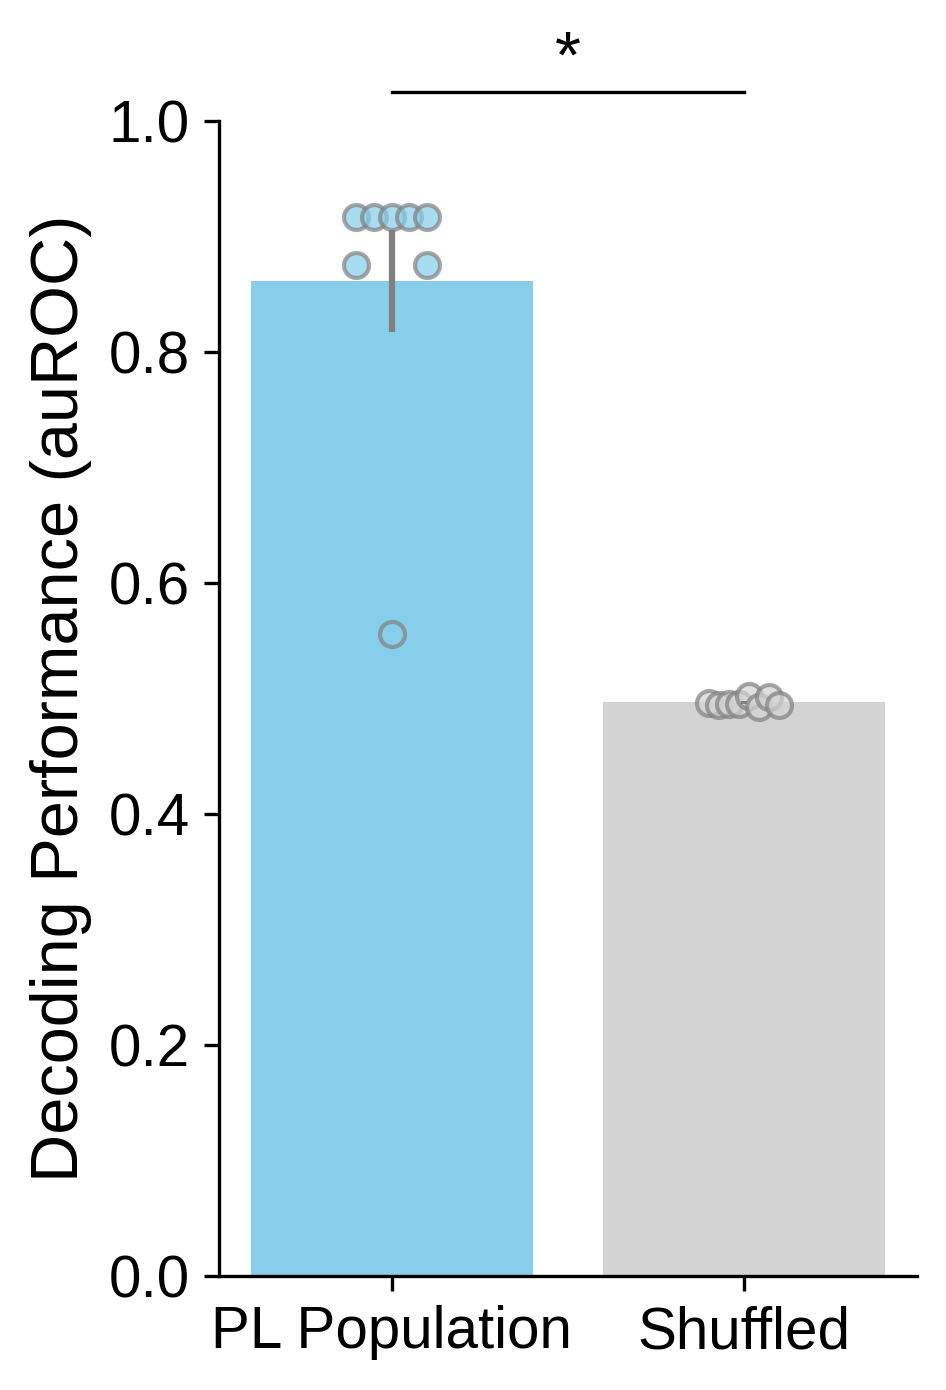

In [751]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results.mean(), yerr=stats.sem(auc_results), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results.mean(), yerr=stats.sem(shuffled_auc_results), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)


## Across animals

In [879]:
animal_ids = np.unique(tracehungry.Animal_ID)

# # Hyperparameter
# solver = ['lsqr', 'eigen']
# shrinkage = ['auto']

# # Put into a matrix
# Hyperparameter_Space2 = [(a,b) 
#                         for a in solver 
#                         for b in shrinkage]
# Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
# Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_by_animal = []
shuffled_auc_results_by_animal = []

for i in range(len(animal_ids)):
    
    # Initialize a DataFrame to hold the mean values for each slice
    trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_ids[i]].index)
    trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_ids[i]].index)

    # Loop to calculate and assign mean values for each of the 12 slices
    for j in range(12):
        start_col = 2 + Bins_before + Bins * j
        end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * j
        # Compute mean across selected columns for each row
        trace_hungry_trial_mean[f'{j}'] = trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_ids[i]].iloc[:, start_col:end_col].mean(axis=1)
        trace_satiated_trial_mean[f'{j}'] = trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_ids[i]].iloc[:, start_col:end_col].mean(axis=1)

    
    Data = pd.concat([trace_hungry_trial_mean.T, 
            trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:Dt.shape[1]-1]
    Y = Dt.iloc[:, Dt.shape[1]-1]

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=999)
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

#     # Training process
#     LDA_ACC_train = []
#     LDA_AUC_train = []
#     LDA_ACC_test = []
#     LDA_AUC_test = []

#     n = len(Hyperparameter_Space2)

#     for i in range(0, n):
#         # Extract hyperparameter
#         Hyper_i = Hyperparameter_Mat2.iloc[i, :]
#         Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

#         # Model with hyperparameter
#         LDA = LinearDiscriminantAnalysis(**Hyperpara)
#         LDA.fit(Xtrain, Ytrain)

#         # Obtain testing metrics
#         y_test_pred = LDA.predict(Xtest)
#         y_test_score = LDA.predict_proba(Xtest)[:, 1]

#         test_auc = roc_auc_score(Ytest, y_test_score)
#         LDA_AUC_test.append(test_auc)

#     # Show training result
#     Result_LDA = {'Test_AUC': LDA_AUC_test}
#     Result_LDA = pd.DataFrame(Result_LDA)
#     Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

#     AUC_True = Result_LDA['Test_AUC'].max()
    LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
    LDA.fit(Xtrain, Ytrain)

    # Obtain testing metrics
#     y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]

    test_auc = roc_auc_score(Ytest, y_test_score)
    auc_results_by_animal.append(test_auc)
    
    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

#     # Extract best hyperparameter
#     Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
#     Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara_1s)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)
        
#         y_pred = clf_shuffle.predict(Xtest)
        y_test_score = clf_shuffle.predict_proba(Xtest)[:, 1]

#         accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_test_score)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results_by_animal.append(np.mean(auc_multisplit_shuffle))

auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)
print("AUC Results:", auc_results_by_animal)
print("Shuffled AUC Results:", shuffled_auc_results_by_animal)


AUC Results: [0.34722222 0.38888889 0.36111111 0.38888889 0.83333333 0.30555556
 0.5        0.94444444 0.94444444 0.61111111 0.83333333 0.66666667
 0.22222222 0.61111111 0.83333333 0.58333333 0.30555556 0.72222222
 0.52777778]
Shuffled AUC Results: [0.50308333 0.49947222 0.50391667 0.50575    0.50061111 0.50822222
 0.50013889 0.49888889 0.49833333 0.50666667 0.50380556 0.50408333
 0.510125   0.50766667 0.5045     0.50301389 0.50763889 0.49338889
 0.50209722]


In [880]:
from scipy import stats

# Convert lists to numpy arrays
auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_by_animal)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results_by_animal)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

not normal
Test statistic: 68.0
p-value: 0.2934989929199219


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


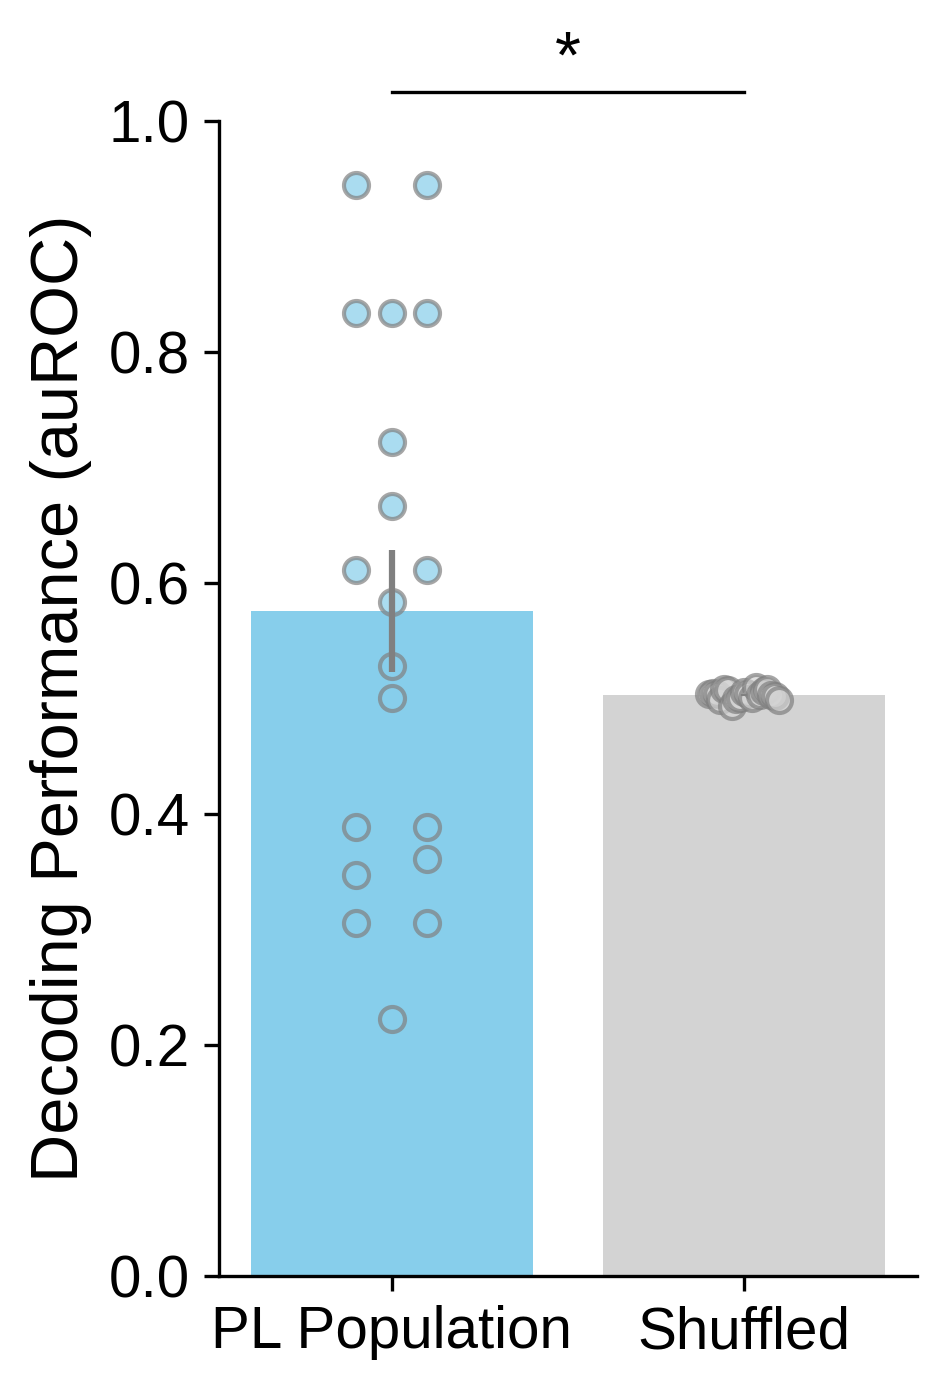

In [881]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal.mean(), yerr=stats.sem(auc_results_by_animal), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results_by_animal.mean(), yerr=stats.sem(shuffled_auc_results_by_animal), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

In [882]:
cluster = pd.read_csv("/scratch/09117/xz6783/Xu/PL_miniscope/PL/Analysis/Behavior/satiated_behavior_cluster.csv", index_col = 0)
cluster.rename(columns={"animal_id": "Animal_ID"}, inplace=True)
cluster

Animal_ID Sex  Cluster_Kmeans
0        9M6   F               0
1        7H6   F               1
2        2N6   M               1
3        6H6   F               0
4        2I5   M               0
5        8H6   F               1
6        1H6   F               0
7        6S5   M               1
8        8S5   M               0
9        7M6   F               1
10       6M6   F               1
11       5B6   F               1
12       1S5   M               1
13       2S5   M               0
14       2Z4   M               0
15       4N6   M               0
16       7B6   F               0
17       4B6   F               0
18       1I5   M               0
19       1B6   F               0

In [883]:
# Create DataFrame
cluster_data = pd.DataFrame(cluster).copy()

# Ensure the Animal_ID column is of type string for proper sorting and matching
cluster_data['Animal_ID'] = cluster_data['Animal_ID'].astype(str)

# Sort cluster data by the order of animal_ids
sorted_df = cluster_data.set_index('Animal_ID').loc[animal_ids].reset_index()

sorted_df

Animal_ID Sex  Cluster_Kmeans
0        1B6   F               0
1        1H6   F               0
2        1I5   M               0
3        1S5   M               1
4        2I5   M               0
5        2N6   M               1
6        2S5   M               0
7        2Z4   M               0
8        4B6   F               0
9        4N6   M               0
10       5B6   F               1
11       6H6   F               0
12       6M6   F               1
13       6S5   M               1
14       7B6   F               0
15       7H6   F               1
16       7M6   F               1
17       8H6   F               1
18       9M6   F               0

In [884]:
sorted_df[auc_results_by_animal<0.5]

Animal_ID Sex  Cluster_Kmeans
0        1B6   F               0
1        1H6   F               0
2        1I5   M               0
3        1S5   M               1
5        2N6   M               1
12       6M6   F               1
16       7M6   F               1

In [888]:
auc_results_by_animal[sorted_df.Cluster_Kmeans ==0].mean()

0.6325757575757577

In [887]:
auc_results_by_animal[sorted_df.Cluster_Kmeans ==1].mean()

0.4965277777777778

In [890]:
%%time
# Hyperparameters
solver = ['lsqr']
shrinkage = ['auto', 0.001]
splits = 2
nump = 1000
n_cv = 8

# Generate Hyperparameter Matrix
Hyperparameter_Space = [(s, sh) for s in solver for sh in shrinkage]
Hyperparameter_Mat = pd.DataFrame(Hyperparameter_Space, columns=['solver', 'shrinkage'])

def perform_lda(Xtrain, Ytrain, Xtest, Ytest, hyperparameters):
    best_auc = 0
    best_params = None
    for solver, shrinkage in hyperparameters:
        params = {'solver': solver, 'shrinkage': shrinkage}
        LDA = LinearDiscriminantAnalysis(**params)
        LDA.fit(Xtrain, Ytrain)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]
        test_auc = roc_auc_score(Ytest, y_test_score)
        if test_auc > best_auc:
            best_auc = test_auc
            best_params = params
    return best_auc, best_params


def shuffle_and_compute_single_run(i, Xtrain, Ytrain, Xtest, Ytest, best_params):
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    LDA = LinearDiscriminantAnalysis(**best_params)
    LDA.fit(Xtrain, Ytrain_shuffle)
    y_pred = LDA.predict_proba(Xtest)[:,1]
    auc = roc_auc_score(Ytest, y_pred)
    return auc

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params, nump):
    with Pool() as pool:
        auc_shuffled = pool.starmap(shuffle_and_compute_single_run, 
                                    [(i, Xtrain, Ytrain, Xtest, Ytest, best_params) for i in range(nump)])
    return np.mean(auc_shuffled)
# Main processing loop
animal_ids = np.unique(tracehungry.Animal_ID)
auc_results_by_animal = []
shuffled_auc_results_by_animal = []

for animal_id in animal_ids:
    trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_id].index)
    trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_id].index)

    # Loop to calculate and assign mean values for each of the 12 slices
    for j in range(12):
        start_col = 2 + Bins_before + Bins * j
        end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * j
        # Compute mean across selected columns for each row
        trace_hungry_trial_mean[f'{j}'] = trace_hungry_trial[trace_hungry_trial.Animal_ID==animal_id].iloc[:, start_col:end_col].mean(axis=1)
        trace_satiated_trial_mean[f'{j}'] = trace_satiated_trial[trace_satiated_trial.Animal_ID==animal_id].iloc[:, start_col:end_col].mean(axis=1)

    
    Data = pd.concat([trace_hungry_trial_mean.T, 
            trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data = pd.DataFrame(ss.fit_transform(Data))
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into features and target
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]

    auc_results_animal = []
    shuffled_auc_results_animal = []

    # Stratified K-Fold Cross-Validation
    sss = StratifiedShuffleSplit(n_splits=n_cv, test_size=0.5, random_state=42)
    for train_index, test_index in sss.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Perform LDA to get the best AUC and corresponding hyperparameters
        best_auc, best_params = perform_lda(Xtrain, Ytrain, Xtest, Ytest, Hyperparameter_Space)
        auc_results_animal.append(best_auc)

        # Now best_params is already a dictionary, so you can directly use it
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_params, nump)
        shuffled_auc_results_animal.append(shuffled_auc)

    # Calculate average AUCs
    auc_results_by_animal.append(np.mean(auc_results_animal))
    shuffled_auc_results_by_animal.append(np.mean(shuffled_auc_results_animal))

# Output the results
print("AUC Results by Animal:", auc_results_by_animal)
print("Shuffled AUC Results by Animal:", shuffled_auc_results_by_animal)


AUC Results by Animal: [0.578125, 0.6684027777777778, 0.6059027777777778, 0.8489583333333334, 0.6961805555555556, 0.7482638888888888, 0.796875, 0.8871527777777778, 0.8871527777777778, 0.859375, 0.734375, 0.859375, 0.828125, 0.8107638888888888, 0.8315972222222222, 0.6059027777777777, 0.6927083333333334, 0.8003472222222222, 0.7934027777777777]
Shuffled AUC Results by Animal: [0.5021371527777778, 0.497921875, 0.4992743055555556, 0.4982430555555556, 0.49835243055555556, 0.49666493055555555, 0.5002690972222222, 0.4990486111111111, 0.49762847222222223, 0.49787326388888886, 0.49804340277777776, 0.5005052083333333, 0.49783680555555554, 0.4984965277777778, 0.49939930555555556, 0.49883854166666663, 0.49896875, 0.4971319444444444, 0.49394444444444446]
CPU times: user 32.7 s, sys: 2min 25s, total: 2min 58s
Wall time: 4min 50s


In [891]:
auc_results_by_animal

[0.578125,
 0.6684027777777778,
 0.6059027777777778,
 0.8489583333333334,
 0.6961805555555556,
 0.7482638888888888,
 0.796875,
 0.8871527777777778,
 0.8871527777777778,
 0.859375,
 0.734375,
 0.859375,
 0.828125,
 0.8107638888888888,
 0.8315972222222222,
 0.6059027777777777,
 0.6927083333333334,
 0.8003472222222222,
 0.7934027777777777]

In [892]:
from scipy import stats

# Convert lists to numpy arrays
auc_results_by_animal = np.array(auc_results_by_animal)
shuffled_auc_results_by_animal = np.array(shuffled_auc_results_by_animal)

# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_by_animal)
k2, p_normal_shuffled_auc = stats.normaltest(shuffled_auc_results_by_animal)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_rel(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.wilcoxon(auc_results_by_animal, shuffled_auc_results_by_animal)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

not normal
Test statistic: 0.0
p-value: 3.814697265625e-06


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


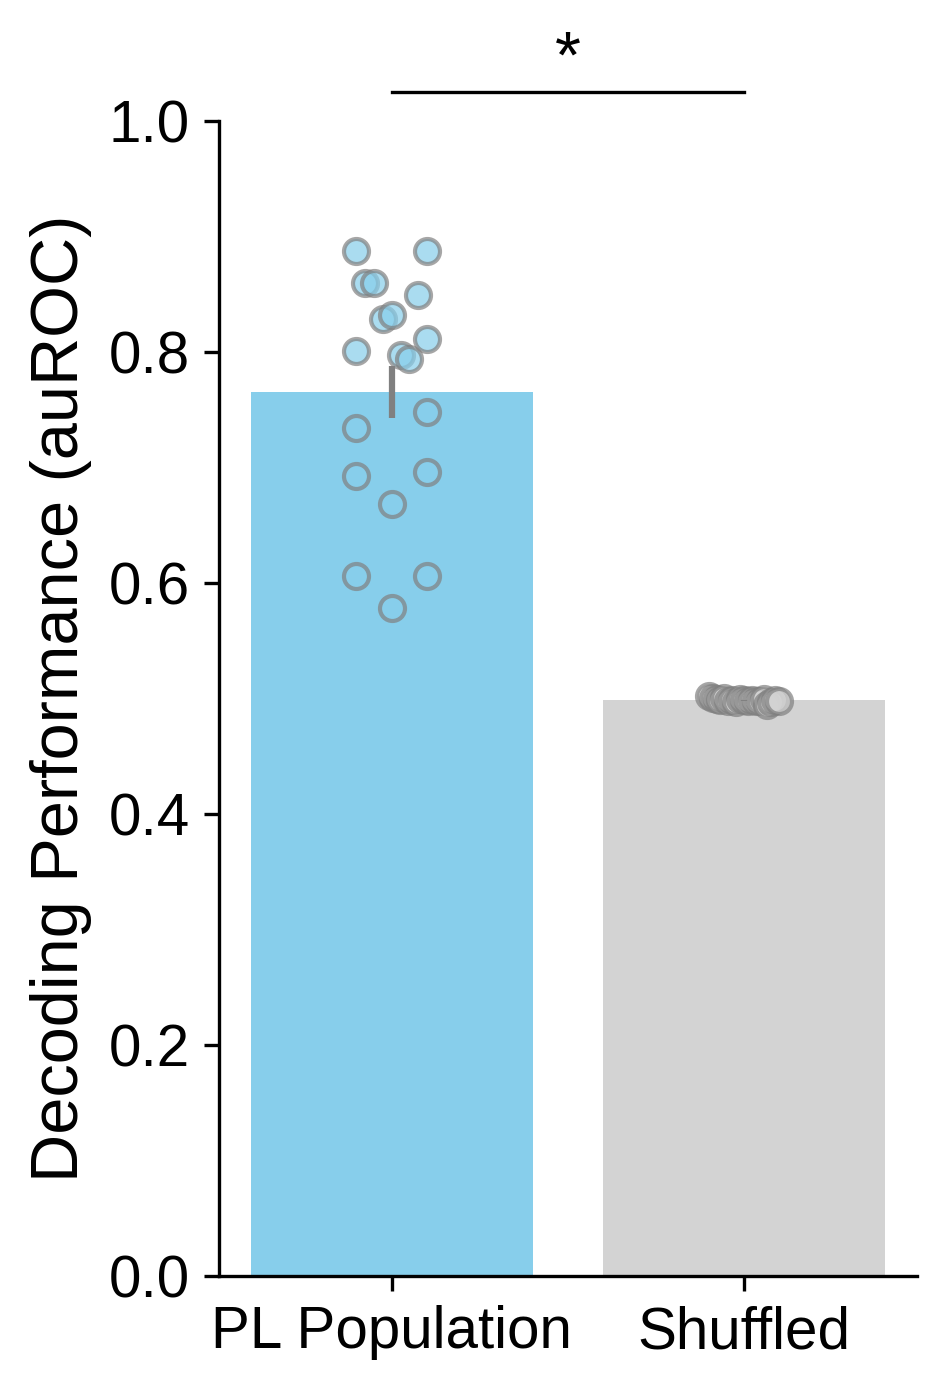

In [893]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_by_animal.mean(), yerr=stats.sem(auc_results_by_animal), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,shuffled_auc_results_by_animal.mean(), yerr=stats.sem(shuffled_auc_results_by_animal), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
x1, x2 = 1, 1.5
y, h, col = 1.025, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(shuffled_auc_results_by_animal, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

In [894]:
sorted_df[auc_results_by_animal<0.8]

Animal_ID Sex  Cluster_Kmeans
0        1B6   F               0
1        1H6   F               0
2        1I5   M               0
4        2I5   M               0
5        2N6   M               1
6        2S5   M               0
10       5B6   F               1
15       7H6   F               1
16       7M6   F               1
18       9M6   F               0

In [896]:
stats.ttest_ind(auc_results_by_animal[sorted_df.Cluster_Kmeans ==0], auc_results_by_animal[sorted_df.Cluster_Kmeans ==1])

Ttest_indResult(statistic=0.22842264084946612, pvalue=0.8220427499252754)

In [897]:
stats.mannwhitneyu(auc_results_by_animal[sorted_df.Cluster_Kmeans ==0], auc_results_by_animal[sorted_df.Cluster_Kmeans ==1])

MannwhitneyuResult(statistic=51.0, pvalue=0.5911355058927337)

## Cluster sebset

In [898]:
trace_hungry_trial_merged = pd.merge(trace_hungry_trial, cluster, on="Animal_ID", how="left")
columns = ['Animal_ID', 'cell_id', 'Sex','Cluster_Kmeans'] + [col for col in trace_hungry_trial_merged.columns if col not in ['Animal_ID', 'cell_id', 'Sex', 'Cluster_Kmeans', 'Cluster_Meanshift']]
trace_hungry_trial_merged = trace_hungry_trial_merged[columns]
trace_hungry_trial_merged

Animal_ID cell_id Sex  Cluster_Kmeans         0         1         2  \
0          6S5       1   M               1  0.048871  0.043362  0.038474   
1          6S5       2   M               1  0.122158  0.104752  0.089826   
2          6S5       3   M               1  0.085015  0.086207  0.125133   
3          6S5       4   M               1  0.083966  0.072425  0.077132   
4          6S5       5   M               1  0.171843  0.139912  0.115031   
...        ...     ...  ..             ...       ...       ...       ...   
1106       8H6      63   F               1  0.000000  0.000000  0.000000   
1107       8H6      71   F               1  0.005952  0.004733  0.003764   
1108       8H6      73   F               1  0.000000  0.000000  0.000000   
1109       8H6      75   F               1  0.095900  0.062303  0.041679   
1110       8H6      97   F               1  0.000000  0.000000  0.000000   

             3         4         5  ...           782           783  \
0     0.034136  0.030288  0.026874  ...  3.974344e-03  6.030986e-03   
1     0.077027  0.066052  0.059230  ...  1.043822e-01  8.952634e-02   
2     0.130049  0.126104  0.122277  ...  3.151087e-02  3.066114e-02   
3     0.125345  0.110695  0.093033  ...  1.331473e-09  5.521133e-10   
4     0.107707  0.128624  0.120002  ...  6.533369e-02  5.319358e-02   
...        ...       ...       ...  ...           ...           ...   
1106  0.000000  0.000000  0.000000  ...  8.794528e-04  6.837670e-04   
1107  0.055577  0.103475  0.082285  ...  9.612224e-09  7.645669e-09   
1108  0.000000  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
1109  0.057826  0.057196  0.037158  ...  8.226251e-01  5.344273e-01   
1110  0.000000  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   

               784           785           786           787           788  \
0     1.014926e-02  2.515786e-02  2.915141e-02  3.508264e-02  4.170854e-02   
1     7.808811e-02  6.696168e-02  5.742062e-02  4.923901e-02  4.222317e-02   
2     2.975629e-02  3.148841e-02  3.659613e-02  3.823047e-02  3.707051e-02   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     4.330932e-02  3.669060e-02  3.083013e-02  2.510137e-02  2.403390e-02   
...            ...           ...           ...           ...           ...   
1106  5.316229e-04  4.133323e-04  3.213623e-04  2.498564e-04  1.942612e-04   
1107  6.081879e-09  4.838380e-09  3.849597e-09  3.063390e-09  2.438310e-09   
1108  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1109  3.471965e-01  2.255600e-01  1.465375e-01  9.519969e-02  6.184752e-02   
1110  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               789           790           791  
0     4.848508e-02  4.927904e-02  4.388409e-02  
1     4.130692e-02  5.240088e-02  5.668800e-02  
2     3.594574e-02  4.256875e-02  4.228785e-02  
3     0.000000e+00  0.000000e+00  0.000000e+00  
4     3.080924e-02  3.415428e-02  4.791318e-02  
...            ...           ...           ...  
1106  1.510364e-04  1.174295e-04  9.130043e-05  
1107  1.941306e-09  1.546140e-09  1.232012e-09  
1108  0.000000e+00  0.000000e+00  0.000000e+00  
1109  4.017991e-02  2.610332e-02  1.695830e-02  
1110  0.000000e+00  0.000000e+00  0.000000e+00  

[1111 rows x 796 columns]

In [899]:
trace_satiated_trial_merged = pd.merge(trace_satiated_trial, cluster, on="Animal_ID", how="left")
columns = ['Animal_ID', 'cell_id', 'Sex','Cluster_Kmeans'] + [col for col in trace_satiated_trial_merged.columns if col not in ['Animal_ID', 'cell_id', 'Sex', 'Cluster_Kmeans', 'Cluster_Meanshift']]
trace_satiated_trial_merged = trace_satiated_trial_merged[columns]
trace_satiated_trial_merged

Animal_ID cell_id Sex  Cluster_Kmeans         0         1         2  \
0          6S5       1   M               1  0.306320  0.310118  0.393649   
1          6S5       2   M               1  0.008991  0.007710  0.006611   
2          6S5       3   M               1  0.043672  0.042347  0.042208   
3          6S5       4   M               1  0.000000  0.000000  0.003909   
4          6S5       5   M               1  0.008938  0.260965  0.708616   
...        ...     ...  ..             ...       ...       ...       ...   
1106       8H6      63   F               1  0.000000  0.000000  0.000000   
1107       8H6      71   F               1  0.000000  0.000000  0.000000   
1108       8H6      73   F               1  0.000000  0.000000  0.000000   
1109       8H6      75   F               1  0.000000  0.000000  0.000000   
1110       8H6      97   F               1  0.000000  0.000000  0.000000   

             3         4         5  ...       782       783       784  \
0     0.367536  0.326103  0.289340  ...  0.229236  0.203394  0.192580   
1     0.005669  0.012160  0.021744  ...  0.168736  0.174182  0.154188   
2     0.042300  0.041017  0.039772  ...  0.029156  0.033315  0.041710   
3     0.006065  0.005097  0.004284  ...  0.025801  0.021685  0.018225   
4     0.840072  0.691130  0.562706  ...  0.195834  0.159445  0.129817   
...        ...       ...       ...  ...       ...       ...       ...   
1106  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1107  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1108  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1109  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1110  0.000000  0.000000  0.000000  ...  0.027127  0.702185  0.816681   

           785       786       787       788       789       790       791  
0     0.258823  0.229932  0.227126  0.311740  0.317010  0.310176  0.316850  
1     0.132219  0.113379  0.097224  0.083371  0.071492  0.061306  0.052570  
2     0.041318  0.040311  0.039088  0.037902  0.036752  0.035637  0.034556  
3     0.015317  0.022169  0.037048  0.031137  0.026169  0.021993  0.018484  
4     0.105695  0.086055  0.070065  0.057045  0.046445  0.037815  0.030788  
...        ...       ...       ...       ...       ...       ...       ...  
1106  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1107  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1108  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1110  0.816738  0.702646  0.510475  0.370863  0.269433  0.195744  0.142209  

[1111 rows x 796 columns]

In [900]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial[trace_hungry_trial_merged.Cluster_Kmeans == 0].index)
trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial[trace_satiated_trial_merged.Cluster_Kmeans == 0].index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before + Bins * i
    end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial[trace_hungry_trial_merged.Cluster_Kmeans == 0].iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial[trace_satiated_trial_merged.Cluster_Kmeans == 0].iloc[:, start_col:end_col].mean(axis=1)


In [901]:
Data = pd.concat([trace_hungry_trial_mean.T, trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [902]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6    \
0  -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
1  -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
2  -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
3  -0.633088 -0.557792 -0.576024 -0.599748  1.762433 -0.302205  3.098046   
4  -0.635040 -0.558271 -0.576024 -0.567271 -0.673824  3.989733 -0.219661   
5  -0.571640 -0.557879 -0.576024 -0.011359 -0.648724  0.439865 -0.478654   
6  -0.565373 -0.523123 -0.576024  0.047709 -0.583765 -0.335919 -0.223026   
7  -0.546912 -0.558269 -0.576024 -0.605408  0.054728 -0.335961  1.321611   
8  -0.634777 -0.558153 -0.576024 -0.605310  0.967872 -0.210548  0.949822   
9   1.004384  0.852842 -0.576024 -0.605429 -0.063072 -0.316543  0.194587   
10 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
11 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
12 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
13 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
14 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
15  1.763860  1.874963  1.287036  1.565037  0.568661 -0.335908 -0.212297   
16  2.247748  1.580240  1.699529  2.731829  2.690946 -0.335961 -0.244615   
17  1.352461  0.771353  2.230946  1.341633  0.121183  2.379821 -0.364818   
18 -0.325569 -0.367634  2.512641  0.247833 -0.470008 -0.317488 -0.474688   
19  2.322882  3.313152 -0.164323 -0.463562  2.499864 -0.335960  2.789610   
20  0.981496  0.771640  1.018000  2.072372  0.334844 -0.288193 -0.492323   
21  0.589970  0.099637  1.208580  1.505969  0.177725 -0.335122 -0.444124   
22 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
23 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   

         7         8         9    ...       720       721       722       723  \
0  -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
1  -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
2  -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
3  -0.361916 -0.335293  0.789160  ...  0.537262  0.249972 -0.011964  0.319783   
4  -0.543334 -0.262858  3.936943  ...  0.235381  0.061924 -0.236928  0.855449   
5  -0.448711 -0.277944  1.167005  ...  0.280821 -0.196949 -0.150740  0.233968   
6  -0.405705 -0.270280  1.672923  ...  0.235409  0.429906  0.114172 -0.034201   
7  -0.543453 -0.463410  0.502807  ...  0.232143  2.507694 -0.243509  1.716059   
8  -0.543855 -0.463419 -0.405803  ...  0.387336 -0.166343 -0.152722  0.387698   
9  -0.543856 -0.462981 -0.238053  ...  0.772802 -0.215171 -0.243624 -0.458670   
10 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
11 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
12 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
13 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
14 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
15  3.405208  3.562046 -0.435767  ...  0.907725  3.383544 -0.201804 -0.329998   
16  0.971749  0.759251 -0.436984  ...  0.520630 -0.392684 -0.243624 -0.581234   
17  2.224727  2.678392 -0.437014  ...  1.003618  0.423790  4.778735  1.855566   
18  0.720407  0.485222 -0.434074  ...  2.992505  0.303101 -0.243624  3.421842   
19  1.087433 -0.438283 -0.437014  ...  0.362851 -0.379295 -0.243531 -0.529877   
20  0.415343  0.022227 -0.437014  ...  0.692574  0.828544 -0.241010 -0.495569   
21  0.004520  0.101526 -0.436974  ...  0.931033 -0.024379 -0.243589 -0.546714   
22 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   
23 -0.543856 -0.463419 -0.437014  ... -1.009209 -0.681366 -0.243624 -0.581410   

         724       725       726       727       728       729  
0  -0.344627 -0.2

In [903]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [904]:
Data

0         1         2         3         4         5         6  \
0  -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
1  -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
2  -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
3  -0.633088 -0.557792 -0.576024 -0.599748  1.762433 -0.302205  3.098046   
4  -0.635040 -0.558271 -0.576024 -0.567271 -0.673824  3.989733 -0.219661   
5  -0.571640 -0.557879 -0.576024 -0.011359 -0.648724  0.439865 -0.478654   
6  -0.565373 -0.523123 -0.576024  0.047709 -0.583765 -0.335919 -0.223026   
7  -0.546912 -0.558269 -0.576024 -0.605408  0.054728 -0.335961  1.321611   
8  -0.634777 -0.558153 -0.576024 -0.605310  0.967872 -0.210548  0.949822   
9   1.004384  0.852842 -0.576024 -0.605429 -0.063072 -0.316543  0.194587   
10 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
11 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
12 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
13 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
14 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
15  1.763860  1.874963  1.287036  1.565037  0.568661 -0.335908 -0.212297   
16  2.247748  1.580240  1.699529  2.731829  2.690946 -0.335961 -0.244615   
17  1.352461  0.771353  2.230946  1.341633  0.121183  2.379821 -0.364818   
18 -0.325569 -0.367634  2.512641  0.247833 -0.470008 -0.317488 -0.474688   
19  2.322882  3.313152 -0.164323 -0.463562  2.499864 -0.335960  2.789610   
20  0.981496  0.771640  1.018000  2.072372  0.334844 -0.288193 -0.492323   
21  0.589970  0.099637  1.208580  1.505969  0.177725 -0.335122 -0.444124   
22 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   
23 -0.635040 -0.558271 -0.576024 -0.605429 -0.673886 -0.335961 -0.519947   

           7         8         9  ...       721       722       723       724  \
0  -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
1  -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
2  -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
3  -0.361916 -0.335293  0.789160  ...  0.249972 -0.011964  0.319783 -0.283839   
4  -0.543334 -0.262858  3.936943  ...  0.061924 -0.236928  0.855449 -0.259230   
5  -0.448711 -0.277944  1.167005  ... -0.196949 -0.150740  0.233968  0.138501   
6  -0.405705 -0.270280  1.672923  ...  0.429906  0.114172 -0.034201  0.004900   
7  -0.543453 -0.463410  0.502807  ...  2.507694 -0.243509  1.716059 -0.251280   
8  -0.543855 -0.463419 -0.405803  ... -0.166343 -0.152722  0.387698  1.224022   
9  -0.543856 -0.462981 -0.238053  ... -0.215171 -0.243624 -0.458670  0.080822   
10 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
11 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
12 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
13 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
14 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
15  3.405208  3.562046 -0.435767  ...  3.383544 -0.201804 -0.329998 -0.342898   
16  0.971749  0.759251 -0.436984  ... -0.392684 -0.243624 -0.581234 -0.329858   
17  2.224727  2.678392 -0.437014  ...  0.423790  4.778735  1.855566 -0.033376   
18  0.720407  0.485222 -0.434074  ...  0.303101 -0.243624  3.421842 -0.339943   
19  1.087433 -0.438283 -0.437014  ... -0.379295 -0.243531 -0.529877  4.527370   
20  0.415343  0.022227 -0.437014  ...  0.828544 -0.241010 -0.495569 -0.344447   
21  0.004520  0.101526 -0.436974  ... -0.024379 -0.243589 -0.546714 -0.344476   
22 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   
23 -0.543856 -0.463419 -0.437014  ... -0.681366 -0.243624 -0.581410 -0.344627   

         725       726       727       728       729  Label  
0  -0.296619 -0.575965

In [906]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Hyperparameter
solver = ['lsqr']
shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
# shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

n_cv = 8
splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_cluster0 = []
shuffled_auc_results_cluster0 = []

for i in range(n_cv):

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

#     # Training process
#     LDA_ACC_train = []
#     LDA_AUC_train = []
#     LDA_ACC_test = []
#     LDA_AUC_test = []

#     n = len(Hyperparameter_Space2)

#     for i in range(0, n):
#         # Extract hyperparameter
#         Hyper_i = Hyperparameter_Mat2.iloc[i, :]
#         Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

#         # Model with hyperparameter
#         LDA = LinearDiscriminantAnalysis(**Hyperpara)
#         LDA.fit(Xtrain, Ytrain)

#         # Obtain testing metrics
#         y_test_pred = LDA.predict(Xtest)
#         y_test_score = LDA.predict_proba(Xtest)[:, 1]

#         test_auc = roc_auc_score(Ytest, y_test_score)
#         LDA_AUC_test.append(test_auc)

#     # Show training result
#     Result_LDA = {'Test_AUC': LDA_AUC_test}
#     Result_LDA = pd.DataFrame(Result_LDA)
#     Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

#     AUC_True = Result_LDA['Test_AUC'].max()

    LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
    LDA.fit(Xtrain, Ytrain)

    # Obtain testing metrics
#     y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]

    test_auc = roc_auc_score(Ytest, y_test_score)
    auc_results_cluster0.append(test_auc)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

#     # Extract best hyperparameter
#     Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
#     Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara_1s)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

#         y_pred = clf_shuffle.predict(Xtest)
        y_test_score = clf_shuffle.predict_proba(Xtest)[:, 1]

#         accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_test_score)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results_cluster0.append(np.mean(auc_multisplit_shuffle))

auc_results_cluster0 = np.array(auc_results_cluster0)
shuffled_auc_results_cluster0 = np.array(shuffled_auc_results_cluster0)
print("AUC Results:", auc_results_cluster0)
print("Shuffled AUC Results:", shuffled_auc_results_cluster0)


AUC Results: [0.875      0.91666667 0.66666667 0.91666667 0.91666667 0.91666667
 0.875      0.91666667]
Shuffled AUC Results: [0.50044444 0.49419444 0.49602778 0.49466667 0.49513889 0.49169444
 0.50281944 0.49744444]


In [907]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial[trace_hungry_trial_merged.Cluster_Kmeans == 1].index)
trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial[trace_satiated_trial_merged.Cluster_Kmeans == 1].index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before + Bins * i
    end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial[trace_hungry_trial_merged.Cluster_Kmeans == 1].iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial[trace_satiated_trial_merged.Cluster_Kmeans == 1].iloc[:, start_col:end_col].mean(axis=1)


In [908]:
Data = pd.concat([trace_hungry_trial_mean.T, trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [909]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6    \
0  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
1  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
2  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
3  -0.647094  0.265970 -0.079895 -0.272816 -0.200964  1.156085  1.907920   
4   0.154593 -0.033337  0.218026 -0.272816 -0.300209  0.091994  2.201736   
5   0.079217  0.096591  0.130054 -0.272816 -0.024138 -0.125508  2.250857   
6  -0.624096 -0.116571  0.244766 -0.272816 -0.237563  0.242707  1.611144   
7  -0.556780 -0.055457  0.259736 -0.272816 -0.067601  0.002149  0.715335   
8  -0.201054 -0.325891  0.329896 -0.272151  2.266955  1.240387  0.589083   
9   0.136585 -0.128531  2.830170 -0.271415  2.723593  0.498732  0.557405   
10 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
11 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
12 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
13 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
14 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
15  0.709811  0.399970  1.584564  0.717914 -0.396107 -0.342444 -0.238984   
16  0.745487  4.497929  0.573986 -0.241535  0.370955  0.195531 -0.350463   
17  0.962775 -0.265470  0.020735 -0.268447 -0.316678  2.585398 -0.719642   
18  0.321544 -0.229721  2.006775  4.694178 -0.596134 -0.496013 -0.534325   
19  0.643853  0.996499 -0.049727 -0.110565  2.580971  0.299362 -0.207399   
20  3.917723 -0.385683  1.048473  0.045367 -0.274883 -0.566967 -0.502927   
21  0.850557 -0.125813 -0.452052 -0.201099  0.443934  2.758758  0.066631   
22 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
23 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   

         7         8         9    ...       371       372       373       374  \
0  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
1  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
2  -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
3  -0.481968 -0.369986  1.973897  ... -0.241501 -0.208520 -0.229505 -0.274115   
4  -0.018726 -0.270749  0.492540  ... -0.241501 -0.208520 -0.225073 -0.274115   
5   1.266253 -0.379026  1.159047  ... -0.241501 -0.208520 -0.229505 -0.274115   
6   2.161680 -0.189838  2.412600  ... -0.241501  4.795832  4.783632 -0.274115   
7  -0.712327 -0.226712  0.972773  ... -0.241501 -0.208520 -0.229487 -0.274115   
8  -0.263376 -0.379110  0.629097  ... -0.241501 -0.208396 -0.223279 -0.274115   
9  -0.271315 -0.276347 -0.451039  ... -0.241501 -0.208520 -0.229505 -0.274115   
10 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
11 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
12 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
13 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
14 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
15  2.553748  0.356671 -0.460361  ... -0.148519 -0.208520 -0.074705  1.572463   
16  1.951437  1.832584 -0.241910  ... -0.241501 -0.208520 -0.229505 -0.274115   
17  0.128420  4.265118 -0.653388  ... -0.063942 -0.208520 -0.229505 -0.274115   
18  0.192535 -0.078332 -0.520687  ...  0.241251 -0.208520 -0.229505 -0.274115   
19 -0.028171 -0.321966 -0.604914  ...  4.771060 -0.208520 -0.229505 -0.274115   
20  0.913928 -0.309136 -0.376525  ... -0.238766 -0.208520  0.100000  4.458061   
21  0.098919  0.138096  2.298018  ... -0.214062 -0.208520 -0.229504 -0.274115   
22 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   
23 -0.749104 -0.379127 -0.662915  ... -0.241501 -0.208520 -0.229505 -0.274115   

         375       376       377       378       379       380  
0  -0.223926 -0.2

In [910]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [911]:
Data

0         1         2         3         4         5         6  \
0  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
1  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
2  -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
3  -0.647094  0.265970 -0.079895 -0.272816 -0.200964  1.156085  1.907920   
4   0.154593 -0.033337  0.218026 -0.272816 -0.300209  0.091994  2.201736   
5   0.079217  0.096591  0.130054 -0.272816 -0.024138 -0.125508  2.250857   
6  -0.624096 -0.116571  0.244766 -0.272816 -0.237563  0.242707  1.611144   
7  -0.556780 -0.055457  0.259736 -0.272816 -0.067601  0.002149  0.715335   
8  -0.201054 -0.325891  0.329896 -0.272151  2.266955  1.240387  0.589083   
9   0.136585 -0.128531  2.830170 -0.271415  2.723593  0.498732  0.557405   
10 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
11 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
12 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
13 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
14 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
15  0.709811  0.399970  1.584564  0.717914 -0.396107 -0.342444 -0.238984   
16  0.745487  4.497929  0.573986 -0.241535  0.370955  0.195531 -0.350463   
17  0.962775 -0.265470  0.020735 -0.268447 -0.316678  2.585398 -0.719642   
18  0.321544 -0.229721  2.006775  4.694178 -0.596134 -0.496013 -0.534325   
19  0.643853  0.996499 -0.049727 -0.110565  2.580971  0.299362 -0.207399   
20  3.917723 -0.385683  1.048473  0.045367 -0.274883 -0.566967 -0.502927   
21  0.850557 -0.125813 -0.452052 -0.201099  0.443934  2.758758  0.066631   
22 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   
23 -0.649312 -0.459048 -0.866551 -0.272816 -0.597213 -0.754017 -0.734637   

           7         8         9  ...       372       373       374       375  \
0  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
1  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
2  -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
3  -0.481968 -0.369986  1.973897  ... -0.208520 -0.229505 -0.274115  4.782916   
4  -0.018726 -0.270749  0.492540  ... -0.208520 -0.225073 -0.274115  0.143451   
5   1.266253 -0.379026  1.159047  ... -0.208520 -0.229505 -0.274115 -0.223926   
6   2.161680 -0.189838  2.412600  ...  4.795832  4.783632 -0.274115 -0.223926   
7  -0.712327 -0.226712  0.972773  ... -0.208520 -0.229487 -0.274115 -0.223926   
8  -0.263376 -0.379110  0.629097  ... -0.208396 -0.223279 -0.274115 -0.223925   
9  -0.271315 -0.276347 -0.451039  ... -0.208520 -0.229505 -0.274115 -0.223926   
10 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
11 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
12 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
13 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
14 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
15  2.553748  0.356671 -0.460361  ... -0.208520 -0.074705  1.572463 -0.223926   
16  1.951437  1.832584 -0.241910  ... -0.208520 -0.229505 -0.274115 -0.223925   
17  0.128420  4.265118 -0.653388  ... -0.208520 -0.229505 -0.274115 -0.223926   
18  0.192535 -0.078332 -0.520687  ... -0.208520 -0.229505 -0.274115 -0.223926   
19 -0.028171 -0.321966 -0.604914  ... -0.208520 -0.229505 -0.274115 -0.223926   
20  0.913928 -0.309136 -0.376525  ... -0.208520  0.100000  4.458061 -0.223926   
21  0.098919  0.138096  2.298018  ... -0.208520 -0.229504 -0.274115 -0.223926   
22 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   
23 -0.749104 -0.379127 -0.662915  ... -0.208520 -0.229505 -0.274115 -0.223926   

         376       377       378       379       380  Label  
0  -0.298790 -0.428081

In [912]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Hyperparameter
solver = ['lsqr']
shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
# shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

n_cv = 8
splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_cluster1 = []
shuffled_auc_results_cluster1 = []

for i in range(n_cv):

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

#     # Training process
#     LDA_ACC_train = []
#     LDA_AUC_train = []
#     LDA_ACC_test = []
#     LDA_AUC_test = []

#     n = len(Hyperparameter_Space2)

#     for i in range(0, n):
#         # Extract hyperparameter
#         Hyper_i = Hyperparameter_Mat2.iloc[i, :]
#         Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

#         # Model with hyperparameter
#         LDA = LinearDiscriminantAnalysis(**Hyperpara)
#         LDA.fit(Xtrain, Ytrain)

#         # Obtain testing metrics
#         y_test_pred = LDA.predict(Xtest)
#         y_test_score = LDA.predict_proba(Xtest)[:, 1]

#         test_auc = roc_auc_score(Ytest, y_test_score)
#         LDA_AUC_test.append(test_auc)

#     # Show training result
#     Result_LDA = {'Test_AUC': LDA_AUC_test}
#     Result_LDA = pd.DataFrame(Result_LDA)
#     Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

#     AUC_True = Result_LDA['Test_AUC'].max()

    LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
    LDA.fit(Xtrain, Ytrain)

    # Obtain testing metrics
#     y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]

    test_auc = roc_auc_score(Ytest, y_test_score)
    auc_results_cluster1.append(test_auc)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

#     # Extract best hyperparameter
#     Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
#     Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara_1s)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

#         y_pred = clf_shuffle.predict(Xtest)
        y_test_score = clf_shuffle.predict_proba(Xtest)[:, 1]

#         accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_test_score)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results_cluster1.append(np.mean(auc_multisplit_shuffle))

auc_results_cluster1 = np.array(auc_results_cluster1)
shuffled_auc_results_cluster1 = np.array(shuffled_auc_results_cluster1)
print("AUC Results:", auc_results_cluster1)
print("Shuffled AUC Results:", shuffled_auc_results_cluster1)


AUC Results: [0.875      0.91666667 0.44444444 0.91666667 0.91666667 0.91666667
 0.875      0.66666667]
Shuffled AUC Results: [0.50923611 0.50102778 0.49723611 0.49463889 0.49597222 0.49327778
 0.50009722 0.49752778]


In [913]:


# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results_cluster0)
k2, p_normal_shuffled_auc = stats.normaltest(auc_results_cluster1)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_ind(auc_results_cluster0, auc_results_cluster1)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.mannwhitneyu(auc_results_cluster0, auc_results_cluster1)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

normal
Test statistic: 0.8664002254439636
p-value: 0.40087585637502376


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


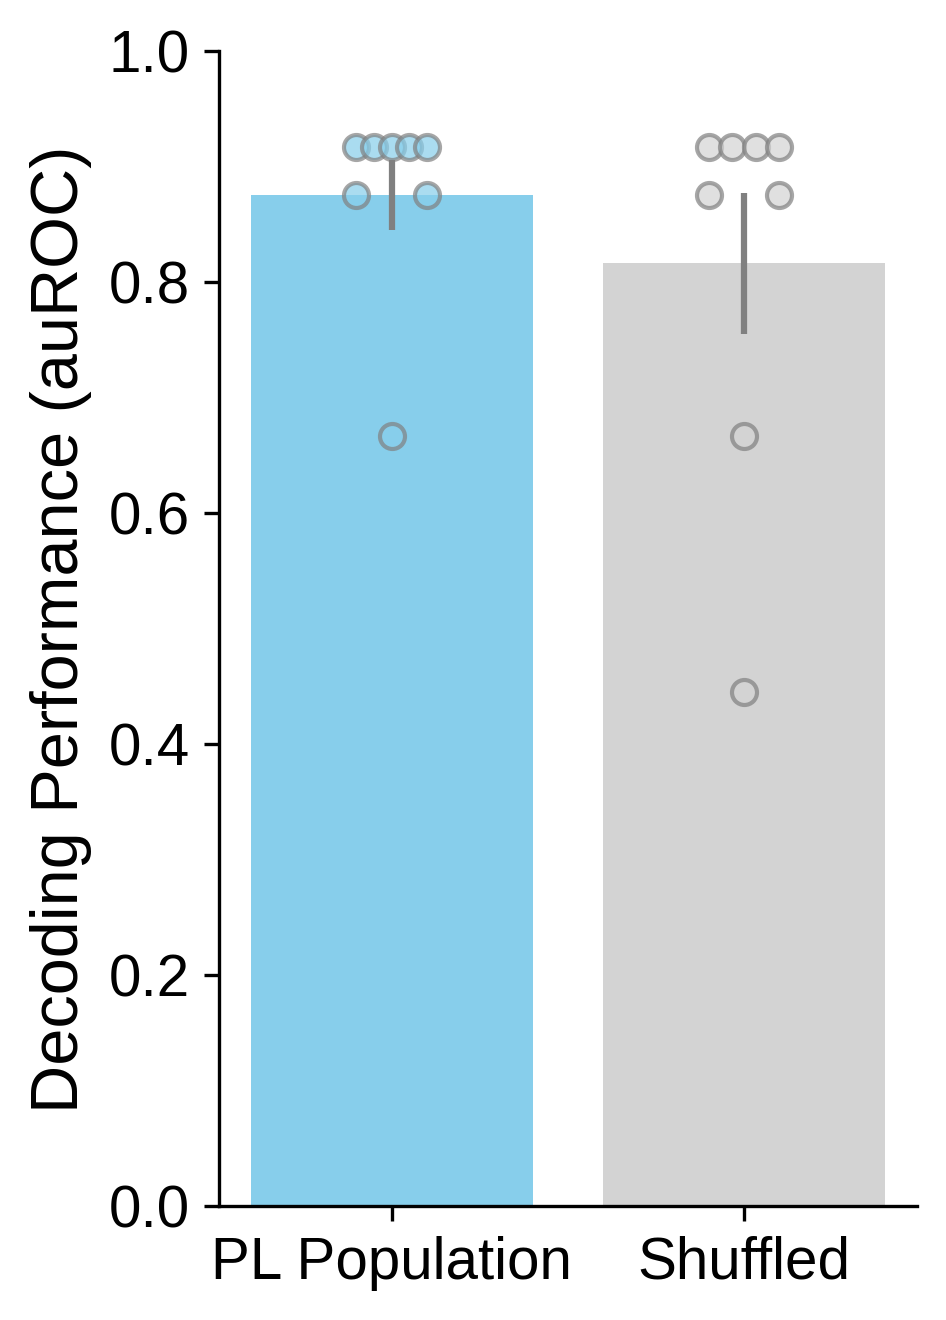

In [915]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results_cluster0.mean(), yerr=stats.sem(auc_results_cluster0), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,auc_results_cluster1.mean(), yerr=stats.sem(auc_results_cluster1), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
# x1, x2 = 1, 1.5
# y, h, col = 1.025, 0, 'k'
# ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
# ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results_cluster0, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(auc_results_cluster1, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

## Remove responsive neurons

In [922]:
output_dir = './analysis_output'

excited_hungry = pd.read_csv(os.path.join(output_dir, 'Excited_Hungry.csv'), index_col= 0)
inhibited_hungry = pd.read_csv(os.path.join(output_dir, 'Inhibited_Hungry.csv'), index_col= 0)

excited_indices = excited_hungry.index.values.tolist()
inhibited_indices = inhibited_hungry.index.values.tolist()


excited_satiated = pd.read_csv(os.path.join(output_dir, 'Excited_Satiated.csv'), index_col= 0)
inhibited_satiated = pd.read_csv(os.path.join(output_dir, 'Inhibited_Satiated.csv'), index_col= 0)

excited_satiated_indices = excited_satiated.index.values.tolist()
inhibited_satiated_indices = inhibited_satiated.index.values.tolist()




In [923]:
responsive_neurons = np.concatenate([excited_indices, inhibited_indices, excited_satiated_indices, inhibited_satiated_indices])
responsive_neurons

array([   1,    6,   10,   13,   27,   44,   97,  138,  149,  151,  170,
        260,  294,  307,  457,  473,  480,  514,  515,  535,  583,  590,
        596,  621,  626,  795,  859,  862,  993, 1006, 1013, 1017, 1022,
       1038, 1041, 1077, 1109,   36,   49,   71,   95,   98,  132,  167,
        198,  237,  297,  320,  321,  358,  376,  414,  428,  429,  501,
        553,  576,  761,  764,  813,  882,  901,  927,  966, 1033, 1035,
       1047, 1050,   30,   68,   77,   85,  225,  233,  235,  240,  250,
        270,  274,  275,  277,  290,  295,  297,  310,  343,  376,  400,
        432,  444,  466,  571,  603,  621,  663,  669,  682,  703,  716,
        757,  810,  875,  905,  909,  928,  944,  965,  992, 1005,    2,
         33,   51,  102,  186,  214,  234,  339,  361,  366,  428,  582,
        587,  627,  647,  699,  785,  969])

In [924]:
# Initialize a DataFrame to hold the mean values for each slice
trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial[~trace_hungry_trial.index.isin(responsive_neurons)].index)
trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial[~trace_satiated_trial.index.isin(responsive_neurons)].index)

# Loop to calculate and assign mean values for each of the 12 slices
for i in range(12):
    start_col = 2 + Bins_before + Bins * i
    end_col = 2 + Bins_before + int(1 * FR / BinSize) + Bins * i
    # Compute mean across selected columns for each row
    trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial[~trace_hungry_trial.index.isin(responsive_neurons)].iloc[:, start_col:end_col].mean(axis=1)
    trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial[~trace_satiated_trial.index.isin(responsive_neurons)].iloc[:, start_col:end_col].mean(axis=1)


In [925]:
Data = pd.concat([trace_hungry_trial_mean.T, trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T

In [926]:
ss = StandardScaler(with_mean=True, with_std=True)
Data = pd.DataFrame(ss.fit_transform(Data))
Data

0         1         2         3         4         5         6    \
0  -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
1  -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
2  -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
3  -0.647094 -0.272816 -0.200964  1.156085 -0.481968 -0.369986  1.973897   
4   0.154593 -0.272816 -0.300209  0.091994 -0.018726 -0.270749  0.492540   
5   0.079217 -0.272816 -0.024138 -0.125508  1.266253 -0.379026  1.159047   
6  -0.624096 -0.272816 -0.237563  0.242707  2.161680 -0.189838  2.412600   
7  -0.556780 -0.272816 -0.067601  0.002149 -0.712327 -0.226712  0.972773   
8  -0.201054 -0.272151  2.266955  1.240387 -0.263376 -0.379110  0.629097   
9   0.136585 -0.271415  2.723593  0.498732 -0.271315 -0.276347 -0.451039   
10 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
11 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
12 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
13 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
14 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
15  0.709811  0.717914 -0.396107 -0.342444  2.553748  0.356671 -0.460361   
16  0.745487 -0.241535  0.370955  0.195531  1.951437  1.832584 -0.241910   
17  0.962775 -0.268447 -0.316678  2.585398  0.128420  4.265118 -0.653388   
18  0.321544  4.694178 -0.596134 -0.496013  0.192535 -0.078332 -0.520687   
19  0.643853 -0.110565  2.580971  0.299362 -0.028171 -0.321966 -0.604914   
20  3.917723  0.045367 -0.274883 -0.566967  0.913928 -0.309136 -0.376525   
21  0.850557 -0.201099  0.443934  2.758758  0.098919  0.138096  2.298018   
22 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
23 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   

         7         8         9    ...       978       979       980       981  \
0  -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
1  -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
2  -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
3  -0.078120  1.953253 -0.446021  ... -0.208514 -0.241501 -0.208520 -0.229505   
4  -0.281867  0.226139 -0.132909  ... -0.208514 -0.241501 -0.208520 -0.225073   
5   0.166436  0.591797  2.267824  ... -0.208514 -0.241501 -0.208520 -0.229505   
6   2.114757  0.935483 -0.056804  ... -0.208514 -0.241501  4.795832  4.783632   
7   2.806756  3.688454 -0.419500  ...  4.795832 -0.241501 -0.208520 -0.229487   
8   2.445576 -0.534881  1.416654  ... -0.208514 -0.241501 -0.208396 -0.223279   
9   0.108499 -0.542299 -0.088046  ... -0.208514 -0.241501 -0.208520 -0.229505   
10 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
11 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
12 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
13 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
14 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
15  0.540610 -0.538763  0.608906  ... -0.208514 -0.148519 -0.208520 -0.074705   
16  0.083216  0.150542 -0.459017  ... -0.208514 -0.241501 -0.208520 -0.229505   
17 -0.301854 -0.429982 -0.469947  ... -0.208514 -0.063942 -0.208520 -0.229505   
18 -0.466142 -0.541168 -0.393428  ... -0.208514  0.241251 -0.208520 -0.229505   
19 -0.442394  0.812489 -0.356156  ... -0.208514  4.771060 -0.208520 -0.229505   
20  0.401695 -0.542156  3.606694  ... -0.208514 -0.238766 -0.208520  0.100000   
21 -0.627932  0.194177 -0.366805  ... -0.208514 -0.214062 -0.208520 -0.229504   
22 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   
23 -0.646924 -0.542308 -0.471144  ... -0.208514 -0.241501 -0.208520 -0.229505   

         982       983       984       985       986       987  
0  -0.274115 -0.2

In [927]:
Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

In [928]:
Data

0         1         2         3         4         5         6  \
0  -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
1  -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
2  -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
3  -0.647094 -0.272816 -0.200964  1.156085 -0.481968 -0.369986  1.973897   
4   0.154593 -0.272816 -0.300209  0.091994 -0.018726 -0.270749  0.492540   
5   0.079217 -0.272816 -0.024138 -0.125508  1.266253 -0.379026  1.159047   
6  -0.624096 -0.272816 -0.237563  0.242707  2.161680 -0.189838  2.412600   
7  -0.556780 -0.272816 -0.067601  0.002149 -0.712327 -0.226712  0.972773   
8  -0.201054 -0.272151  2.266955  1.240387 -0.263376 -0.379110  0.629097   
9   0.136585 -0.271415  2.723593  0.498732 -0.271315 -0.276347 -0.451039   
10 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
11 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
12 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
13 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
14 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
15  0.709811  0.717914 -0.396107 -0.342444  2.553748  0.356671 -0.460361   
16  0.745487 -0.241535  0.370955  0.195531  1.951437  1.832584 -0.241910   
17  0.962775 -0.268447 -0.316678  2.585398  0.128420  4.265118 -0.653388   
18  0.321544  4.694178 -0.596134 -0.496013  0.192535 -0.078332 -0.520687   
19  0.643853 -0.110565  2.580971  0.299362 -0.028171 -0.321966 -0.604914   
20  3.917723  0.045367 -0.274883 -0.566967  0.913928 -0.309136 -0.376525   
21  0.850557 -0.201099  0.443934  2.758758  0.098919  0.138096  2.298018   
22 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   
23 -0.649312 -0.272816 -0.597213 -0.754017 -0.749104 -0.379127 -0.662915   

           7         8         9  ...       979       980       981       982  \
0  -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
1  -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
2  -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
3  -0.078120  1.953253 -0.446021  ... -0.241501 -0.208520 -0.229505 -0.274115   
4  -0.281867  0.226139 -0.132909  ... -0.241501 -0.208520 -0.225073 -0.274115   
5   0.166436  0.591797  2.267824  ... -0.241501 -0.208520 -0.229505 -0.274115   
6   2.114757  0.935483 -0.056804  ... -0.241501  4.795832  4.783632 -0.274115   
7   2.806756  3.688454 -0.419500  ... -0.241501 -0.208520 -0.229487 -0.274115   
8   2.445576 -0.534881  1.416654  ... -0.241501 -0.208396 -0.223279 -0.274115   
9   0.108499 -0.542299 -0.088046  ... -0.241501 -0.208520 -0.229505 -0.274115   
10 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
11 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
12 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
13 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
14 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
15  0.540610 -0.538763  0.608906  ... -0.148519 -0.208520 -0.074705  1.572463   
16  0.083216  0.150542 -0.459017  ... -0.241501 -0.208520 -0.229505 -0.274115   
17 -0.301854 -0.429982 -0.469947  ... -0.063942 -0.208520 -0.229505 -0.274115   
18 -0.466142 -0.541168 -0.393428  ...  0.241251 -0.208520 -0.229505 -0.274115   
19 -0.442394  0.812489 -0.356156  ...  4.771060 -0.208520 -0.229505 -0.274115   
20  0.401695 -0.542156  3.606694  ... -0.238766 -0.208520  0.100000  4.458061   
21 -0.627932  0.194177 -0.366805  ... -0.214062 -0.208520 -0.229504 -0.274115   
22 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   
23 -0.646924 -0.542308 -0.471144  ... -0.241501 -0.208520 -0.229505 -0.274115   

         983       984       985       986       987  Label  
0  -0.223926 -0.298790

In [929]:
# Read dataset
Dt = Data

# Split into X and Y
X = Dt.iloc[:, 0:Dt.shape[1]-1]
Y = Dt.iloc[:, Dt.shape[1]-1]

# Hyperparameter
solver = ['lsqr']
shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
# shrinkage = ['auto']

# Put into a matrix
Hyperparameter_Space2 = [(a,b) 
                        for a in solver 
                        for b in shrinkage]
Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

n_cv = 8
splits = 2
nump = 1000

# Set the seed for the random number generator
np.random.seed(0)

# Generate random states for each fold
random_states = np.random.randint(0, 10000, size=n_cv)


auc_results_removed = []
shuffled_auc_results_removed = []

for i in range(n_cv):

    sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
    for train_index, test_index in sss.split(X, Y):
        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

    
    Train = Dt.iloc[train_index,:]
    Test = Dt.iloc[test_index,:]

    # Training set
    Xtrain = Train.iloc[:, 0:Dt.shape[1]-1]
    Ytrain = Train.iloc[:,Dt.shape[1]-1]

    # Testing set
    Xtest = Test.iloc[:, 0:Dt.shape[1]-1]
    Ytest = Test.iloc[:, Dt.shape[1]-1]

#     # Training process
#     LDA_ACC_train = []
#     LDA_AUC_train = []
#     LDA_ACC_test = []
#     LDA_AUC_test = []

#     n = len(Hyperparameter_Space2)

#     for i in range(0, n):
#         # Extract hyperparameter
#         Hyper_i = Hyperparameter_Mat2.iloc[i, :]
#         Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

#         # Model with hyperparameter
#         LDA = LinearDiscriminantAnalysis(**Hyperpara)
#         LDA.fit(Xtrain, Ytrain)

#         # Obtain testing metrics
#         y_test_pred = LDA.predict(Xtest)
#         y_test_score = LDA.predict_proba(Xtest)[:, 1]

#         test_auc = roc_auc_score(Ytest, y_test_score)
#         LDA_AUC_test.append(test_auc)

#     # Show training result
#     Result_LDA = {'Test_AUC': LDA_AUC_test}
#     Result_LDA = pd.DataFrame(Result_LDA)
#     Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis = 1)

#     AUC_True = Result_LDA['Test_AUC'].max()

    LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
    LDA.fit(Xtrain, Ytrain)

    # Obtain testing metrics
#     y_test_pred = LDA.predict(Xtest)
    y_test_score = LDA.predict_proba(Xtest)[:, 1]

    test_auc = roc_auc_score(Ytest, y_test_score)
    auc_results_removed.append(test_auc)

    accuracy_multisplit_shuffle = np.zeros(nump)
    auc_multisplit_shuffle= np.zeros(nump)

#     # Extract best hyperparameter
#     Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
#     Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

    def process(i):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)

        # Model with hyperparameter
        LDA_best = LinearDiscriminantAnalysis(**Hyperpara_1s)
        clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

#         y_pred = clf_shuffle.predict(Xtest)
        y_test_score = clf_shuffle.predict_proba(Xtest)[:, 1]

#         accuracy = accuracy_score(Ytest, y_pred)
        auc = roc_auc_score(Ytest, y_test_score)

        return accuracy, auc

    if __name__ == '__main__':
        with Pool(cpu_count()) as p:
            results = p.map(process, range(nump))
        for i, (accuracy, auc) in enumerate(results):
            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results_removed.append(np.mean(auc_multisplit_shuffle))

auc_results_removed = np.array(auc_results_removed)
shuffled_auc_results_removed = np.array(shuffled_auc_results_removed)
print("AUC Results:", auc_results_removed)
print("Shuffled AUC Results:", shuffled_auc_results_removed)


AUC Results: [0.875      0.91666667 0.44444444 0.91666667 0.91666667 0.91666667
 0.875      0.91666667]
Shuffled AUC Results: [0.501      0.49430556 0.49380556 0.49469444 0.49594444 0.49586111
 0.50197222 0.49508333]


In [932]:


# Check if the distributions are normal (null hypothesis: x comes from a normal distribution)
k2, p_normal_auc = stats.normaltest(auc_results)
k2, p_normal_shuffled_auc = stats.normaltest(auc_results_removed)

alpha = 0.05  # significance level
if p_normal_auc < alpha and p_normal_shuffled_auc < alpha:  # both distributions are normal
    # Paired t-test (null hypothesis: the means of the samples are equal)
    t_statistic, p_val = stats.ttest_ind(auc_results, auc_results_removed)
    print("normal")
else:  # at least one of the distributions is not normal
    # Wilcoxon signed-rank test (null hypothesis: the distributions are the same)
    t_statistic, p_val = stats.mannwhitneyu(auc_results, auc_results_removed)
    print("not normal")

print("Test statistic:", t_statistic)
print("p-value:", p_val)

normal
Test statistic: 0.1906925178491193
p-value: 0.851504117686755


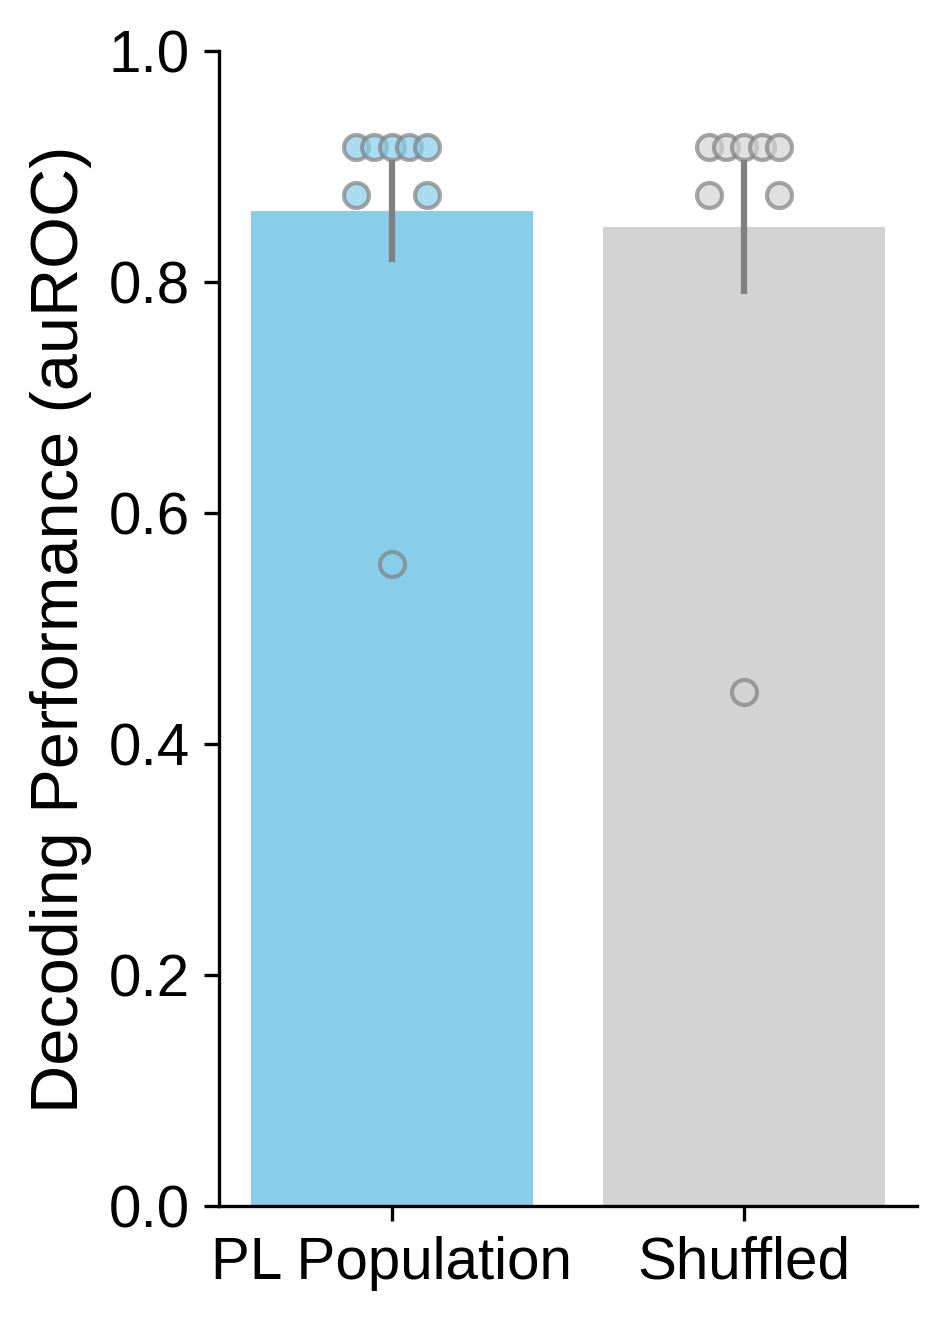

In [934]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_results.mean(), yerr=stats.sem(auc_results), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,auc_results_removed.mean(), yerr=stats.sem(auc_results_removed), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 1)  # keep y-axis limit as 1
# x1, x2 = 1, 1.5
# y, h, col = 1.025, 0, 'k'
# ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col,clip_on=False)
# ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


# Add scatter points
for group in group_values(auc_results, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='skyblue', edgecolors='gray', alpha=0.7, clip_on=False)

for group in group_values(auc_results_removed, 0.02):  # group values that are within 0.02 of each other
    n_points = len(group)
    x_coords = generate_symmetric_points(1.5, 0.05, n_points)
    y_coords = np.random.choice(group, size=n_points, replace=False)  # randomize order of y-values
    ax.scatter(x_coords, y_coords, color='lightgrey', edgecolors='gray', alpha=0.7, clip_on=False)

## Across time

In [35]:
%%time
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from multiprocessing import Pool
import numpy as np
import concurrent.futures


n_cv = 8
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 10

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

def shuffle_and_compute_single_run(args):
    i, Xtrain, Ytrain, Xtest, Ytest, model_pipeline = args
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    model_pipeline.fit(Xtrain, Ytrain_shuffle)
    y_pred = model_pipeline.predict_proba(Xtest)[:, 1]
    return roc_auc_score(Ytest, y_pred)

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, model_pipeline, nump):
    pool_size = min(cpu_count(), 4)  # Limit the number of processes to avoid memory overflow
    args = [(i, Xtrain, Ytrain, Xtest, Ytest, model_pipeline) for i in range(nump)]
    with Pool(processes=pool_size) as pool:
        auc_shuffled = pool.map(shuffle_and_compute_single_run, args)
    return np.mean(auc_shuffled)

# def shuffle_and_compute_single_run(i, Xtrain, Ytrain, Xtest, Ytest, model_pipeline):
#     np.random.seed(i)
#     Ytrain_shuffle = np.random.permutation(Ytrain)
#     model = model_pipeline
#     model.fit(Xtrain, Ytrain_shuffle)
#     y_pred = model.predict_proba(Xtest)[:, 1]
#     auc = roc_auc_score(Ytest, y_pred)
#     return auc

# def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, model_pipeline, nump):
#     with Pool(processes=4) as pool:
#         auc_shuffled = pool.starmap(shuffle_and_compute_single_run, 
#                                     [(i, Xtrain, Ytrain, Xtest, Ytest, model_pipeline) for i in range(nump)])
#     return np.mean(auc_shuffled)

def process_time_bin(time_bin):
    # Your data preparation remains the same here
    # Initialize a DataFrame to hold the mean values for each slice
    trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial.index)
    trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial.index)

    # Loop to calculate and assign mean values for each of the 12 slices
    for i in range(12):
        start_col = 2 + Bins_before +  int(time_bin * FR / BinSize) + Bins * i
        end_col = 2 + Bins_before + int((time_bin+BinSizeAC) * FR / BinSize) + Bins * i
        # Compute mean across selected columns for each row
        trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial.iloc[:, start_col:end_col].mean(axis=1)
        trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial.iloc[:, start_col:end_col].mean(axis=1)

    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial_mean.T, 
            trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data = pd.DataFrame(ss.fit_transform(Data))
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into X and Y
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]
    
    # Impute NaN values if present in X
    if X.isnull().values.any():
        imputer = SimpleImputer(strategy='mean')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # Dimensionality Reduction and Model Pipeline
    pca = PCA(n_components=0.999)
    lda = LinearDiscriminantAnalysis(**Hyperpara_1s)
    model_pipeline = make_pipeline(pca, lda)
    
    auc_results = []
    shuffled_auc_results = []

    sss = StratifiedShuffleSplit(n_splits=n_cv, test_size=0.5, random_state=42)
    for train_index, test_index in sss.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Fit and predict with the pipeline
        model_pipeline.fit(Xtrain, Ytrain)
        y_test_score = model_pipeline.predict_proba(Xtest)[:, 1]
        test_auc = roc_auc_score(Ytest, y_test_score)

        auc_results.append(test_auc)

        # Parallelized Shuffled AUC Calculation
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, model_pipeline, nump)

        shuffled_auc_results.append(shuffled_auc)

    return auc_results, shuffled_auc_results

# Adjustments for parallel processing across time bins
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))

with concurrent.futures.ProcessPoolExecutor(max_workers=min(cpu_count(), len(time_bins))) as executor:
    results = list(executor.map(process_time_bin, time_bins))

for i, (auc, shuffled_auc) in enumerate(results):
    auc_results_all[i] = auc
    shuffled_auc_results_all[i] = shuffled_auc
    
print("AUC Results All:", auc_results_all)
print("Shuffled AUC Results All:", shuffled_auc_results_all)


AUC Results All: [[0.58333333 0.33333333 0.51388889 0.5        0.51388889 0.5
  0.51388889 0.41666667]
 [0.72222222 0.375      0.72222222 0.58333333 0.44444444 0.65277778
  0.65277778 0.72222222]
 [0.72222222 0.375      0.72222222 0.65277778 0.375      0.65277778
  0.65277778 0.77777778]
 [0.77777778 0.36111111 0.72222222 0.72222222 0.61111111 0.77777778
  0.72222222 0.77777778]
 [0.875      0.83333333 0.72222222 0.72222222 0.44444444 0.83333333
  0.77777778 0.83333333]
 [0.91666667 0.91666667 0.72222222 0.72222222 0.91666667 0.91666667
  0.83333333 0.91666667]
 [0.94444444 0.875      0.77777778 0.83333333 0.91666667 0.91666667
  0.875      0.94444444]
 [0.98611111 0.58333333 0.58333333 0.91666667 0.75       0.97222222
  0.94444444 0.94444444]
 [0.98611111 0.875      0.58333333 0.91666667 0.83333333 0.97222222
  0.875      0.875     ]
 [0.94444444 0.91666667 0.83333333 0.94444444 0.875      0.94444444
  0.875      0.55555556]
 [0.91666667 0.91666667 0.83333333 0.875      0.44444444 0.9

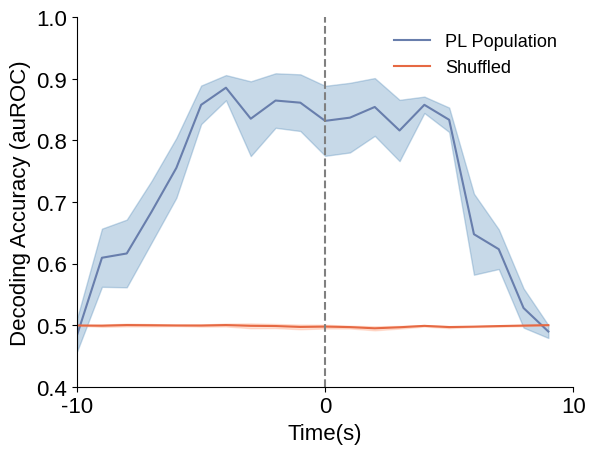

In [36]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots()
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

In [32]:
n_cv = 8
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 10

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

def shuffle_and_compute_single_run(args):
    i, Xtrain, Ytrain, Xtest, Ytest, best_param = args
    np.random.seed(i)
    Ytrain_shuffle = np.random.permutation(Ytrain)
    LDA = LinearDiscriminantAnalysis(**best_param)
    LDA.fit(Xtrain, Ytrain_shuffle)
    y_pred = LDA.predict_proba(Xtest)[:, 1]
    return roc_auc_score(Ytest, y_pred)

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, best_param, nump):
    pool_size = min(cpu_count(), 8)  # Limit the number of processes to avoid memory overflow
    args = [(i, Xtrain, Ytrain, Xtest, Ytest, best_param) for i in range(nump)]
    with Pool(processes=pool_size) as pool:
        auc_shuffled = pool.map(shuffle_and_compute_single_run, args)
    return np.mean(auc_shuffled)

# def shuffle_and_compute_single_run(i, Xtrain, Ytrain, Xtest, Ytest, model_pipeline):
#     np.random.seed(i)
#     Ytrain_shuffle = np.random.permutation(Ytrain)
#     model = model_pipeline
#     model.fit(Xtrain, Ytrain_shuffle)
#     y_pred = model.predict_proba(Xtest)[:, 1]
#     auc = roc_auc_score(Ytest, y_pred)
#     return auc

# def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, model_pipeline, nump):
#     with Pool(processes=4) as pool:
#         auc_shuffled = pool.starmap(shuffle_and_compute_single_run, 
#                                     [(i, Xtrain, Ytrain, Xtest, Ytest, model_pipeline) for i in range(nump)])
#     return np.mean(auc_shuffled)

def process_time_bin(time_bin):
    # Your data preparation remains the same here
    # Initialize a DataFrame to hold the mean values for each slice
    trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial.index)
    trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial.index)

    # Loop to calculate and assign mean values for each of the 12 slices
    for i in range(12):
        start_col = 2 + Bins_before +  int(time_bin * FR / BinSize) + Bins * i
        end_col = 2 + Bins_before + int((time_bin+BinSizeAC) * FR / BinSize) + Bins * i
        # Compute mean across selected columns for each row
        trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial.iloc[:, start_col:end_col].mean(axis=1)
        trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial.iloc[:, start_col:end_col].mean(axis=1)

    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial_mean.T, 
            trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data = pd.DataFrame(ss.fit_transform(Data))
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into X and Y
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]
    
    # Impute NaN values if present in X
    if X.isnull().values.any():
        imputer = SimpleImputer(strategy='mean')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # Dimensionality Reduction and Model Pipeline
#     pca = PCA(n_components=0.9)
    lda = LinearDiscriminantAnalysis(**Hyperpara_1s)
#     model_pipeline = make_pipeline(pca, lda)
    
    auc_results = []
    shuffled_auc_results = []

    sss = StratifiedShuffleSplit(n_splits=n_cv, test_size=0.5, random_state=42)
    for train_index, test_index in sss.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Fit and predict with the pipeline
        lda.fit(Xtrain, Ytrain)
        y_test_score = lda.predict_proba(Xtest)[:, 1]
        test_auc = roc_auc_score(Ytest, y_test_score)

        auc_results.append(test_auc)

        # Parallelized Shuffled AUC Calculation
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyperpara_1s, nump)

        shuffled_auc_results.append(shuffled_auc)

    return auc_results, shuffled_auc_results

# Adjustments for parallel processing across time bins
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))

with concurrent.futures.ProcessPoolExecutor(max_workers=min(cpu_count(), len(time_bins))) as executor:
    results = list(executor.map(process_time_bin, time_bins))

for i, (auc, shuffled_auc) in enumerate(results):
    auc_results_all[i] = auc
    shuffled_auc_results_all[i] = shuffled_auc
    
print("AUC Results All:", auc_results_all)
print("Shuffled AUC Results All:", shuffled_auc_results_all)


AUC Results All: [[0.58333333 0.33333333 0.51388889 0.5        0.51388889 0.5
  0.51388889 0.5       ]
 [0.72222222 0.375      0.72222222 0.58333333 0.44444444 0.65277778
  0.65277778 0.72222222]
 [0.72222222 0.375      0.72222222 0.65277778 0.375      0.65277778
  0.65277778 0.77777778]
 [0.77777778 0.36111111 0.72222222 0.72222222 0.61111111 0.77777778
  0.72222222 0.77777778]
 [0.875      0.83333333 0.72222222 0.72222222 0.44444444 0.83333333
  0.77777778 0.83333333]
 [0.91666667 0.91666667 0.72222222 0.72222222 0.91666667 0.91666667
  0.83333333 0.91666667]
 [0.94444444 0.875      0.77777778 0.83333333 0.91666667 0.91666667
  0.875      0.94444444]
 [0.98611111 0.58333333 0.58333333 0.91666667 0.75       0.97222222
  0.94444444 0.94444444]
 [0.98611111 0.875      0.58333333 0.91666667 0.83333333 0.97222222
  0.875      0.875     ]
 [0.94444444 0.91666667 0.83333333 0.94444444 0.875      0.94444444
  0.875      0.55555556]
 [0.91666667 0.91666667 0.83333333 0.875      0.44444444 0.9

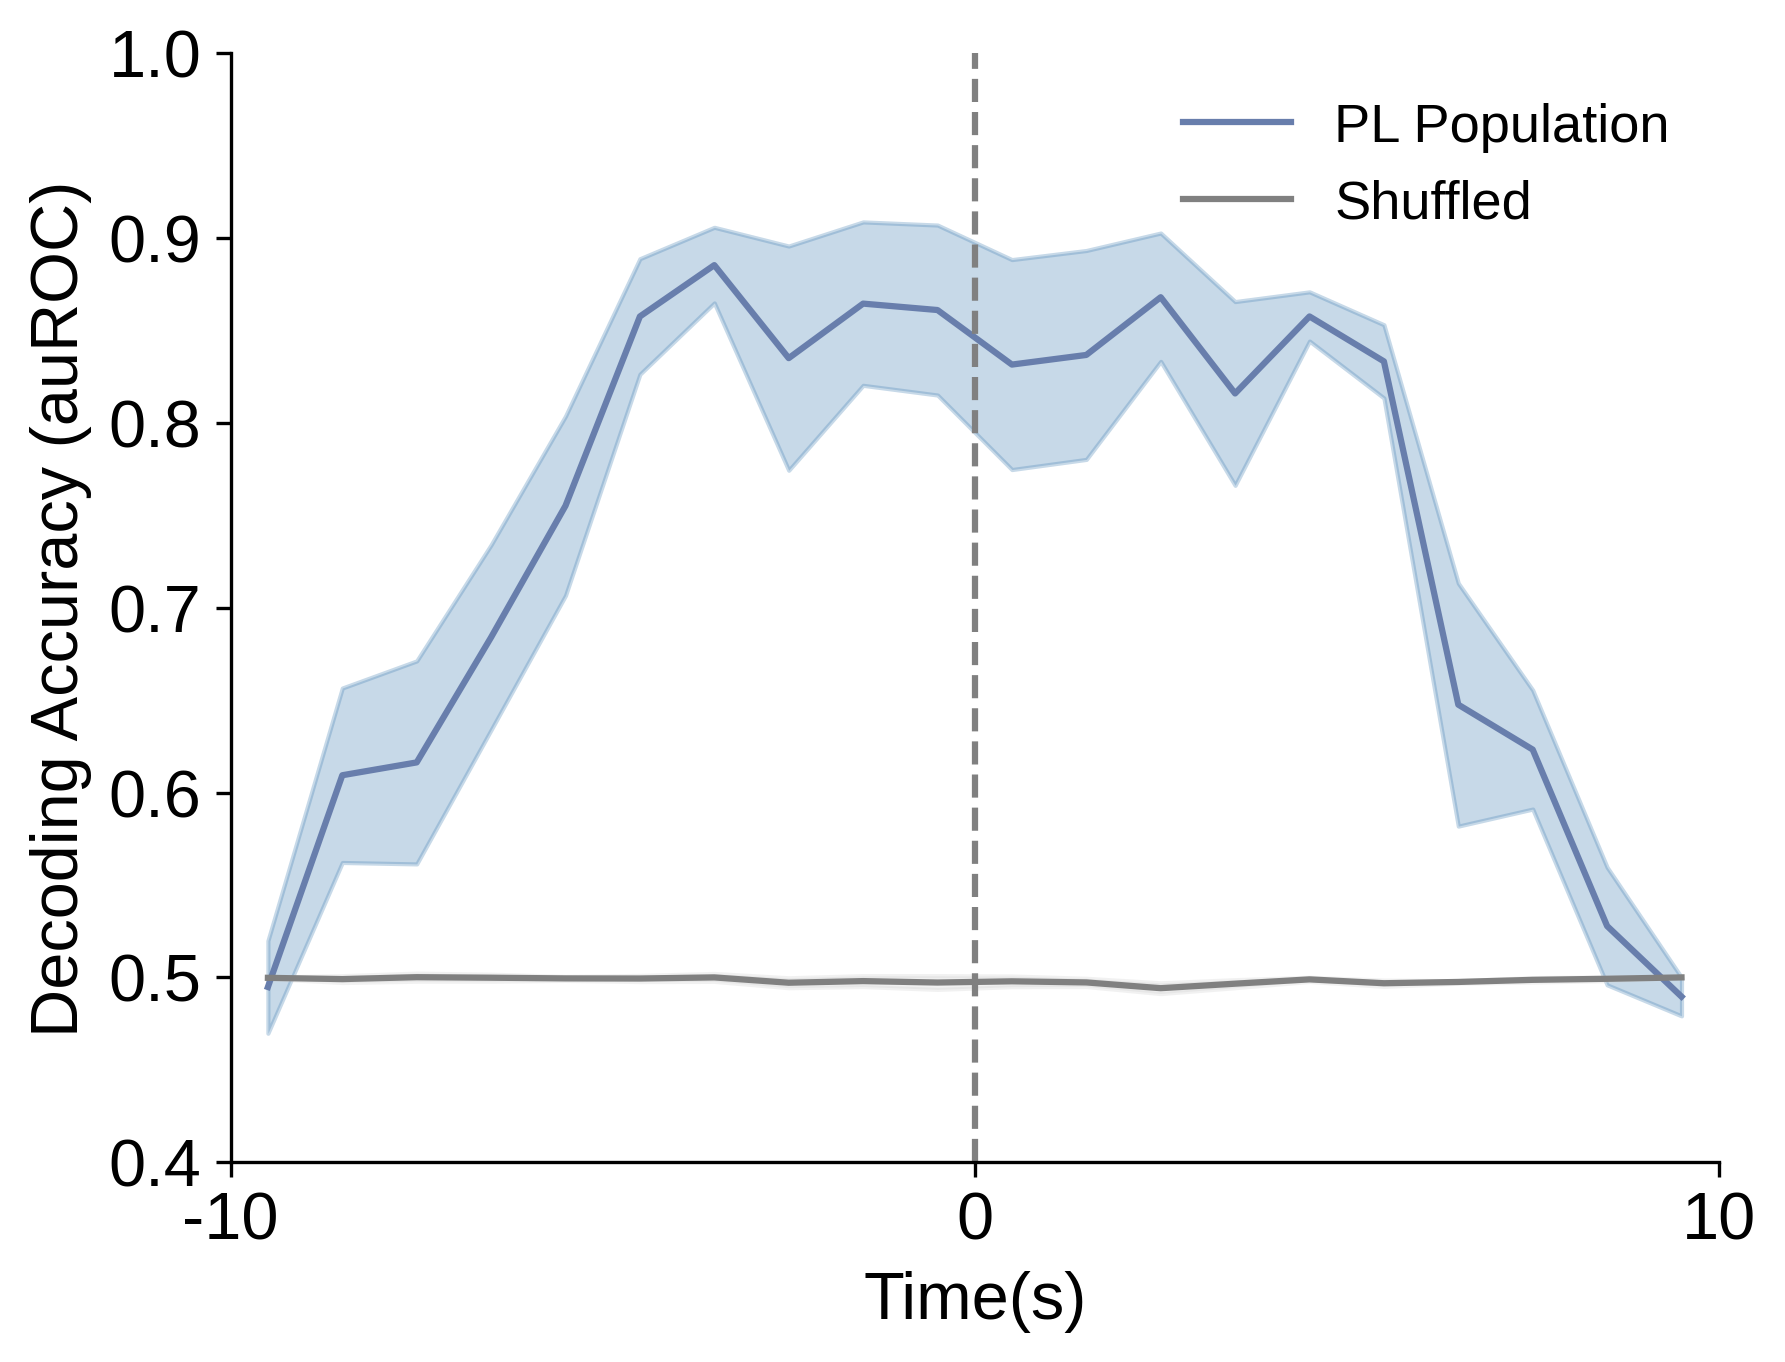

In [33]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)+0.5
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots(dpi = 300)
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = 'grey')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightgrey', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_safe)

In [941]:
%%time

n_cv = 2
splits = 8
nump = 1000
BinSizeAC = 1
TimeRangeAC = 10

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

# Initialize arrays to store the results
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))



# Define the main processing function for each time bin
def process_time_bin(time_bin):

    # Initialize a DataFrame to hold the mean values for each slice
    trace_hungry_trial_mean = pd.DataFrame(index=trace_hungry_trial.index)
    trace_satiated_trial_mean = pd.DataFrame(index=trace_satiated_trial.index)

    # Loop to calculate and assign mean values for each of the 12 slices
    for i in range(12):
        start_col = 2 + Bins_before +  int(time_bin * FR / BinSize) + Bins * i
        end_col = 2 + Bins_before + int((time_bin+BinSizeAC) * FR / BinSize) + Bins * i
        # Compute mean across selected columns for each row
        trace_hungry_trial_mean[f'{i+1}'] = trace_hungry_trial.iloc[:, start_col:end_col].mean(axis=1)
        trace_satiated_trial_mean[f'{i+1}'] = trace_satiated_trial.iloc[:, start_col:end_col].mean(axis=1)

    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial_mean.T, 
            trace_satiated_trial_mean.T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data = pd.DataFrame(ss.fit_transform(Data))
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into X and Y
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]

    # Hyperparameters
    solver = ['lsqr', 'eigen']
    shrinkage = ['auto']

#     # Generate hyperparameter space
#     Hyperparameter_Space2 = [(a, b) for a in solver for b in shrinkage]
#     Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2, columns=['solver', 'shrinkage'])

    # Imputer for NaN values
    imputer = SimpleImputer(strategy='mean')

    # Results lists
    auc_results = []
    shuffled_auc_results = []

    # Generate random states for each fold
    random_states = np.random.randint(0, 10000, size=n_cv)
    
    sss = StratifiedShuffleSplit(n_splits=n_cv, test_size=0.5, random_state=42)

    auc_results = []
    shuffled_auc_results = []

    for train_index, test_index in sss.split(X, Y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        # Impute NaN values
        Xtrain = imputer.fit_transform(Xtrain)
        Xtest = imputer.transform(Xtest)

        # LDA training and testing
        LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
        LDA.fit(Xtrain, Ytrain)
        y_test_score = LDA.predict_proba(Xtest)[:, 1]
        test_auc = roc_auc_score(Ytest, y_test_score)

        auc_results.append(test_auc)
        # Shuffled AUC calculation
        shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyperpara_1s, nump)
        shuffled_auc_results.append(shuffled_auc)

#     for i in range(n_cv):
#         sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
#         for train_index, test_index in sss.split(X, Y):
#             Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
#             Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

#             # Impute NaN values
#             Xtrain = imputer.fit_transform(Xtrain)
#             Xtest = imputer.transform(Xtest)

# #             # LDA training and testing
# #             for Hyper_i in Hyperparameter_Space2:
# #                 LDA = LinearDiscriminantAnalysis(solver=Hyper_i[0], shrinkage=Hyper_i[1])
# #                 LDA.fit(Xtrain, Ytrain)
# #                 y_test_score = LDA.predict_proba(Xtest)[:, 1]
# #                 test_auc = roc_auc_score(Ytest, y_test_score)
# #                 LDA_AUC_test.append(test_auc)

# #             Result_LDA = pd.DataFrame({'Test_AUC': LDA_AUC_test})
# #             AUC_True = Result_LDA['Test_AUC'].max()
            
#             LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
#             LDA.fit(Xtrain, Ytrain)
#             y_test_score = LDA.predict_proba(Xtest)[:, 1]
#             test_auc = roc_auc_score(Ytest, y_test_score)

#             auc_results.append(test_auc)

#             # Shuffled AUC calculation
#             shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyperpara_1s, nump)
#             shuffled_auc_results.append(shuffled_auc)

    return auc_results, shuffled_auc_results

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyperpara_1s, nump):
    auc_shuffled = np.zeros(nump)
    for i in range(nump):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)
        LDA = LinearDiscriminantAnalysis(**Hyperpara_1s)
        LDA.fit(Xtrain, Ytrain_shuffle)
        y_pred = LDA.predict(Xtest)
        auc_shuffled[i] = roc_auc_score(Ytest, y_pred)
    return np.mean(auc_shuffled)

# Parallel processing for each time bin
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(process_time_bin, time_bins))

# Extract and store the results
for i, (auc, shuffled_auc) in enumerate(results):
    auc_results_all[i] = auc
    shuffled_auc_results_all[i] = shuffled_auc

# Output the results
print("AUC Results All:", auc_results_all)
print("Shuffled AUC Results All:", shuffled_auc_results_all)

Process ForkProcess-119543:
Process ForkProcess-119548:
Process ForkProcess-119545:
Process ForkProcess-119547:
Process ForkProcess-119553:
Process ForkProcess-119551:
Process ForkProcess-119546:
Process ForkProcess-119544:
Process ForkProcess-119549:
Process ForkProcess-119550:
Process ForkProcess-119552:
Process ForkProcess-119542:
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mo

  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
KeyboardInterrupt
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^

KeyboardInterrupt: 

In [939]:
sss = StratifiedShuffleSplit(n_splits=n_cv, test_size=0.5, random_state=42)


for train_index, test_index in sss.split(X, Y):
    Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]
    print(Counter(Ytrain), Counter(Ytest))

Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})
Counter({0: 6, 1: 6}) Counter({0: 6, 1: 6})
Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})
Counter({1: 6, 0: 6}) Counter({0: 6, 1: 6})
Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})
Counter({0: 6, 1: 6}) Counter({1: 6, 0: 6})
Counter({1: 6, 0: 6}) Counter({0: 6, 1: 6})
Counter({1: 6, 0: 6}) Counter({1: 6, 0: 6})


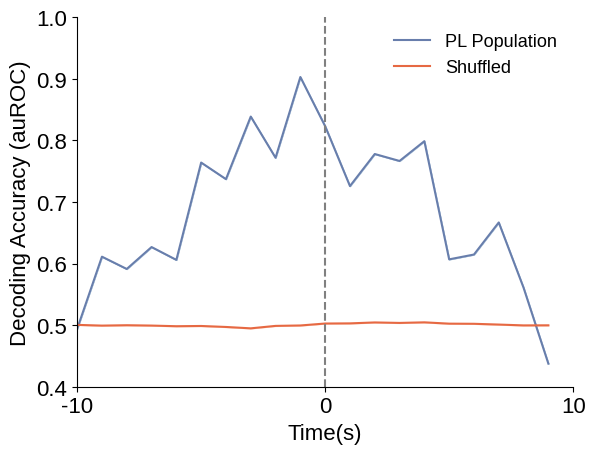

In [936]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots()
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

In [180]:
%%time

n_cv = 8
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 10

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

# Initialize arrays to store the results
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))


def calculate_bins_zscore(df, time_bin, FrameRange_before,BinSizeAC, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        cueonset = cueonset[cue_range[0]:cue_range[1]]
    
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        start_frame = cueonset[i] + int(time_bin * FR)
        end_frame = start_frame + int(BinSizeAC* FR)  # bin
        tracenew.iloc[:,i] = trace.iloc[:, start_frame:end_frame].mean(axis=1)
        
    return tracenew

# Define the main processing function for each time bin
def process_time_bin(time_bin):
#     # Create a list to hold the dataframes
#     trace_safe_list = []
#     trace_threat_list = []
    
#     # Loop through each animal's DataFrame
#     for df in all_dataframes:  # Assuming all_dataframes is defined
#         tracenew_safe = calculate_bins_zscore(df, time_bin, FrameRange_before, BinSizeAC, TotalFrame, Bins, Bins_before, cue_range=safecue)
#         tracenew_threat = calculate_bins_zscore(df, time_bin, FrameRange_before, BinSizeAC, TotalFrame, Bins, Bins_before, cue_range=threatcue)

#         trace_safe_list.append(tracenew_safe)
#         trace_threat_list.append(tracenew_threat)

#     # Concatenate all dataframes
#     tracesafe = pd.concat(trace_safe_list, ignore_index=True)
#     tracethreat = pd.concat(trace_threat_list, ignore_index=True)
    
    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial.iloc[:, [2 + Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T, 
            trace_satiated_trial.iloc[:, [2+ Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Split into X and Y
    X = Data.iloc[:, :-1]
    Y = Data.iloc[:, -1]

    # Hyperparameters
    solver = ['lsqr', 'eigen']
    shrinkage = ['auto']

    # Generate hyperparameter space
    Hyperparameter_Space2 = [(a, b) for a in solver for b in shrinkage]
    Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2, columns=['solver', 'shrinkage'])

    # Imputer for NaN values
    imputer = SimpleImputer(strategy='mean')

    # Results lists
    auc_results = []
    shuffled_auc_results = []

    # Generate random states for each fold
    random_states = np.random.randint(0, 10000, size=n_cv)

    for i in range(n_cv):
        sss = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_states[i])
        for train_index, test_index in sss.split(X, Y):
            Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
            Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

            # Impute NaN values
            Xtrain = imputer.fit_transform(Xtrain)
            Xtest = imputer.transform(Xtest)

            # LDA training and testing
            for Hyper_i in Hyperparameter_Space2:
                LDA = LinearDiscriminantAnalysis(solver=Hyper_i[0], shrinkage=Hyper_i[1])
                LDA.fit(Xtrain, Ytrain)
                y_test_score = LDA.predict_proba(Xtest)[:, 1]
                test_auc = roc_auc_score(Ytest, y_test_score)
                LDA_AUC_test.append(test_auc)

            Result_LDA = pd.DataFrame({'Test_AUC': LDA_AUC_test})
            AUC_True = Result_LDA['Test_AUC'].max()
            auc_results.append(AUC_True)

            # Shuffled AUC calculation
            shuffled_auc = shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyper_i, nump)
            shuffled_auc_results.append(shuffled_auc)

    return np.mean(auc_results), np.mean(shuffled_auc_results)

def shuffle_compute(Xtrain, Ytrain, Xtest, Ytest, Hyper_i, nump):
    auc_shuffled = np.zeros(nump)
    for i in range(nump):
        np.random.seed(i)
        Ytrain_shuffle = np.random.permutation(Ytrain)
        LDA = LinearDiscriminantAnalysis(solver=Hyper_i[0], shrinkage=Hyper_i[1])
        LDA.fit(Xtrain, Ytrain_shuffle)
        y_pred = LDA.predict(Xtest)
        auc_shuffled[i] = roc_auc_score(Ytest, y_pred)
    return np.mean(auc_shuffled)

# Parallel processing for each time bin
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(process_time_bin, time_bins))

# Extract and store the results
for i, (auc, shuffled_auc) in enumerate(results):
    auc_results_all[i] = auc
    shuffled_auc_results_all[i] = shuffled_auc

# Output the results
print("AUC Results All:", auc_results_all)
print("Shuffled AUC Results All:", shuffled_auc_results_all)

LinAlgError: The leading minor of order 1 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [178]:
%%time

n_cv = 8
splits = 2
nump = 1000
BinSizeAC = 1
TimeRangeAC = 15

# Define the time bins
time_bins = np.arange(-TimeRangeAC, TimeRangeAC, BinSizeAC)  

# Initialize arrays to store the results
auc_results_all = np.zeros((len(time_bins), n_cv))
shuffled_auc_results_all = np.zeros((len(time_bins), n_cv))


def calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        cueonset = cueonset[cue_range[0]:cue_range[1]]
    
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        start_frame = cueonset[i] + int(time_bin * FR)
        end_frame = start_frame + int(BinSize* FR)  # bin
        tracenew.iloc[:,i] = trace.iloc[:, start_frame:end_frame].mean(axis=1)
        
    return tracenew

# Define the main processing function for each time bin
def process_time_bin(time_bin):

    # Create a list to hold the dataframes
    trace_hungry_list = []
    trace_satiated_list = []
    
#     # Loop through each animal's DataFrame
#     for df in all_dataframes:
#         tracenew_hungry = calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
#         tracenew_satiated = calculate_bins_zscore(df, time_bin, FrameRange_before,BinSize, TotalFrame, Bins, Bins_before,  cue_range=satiatedcue)

#         trace_hungry_list.append(tracenew_hungry)
#         trace_satiated_list.append(tracenew_satiated)
#     # Concatenate all dataframes in the list
#     tracehungry = pd.concat(trace_hungry_list, ignore_index=True)

#     # Concatenate all dataframes in the list
#     tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
    

    # Combine the data from the two conditions
    Data = pd.concat([trace_hungry_trial.iloc[:, [2 + Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T, 
            trace_satiated_trial.iloc[:, [2+ Bins_before + int(time_bin * FR/BinSize) + Bins * i for i in range(12)]].T],
            axis = 0, ignore_index=True).T.reset_index(drop=True).T
    pd.concat([tracehungry.T,tracesatiated.T], axis = 0, ignore_index=True).T.reset_index(drop=True).T
    Data["Label"] = np.concatenate([np.repeat(1,12),np.repeat(0,12)])

    # Read dataset
    Dt = Data

    # Split into X and Y
    X = Dt.iloc[:, 0:(Data.shape[1]-1)]
    Y = Dt.iloc[:, (Data.shape[1]-1)]

    # Hyperparameter
    solver = ['lsqr', 'eigen']
#     shrinkage = ['auto', 0.001, 0.01, 0.1, 0.5, 0.9]
    shrinkage = ['auto']

    # Put into a matrix
    Hyperparameter_Space2 = [(a,b) 
                            for a in solver 
                            for b in shrinkage]
    Hyperparameter_Mat2 = pd.DataFrame(Hyperparameter_Space2)
    Hyperparameter_Mat2.columns = ['solver', 'shrinkage']

    # Set the seed for the random number generator
    np.random.seed(42)

    # Generate random states for each fold
    random_states = np.random.randint(0, 10000, size=n_cv)

    auc_results = []
    shuffled_auc_results = []

    for i in range(n_cv):
        sss = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_states[i])
        for train_index, test_index in sss.split(X, Y):
            Train = Dt.iloc[train_index,:]
            Test = Dt.iloc[test_index,:]

        Train = Dt.iloc[train_index,:]
        Test = Dt.iloc[test_index,:]

        # Training set
        Xtrain = Train.iloc[:, 0:(Data.shape[1]-1)]
        Ytrain = Train.iloc[:,(Data.shape[1]-1)]

        # Testing set
        Xtest = Test.iloc[:, 0:(Data.shape[1]-1)]
        Ytest = Test.iloc[:, (Data.shape[1]-1)]
        
        # Check for NaN values before fitting the model
        if np.isnan(Xtrain).any().any() or np.isnan(Xtest).any().any():
            print(f'NaN values found in Xtrain or Xtest for time_bin: {time_bin}')
    
            # Create an imputer object that will replace NaN values with the mean value of the column
            imputerTrian = SimpleImputer(strategy='mean')
            imputerTtest = SimpleImputer(strategy='mean')
    
            # Fit on the training data
            imputerTrian.fit(Xtrain)
            imputerTtest.fit(Xtest)
            
            # Transform and replace the training and test data
            Xtrain = imputerTrian.transform(Xtrain) 
            Xtest = imputerTtest.transform(Xtest)
    
            
            # Transform and replace the training and test data
            Xtrain = imputerTrian.transform(Xtrain)
            Xtest = imputerTtest.transform(Xtest)


        # Training process
        LDA_ACC_train = []
        LDA_AUC_train = []
        LDA_ACC_test = []
        LDA_AUC_test = []

        n = len(Hyperparameter_Space2)

        for i in range(0, n):
            # Extract hyperparameter
            Hyper_i = Hyperparameter_Mat2.iloc[i, :]
            Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}

            # Model with hyperparameter
            LDA = LinearDiscriminantAnalysis(**Hyperpara)
            
            
            LDA.fit(Xtrain, Ytrain)

            # Obtain testing metrics
            y_test_pred = LDA.predict(Xtest)
            y_test_score = LDA.predict_proba(Xtest)[:, 1]

            test_auc = roc_auc_score(Ytest, y_test_score)
            LDA_AUC_test.append(test_auc)

        # Show training result
        Result_LDA = {'Test_AUC': LDA_AUC_test}
        Result_LDA = pd.DataFrame(Result_LDA)
        Result_LDA = pd.concat([Hyperparameter_Mat2, Result_LDA], axis=1)

        AUC_True = Result_LDA['Test_AUC'].max()
        auc_results.append(AUC_True)

        accuracy_multisplit_shuffle = np.zeros(nump)
        auc_multisplit_shuffle= np.zeros(nump)

        # Extract best hyperparameter
        Hyper_i = Hyperparameter_Mat2.iloc[Result_LDA['Test_AUC'].idxmax(), :]
        Hyperpara = {'solver': Hyper_i['solver'], 'shrinkage': Hyper_i['shrinkage']}
        
        
        for i in range(nump):
            np.random.seed(i)
            Ytrain_shuffle = np.random.permutation(Ytrain)

            # Model with hyperparameter
            LDA_best = LinearDiscriminantAnalysis(**Hyperpara)
            clf_shuffle = LDA_best.fit(Xtrain, Ytrain_shuffle)

            y_pred = clf_shuffle.predict(Xtest)

            accuracy = accuracy_score(Ytest, y_pred)
            auc = roc_auc_score(Ytest, y_pred)

            accuracy_multisplit_shuffle[i] = accuracy
            auc_multisplit_shuffle[i] = auc

        shuffled_auc_results.append(np.mean(auc_multisplit_shuffle))

       

    return np.array(auc_results), np.array(shuffled_auc_results)

# Using concurrent.futures to parallelize processing for each time_bin
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Map the function across time_bins
    results = list(executor.map(process_time_bin, time_bins))

# Extract results from futures and store them in auc_results_all and shuffled_auc_results_all
for i, (auc_results, shuffled_auc_results) in enumerate(results):
    auc_results_all[i] = np.array(auc_results)
    shuffled_auc_results_all[i] = np.array(shuffled_auc_results)

Process ForkProcess-67099:
Process ForkProcess-67098:
Process ForkProcess-67100:
Process ForkProcess-67101:
Process ForkProcess-67076:
Process ForkProcess-67103:
Process ForkProcess-67102:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run(

KeyboardInterrupt: 

In [87]:
np.isnan(Ytest).any().any()

False

In [88]:
Ytrain.isna().any().any()

False

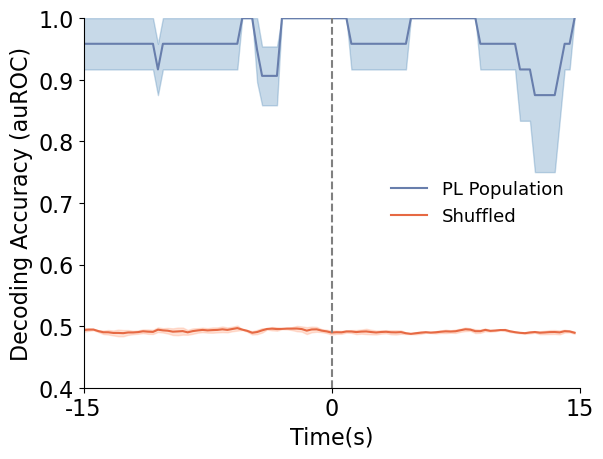

In [89]:
End = round(2*TimeRangeAC/BinSizeAC)
x=np.arange(End)
y=auc_results_all.mean(axis =1)
z=shuffled_auc_results_all.mean(axis =1)
erry = stats.sem(auc_results_all, axis =1)
errz = stats.sem(shuffled_auc_results_all, axis =1)
fig, ax = plt.subplots()
ax.plot(x, y, label = 'PL Population', color = '#687eac')
ax.plot(x, z, label = 'Shuffled', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('Decoding Accuracy (auROC)', fontsize=16)
ax.set_xticks([0,int((End/2)),End])
ax.set_xticklabels([-TimeRangeAC,'0',TimeRangeAC])
ax.set_xlim(0, End)
ax.set_ylim(0.4,1)
ax.tick_params(labelsize = 16)
ax.axvline(int((End/2)), color = 'grey', ls = '--', ymax = 1)
ax.legend(loc = 0, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

### SVM

In [122]:
X = list(trace_combined.dff.squeeze().values)
y = np.array(trace_combined.is_hungry*1)
k = 5

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42, stratify = y)

stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
hyperparameters = [{'kernel': ['rbf'], 'gamma': [ 1e-4, 1e-3,1e-2, 1e-1, 1e0, 1e1, 1e2], 
                     'C': [1e-2,1e-1, 1e0, 1e1, 1e2, 1e3]}, {'kernel': ['linear'], 
                     'C': [1e-2,1e-1, 1e0, 1e1, 1e2, 1e3]}]

clf = GridSearchCV(svm.SVC(), hyperparameters, cv=stratified_kfold, n_jobs =-1)


results = cross_val_score(clf, X_train, y_train, scoring = 'roc_auc', cv = 5)
clf.fit(X_train,y_train)
clf_best=clf.best_estimator_
results

array([0.5, 1. , 0.5, 1. , 1. ])

In [147]:
predictions = clf_best.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.33      0.25      0.29         4

    accuracy                           0.38         8
   macro avg       0.37      0.38      0.37         8
weighted avg       0.37      0.38      0.37         8



In [124]:
clf.best_estimator_

SVC(C=100.0, gamma=0.0001)

In [125]:
clf_best

SVC(C=100.0, gamma=0.0001)

In [82]:
y_test

array([0, 1, 1, 0, 0, 0, 1, 1])

In [83]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8, 8], dtype=int64))

In [84]:
y_pred = clf_best.predict(X_test)
Acc_True = accuracy_score(y_test, y_pred)
Acc_True

0.625

In [85]:
y_test

array([0, 1, 1, 0, 0, 0, 1, 1])

In [129]:
AUC_True = auROC(y_test, y_pred)
AUC_True

0.625

In [131]:
clf.best_params_

{'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}

In [132]:
nump = 1000

accuracy_multisplit_shuffle = np.zeros(nump)
auc_multisplit_shuffle= np.zeros(nump)

for i in range(nump):
    random.shuffle(y_train)
    #clf_shuffle = LDA(**clf.best_params_)
    clf_shuffle = svm.SVC(**clf.best_params_)
    clf_shuffle.fit(X_train, y_train)
    
    y_pred = clf_shuffle.predict(X_test)
    # print(y_pred, y_test)
    
    accuracy_multisplit_shuffle[i] = accuracy_score(y_test, y_pred)
    auc_multisplit_shuffle[i] =  auROC(y_test, y_pred)
    

In [133]:
y_pred

array([0, 1, 0, 1, 1, 1, 1, 1])

In [134]:
p_val = sum(auc_multisplit_shuffle >= AUC_True)/nump
p_val

0.37

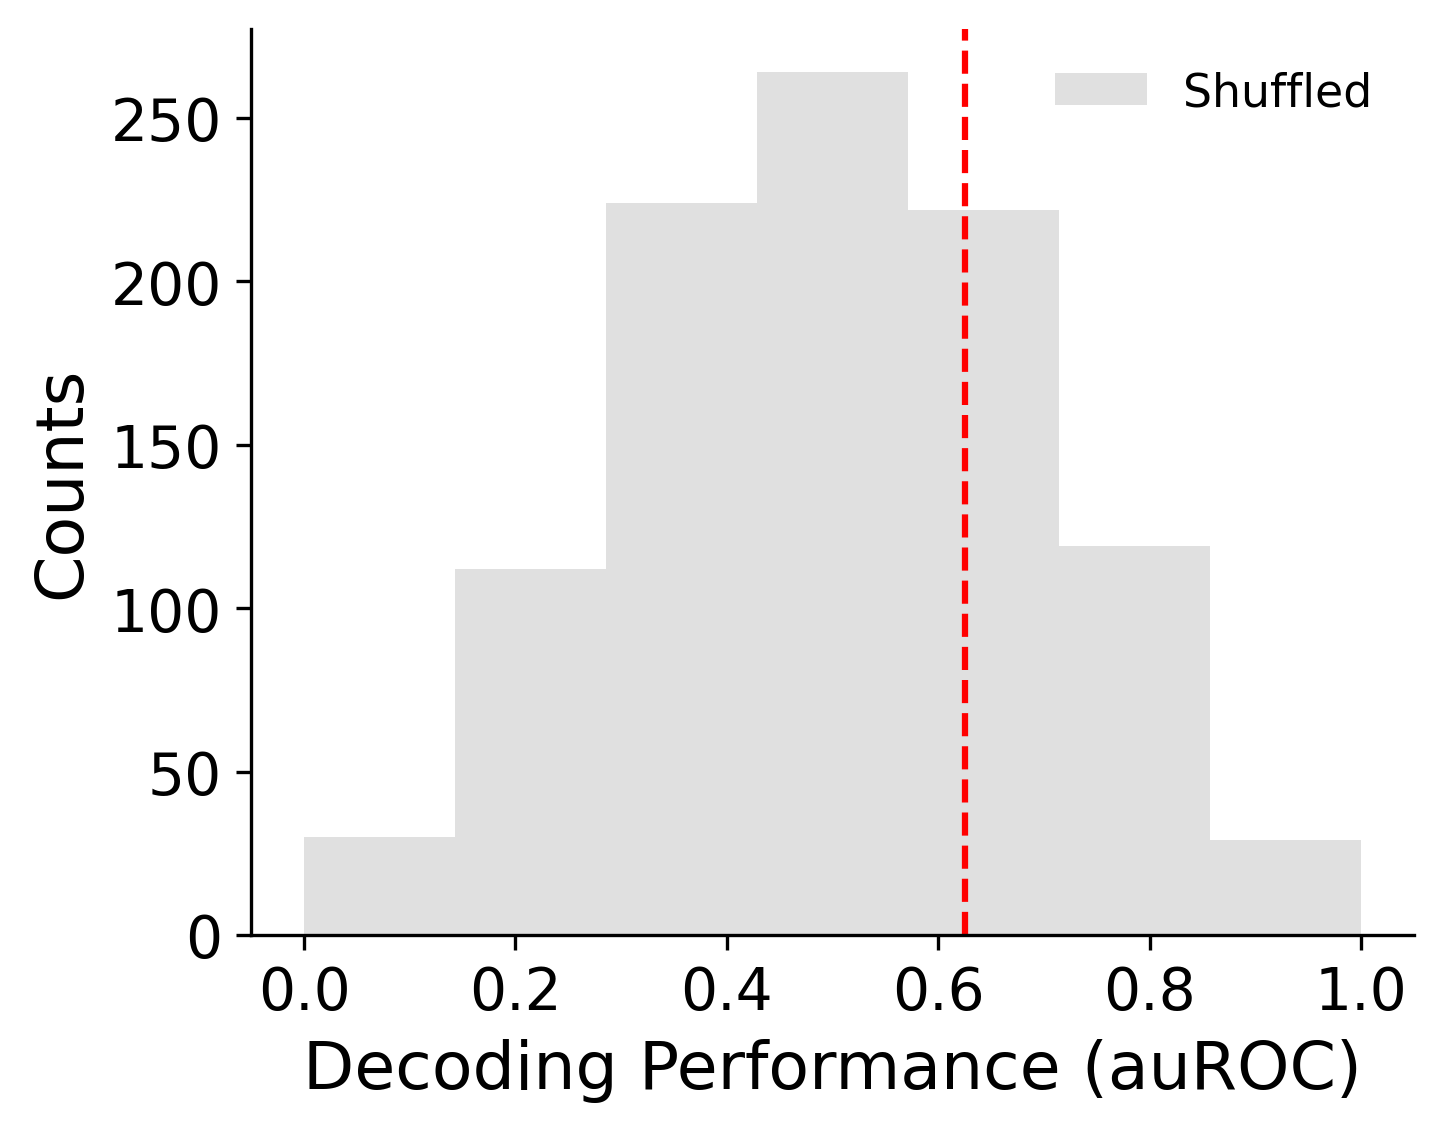

In [145]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
bins=np.histogram(auc_multisplit_shuffle, bins=7)[1]
ax.hist(auc_multisplit_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.legend(loc=0, frameon= False,fontsize =11)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.tick_params(labelsize = 14)
ax.axvline(AUC_True, color = "red", ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [195]:
accuracy_multisplit = np.zeros(100)
auc_multisplit= np.zeros(100)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)#, stratify = y)
    y_pred = clf.predict(X_test)
    accuracy_multisplit[i] = accuracy_score(y_test, y_pred)
    auc_multisplit[i] =  auROC(y_test, y_pred)

In [196]:
accuracy_multisplit.mean()

0.8325

In [197]:
auc_multisplit.mean()

0.8265714285714287

In [58]:
accuracy_multisplit_shuffle = np.zeros(100)
auc_multisplit_shuffle= np.zeros(100)

for i in range(100):
    y_shuffle = np.array(trace_combined.is_hungry*1)
    np.random.shuffle(y_shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y_shuffle, test_size=0.33, stratify = y)
    y_pred = clf.predict(X_test)
    accuracy_multisplit_shuffle[i] = accuracy_score(y_test, y_pred)
    auc_multisplit_shuffle[i] =  auROC(y_test, y_pred)

In [59]:
accuracy_multisplit_shuffle

array([0.375, 0.25 , 0.625, 0.375, 0.75 , 0.375, 0.375, 0.5  , 0.625,
       0.5  , 0.5  , 0.5  , 0.375, 0.625, 0.375, 0.5  , 0.625, 0.75 ,
       0.625, 0.625, 0.625, 0.375, 0.75 , 0.5  , 0.75 , 0.25 , 0.5  ,
       0.5  , 0.25 , 0.875, 0.25 , 0.25 , 0.25 , 0.625, 0.75 , 0.375,
       0.375, 0.5  , 0.625, 0.625, 0.75 , 0.25 , 0.25 , 0.5  , 0.5  ,
       0.5  , 0.375, 0.375, 0.625, 0.375, 0.5  , 0.625, 0.375, 0.5  ,
       0.5  , 0.75 , 0.375, 0.5  , 0.375, 0.625, 0.75 , 0.75 , 0.5  ,
       0.   , 0.25 , 0.875, 0.625, 0.875, 0.25 , 0.75 , 0.375, 0.5  ,
       0.375, 0.375, 0.625, 0.5  , 0.25 , 0.5  , 0.5  , 0.375, 0.25 ,
       0.25 , 0.5  , 0.625, 0.375, 0.75 , 0.75 , 0.25 , 0.75 , 0.625,
       0.5  , 0.5  , 0.75 , 0.25 , 0.375, 0.375, 0.375, 0.625, 0.375,
       0.375])

In [109]:
accuracy_multisplit_shuffle.mean()

0.52375

In [110]:
auc_multisplit_shuffle.mean()

0.5271904761904761

In [111]:
stats.ttest_ind(accuracy_multisplit, accuracy_multisplit_shuffle,  alternative='two-sided')

Ttest_indResult(statistic=14.142212404713549, pvalue=7.612994638157675e-32)

Text(1.25, 0.925, '*')

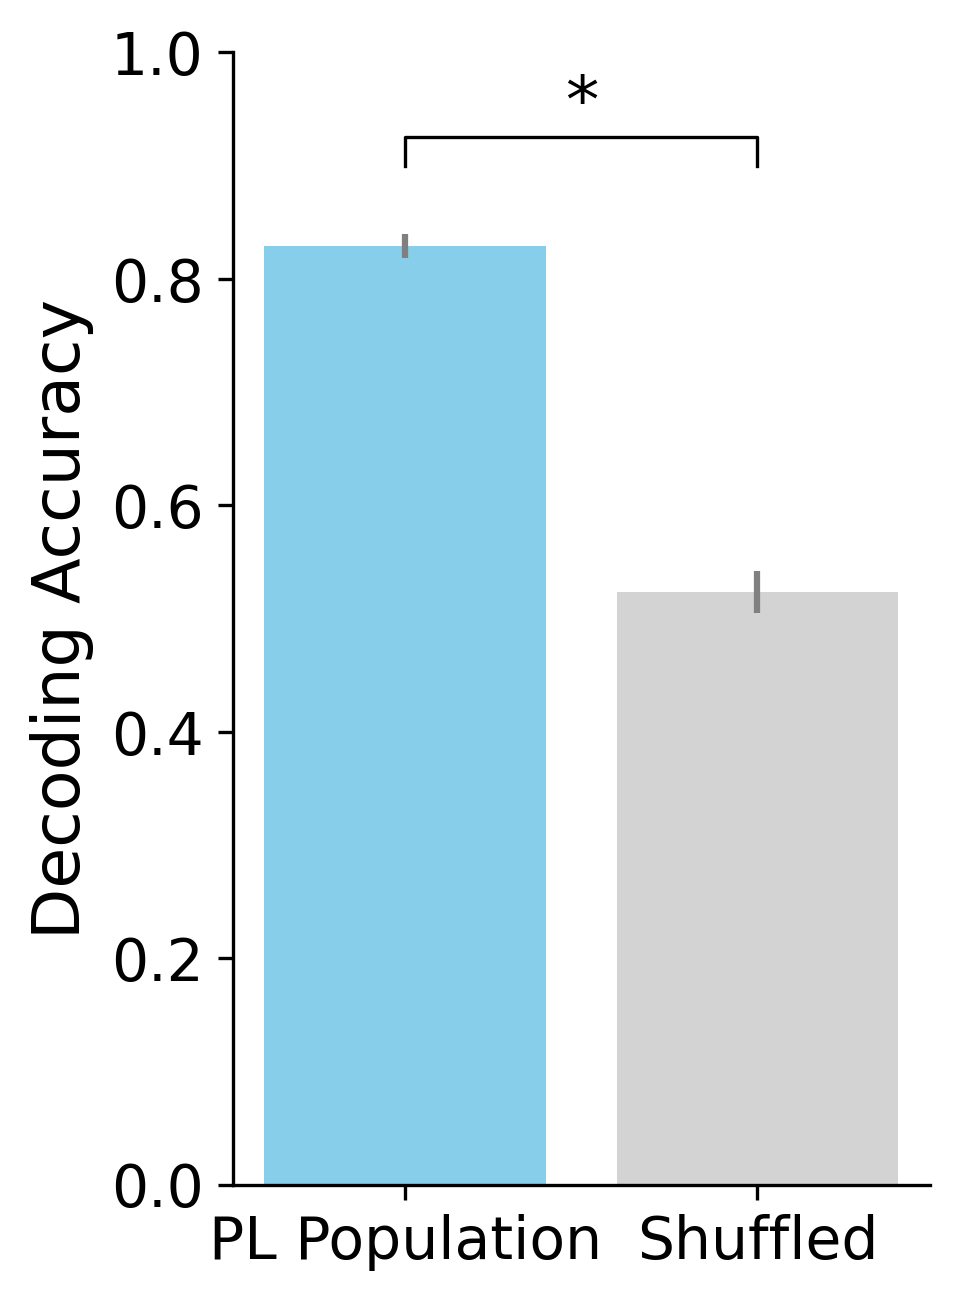

In [112]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,accuracy_multisplit.mean(), yerr=stats.sem(accuracy_multisplit), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,accuracy_multisplit_shuffle.mean(), yerr=stats.sem(accuracy_multisplit_shuffle), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,1))
x1, x2 = 1, 1.5
y, h, col = 0.9, 0.025, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

Text(1.25, 0.925, '*')

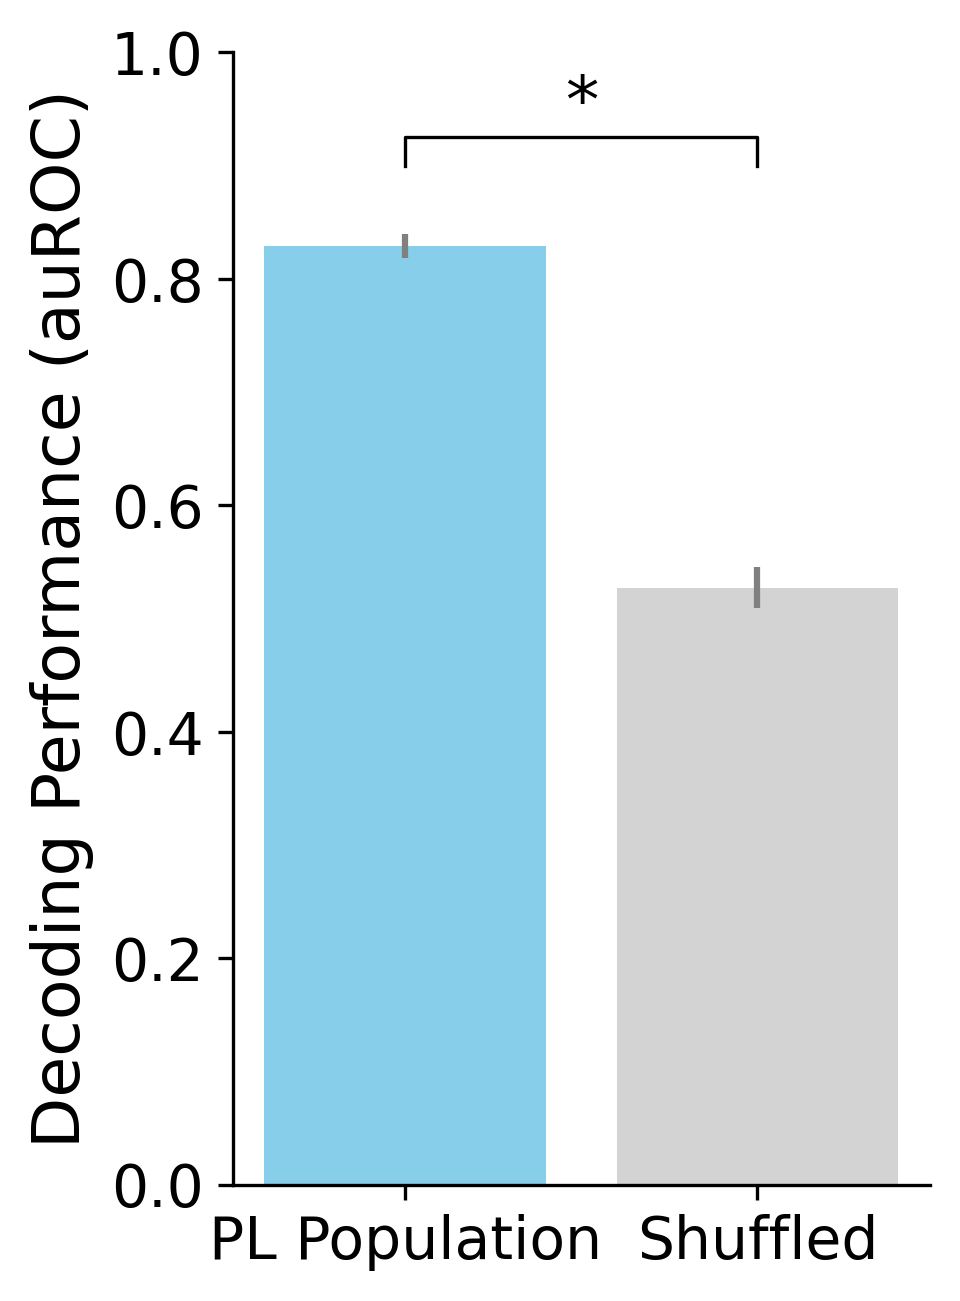

In [113]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,auc_multisplit.mean(), yerr=stats.sem(auc_multisplit), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,auc_multisplit_shuffle.mean(), yerr=stats.sem(auc_multisplit_shuffle), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["PL Population", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,1))
x1, x2 = 1, 1.5
y, h, col = 0.9, 0.025, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

# Taking each neuron as an observation

In [150]:
tracehungry = pd.DataFrame()


for n in range(len(os.listdir(hungry_dir))):
    f = pd.read_pickle(os.path.join(hungry_dir, os.listdir(hungry_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)
    tracehungry = tracehungry.append(tracenew)


C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\1646597215.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracenew)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\1646597215.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracenew)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\1646597215.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracenew)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\1646597215.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.a

In [151]:
hungry_trace = tracehungry.to_numpy(dtype = "float32").flatten()

In [152]:
tracesatiated = pd.DataFrame()


for n in range(len(os.listdir(satiated_dir))):
    f = pd.read_pickle(os.path.join(satiated_dir, os.listdir(satiated_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)
    tracesatiated = tracesatiated.append(tracenew)

C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\544914899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracenew)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\544914899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracenew)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\544914899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracenew)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\544914899.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tra

In [153]:
tracesatiated.shape

(548, 12)

In [154]:
satiated_trace = tracesatiated.to_numpy(dtype = "float32").flatten()

In [155]:
%%time
X = np.concatenate([hungry_trace,satiated_trace]).reshape(-1,1)
y = np.concatenate([np.repeat(True,len(hungry_trace)),np.repeat(False,len(satiated_trace))])
k = 5
stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = GridSearchCV(svm.SVC(), hyperparameters, cv=stratified_kfold, n_jobs =-1)
#clf= svm.SVC(kernel = 'rbf', gamma = 0.1, C = 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 7)
results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
clf.fit(X_train,y_train)
clf
results

CPU times: total: 30.2 s
Wall time: 7min 46s


array([0.5036869 , 0.49829739, 0.48808173, 0.49375709, 0.50681044])

In [156]:
y_shuffle = np.concatenate([np.repeat(True,len(hungry_trace)),np.repeat(False,len(satiated_trace))])
np.random.shuffle(y_shuffle)

In [1457]:
stats.ttest_ind(results, results_shuffle,  alternative='two-sided')

Ttest_indResult(statistic=8.497058314499201, pvalue=2.8224732471812898e-05)

In [1337]:
population_accuracy = pd.DataFrame()
population_accuracy["Score"]= np.concatenate([results,results_shuffle])
population_accuracy["Data"] = np.concatenate([np.repeat("PL Population",k),np.repeat("Shuffled",k)])

Text(1.25, 0.775, '*')

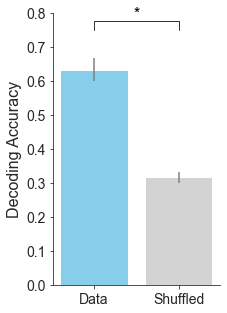

In [1338]:
fig, ax = plt.subplots(figsize = (3,5))
ax.yaxis.set_ticks_position('left')
ax.bar(1,results.mean(), yerr=stats.sem(results), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,results_shuffle.mean(), yerr=stats.sem(results_shuffle), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["Data", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,0.8))
x1, x2 = 1, 1.5
y, h, col = 0.75, 0.025, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

Text(0.5, 0.925, '*')

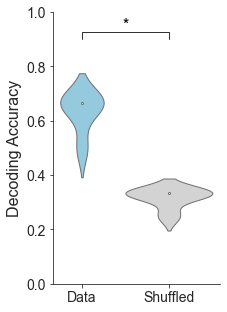

In [1340]:

fig, ax = plt.subplots(figsize=(3, 5))
sb.violinplot(x= "Data", y = "Score",linewidth=1,palette=["skyblue", "lightgrey"],data = population_accuracy,
              dodge=False,inner="box", width = 1.0)
sb.set_style("ticks")
ax.set_ylim(0,1.0)
ax.set_xlabel(None) 
ax.set_xticklabels(["Data", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
sb.despine()
x1, x2 = 0, 1
y, h, col = 0.9, 0.025, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


In [35]:
clf

SVC()

In [157]:
%%time
accuracy_multisplit = np.zeros(100)
accuracy_multisplit_shuffle = np.zeros(100)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    y_pred = clf.predict(X_test)
    accuracy_multisplit[i] = accuracy_score(y_test, y_pred)
    
    np.random.shuffle(y_shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y_shuffle, test_size=0.33)
    y_pred = clf.predict(X_test)
    accuracy_multisplit_shuffle[i] = accuracy_score(y_test, y_pred)

CPU times: total: 15min 5s
Wall time: 15min 5s


In [159]:
accuracy_multisplit

array([0.51094218, 0.50909929, 0.49182216, 0.49043999, 0.48767565,
       0.49343469, 0.50334024, 0.50287952, 0.50587422, 0.50794748,
       0.50380097, 0.49297397, 0.50587422, 0.50103663, 0.4994241 ,
       0.50080627, 0.49481686, 0.49504722, 0.49550795, 0.5024188 ,
       0.50011518, 0.50748675, 0.49412578, 0.49965446, 0.4975812 ,
       0.50495278, 0.51347616, 0.49827229, 0.49527759, 0.50610458,
       0.4837595 , 0.49297397, 0.49366505, 0.4945865 , 0.50218844,
       0.49735084, 0.50011518, 0.49896337, 0.49642939, 0.4994241 ,
       0.49735084, 0.49550795, 0.50334024, 0.50886892, 0.49343469,
       0.49136144, 0.50357061, 0.48491131, 0.49412578, 0.49205252,
       0.49020963, 0.48974891, 0.49412578, 0.50979037, 0.50426169,
       0.5054135 , 0.50195807, 0.49182216, 0.50518314, 0.49435614,
       0.49642939, 0.4867542 , 0.49919373, 0.51163326, 0.49665976,
       0.48145589, 0.50011518, 0.49873301, 0.49527759, 0.49573831,
       0.4994241 , 0.49412578, 0.50218844, 0.49619903, 0.49873

In [42]:
%%time
accuracy_multisplit_shuffle = np.zeros(100)

for i in range(100):
    np.random.shuffle(y_shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y_shuffle, test_size=0.33)
    y_pred = clf.predict(X_test)
    accuracy_multisplit_shuffle[i] = accuracy_score(y_test, y_pred)

CPU times: total: 6min 26s
Wall time: 6min 26s


In [43]:
accuracy_multisplit_shuffle.mean()

0.5008431237042157

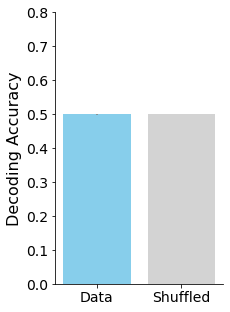

In [158]:
fig, ax = plt.subplots(figsize = (3,5))
ax.yaxis.set_ticks_position('left')
ax.bar(1,accuracy_multisplit.mean(), yerr=stats.sem(accuracy_multisplit), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,accuracy_multisplit_shuffle.mean(), yerr=stats.sem(accuracy_multisplit_shuffle), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["Data", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,0.8))
x1, x2 = 1, 1.5
y, h, col = 0.75, 0.025, 'k'
#ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
#ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

# Individual Neurons

In [114]:
tracehungry = pd.DataFrame()


for n in range(len(os.listdir(hungry_dir))):
    f = pd.read_pickle(os.path.join(hungry_dir, os.listdir(hungry_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)
    tracehungry = tracehungry.append(tracenew)


In [115]:
tracehungry

0           1           2            3           4           5   \
2    580.357142  170.477773  214.531599   104.522221  125.523216   61.147676   
5    139.388393   83.946256  110.773676   133.033543   92.504327  264.534649   
6    241.465617  343.542651  101.321636   115.899393  256.788086  133.990138   
7    131.240603   44.607877   73.999520    13.350376   21.098757   58.637567   
8    225.824879  727.002370   78.475515   211.190312  152.778348  147.766042   
..          ...         ...         ...          ...         ...         ...   
61  1431.064051  459.321572  565.145371  1134.494992  306.080422  246.314618   
62   732.623744  468.704610  488.893164   108.441206  104.599750  236.354148   
64  2077.441397  728.614870  675.222389  1376.600274  781.904715  818.153206   
65   255.420079  116.848626  118.960314    13.554103   61.320914    9.252651   
67   194.814982  187.522734  183.675376    37.153059  133.485760  117.422286   

            6            7           8           9           10          11  
2    63.735174   276.230487  204.151982  182.746436   91.943112   95.228709  
5   192.728914   102.901267  180.992121  121.325079   93.249761  470.079804  
6   116.147859   196.682698  103.566927  121.309583  175.354633   88.765078  
7    10.117742    24.348222   91.627430  154.578226   10.514261   20.525508  
8    32.020737   516.690306  368.241737  202.980744  187.443573  111.660653  
..         ...          ...         ...         ...         ...         ...  
61  258.392628   595.838083  260.219726  266.717387  447.060909  515.954825  
62   50.204462   198.551554   91.701981  137.889441   74.039234   98.092819  
64  484.239396  1424.248424  307.337314  819.701427  315.654582  519.632236  
65   10.743105    30.723375   25.075337    9.215814   36.729330   41.897126  
67   78.061710    83.353432  125.249795  123.536619  125.833686  128.592470  

[548 rows x 12 columns]

In [118]:
hungry_trace = pd.DataFrame()

for i in range(len(tracehungry)):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([True])
    dff["dff"]= [np.array(tracehungry.iloc[i,:].values)]
    
    hungry_trace = hungry_trace.append(dff)

In [119]:
tracesatiated = pd.DataFrame()


for n in range(len(os.listdir(satiated_dir))):
    f = pd.read_pickle(os.path.join(satiated_dir, os.listdir(satiated_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)
    tracesatiated = tracesatiated.append(tracenew)

In [120]:
satiated_trace = pd.DataFrame()

for i in range(len(tracesatiated)):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array([False])
    dff["dff"]= [np.array(tracesatiated.iloc[i,:].values)]
    
    satiated_trace = satiated_trace.append(dff)

In [148]:
%%time
training_accuracy_grd = np.zeros(len(tracesatiated))
testing_accuracy_grd = np.zeros(len(tracesatiated))
testing_accuracy_shuffle_grd = np.zeros(len(tracesatiated))
training_auc_grd = np.zeros(len(tracesatiated))
testing_auc_grd = np.zeros(len(tracesatiated))
testing_auc_shuffle_grd = np.zeros(len(tracesatiated))
for i in range(len(tracesatiated)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    y_shuffle = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    np.random.shuffle(y_shuffle)
    k = 5
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state =42, stratify = y)
    stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(svm.SVC(probability=True), hyperparameters, cv=stratified_kfold, n_jobs =-1)
    results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
    results_auc = cross_val_score(clf, X_train, y_train, scoring ='roc_auc', cv = stratified_kfold)
    training_accuracy_grd[i] = results.mean()
    training_auc_grd[i] = results_auc.mean()
    clf.fit(X_train,y_train)
    clf = clf.best_estimator_
    accuracy_multisplit = np.zeros(100)
    accuracy_multisplit_shuffle = np.zeros(100)
    auc_multisplit = np.zeros(100)
    auc_multisplit_shuffle = np.zeros(100)
    # Initialize RepeatedStratifiedKFold with n_splits=2 and n_repeats=50
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=50, random_state=0)
    
    for j, (train_index, test_index) in enumerate(rskf.split(X, y)):
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = clf.predict(X_test)
        accuracy_multisplit[j] = accuracy_score(y_test, y_pred)
        auc_multisplit[j] =  auROC(y_test, y_pred)
        
    for j, (train_index, test_index) in enumerate(rskf.split(X, y_shuffle)):
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = y_shuffle[train_index], y_shuffle[test_index]
        y_pred = clf.predict(X_test)
        accuracy_multisplit_shuffle[j] = accuracy_score(y_test, y_pred)
        auc_multisplit_shuffle[j] = auROC(y_test, y_pred)
        
    testing_accuracy_grd[i] = accuracy_multisplit.mean()
    testing_accuracy_shuffle_grd[i] = accuracy_multisplit_shuffle.mean()
    testing_auc_grd[i] = auc_multisplit.mean()
    testing_auc_shuffle_grd[i] = auc_multisplit_shuffle.mean()
    

CPU times: total: 21min 16s
Wall time: 21min 8s


In [149]:
tracehungry.iloc[np.where(testing_accuracy_grd>0.6)[0]]

0           1           2            3           4           5   \
2    580.357142  170.477773  214.531599   104.522221  125.523216   61.147676   
5    139.388393   83.946256  110.773676   133.033543   92.504327  264.534649   
6    241.465617  343.542651  101.321636   115.899393  256.788086  133.990138   
7    131.240603   44.607877   73.999520    13.350376   21.098757   58.637567   
8    225.824879  727.002370   78.475515   211.190312  152.778348  147.766042   
..          ...         ...         ...          ...         ...         ...   
61  1431.064051  459.321572  565.145371  1134.494992  306.080422  246.314618   
62   732.623744  468.704610  488.893164   108.441206  104.599750  236.354148   
64  2077.441397  728.614870  675.222389  1376.600274  781.904715  818.153206   
65   255.420079  116.848626  118.960314    13.554103   61.320914    9.252651   
67   194.814982  187.522734  183.675376    37.153059  133.485760  117.422286   

            6            7           8           9           10          11  
2    63.735174   276.230487  204.151982  182.746436   91.943112   95.228709  
5   192.728914   102.901267  180.992121  121.325079   93.249761  470.079804  
6   116.147859   196.682698  103.566927  121.309583  175.354633   88.765078  
7    10.117742    24.348222   91.627430  154.578226   10.514261   20.525508  
8    32.020737   516.690306  368.241737  202.980744  187.443573  111.660653  
..         ...          ...         ...         ...         ...         ...  
61  258.392628   595.838083  260.219726  266.717387  447.060909  515.954825  
62   50.204462   198.551554   91.701981  137.889441   74.039234   98.092819  
64  484.239396  1424.248424  307.337314  819.701427  315.654582  519.632236  
65   10.743105    30.723375   25.075337    9.215814   36.729330   41.897126  
67   78.061710    83.353432  125.249795  123.536619  125.833686  128.592470  

[401 rows x 12 columns]

In [150]:
tracesatiated.iloc[np.where(testing_accuracy_grd>0.6)[0]]

0            1           2           3            4           5   \
2   336.842818   117.667157  327.214723  136.213460   547.677784  144.467729   
5   162.545399   140.079800  233.977478  230.438519   174.154164  177.303829   
6    85.612359    74.874663  253.094262  327.965307    56.359376  269.886744   
7    86.089057   294.272665   86.638118  136.859429    28.623197   55.940405   
8    41.140772   296.305219   24.209724  106.210076   923.496338  149.070056   
..         ...          ...         ...         ...          ...         ...   
61  561.565485  1029.353146  628.341498  312.046165   711.169699  368.965752   
62  659.255354   553.846053  516.635214   58.616432   227.172368   90.975733   
64  754.991121  1701.884852  960.788552  474.126430  1785.184671  707.702715   
65  137.938542   111.945670  156.131638   27.222979     9.024775   56.727993   
67  292.000563   142.037658  135.148602   90.943791    52.019951  101.662292   

            6           7            8           9            10          11  
2   133.706527   76.857861    73.298304   78.965253   329.959274  317.395199  
5   263.411694  519.306733   156.010638  361.084314   137.152621  305.837443  
6    40.825436  491.239126   214.112481  336.094426    93.810245   99.161823  
7    78.812762  495.926830    66.000892   60.576024    83.650597   90.179790  
8   200.576325   88.398213   418.412857  316.041099    48.054152  136.913562  
..         ...         ...          ...         ...          ...         ...  
61  249.111702  588.096891   371.196106  247.926049   217.366680  242.396334  
62   86.735518   99.083551    71.380787  152.382769    93.786881  205.239856  
64  346.118721  750.969663  2543.725543  489.549938  1491.637200  971.656617  
65   28.824603   54.510535    32.002489  165.684514    12.623798   47.218782  
67  139.521082   68.603791    60.118899  110.912035    70.252318  126.187776  

[401 rows x 12 columns]

In [151]:
stats.ttest_ind(testing_accuracy_grd, testing_accuracy_shuffle_grd,  alternative='two-sided')

Ttest_indResult(statistic=28.69172625244547, pvalue=1.9359949792658743e-135)

In [164]:
individual_accuracy = pd.DataFrame()
individual_accuracy["Score"]= np.concatenate([testing_accuracy_grd,testing_accuracy_shuffle_grd])
individual_accuracy["Data"] = np.concatenate([np.repeat("Individual PL Neurons",len(tracesatiated)),np.repeat("Shuffled",len(tracesatiated))])

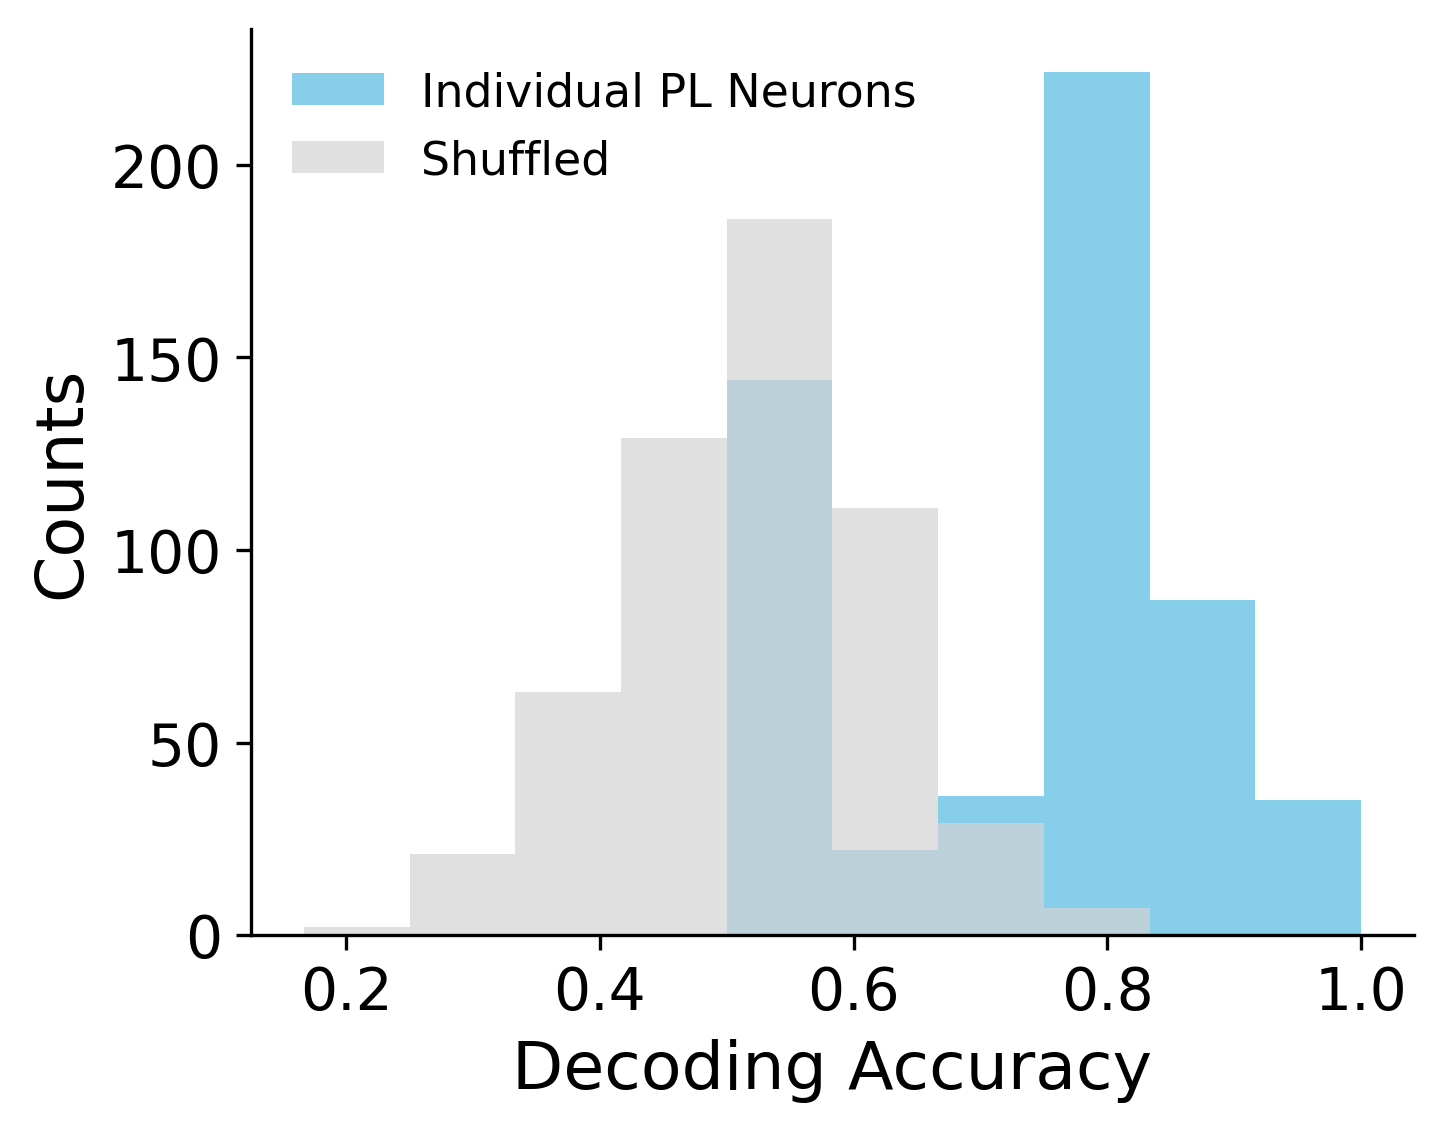

In [153]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
#ax.hist(training_accuracy, label = "training_accuracy",color = "lightgreen",alpha = 0.8, binwidth = 10, rwidth=1)
bins=np.histogram(np.hstack((testing_accuracy_grd,testing_accuracy_shuffle_grd)), bins=10)[1]
ax.hist(testing_accuracy_grd, bins,label = "Individual PL Neurons",color = "skyblue",alpha = 1, rwidth=1)
ax.hist(testing_accuracy_shuffle_grd, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.legend(loc=0, frameon= False,fontsize =11)
ax.set_xlabel("Decoding Accuracy", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

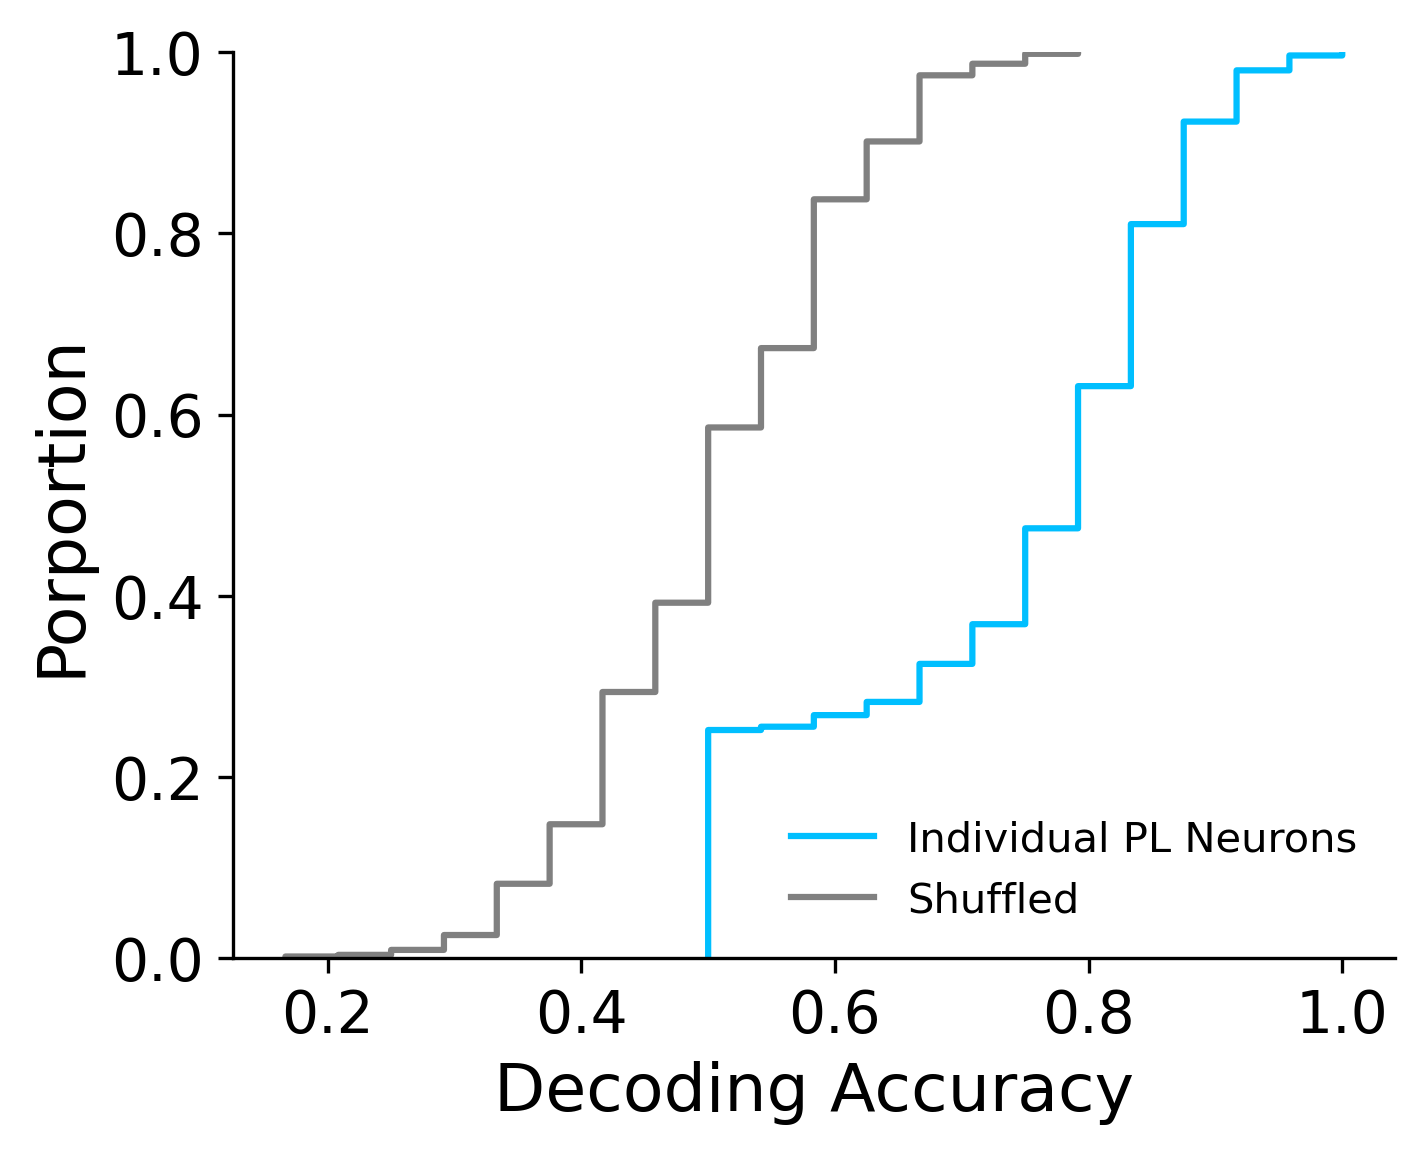

In [154]:
fig, ax = plt.subplots(figsize=(5, 4), dpi =300)
stat = "proportion"
g = sb.ecdfplot(data =individual_accuracy, x = "Score", hue ="Data", stat = stat, palette= ["deepskyblue", "grey"])
ax.set_xlabel("Decoding Accuracy", fontsize = 16)
ax.set_ylabel("Porportion", fontsize =16)
ax.tick_params(labelsize = 14)
g.legend_.set_title(None)
g.legend_.get_frame().set_linewidth(0.0)
sb.despine()

Text(1.25, 0.775, '*')

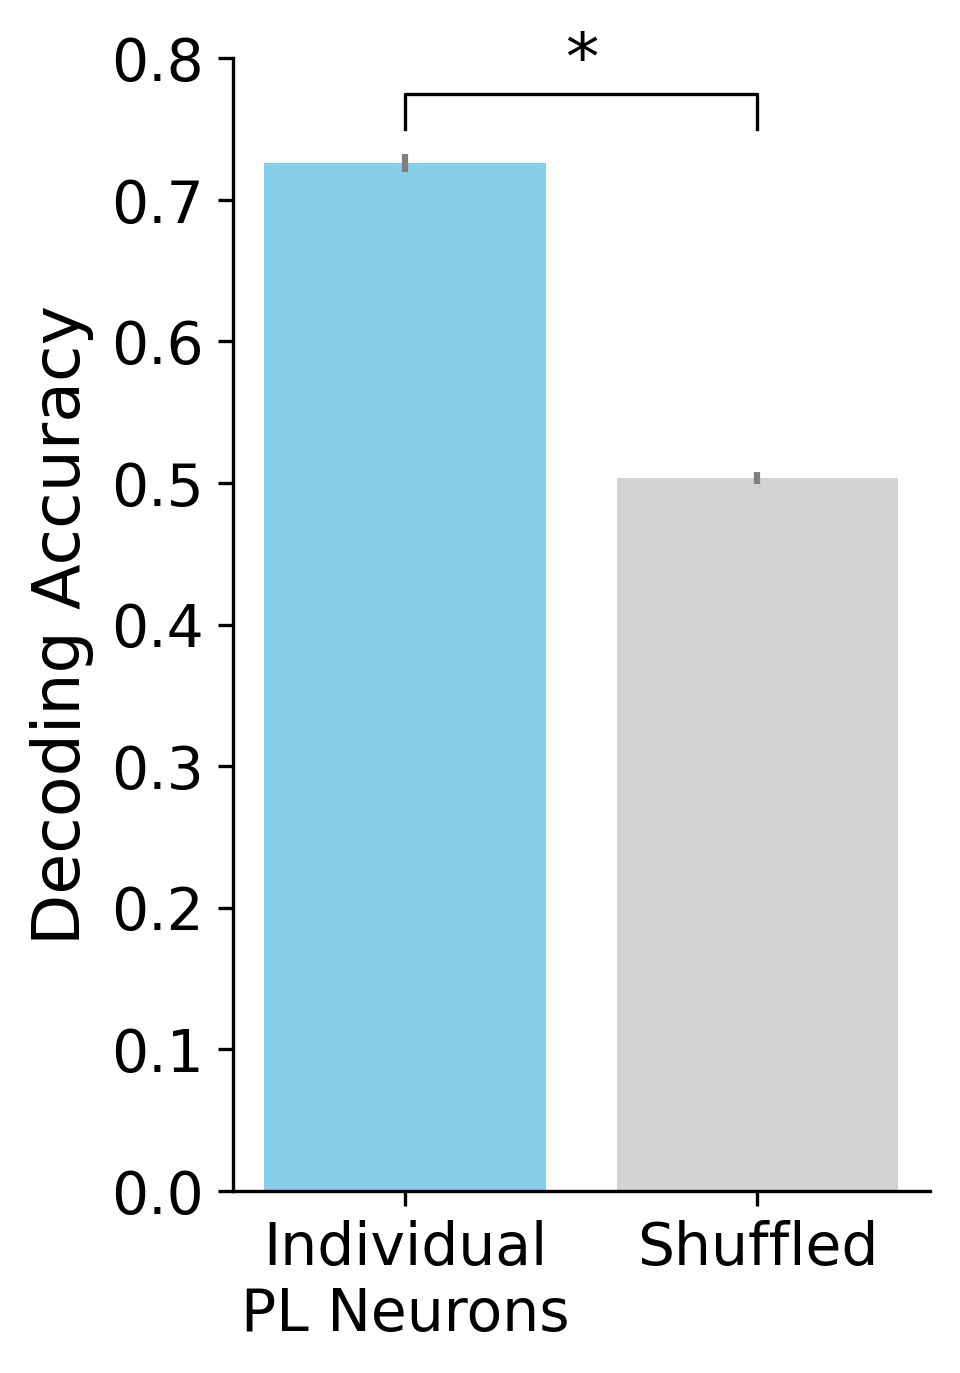

In [155]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,testing_accuracy_grd.mean(), yerr=stats.sem(testing_accuracy_grd), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,testing_accuracy_shuffle_grd.mean(), yerr=stats.sem(testing_accuracy_shuffle_grd), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["Individual\nPL Neurons", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,0.8))
x1, x2 = 1, 1.5
y, h, col = 0.75, 0.025, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

Text(0.5, 1.05, '*')

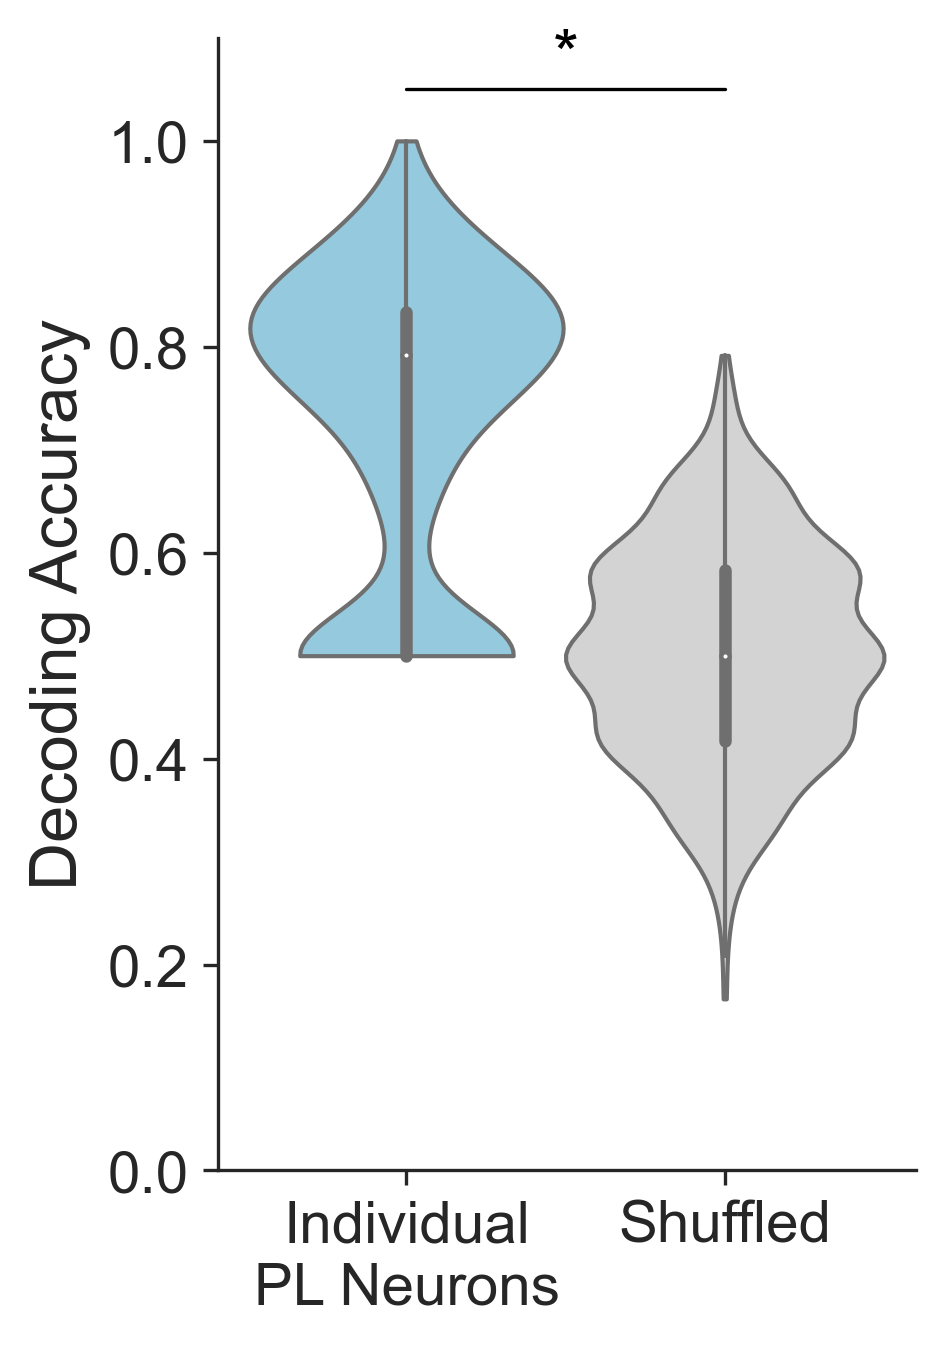

In [167]:

fig, ax = plt.subplots(figsize=(3, 5), dpi =300)
sb.violinplot(x= "Data", y = "Score",linewidth=1,palette=["skyblue", "lightgrey"],data = individual_accuracy,
              dodge=False,inner="box", width = 1.0, cut = 0)
sb.set_style("ticks")
ax.set_ylim(0,1.1)
ax.set_xlabel(None) 
ax.set_xticklabels(["Individual\nPL Neurons", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
sb.despine()
x1, x2 = 0, 1
y, h, col = 1.05, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


In [157]:
stats.ttest_ind(testing_auc_grd, testing_auc_shuffle_grd,  alternative='two-sided')

Ttest_indResult(statistic=28.691726252445456, pvalue=1.9359949792664255e-135)

In [168]:
individual_accuracy = pd.DataFrame()
individual_accuracy["Score"]= np.concatenate([testing_auc_grd,testing_auc_shuffle_grd])
individual_accuracy["Data"] = np.concatenate([np.repeat("Individual PL Neurons",len(tracesatiated)),np.repeat("Shuffled",len(tracesatiated))])

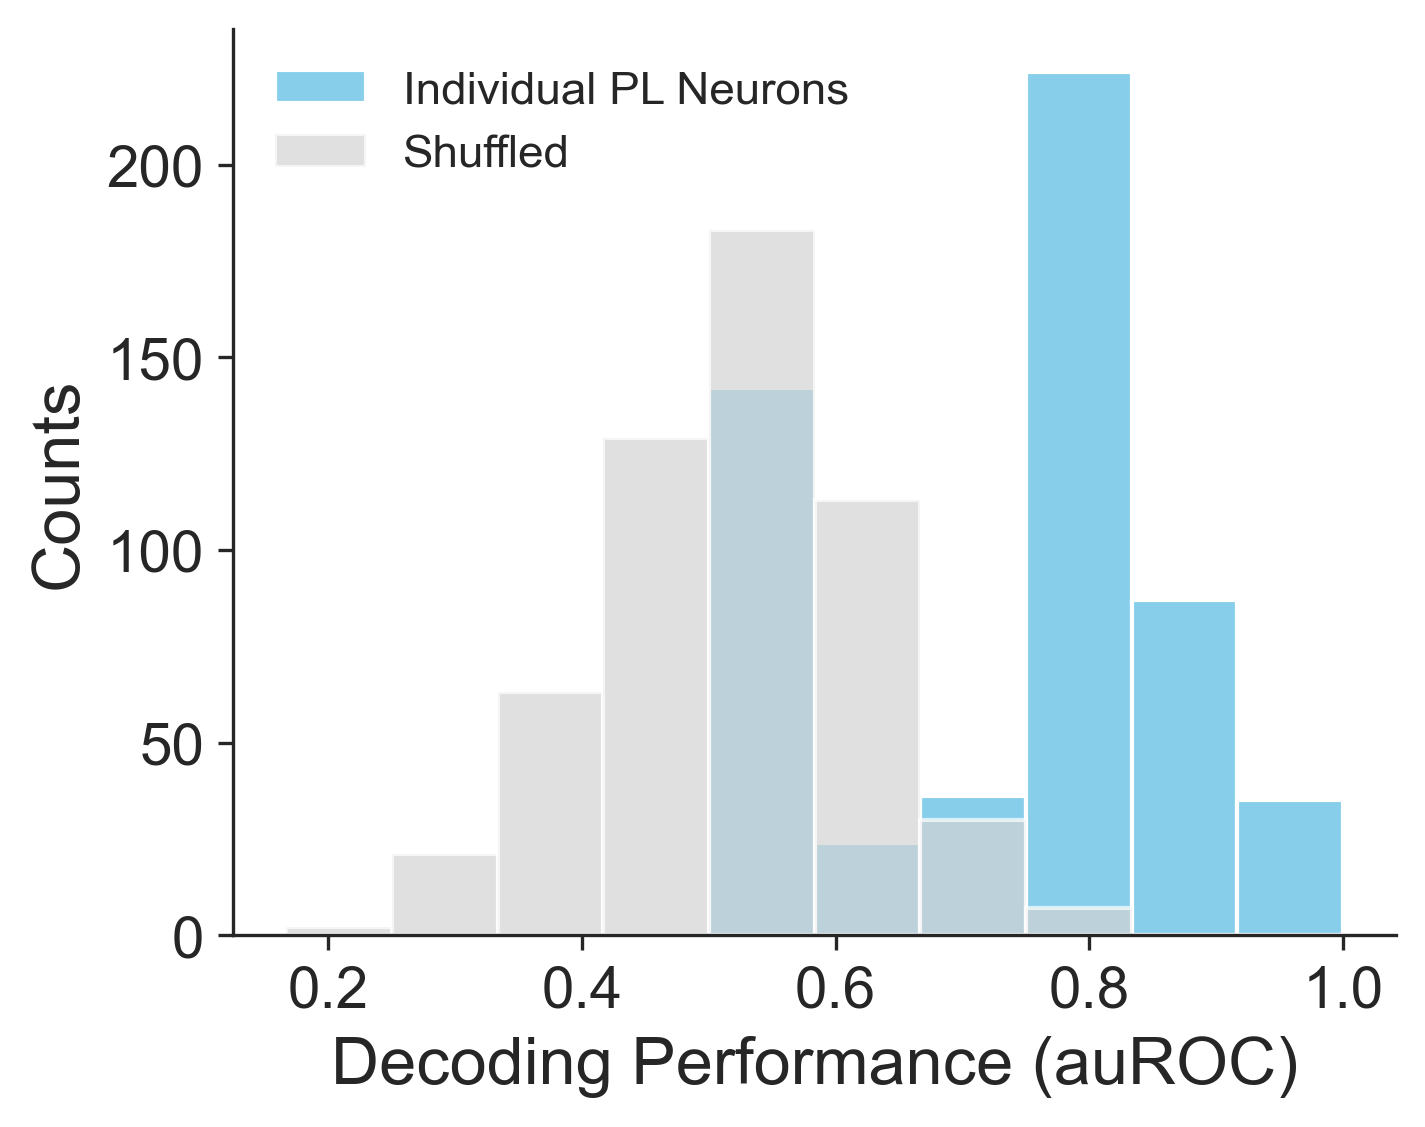

In [177]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
#ax.hist(training_accuracy, label = "training_accuracy",color = "lightgreen",alpha = 0.8, binwidth = 10, rwidth=1)
bins=np.histogram(np.hstack((testing_auc_grd,testing_auc_shuffle_grd)), bins=10)[1]
ax.hist(testing_auc_grd, bins,label = "Individual PL Neurons",color = "skyblue",alpha = 1, rwidth=1)
ax.hist(testing_auc_shuffle_grd, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.legend(loc=0, frameon= False,fontsize =11)
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

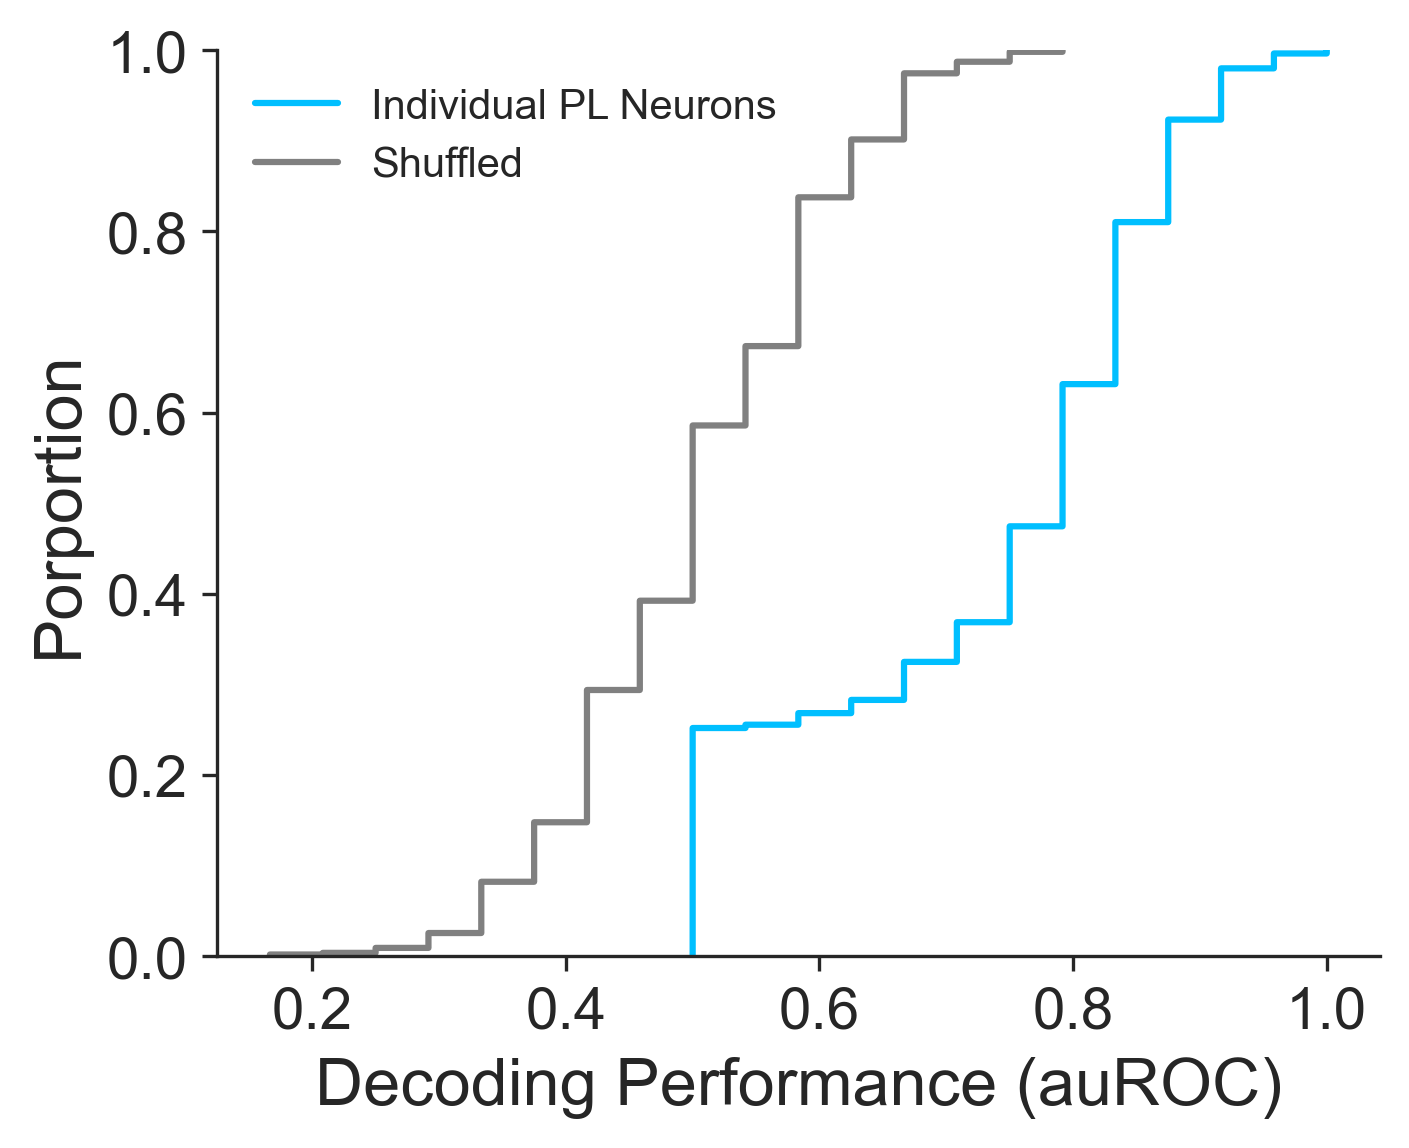

In [161]:
fig, ax = plt.subplots(figsize=(5, 4), dpi =300)
stat = "proportion"
g = sb.ecdfplot(data =individual_accuracy, x = "Score", hue ="Data", stat = stat, palette= ["deepskyblue", "grey"])
ax.set_xlabel("Decoding Performance (auROC)", fontsize = 16)
ax.set_ylabel("Porportion", fontsize =16)
ax.tick_params(labelsize = 14)
g.legend_.set_title(None)
g.legend_.get_frame().set_linewidth(0.0)
sb.despine()

Text(1.25, 0.75, '*')

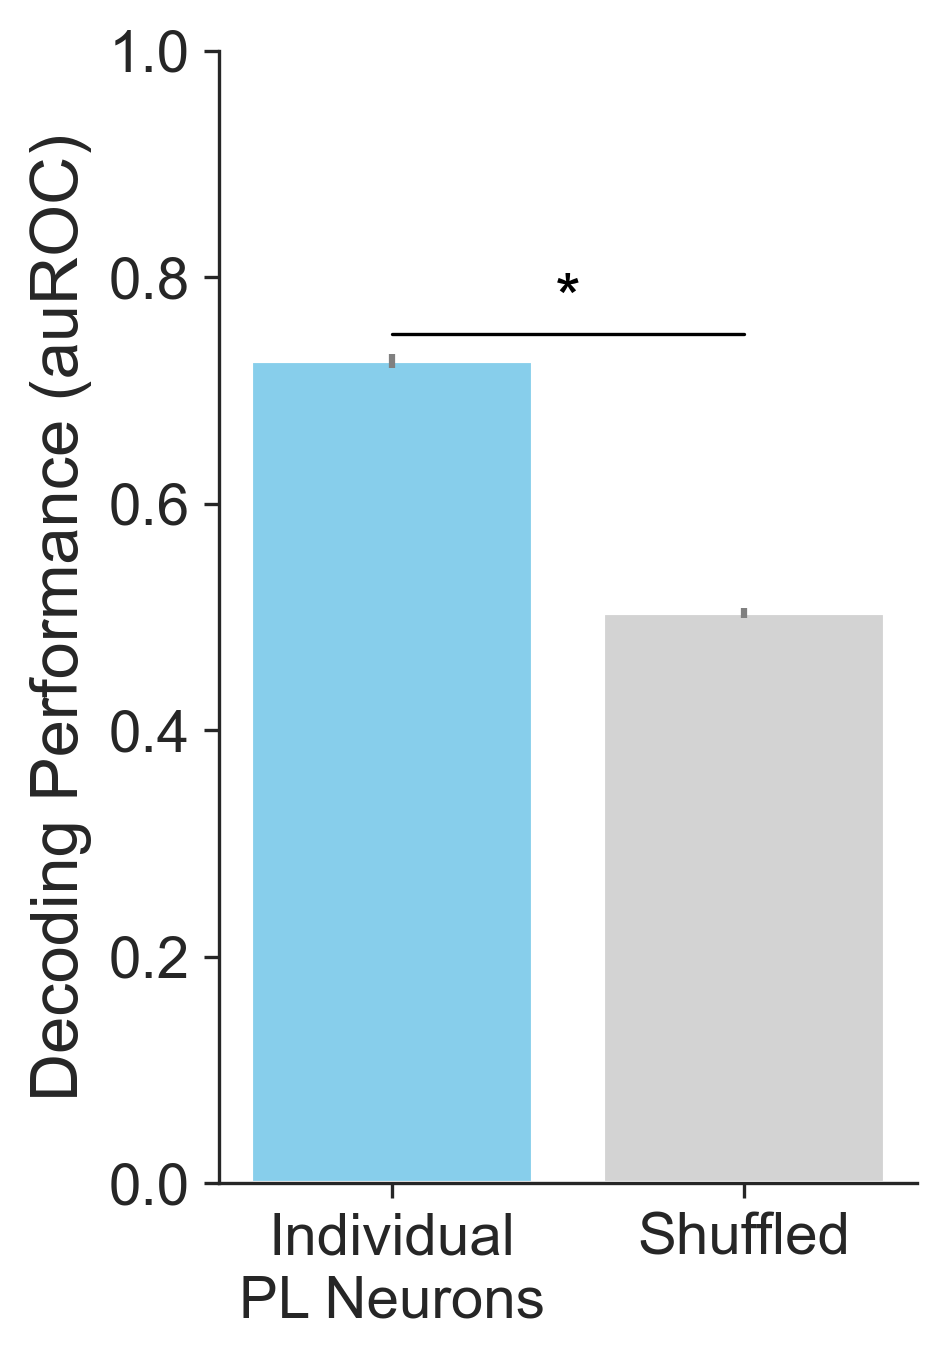

In [176]:
fig, ax = plt.subplots(figsize = (3,5), dpi =300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,testing_auc_grd.mean(), yerr=stats.sem(testing_auc_grd), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,testing_auc_shuffle_grd.mean(), yerr=stats.sem(testing_auc_shuffle_grd), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["Individual\nPL Neurons", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,1))
x1, x2 = 1, 1.5
y, h, col = 0.75, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

Text(0.5, 1.05, '*')

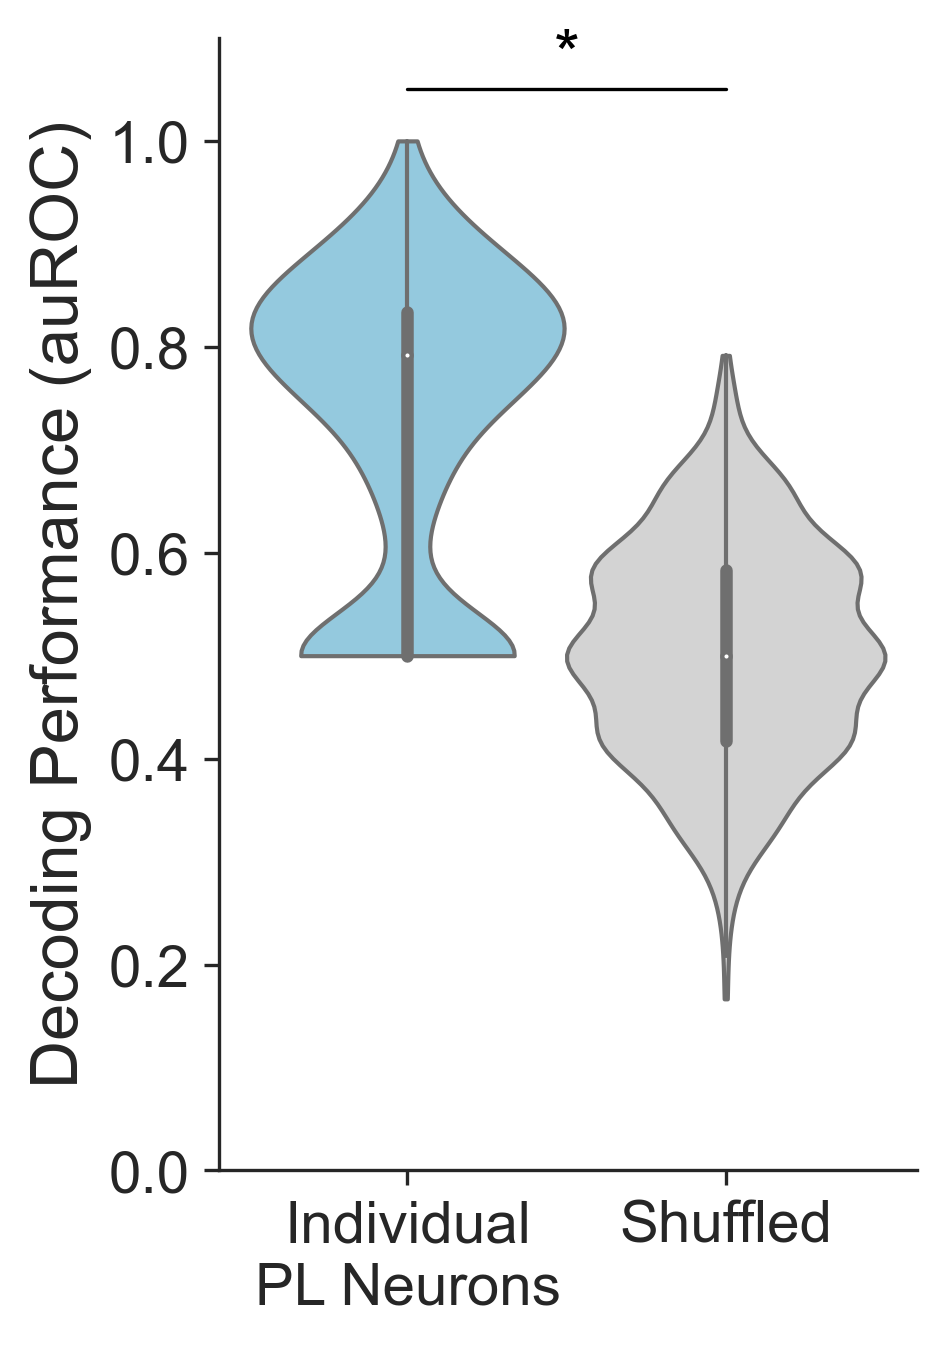

In [170]:

fig, ax = plt.subplots(figsize=(3, 5), dpi =300)
sb.violinplot(x= "Data", y = "Score",linewidth=1,palette=["skyblue", "lightgrey"],data = individual_accuracy,
              dodge=False,inner="box", width = 1.0, cut =0)
sb.set_style("ticks")
ax.set_ylim(0,1.1)
ax.set_xlabel(None) 
ax.set_xticklabels(["Individual\nPL Neurons", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Performance (auROC)", fontsize =16)
ax.tick_params(labelsize = 14)
sb.despine()
x1, x2 = 0, 1
y, h, col = 1.05, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


### Without Gridsearchcv

In [266]:
%%time
training_accuracy = np.zeros(len(tracesatiated))
testing_accuracy = np.zeros(len(tracesatiated))
testing_accuracy_shuffle = np.zeros(len(tracesatiated))
for i in range(len(tracesatiated)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    y_shuffle = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    np.random.shuffle(y_shuffle)
    k = 5
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state =42)
    stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
    #hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
    #                 'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    #clf = GridSearchCV(svm.SVC(), hyperparameters, cv=stratified_kfold, n_jobs =-1)
    clf = svm.SVC()
    results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
    training_accuracy[i] = results.mean()
    clf.fit(X_train,y_train)
    accuracy_multisplit = np.zeros(100)
    accuracy_multisplit_shuffle = np.zeros(100)
    for j in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        y_pred = clf.predict(X_test)
        accuracy_multisplit[j] = accuracy_score(y_test, y_pred)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y_shuffle, test_size=0.33)
        y_pred = clf.predict(X_test)
        accuracy_multisplit_shuffle[j] = accuracy_score(y_test, y_pred)
        
    testing_accuracy[i] = accuracy_multisplit.mean()
    testing_accuracy_shuffle[i] = accuracy_multisplit_shuffle.mean()
    

CPU times: total: 46.7 s
Wall time: 46.7 s


In [267]:
stats.ttest_ind(testing_accuracy, testing_accuracy_shuffle,  alternative='two-sided')

Ttest_indResult(statistic=14.329095043993181, pvalue=8.319537617118327e-43)

In [268]:
individual_accuracy = pd.DataFrame()
individual_accuracy["Score"]= np.concatenate([testing_accuracy,testing_accuracy_shuffle])
individual_accuracy["Data"] = np.concatenate([np.repeat("Individual PL Neurons",len(tracesatiated)),np.repeat("Shuffled",len(tracesatiated))])

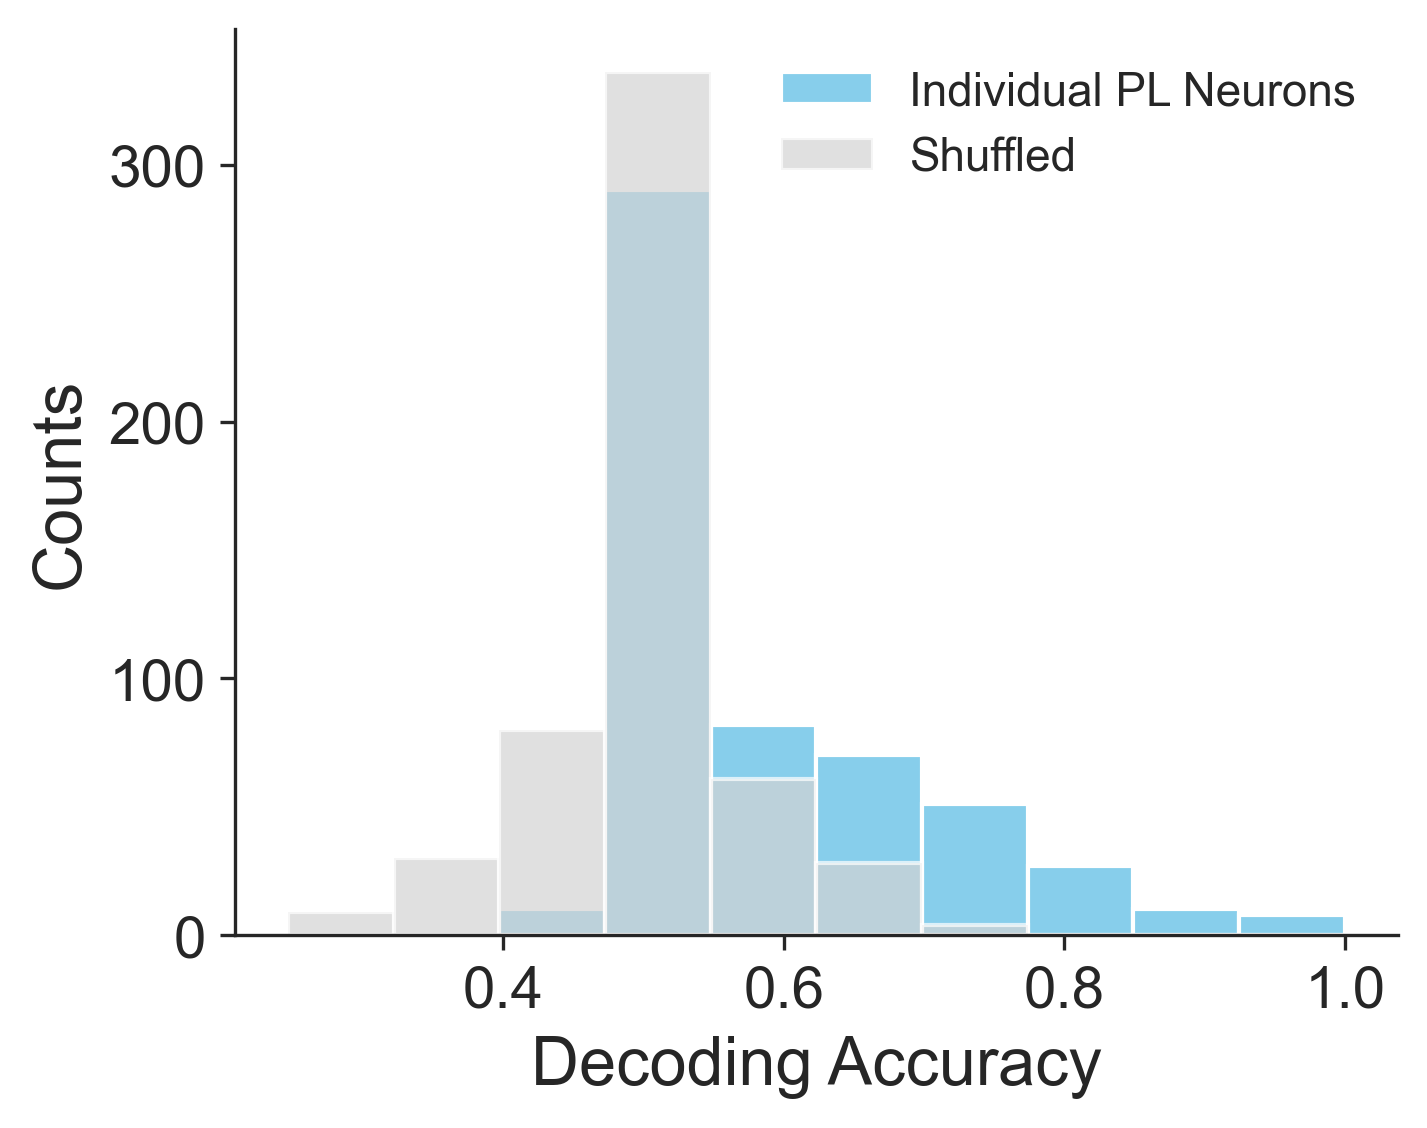

In [269]:
fig, ax = plt.subplots(figsize=(5, 4),dpi=300)
#ax.hist(training_accuracy, label = "training_accuracy",color = "lightgreen",alpha = 0.8, binwidth = 10, rwidth=1)
bins=np.histogram(np.hstack((testing_accuracy,testing_accuracy_shuffle)), bins=10)[1]
ax.hist(testing_accuracy, bins,label = "Individual PL Neurons",color = "skyblue",alpha = 1, rwidth=1)
ax.hist(testing_accuracy_shuffle, bins,label = "Shuffled", color = "lightgray",alpha = 0.7, rwidth=1)
ax.legend(loc=0, frameon= False,fontsize =11)
ax.set_xlabel("Decoding Accuracy", fontsize = 16)
ax.set_ylabel("Counts", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

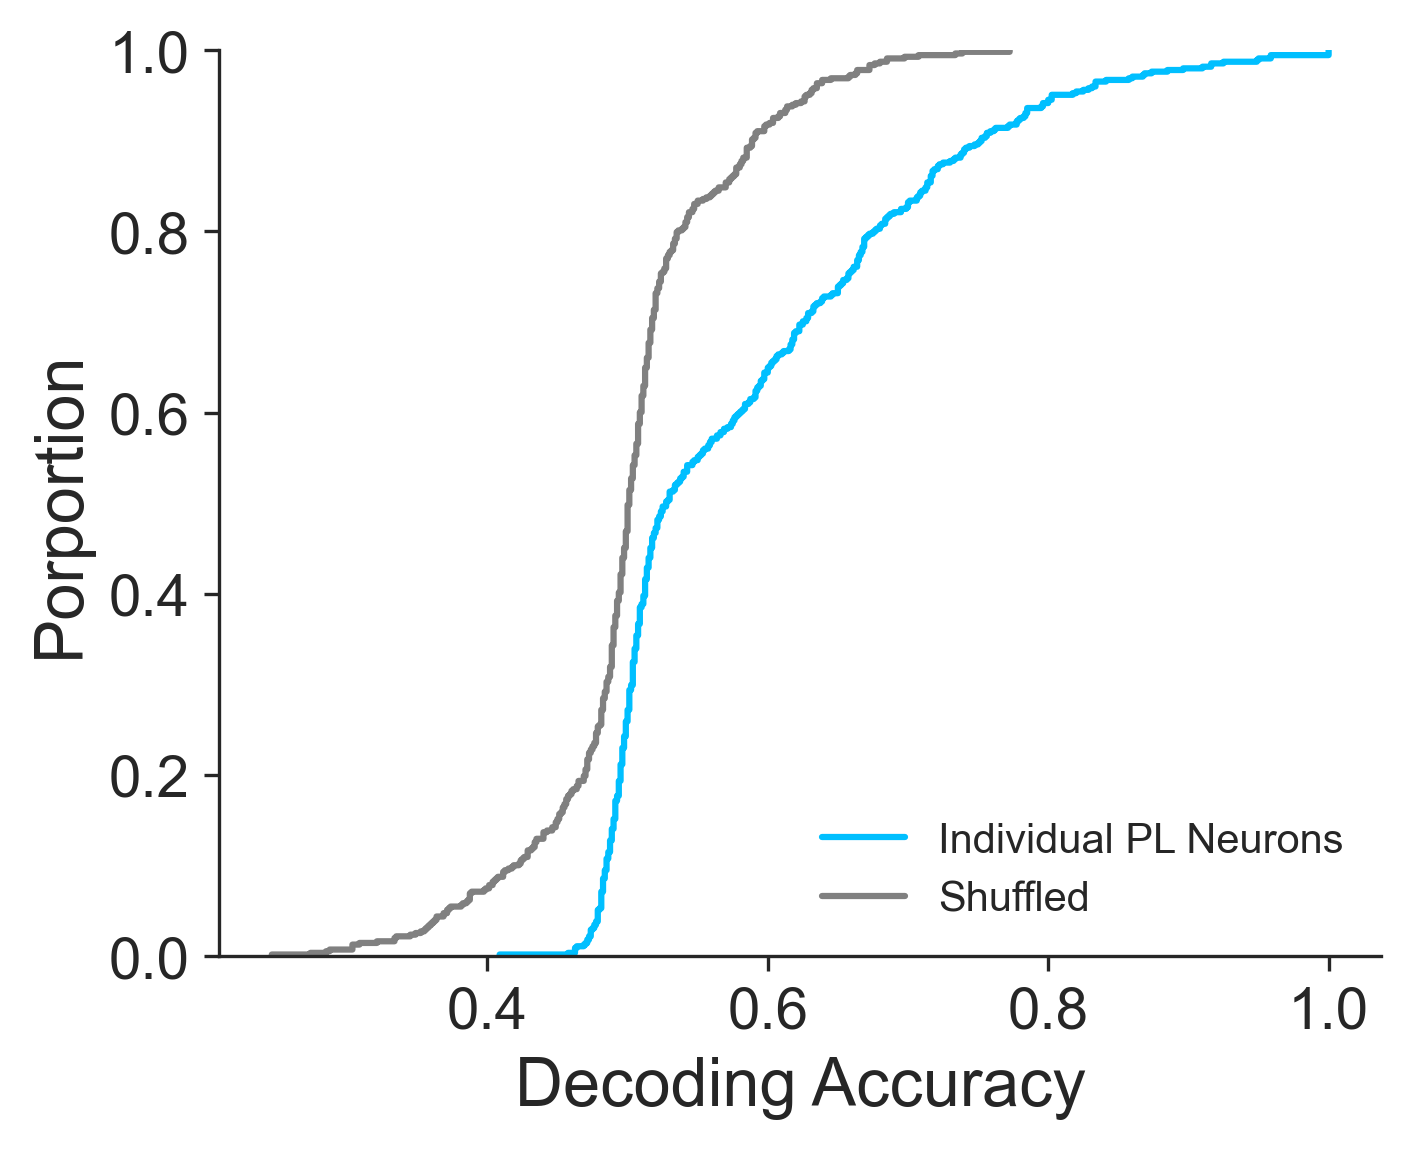

In [270]:
fig, ax = plt.subplots(figsize=(5, 4), dpi =300)
stat = "proportion"
g = sb.ecdfplot(data =individual_accuracy, x = "Score", hue ="Data", stat = stat, palette= ["deepskyblue", "grey"])
ax.set_xlabel("Decoding Accuracy", fontsize = 16)
ax.set_ylabel("Porportion", fontsize =16)
ax.tick_params(labelsize = 14)
g.legend_.set_title(None)
g.legend_.get_frame().set_linewidth(0.0)
sb.despine()

Text(1.25, 0.775, '*')

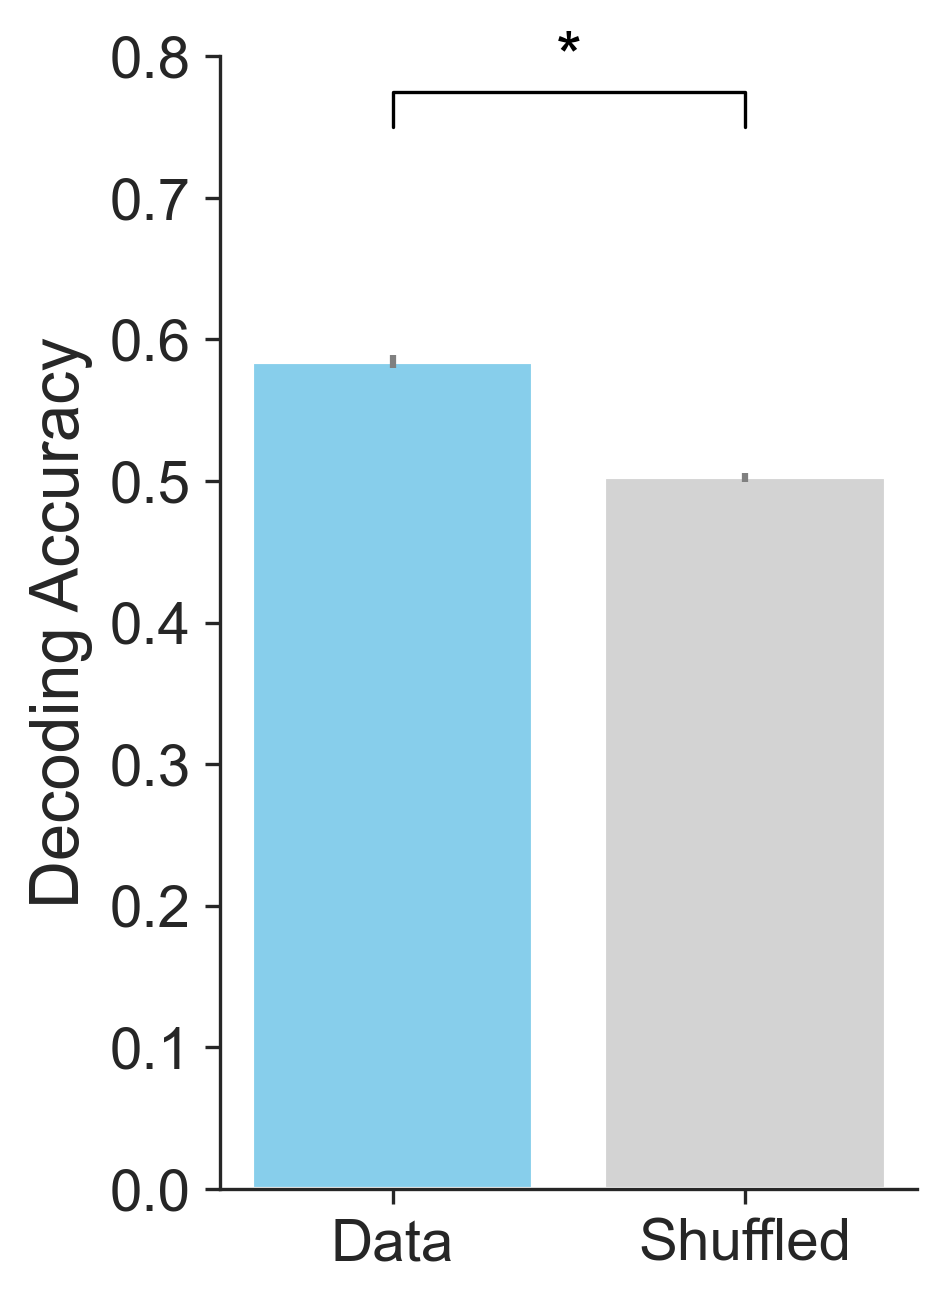

In [271]:
fig, ax = plt.subplots(figsize = (3,5), dpi = 300)
ax.yaxis.set_ticks_position('left')
ax.bar(1,testing_accuracy.mean(), yerr=stats.sem(testing_accuracy), color = "skyblue", alpha = 1, ecolor='gray', width = 0.4
      ,align='center')
ax.bar(1.5,testing_accuracy_shuffle.mean(), yerr=stats.sem(testing_accuracy_shuffle), color = "lightgrey", alpha = 1, ecolor='gray', 
       align='center',width = 0.4)
ax.set_xticks([1,1.5])
ax.set_xticklabels(["Data", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim = (0,0.8))
x1, x2 = 1, 1.5
y, h, col = 0.75, 0.025, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

Text(0.5, 1, '*')

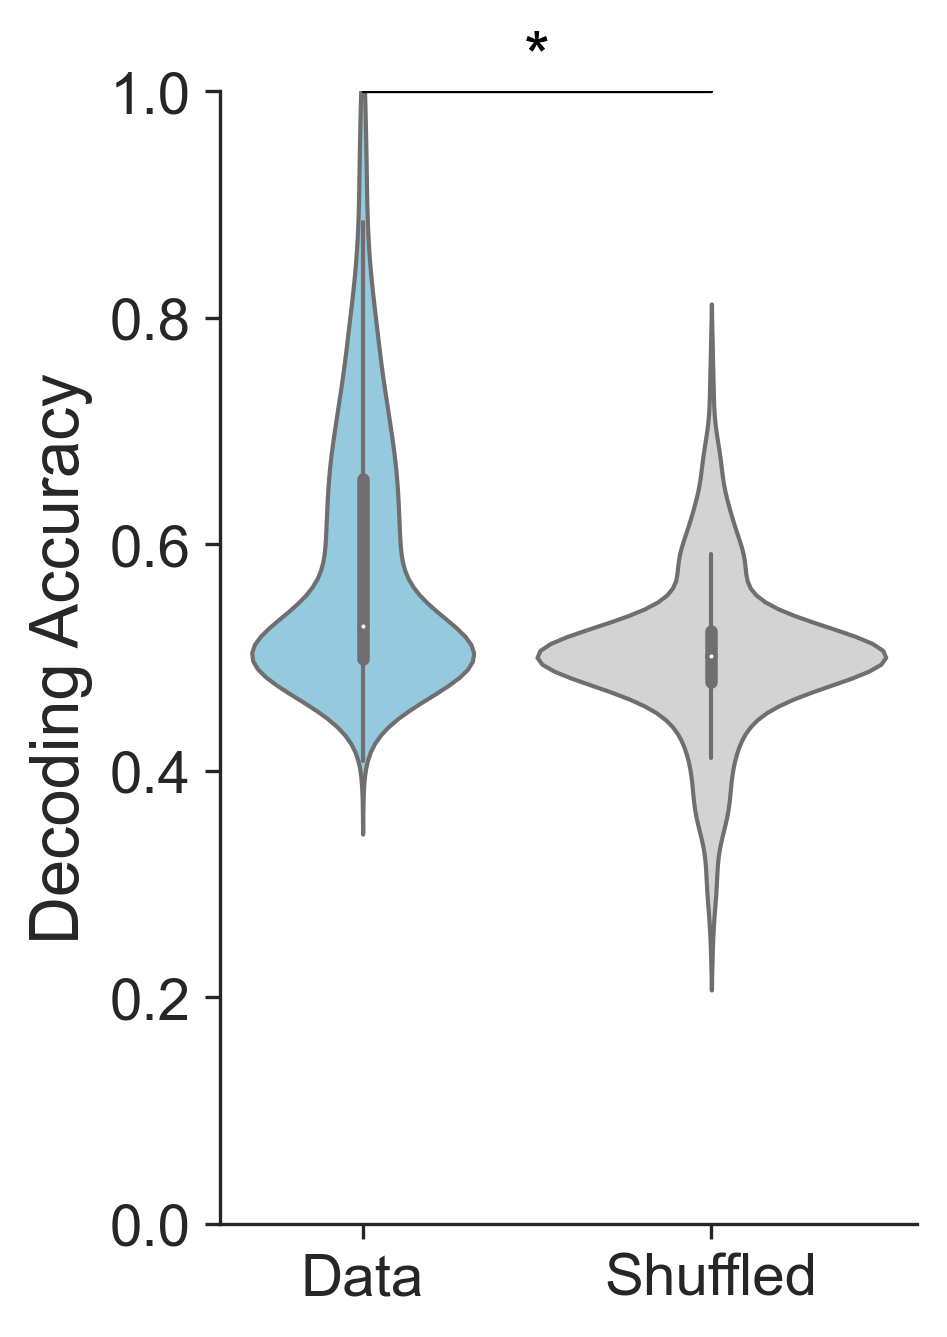

In [273]:

fig, ax = plt.subplots(figsize=(3, 5), dpi =300)
sb.violinplot(x= "Data", y = "Score",linewidth=1,palette=["skyblue", "lightgrey"],data = individual_accuracy,
              dodge=False,inner="box", width = 1.0)
sb.set_style("ticks")
ax.set_ylim(0,1.0)
ax.set_xlabel(None) 
ax.set_xticklabels(["Data", "Shuffled"], fontsize = 12)
ax.set_ylabel("Decoding Accuracy", fontsize =16)
ax.tick_params(labelsize = 14)
sb.despine()
x1, x2 = 0, 1
y, h, col = 1, 0, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.8, c=col)
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)


C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3713979240.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3713979240.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3713979240.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3713979240.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

230 neurons in Hungry


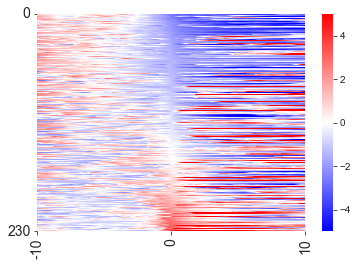

In [213]:
tracehungry = pd.DataFrame()


for n in range(len(os.listdir(hungry_dir))):
    f = pd.read_pickle(os.path.join(hungry_dir, os.listdir(hungry_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(TotalFrame))
    for i in range(TotalFrame):
        tracenew.iloc[:,i] = trace.iloc[:,start+i].mean(axis=1)
    tracebin = tracenew.groupby(pd.cut(tracenew.columns,Bins),axis=1).mean()
    tracebin.columns = np.arange(0,Bins)
    tracezscore = tracebin.sub(tracebin.iloc[:,0:int((Bins/2))].mean(axis=1),axis = 0).divide(tracebin.iloc[:,0:int((Bins/2))].std(axis=1),axis=0)
    tracehungry = tracehungry.append(tracezscore,ignore_index=True)

tracehungry = tracehungry.iloc[np.where(testing_accuracy>0.6)[0]]
tracesorted_hungry = tracehungry.sort_values(by=int((Bins/2)), axis =0)
ax = sb.heatmap(tracesorted_hungry, vmin = -5, vmax= 5, cmap = "bwr")
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange, 0, TimeRange])
ax.set_yticks([0,len(tracesorted_hungry)])
ax.set_yticklabels([0, len(tracesorted_hungry)])
ax.tick_params(labelsize = 14)
print(str(len(tracehungry)) + ' neurons in Hungry')

C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

230 neurons in Satiated


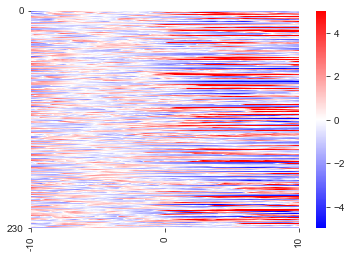

In [218]:
tracesatiated = pd.DataFrame()

for n in range(len(os.listdir(satiated_dir))):
    f = pd.read_pickle(os.path.join(satiated_dir, os.listdir(satiated_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(TotalFrame))
    for i in range(TotalFrame):
        tracenew.iloc[:,i] = trace.iloc[:,start+i].mean(axis=1)
    tracebin = tracenew.groupby(pd.cut(tracenew.columns,Bins),axis=1).mean()
    tracebin.columns = np.arange(0,Bins)
    tracezscore = tracebin.sub(tracebin.iloc[:,0:int((Bins/2))].mean(axis=1),axis = 0).divide(tracebin.iloc[:,0:int((Bins/2))].std(axis=1),axis=0)
    tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
    
tracesatiated = tracesatiated.iloc[tracesorted_hungry.index]
#tracesorted_satiated = tracesatiated.sort_values(by=int((Bins/2)), axis =0)
ax = sb.heatmap(tracesatiated, vmin = -5, vmax= 5, cmap = "bwr")
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange, 0, TimeRange])
ax.set_yticks([0,len(tracesatiated)])
ax.set_yticklabels([0, len(tracesatiated)])
print(str(len(tracesatiated)) + ' neurons in Satiated')

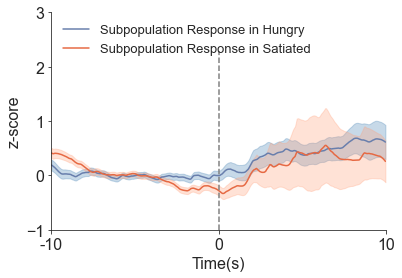

In [221]:
x=np.arange(Bins)
y=tracesatiated.mean()
z=tracehungry.mean()
erry = tracesatiated.sem()
errz = tracehungry.sem()
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Subpopulation Response in Hungry', color = '#687eac')
ax.plot(x, z, label = 'Subpopulation Response in Satiated', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('z-score', fontsize=16)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange,'0',TimeRange])
ax.set_xlim(0, Bins)
ax.set_ylim(-1,3)
ax.tick_params(labelsize = 16)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--', ymax = 0.82)
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3333347967.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3333347967.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3333347967.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3333347967.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

318 neurons in Hungry


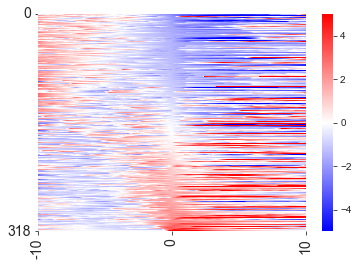

In [223]:
tracehungry = pd.DataFrame()


for n in range(len(os.listdir(hungry_dir))):
    f = pd.read_pickle(os.path.join(hungry_dir, os.listdir(hungry_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(TotalFrame))
    for i in range(TotalFrame):
        tracenew.iloc[:,i] = trace.iloc[:,start+i].mean(axis=1)
    tracebin = tracenew.groupby(pd.cut(tracenew.columns,Bins),axis=1).mean()
    tracebin.columns = np.arange(0,Bins)
    tracezscore = tracebin.sub(tracebin.iloc[:,0:int((Bins/2))].mean(axis=1),axis = 0).divide(tracebin.iloc[:,0:int((Bins/2))].std(axis=1),axis=0)
    tracehungry = tracehungry.append(tracezscore,ignore_index=True)

tracehungry = tracehungry.iloc[np.where(testing_accuracy<0.6)[0]]
tracesorted_hungry = tracehungry.sort_values(by=int((Bins/2)), axis =0)
ax = sb.heatmap(tracesorted_hungry, vmin = -5, vmax= 5, cmap = "bwr")
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange, 0, TimeRange])
ax.set_yticks([0,len(tracesorted_hungry)])
ax.set_yticklabels([0, len(tracesorted_hungry)])
ax.tick_params(labelsize = 14)
print(str(len(tracehungry)) + ' neurons in Hungry')

C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\3900893930.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

318 neurons in Satiated


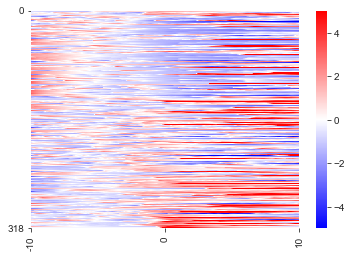

In [224]:
tracesatiated = pd.DataFrame()

for n in range(len(os.listdir(satiated_dir))):
    f = pd.read_pickle(os.path.join(satiated_dir, os.listdir(satiated_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(TotalFrame))
    for i in range(TotalFrame):
        tracenew.iloc[:,i] = trace.iloc[:,start+i].mean(axis=1)
    tracebin = tracenew.groupby(pd.cut(tracenew.columns,Bins),axis=1).mean()
    tracebin.columns = np.arange(0,Bins)
    tracezscore = tracebin.sub(tracebin.iloc[:,0:int((Bins/2))].mean(axis=1),axis = 0).divide(tracebin.iloc[:,0:int((Bins/2))].std(axis=1),axis=0)
    tracesatiated = tracesatiated.append(tracezscore,ignore_index=True)
    
tracesatiated = tracesatiated.iloc[tracesorted_hungry.index]
#tracesorted_satiated = tracesatiated.sort_values(by=int((Bins/2)), axis =0)
ax = sb.heatmap(tracesatiated, vmin = -5, vmax= 5, cmap = "bwr")
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange, 0, TimeRange])
ax.set_yticks([0,len(tracesatiated)])
ax.set_yticklabels([0, len(tracesatiated)])
print(str(len(tracesatiated)) + ' neurons in Satiated')

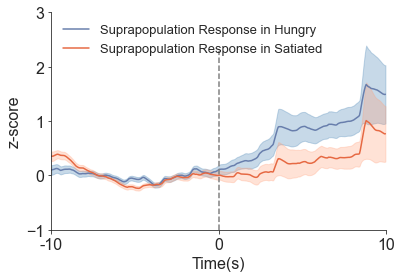

In [226]:
x=np.arange(Bins)
y=tracesatiated.mean()
z=tracehungry.mean()
erry = tracesatiated.sem()
errz = tracehungry.sem()
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Suprapopulation Response in Hungry', color = '#687eac')
ax.plot(x, z, label = 'Suprapopulation Response in Satiated', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xlabel('Time(s)', fontsize=16)
ax.set_ylabel('z-score', fontsize=16)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange,'0',TimeRange])
ax.set_xlim(0, Bins)
ax.set_ylim(-1,3)
ax.tick_params(labelsize = 16)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--', ymax = 0.82)
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_hungry)

In [1402]:
individual_accuracy = pd.DataFrame()
individual_accuracy["Score"]= np.concatenate([accuracy,accuracy_shuffle_y])
individual_accuracy["Data"] = np.concatenate([np.repeat("Individual PL Neurons",len(tracesatiated)),np.repeat("Shuffled",len(tracesatiated))])

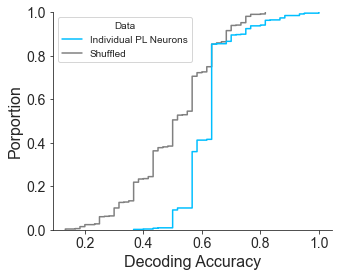

In [1419]:
fig, ax = plt.subplots(figsize=(5, 4))
stat = "proportion"
sb.ecdfplot(data =individual_accuracy, x = "Score", hue ="Data", stat = stat, palette= ["deepskyblue", "grey"])
ax.set_xlabel("Decoding Accuracy", fontsize = 16)
ax.set_ylabel("Porportion", fontsize =16)
ax.tick_params(labelsize = 14)
sb.despine()

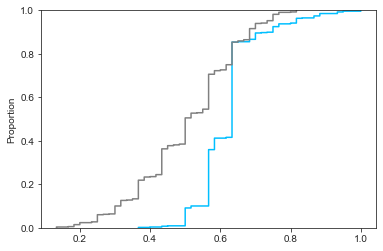

In [1388]:
stat = "proportion"
sb.ecdfplot(accuracy, stat = stat, color= "deepskyblue")
sb.ecdfplot(accuracy_shuffle_y, stat = stat, color= "grey")

In [713]:
accuracy_clf = np.zeros(len(tracesatiated))

for i in range(len(tracesatiated)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(svm.SVC(), hyperparameters, cv=10)
    clf.fit(X, y)
    accuracy_clf[i] = clf.best_score_

(array([ 79., 153.,  83.,  58.,  62.,  61.,  17.,  18.,  12.,   5.]),
 array([0.38333333, 0.445     , 0.50666667, 0.56833333, 0.63      ,
        0.69166667, 0.75333333, 0.815     , 0.87666667, 0.93833333,
        1.        ]),
 <a list of 10 Patch objects>)

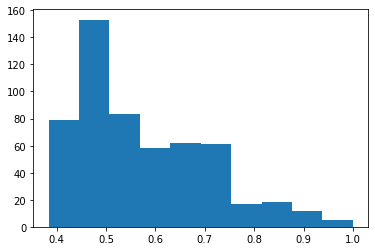

In [714]:
plt.hist(accuracy_clf)

In [679]:
k = 8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = svm.SVC()
stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
results.mean()

0.5

In [761]:
#%%time

change_shift_hungry = pd.DataFrame()


for n in range(len(os.listdir(hungry_dir))):
    f = pd.read_pickle(os.path.join(hungry_dir, os.listdir(hungry_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)]
    trace = trace.sample(frac=1, axis=1, random_state = 0).reset_index(drop=True)
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)
    change_shift_hungry = change_shift_hungry.append(tracenew)


change_shift_hungry

0           1           2           3           4           5   \
0   203.323757  218.641827  240.403978  198.014104  235.857518  232.000471   
1   189.160677  185.826628  163.316786  179.621038  181.187988  180.326672   
2   214.142886  185.750165  195.815936  233.612053  218.960423  224.690036   
3    97.374946   63.817515   72.759413   85.135517   55.330344   61.346655   
4   204.924351  166.171366  216.334127  195.941325  255.270265  198.237459   
..         ...         ...         ...         ...         ...         ...   
53  402.796002  399.040951  431.883751  432.347245  414.557335  446.770505   
54  232.144252  195.709045  207.524809  213.603613  183.480285  263.087955   
55  749.855617  779.889483  695.329557  857.751182  816.748683  810.501299   
56   76.245826   68.105035   66.778186   64.094615   51.101543   68.309401   
57  147.552845  127.049349  130.489325  120.034497  138.015590  133.179069   

            6           7           8           9           10          11  
0   211.102683  217.197219  196.608394  208.046395  222.768296  219.927215  
1   185.888941  190.654448  184.953881  184.325297  172.997749  192.443332  
2   198.291451  160.155301  172.829806  182.729184  172.586952  172.914509  
3    79.830615   67.735345   75.367124   66.015491   96.081177   62.606675  
4   193.435109  209.388456  178.657712  209.965863  232.404259  212.083968  
..         ...         ...         ...         ...         ...         ...  
53  419.253210  442.126863  434.356195  453.913276  385.315363  421.311383  
54  240.034333  226.000971  246.111508  244.757960  231.152719  236.963974  
55  773.859165  870.196716  894.299297  828.782378  703.825765  680.810844  
56   90.538931   62.729060   67.787695   66.487304   85.683661   80.451745  
57  150.007962  139.802764  134.487008  142.262880  157.367751  150.995071  

[548 rows x 12 columns]

In [762]:
change_shift_satiated = pd.DataFrame()


for n in range(len(os.listdir(satiated_dir))):
    f = pd.read_pickle(os.path.join(satiated_dir, os.listdir(satiated_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)]
    trace = trace.sample(frac=1, axis=1, random_state = 0).reset_index(drop=True)
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(3*FR)].mean(axis=1)
    change_shift_satiated = change_shift_satiated.append(tracenew)

In [763]:
change_shift_satiated

0           1           2           3           4           5   \
0   195.245375  223.969498  258.103168  245.518187  183.061266  182.174302   
1   406.051923  356.663561  355.434923  356.529471  359.886495  382.088548   
2   172.030888  138.254113  208.147250  157.168131  186.108435  185.259526   
3   123.363057  123.838170  133.768959  114.889911  125.406220  113.018513   
4   171.276789  196.601062  157.897433  170.475864  171.781992  184.089814   
..         ...         ...         ...         ...         ...         ...   
53  415.366001  433.112156  394.319174  415.669090  460.538584  485.163252   
54  214.026049  212.104162  178.779244  190.985114  233.169160  283.426626   
55  866.087609  815.758235  844.273755  693.963043  819.753637  924.694800   
56   69.444294   60.892461   51.921381   69.966486   68.901421   88.339711   
57  133.758573  112.713550  124.466068  131.819743  139.113557  126.722207   

            6           7           8           9           10          11  
0   201.956950  170.560419  179.385850  212.597221  219.057272  205.490756  
1   303.735604  320.958955  325.491990  310.560238  316.429874  267.430691  
2   163.331596  199.723016  166.558049  181.652212  154.404467  155.064589  
3   117.199994  135.180681  137.264013  115.735029  115.368543  132.281719  
4   140.689769  132.371562  139.008660  163.816955  197.498178  173.952751  
..         ...         ...         ...         ...         ...         ...  
53  427.582993  408.008727  460.072119  387.805943  450.475470  443.774091  
54  179.305870  262.096410  244.661263  214.602151  262.014288  224.653079  
55  723.994647  759.867784  729.196134  864.069670  836.305930  910.303463  
56   60.390959   76.890167   82.222109   62.059219   77.162359   66.521717  
57  122.918706  154.441799  143.763593  137.531624  169.831334  138.301231  

[548 rows x 12 columns]

In [764]:

satiated_trace_shift = pd.DataFrame()

for i in range(len(change_shift_satiated)):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array(["False"])
    dff["dff"]= [np.array(change_shift_satiated.iloc[i,:].values)]
    
    satiated_trace_shift = satiated_trace_shift.append(dff)

In [861]:
accuracy_shuffle = np.zeros(len(tracesatiated))

for i in range(len(tracesatiated)):
    X = np.concatenate([hungry_trace_shift.dff.values[i],satiated_trace_shift.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    k = 5
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state =4)
    clf = svm.SVC()
    stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
    results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
    accuracy_shuffle[i] = results.mean()

In [865]:
np.where(accuracy_shuffle==1)

(array([  1,   3,  12,  17,  26,  35,  46,  49,  54,  56,  57,  58,  62,
         63,  64, 127, 128, 132, 133, 135, 139, 140, 144, 145, 149, 150,
        151, 154, 158, 160, 163, 171, 173, 193, 194, 195, 205, 208, 209,
        210, 214, 215, 220, 221, 223, 224, 225, 235, 236, 238, 240, 247,
        248, 251, 261, 263, 265], dtype=int64),)

In [866]:
np.concatenate([hungry_trace_shift.dff.values[1],satiated_trace_shift.dff.values[1]])

array([181.26580213, 179.98492695, 180.44371412, 160.06349344,
       185.22233123, 193.5378502 , 166.70456158, 183.10592821,
       172.13079351, 187.10179156, 175.43063961, 165.60451956,
       406.05192283, 356.66356056, 355.43492296, 356.52947141,
       359.88649496, 382.08854832, 303.73560392, 320.95895531,
       325.49199046, 310.56023755, 316.42987435, 267.43069062])

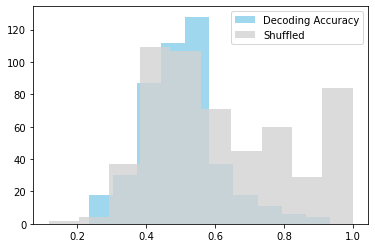

In [862]:
plt.hist(accuracy, label = "Decoding Accuracy",color = "skyblue",alpha = 0.8)
plt.hist(accuracy_shuffle, label = "Shuffled", color = "lightgray",alpha = 0.8)
plt.legend(loc='upper right')


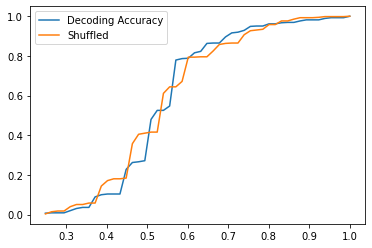

In [806]:
count, bins_count = np.histogram(accuracy, bins=50)
count_shuffle, bins_count_shuffle = np.histogram(accuracy_shuffle, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
pdf_shuffle = count_shuffle / sum(count_shuffle)
cdf_shuffle = np.cumsum(pdf_shuffle)
plt.plot(bins_count[1:], cdf, label="Decoding Accuracy")
plt.plot(bins_count[1:], cdf_shuffle, label="Shuffled")
plt.legend(loc='upper left')

In [863]:
accuracy_clf_shuffle = np.zeros(len(tracesatiated))

for i in range(len(tracesatiated)):
    X = np.concatenate([hungry_trace_shift.dff.values[i],satiated_trace_shift.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(svm.SVC(), hyperparameters, cv=10)
    clf.fit(X, y)
    accuracy_clf_shuffle[i] = clf.best_score_

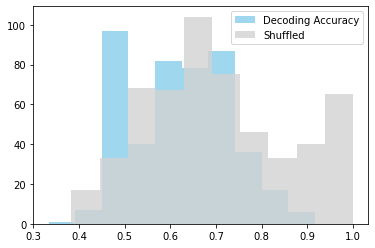

In [864]:
plt.hist(accuracy_clf, label = "Decoding Accuracy",color = "skyblue",alpha = 0.8)
plt.hist(accuracy_clf_shuffle, label = "Shuffled", color = "lightgray",alpha = 0.8)
plt.legend(loc='upper right')


In [265]:
X = list(trace_combined_shift.dff.squeeze().values)
y = np.array(trace_combined_shift.is_hungry*1)

In [274]:
k = 8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
clf_2 = svm.SVC()
stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
results = cross_val_score(clf_2, X_train, y_train, cv = stratified_kfold)
results.mean()

0.5625

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = GridSearchCV(svm.SVC(), hyperparameters, cv=5)
clf.fit(X_train, y_train)
clf.best_score_

0.5666666666666667

In [297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
bootstrap_iter = 8 
clf = svm.SVC()
accuracy = []
for i in range(bootstrap_iter):
    X_, y_ = resample(X_train, y_train)
    clf.fit(X_, y_)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_pred, y_test)
    accuracy.append(acc)
accuracy = np.array(accuracy)
accuracy.mean()

0.35

## zscore

In [66]:
tracehungry = pd.DataFrame()


for n in range(len(os.listdir(hungry_dir))):
    f = pd.read_pickle(os.path.join(hungry_dir, os.listdir(hungry_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(TotalFrame))
    tracecue = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        for j in range(TotalFrame):
            tracenew.iloc[:,j] = trace.iloc[:,start[i]+j]
        tracebin = tracenew.groupby(pd.cut(tracenew.columns,Bins),axis=1).mean()
        tracebin.columns = np.arange(0,Bins)
        tracezscore = tracebin.sub(tracebin.iloc[:,0:int((Bins/2))].mean(axis=1),axis = 0).divide(tracebin.iloc[:,0:int((Bins/2))].std(axis=1),axis=0)
        tracecue.iloc[:,i] = tracezscore.iloc[:,int((Bins/2)):int((Bins/2))+int(3*FR/BinSize)].mean(axis=1)
    tracehungry = tracehungry.append(tracecue)
#tracehungry = tracehungry.dropna()

C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\2999325610.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracecue)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\2999325610.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracecue)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\2999325610.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.append(tracecue)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\2999325610.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracehungry = tracehungry.a

In [69]:
tracehungry

0         1         2         3         4         5         6   \
2  -0.501312  0.207640 -0.553015  0.076807 -1.959033  2.378280 -0.728150   
5   2.138208 -1.304142 -1.778810 -2.017795 -2.178282 -1.339724  0.677330   
6  -1.564310  3.671831 -2.101241  0.008013  0.812770  3.577895  0.006313   
7  -1.137889  0.173055  0.495697 -1.058538  3.930716 -1.629890 -1.631992   
8  -0.566445 -0.174665 -0.607040 -0.378416  0.877908  0.016274 -1.740497   
..       ...       ...       ...       ...       ...       ...       ...   
61  0.830004 -2.369807 -0.385870  2.201961  0.804165 -1.291657  0.445418   
62  0.377181 -1.344121 -2.005469  0.958185 -1.613791  4.941160 -0.283088   
64  1.083650 -1.135183 -0.911515  0.514201  0.343484 -0.932153 -0.637755   
65  4.361585  0.459847 -1.053649 -0.081728 -0.735595 -1.452069 -1.266289   
67  1.118798  1.014020  1.346549 -2.094635  5.568729  1.013590 -0.636997   

          7         8         9         10        11  
2  -0.151655 -1.816967  0.635587 -1.381231 -0.519251  
5  -0.666483  1.084821 -1.848913 -2.469284  2.438868  
6   1.672071 -1.032592  0.085411  1.473064  0.365353  
7   0.711177  1.779762 -1.631992 -1.631992 -1.248398  
8   5.229243  1.379842  0.249690  1.259563  0.439186  
..       ...       ...       ...       ...       ...  
61  1.077095  0.064703  0.472286  5.817523  0.783575  
62  2.773047 -1.969912  0.360109  1.632020  1.334940  
64  1.354379 -0.371078 -0.184322 -1.132924 -1.003459  
65 -0.188273 -2.107802 -1.570182  0.933048  0.477564  
67 -0.011041 -0.111021  2.046888  3.336593  3.033126  

[548 rows x 12 columns]

In [70]:
tracesatiated = pd.DataFrame()


for n in range(len(os.listdir(satiated_dir))):
    f = pd.read_pickle(os.path.join(satiated_dir, os.listdir(satiated_dir)[n]))
    cueonset = np.array(np.where(np.diff(np.concatenate(([0],f.loc['cue']>0)))>0)[0])
    start = cueonset-FrameRange
    trace = f[:(len(f)-2)] 
    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(TotalFrame))
    tracecue = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))
    for i in range(len(cueonset)):
        for j in range(TotalFrame):
            tracenew.iloc[:,j] = trace.iloc[:,start[i]+j]
        tracebin = tracenew.groupby(pd.cut(tracenew.columns,Bins),axis=1).mean()
        tracebin.columns = np.arange(0,Bins)
        tracezscore = tracebin.sub(tracebin.iloc[:,0:int((Bins/2))].mean(axis=1),axis = 0).divide(tracebin.iloc[:,0:int((Bins/2))].std(axis=1),axis=0)
        tracecue.iloc[:,i] = tracezscore.iloc[:,int((Bins/2)):int((Bins/2))+int(3*FR/BinSize)].mean(axis=1)
    tracesatiated = tracesatiated.append(tracecue)
#tracesatiated = tracesatiated.dropna()

C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\930608493.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracecue)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\930608493.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracecue)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\930608493.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tracesatiated.append(tracecue)
C:\Users\Domontelabdata\AppData\Local\Temp\ipykernel_7316\930608493.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracesatiated = tra

In [71]:
traceconcat = pd.concat([tracehungry,tracesatiated],axis =1)
traceconcat.replace([np.inf, -np.inf], np.nan, inplace=True)
traceconcat = traceconcat.dropna()
traceconcat

0         1         2         3         4         5         6   \
2  -0.501312  0.207640 -0.553015  0.076807 -1.959033  2.378280 -0.728150   
5   2.138208 -1.304142 -1.778810 -2.017795 -2.178282 -1.339724  0.677330   
6  -1.564310  3.671831 -2.101241  0.008013  0.812770  3.577895  0.006313   
7  -1.137889  0.173055  0.495697 -1.058538  3.930716 -1.629890 -1.631992   
8  -0.566445 -0.174665 -0.607040 -0.378416  0.877908  0.016274 -1.740497   
..       ...       ...       ...       ...       ...       ...       ...   
61  0.830004 -2.369807 -0.385870  2.201961  0.804165 -1.291657  0.445418   
62  0.377181 -1.344121 -2.005469  0.958185 -1.613791  4.941160 -0.283088   
64  1.083650 -1.135183 -0.911515  0.514201  0.343484 -0.932153 -0.637755   
65  4.361585  0.459847 -1.053649 -0.081728 -0.735595 -1.452069 -1.266289   
67  1.118798  1.014020  1.346549 -2.094635  5.568729  1.013590 -0.636997   

          7         8         9   ...        2         3         4         5   \
2  -0.151655 -1.816967  0.635587  ... -0.695644 -1.133156 -1.836930 -1.164660   
5  -0.666483  1.084821 -1.848913  ... -1.812661  3.156289 -1.824163 -1.259046   
6   1.672071 -1.032592  0.085411  ...  6.035212  0.502555 -0.864979  0.755207   
7   0.711177  1.779762 -1.631992  ... -1.375207 -0.901819 -2.106709 -2.836468   
8   5.229243  1.379842  0.249690  ... -1.992152 -1.162848  2.012788 -0.832854   
..       ...       ...       ...  ...       ...       ...       ...       ...   
61  1.077095  0.064703  0.472286  ... -1.014155 -1.111447  0.882456 -0.956747   
62  2.773047 -1.969912  0.360109  ...  0.788083 -1.059458  1.623515 -1.266929   
64  1.354379 -0.371078 -0.184322  ...  0.394833 -1.543696  2.082962  1.193244   
65 -0.188273 -2.107802 -1.570182  ... -0.203466 -1.392696 -1.442065  3.187309   
67 -0.011041 -0.111021  2.046888  ... -1.929242  3.148992 -1.770852  2.189065   

          6         7          8         9         10        11  
2  -1.836930  7.233119  -2.331705  2.471031  1.494413  1.845597  
5  -1.065475 -2.441638  -1.881884 -0.763000 -0.063013 -2.959575  
6  -1.465629  1.428448  10.374718 -0.145004 -2.240124 -1.101233  
7  -0.510995 -0.184965  -2.343633  0.715722 -2.298413  0.593787  
8  -1.965792  6.830961   4.132507  2.374318 -1.382480 -1.740497  
..       ...       ...        ...       ...       ...       ...  
61 -0.652939  1.618220   1.125747 -1.729612  1.096544 -1.170434  
62 -0.089907  5.514493  -0.846666  2.556234 -1.206612  0.631906  
64 -1.009153  1.908614   2.558186 -0.401172  0.074508  0.805143  
65 -1.452069  1.568260  -0.846426 -0.520853  2.268943 -0.938328  
67  1.978258 -1.490039  -2.258317 -1.012214  0.491397  0.169913  

[451 rows x 24 columns]

In [72]:
hungry_trace = traceconcat.iloc[:, 0:12].to_numpy(dtype = "float32").flatten()

In [75]:
satiated_trace = traceconcat.iloc[:, 12:24].to_numpy(dtype = "float32").flatten()

In [77]:
#%%time
X = np.concatenate([hungry_trace,satiated_trace]).reshape(-1,1)
y = np.concatenate([np.repeat(True,len(hungry_trace)),np.repeat(False,len(satiated_trace))])
k = 5
stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = None)
#hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
#                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
#clf = GridSearchCV(svm.SVC(), hyperparameters, cv=stratified_kfold, n_jobs =-1)
clf= svm.SVC(kernel = 'rbf', gamma = 0.01, C = 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 9)
results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
clf.fit(X_train,y_train)
clf
results

array([0.50379049, 0.50379049, 0.50413793, 0.50344828, 0.50344828])

In [814]:
hungry_trace = pd.DataFrame()
for i in range(len(traceconcat)):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array(["True"])
    dff["dff"]= [np.array(traceconcat.iloc[i,0:12].values)]
    
    hungry_trace = hungry_trace.append(dff)

In [820]:
satiated_trace = pd.DataFrame()

for i in range(len(traceconcat)):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array(["False"])
    dff["dff"]= [np.array(traceconcat.iloc[i,12:24].values)]
    
    satiated_trace = satiated_trace.append(dff)

In [833]:
accuracy = np.zeros(len(satiated_trace))

for i in range(len(satiated_trace)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    k = 5
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state =42)
    clf = svm.SVC()
    stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)
    results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
    accuracy[i] = results.mean()

(array([ 18.,  30.,  87., 112., 128.,  37.,  18.,  11.,   6.,   4.]),
 array([0.23333333, 0.30333333, 0.37333333, 0.44333333, 0.51333333,
        0.58333333, 0.65333333, 0.72333333, 0.79333333, 0.86333333,
        0.93333333]),
 <a list of 10 Patch objects>)

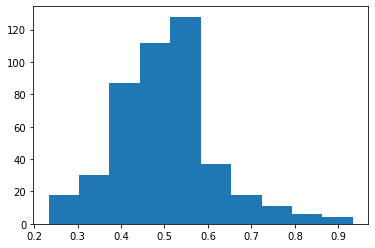

In [834]:
plt.hist(accuracy)

In [844]:
accuracy_shuffle_y = np.zeros(len(satiated_trace))

for i in range(len(satiated_trace)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    np.random.shuffle(y)
    k = 5
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state =42)
    clf = svm.SVC()
    stratified_kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)
    results = cross_val_score(clf, X_train, y_train, cv = stratified_kfold)
    accuracy_shuffle_y[i] = results.mean()

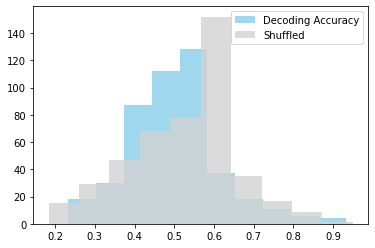

In [845]:
plt.hist(accuracy, label = "Decoding Accuracy",color = "skyblue",alpha = 0.8)
plt.hist(accuracy_shuffle_y, label = "Shuffled", color = "lightgray",alpha = 0.8)
plt.legend(loc='upper right')

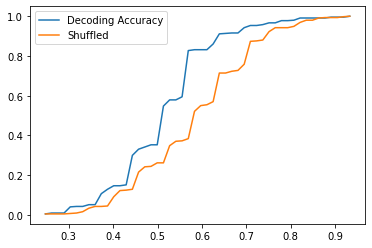

In [837]:
count, bins_count = np.histogram(accuracy, bins=50)
count_shuffle, bins_count_shuffle = np.histogram(accuracy_shuffle_y, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
pdf_shuffle = count_shuffle / sum(count_shuffle)
cdf_shuffle = np.cumsum(pdf_shuffle)
plt.plot(bins_count[1:], cdf, label="Decoding Accuracy")
plt.plot(bins_count[1:], cdf_shuffle, label="Shuffled")
plt.legend(loc='upper left')

In [847]:
accuracy_clf = np.zeros(len(satiated_trace))

for i in range(len(satiated_trace)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(svm.SVC(), hyperparameters, cv=10)
    clf.fit(X, y)
    accuracy_clf[i] = clf.best_score_

(array([ 1.,  7., 97., 40., 82., 78., 87., 36., 17.,  6.]),
 array([0.33333333, 0.39166667, 0.45      , 0.50833333, 0.56666667,
        0.625     , 0.68333333, 0.74166667, 0.8       , 0.85833333,
        0.91666667]),
 <a list of 10 Patch objects>)

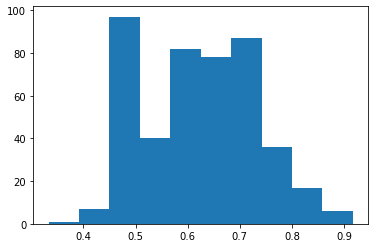

In [848]:
plt.hist(accuracy_clf)

In [849]:
accuracy_clf_shuffle_y = np.zeros(len(satiated_trace))

for i in range(len(satiated_trace)):
    X = np.concatenate([hungry_trace.dff.values[i],satiated_trace.dff.values[i]])
    X = X.reshape(-1, 1)
    y = np.concatenate([np.repeat(1,12),np.repeat(0,12)])
    np.random.shuffle(y)
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(svm.SVC(), hyperparameters, cv=10)
    clf.fit(X, y)
    accuracy_clf_shuffle_y[i] = clf.best_score_

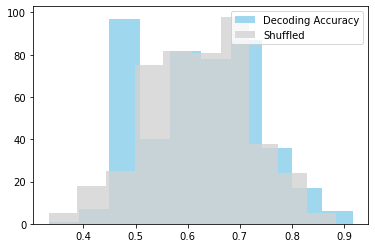

In [850]:
plt.hist(accuracy_clf, label = "Decoding Accuracy",color = "skyblue",alpha = 0.8)
plt.hist(accuracy_clf_shuffle_y, label = "Shuffled", color = "lightgray",alpha = 0.8)
plt.legend(loc='upper right')

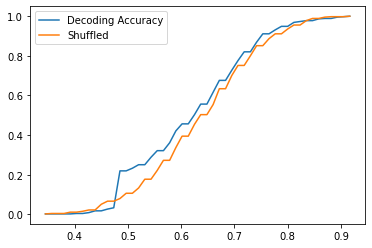

In [851]:
count, bins_count = np.histogram(accuracy_clf, bins=50)
count_shuffle, bins_count_shuffle = np.histogram(accuracy_clf_shuffle_y, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
pdf_shuffle = count_shuffle / sum(count_shuffle)
cdf_shuffle = np.cumsum(pdf_shuffle)
plt.plot(bins_count[1:], cdf, label="Decoding Accuracy")
plt.plot(bins_count[1:], cdf_shuffle, label="Shuffled")
plt.legend(loc='upper left')